In [1]:
# Import required libraries
import pymrio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time
import pickle
from datetime import datetime
import os

# Set display options for better readability
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', '{:.2f}'.format)

print("Libraries imported successfully")
print(f"pymrio version: {pymrio.__version__}")

Libraries imported successfully
pymrio version: 0.5.4


In [2]:
# Define data paths
BASE_PATH = Path(r"C:\Users\Marine Riesterer\OneDrive\Desktop\MA Arbeit")
EXIOBASE_PATH = BASE_PATH / "Exiobase3_ixi_latest"
RESULTS_PATH = BASE_PATH / "Results"
POPULATION_FILE = BASE_PATH / "code" / "producerappraoch" / "clean code" / "exiobase3_population_2022_official.csv"

# Create results directory if it doesn't exist
RESULTS_PATH.mkdir(exist_ok=True)

# Define analysis parameters
SINGLE_YEAR = 2019  # For detailed single-year analysis
YEARS_TIME_SERIES = list(range(1995, 2023))  # 1995-2022

print(f"Base path: {BASE_PATH}")
print(f"EXIOBASE data path: {EXIOBASE_PATH}")
print(f"Results will be saved to: {RESULTS_PATH}")
print(f"Years for time series: {YEARS_TIME_SERIES[0]}-{YEARS_TIME_SERIES[-1]}")

Base path: C:\Users\Marine Riesterer\OneDrive\Desktop\MA Arbeit
EXIOBASE data path: C:\Users\Marine Riesterer\OneDrive\Desktop\MA Arbeit\Exiobase3_ixi_latest
Results will be saved to: C:\Users\Marine Riesterer\OneDrive\Desktop\MA Arbeit\Results
Years for time series: 1995-2022


In [3]:
def load_population_data():
    """Load population data for 2022."""
    print(f"Loading population data from: {POPULATION_FILE}")
    
    if not POPULATION_FILE.exists():
        print(f"ERROR: Population file not found!")
        return None
    
    # Load CSV
    pop_df = pd.read_csv(POPULATION_FILE)
    print(f"Population data shape: {pop_df.shape}")
    print(f"Columns: {pop_df.columns.tolist()}")
    
    # Display first few rows to understand structure
    print("\nFirst 5 rows:")
    print(pop_df.head())
    
    # ADJUST THIS BASED ON YOUR ACTUAL CSV STRUCTURE
    if 'EXIOBASE3_Code' in pop_df.columns and 'Population_2022' in pop_df.columns:
        population = pd.Series(
            pop_df['Population_2022'].values,
            index=pop_df['EXIOBASE3_Code']
        )
        return population
    else:
        print("Please check column names and adjust the code!")
        return None

# Load population
population_2022 = load_population_data()


Loading population data from: C:\Users\Marine Riesterer\OneDrive\Desktop\MA Arbeit\code\producerappraoch\clean code\exiobase3_population_2022_official.csv
Population data shape: (49, 3)
Columns: ['EXIOBASE3_Code', 'Population_2022', 'Source']

First 5 rows:
  EXIOBASE3_Code  Population_2022             Source
0             AT       9041851.00  World Bank (2022)
1             BE      11680210.00  World Bank (2022)
2             BG       6643324.00  World Bank (2022)
3             CY       1331370.00  World Bank (2022)
4             CZ      10672118.00  World Bank (2022)


In [4]:
# Define greenhouse gas categories with IPCC AR6 GWP100 factors
EMISSION_CATEGORIES = {
    # CO2 emissions (GWP = 1.0)
    'CO2 - combustion - air': 1.0,
    'CO2 - waste - fossil - air': 1.0,
    'CO2 - agriculture - peat decay - air': 1.0,
    'CO2 - non combustion - Cement production - air': 1.0,
    'CO2 - non combustion - Lime production - air': 1.0,
    
    # CH4 emissions - Combustion (GWP = 27.0)
    'CH4 - combustion - air': 27.0,
    
    # CH4 emissions - Fugitive/Process (GWP = 29.8)
    'CH4 - non combustion - Extraction/production of (natural) gas - air': 29.8,
    'CH4 - non combustion - Extraction/production of crude oil - air': 29.8,
    'CH4 - non combustion - Oil refinery - air': 29.8,
    'CH4 - non combustion - Mining of bituminous coal - air': 29.8,
    'CH4 - non combustion - Mining of coking coal - air': 29.8,
    'CH4 - non combustion - Mining of lignite (brown coal) - air': 29.8,
    'CH4 - non combustion - Mining of sub-bituminous coal - air': 29.8,
    
    # CH4 emissions - Biogenic (GWP = 27.0)
    'CH4 - agriculture - air': 27.0,
    'CH4 - waste - air': 27.0,
    
    # N2O emissions (GWP = 273.0)
    'N2O - combustion - air': 273.0,
    'N2O - agriculture - air': 273.0,
    
    # Industrial gases
    'SF6 - air': 25184.0,
    'HFC - air': 1.0,  # Already in CO2-eq
    'PFC - air': 1.0   # Already in CO2-eq
}

# Define value-added components
VALUE_ADDED_COMPONENTS = [
    "Taxes less subsidies on products purchased: Total",     # taxes to be exculded later
    "Other net taxes on production",
    "Compensation of employees; wages, salaries, & employers' social contributions: Low-skilled",
    "Compensation of employees; wages, salaries, & employers' social contributions: Medium-skilled",
    "Compensation of employees; wages, salaries, & employers' social contributions: High-skilled",
    "Operating surplus: Consumption of fixed capital",    
    "Operating surplus: Rents on land",
    "Operating surplus: Royalties on resources",
    "Operating surplus: Remaining net operating surplus"    ###profit
]
     
# The profit row is row number 8 in factor_inputs (0-based index).

print(f"Defined {len(EMISSION_CATEGORIES)} emission categories")
print(f"Defined {len(VALUE_ADDED_COMPONENTS)} value-added components")

Defined 20 emission categories
Defined 9 value-added components


In [20]:
# Print all unique sector names in EXIOBASE
all_sectors = sorted(set(ixi_data.get_sectors()))
print("=== EXIOBASE SECTORS ===")
for sector in all_sectors:
    print(sector)

=== EXIOBASE SECTORS ===
Activities auxiliary to financial intermediation (67)
Activities of membership organisation n.e.c. (91)
Air transport (62)
Aluminium production
Animal products nec
Biogasification of food waste, incl. land application
Biogasification of paper, incl. land application
Biogasification of sewage slugde, incl. land application
Casting of metals
Cattle farming
Chemicals nec
Collection, purification and distribution of water (41)
Composting of food waste, incl. land application
Composting of paper and wood, incl. land application
Computer and related activities (72)
Construction (45)
Copper production
Cultivation of cereal grains nec
Cultivation of crops nec
Cultivation of oil seeds
Cultivation of paddy rice
Cultivation of plant-based fibers
Cultivation of sugar cane, sugar beet
Cultivation of vegetables, fruit, nuts
Cultivation of wheat
Distribution and trade of electricity
Education (80)
Extra-territorial organizations and bodies
Extraction of crude petroleum and se

In [21]:
# sector_classification: fossil-related sectors extracted from your EXIOBASE list
sector_classification = {
    "coal": [
        "Mining of coal and lignite; extraction of peat (10)",
        "Production of electricity by coal",
        "Manufacture of coke oven products",
    ],
    "oil": [
        "Extraction of crude petroleum and services related to crude oil extraction, excluding surveying",
        "Petroleum Refinery",
        "Production of electricity by petroleum and other oil derivatives",
        "Retail sale of automotive fuel",
        "Incineration of waste: Oil/Hazardous waste",
        "Plastics, basic",  # petrochemical (typical oil/gas feedstock) — included as oil/petrochemical
    ],
    "gas": [
        "Extraction of natural gas and services related to natural gas extraction, excluding surveying",
        "Extraction, liquefaction, and regasification of other petroleum and gaseous materials",
        "Manufacture of gas; distribution of gaseous fuels through mains",
        "Production of electricity by gas",
        "Transport via pipelines",  # primarily oil & gas pipelines — treat as gas/oil infra
        "N-fertiliser",            # ammonia production typically gas-fed (feedstock/intensive)
    ],
    "fossil_electricity": [
        # note: production-by-fuel already in coal/gas/oil above; these are system-level electricity services
        "Distribution and trade of electricity",
        "Transmission of electricity",
        "Steam and hot water supply",   # often fossil-fuel based (esp. district heat)
    ],
    "renewable": [
        "Production of electricity by Geothermal",
        "Production of electricity by biomass and waste",
        "Production of electricity by hydro",
        "Production of electricity by solar photovoltaic",
        "Production of electricity by solar thermal",
        "Production of electricity by tide, wave, ocean",
        "Production of electricity by wind",
    ],
    "other_fossil_intensive": [
        # heavy industrial users / fossil-intensive but not strictly "fossil extraction/refining"
        "Manufacture of basic iron and steel and of ferro-alloys and first products thereof",
        "Manufacture of cement, lime and plaster",
        "Manufacture of other non-metallic mineral products n.e.c.",
    
    ],
    
}

# Flatten check: create a set of all classified sector names
all_classified = set()
for k, lst in sector_classification.items():
    if isinstance(lst, list):
        all_classified.update(lst)

In [25]:
# Create “other” groups
other_categories = {
    "industry_heavy": [
        "Manufacture of basic iron and steel and of ferro-alloys and first products thereof",
        "Manufacture of cement, lime and plaster",
        "Manufacture of other non-metallic mineral products n.e.c.",
        "Aluminium production",
        "Copper production",
        "Lead, zinc and tin production",
        "Other non-ferrous metal production",
    ],
    "industry_light": [
        "Chemicals nec",
        "Manufacture of beverages",
        "Manufacture of fabricated metal products, except machinery and equipment (28)",
        "Manufacture of machinery and equipment n.e.c. (29)",
        "Manufacture of motor vehicles, trailers and semi-trailers (34)",
        "Manufacture of textiles (17)",
        "Manufacture of rubber and plastic products (25)",
    ],
    "agriculture": [
        "Cattle farming",
        "Poultry farming",
        "Pigs farming",
        "Meat animals nec",
        "Cultivation of cereal grains nec",
        "Cultivation of crops nec",
        "Cultivation of oil seeds",
        "Cultivation of paddy rice",
        "Cultivation of vegetables, fruit, nuts",
        "Cultivation of sugar cane, sugar beet",
        "Cultivation of wheat",
        "Raw milk",
    ],
    "transport": [
        "Air transport (62)",
        "Other land transport",
        "Sea and coastal water transport",
        "Inland water transport",
        "Supporting and auxiliary transport activities; activities of travel agencies (63)",
        "Sale, maintenance, repair of motor vehicles, motor vehicles parts and motorcycles",
    ],
    "services": [
        "Financial intermediation, except insurance and pension funding (65)",
        "Activities auxiliary to financial intermediation (67)",
        "Computer and related activities (72)",
        "Research and development (73)",
        "Education (80)",
        "Health and social work (85)",
        "Hotels and restaurants (55)",
        "Other business activities (74)",
        "Real estate activities (70)",
    ],
    "waste_and_recycling": [
        "Incineration of waste: Food",
        "Incineration of waste: Metals and Inert materials",
        "Incineration of waste: Paper",
        "Incineration of waste: Plastic",
        "Incineration of waste: Textiles",
        "Incineration of waste: Wood",
        "Recycling of waste and scrap",
        "Landfill of waste: Food",
        "Landfill of waste: Inert/metal/hazardous",
        "Landfill of waste: Paper",
        "Landfill of waste: Plastic",
        "Landfill of waste: Textiles",
        "Landfill of waste: Wood",
        "Composting of food waste, incl. land application",
        "Composting of paper and wood, incl. land application",
        "Manure treatment (biogas), storage and land application",
        "Manure treatment (conventional), storage and land application",
    ]
}
sector_classification.update(other_categories)

# Create a flat mapping: sector → category for easy `.map()`
sector_to_category = {}
for cat, sectors in sector_classification.items():
    for sec in sectors:
        sector_to_category[sec] = cat

# Create a DataFrame with all sector names
df_all = pd.DataFrame({'sector': all_sectors})

# Now you can classify any sector:
df_all['category'] = df_all['sector'].map(sector_to_category).fillna('other')


In [26]:
# alle fossil fuel Sektoren auf einen Schlag (ohne renewables & andere)
fossil_categories = ["coal", "oil", "gas", "fossil_electricity"]
fossil_sectors = [s for cat in fossil_categories for s in sector_classification[cat]]

# jetzt hast du eine Liste aller fossilen Sektoren:
print(fossil_sectors[:10])  # nur als check

['Mining of coal and lignite; extraction of peat (10)', 'Production of electricity by coal', 'Manufacture of coke oven products', 'Extraction of crude petroleum and services related to crude oil extraction, excluding surveying', 'Petroleum Refinery', 'Production of electricity by petroleum and other oil derivatives', 'Retail sale of automotive fuel', 'Incineration of waste: Oil/Hazardous waste', 'Plastics, basic', 'Extraction of natural gas and services related to natural gas extraction, excluding surveying']


In [27]:

# Ensure ixi_data is defined
# If not already loaded, load it for SINGLE_YEAR
if 'ixi_data' not in globals():
    import pymrio
    ixi_data = pymrio.parse_exiobase3(
        str(EXIOBASE_PATH / f"IOT_{SINGLE_YEAR}_ixi.zip")
    )
    ixi_data.calc_system()

# Ensure factor_inputs is defined
factor_inputs = ixi_data.factor_inputs.F

# Get the profits row from factor_inputs (row 8: 'Operating surplus: Remaining net operating surplus')
profits_row = factor_inputs.iloc[8, :]  # Row 8: profits

print("=== PROFITS ROW ANALYSIS ===")
print(f"Profits row shape: {profits_row.shape}")
print(f"Profits min: {profits_row.min()}")
print(f"Profits max: {profits_row.max()}")
print(f"Profits mean: {profits_row.mean()}")
print(f"Non-zero count: {(profits_row != 0).sum()}")
print(f"Positive count: {(profits_row > 0).sum()}")
print(f"Negative count: {(profits_row < 0).sum()}")
print("Top 5 sectors with highest profits:")
top_5_profits = profits_row.nlargest(5)
for idx, value in top_5_profits.items():
    print(f"  {idx}: {value}")

=== PROFITS ROW ANALYSIS ===
Profits row shape: (7987,)
Profits min: -283367.273308
Profits max: 968521.54211
Profits mean: 2042.276372926735
Non-zero count: 6239
Positive count: 5773
Negative count: 466
Top 5 sectors with highest profits:
  ('US', 'Real estate activities (70)'): 968521.54211
  ('US', 'Other business activities (74)'): 336622.757554
  ('US', 'Wholesale trade and commission trade, except of motor vehicles and motorcycles (51)'): 303718.356042
  ('WM', 'Extraction of crude petroleum and services related to crude oil extraction, excluding surveying'): 297604.91347
  ('JP', 'Real estate activities (70)'): 291569.754796


In [28]:
# Clean value-added coefficients for VABR analysis
import numpy as np

# Ensure ixi_data is defined for the selected year
import pymrio
ixi_data = pymrio.parse_exiobase3(
    str(EXIOBASE_PATH / f"IOT_{SINGLE_YEAR}_ixi.zip")
)
ixi_data.calc_system()

# Calculate value-added (VA)
factor_inputs = ixi_data.factor_inputs.F
if VALUE_ADDED_COMPONENTS:
    VA = factor_inputs.loc[VALUE_ADDED_COMPONENTS].sum(axis=0).values
else:
    VA = factor_inputs.sum(axis=0).values

# Fix 1: Set minimum VA to 0 million EUR to avoid negatives or instability
# Set any negative value-added (VA) to 0 million EUR to avoid negatives or instability
VA[VA < 0] = 0

# Calculate total output and raw value-added coefficients
total_output = ixi_data.x.values.flatten()
v = np.divide(VA, total_output, out=np.zeros_like(VA), where=(total_output != 0))

# Copy v to v_clean and apply cleaning rules
v_clean = v.copy()

# Fix 2: Cap coefficients > 1 (prevents over-allocation)
v_clean[v_clean > 1] = 1

# Optional fix 3: Set any negative coefficients to 0 (should be none due to VA fix)
v_clean[v_clean < 0] = 0

# Print summary statistics before and after cleaning
print("Value-added coefficient statistics BEFORE cleaning:")
print(f"  Min: {v.min():.4f}, Max: {v.max():.4f}, Negatives: {np.sum(v < 0)}, >1: {np.sum(v > 1)}")
print("Value-added coefficient statistics AFTER cleaning:")
print(f"  Min: {v_clean.min():.4f}, Max: {v_clean.max():.4f}, Negatives: {np.sum(v_clean < 0)}, >1: {np.sum(v_clean > 1)}")

# Use v_clean in your VABR calculation


Value-added coefficient statistics BEFORE cleaning:
  Min: 0.0000, Max: 1.7726, Negatives: 0, >1: 37
Value-added coefficient statistics AFTER cleaning:
  Min: 0.0000, Max: 1.0000, Negatives: 0, >1: 0


In [29]:
def get_maritime_aviation_indices(sector_index):
    """
    Find indices for 'Sea and coastal water transport' and 'Air transport' sectors in EXIOBASE.
    Returns a list of sector indices (0-162).
    """
    target_sectors = ['Sea and coastal water transport', 'Air transport']
    found_indices = []
    # sector_index is a MultiIndex; get sector names from level 1
    sector_names = sector_index.get_level_values(1)
    for target in target_sectors:
        matches = [i for i, name in enumerate(sector_names) if name == target]
        if matches:
            found_indices.extend(matches)
            

<!-- (Removed old Data Cleaning and VABR Diagnostics markdown. See new VABR cell for correct method.) -->

MAIN CALCULATIONS

In [30]:
def calculate_producer_responsibility(ixi_data, emission_categories):
    """
    Calculate producer-based responsibility.
    Units: tonnes CO2-eq per sector-region
    """
    # Get emissions data (EXIOBASE is in kilograms!)
    air_emissions_kg = ixi_data.air_emissions.F
    
    # Convert kg to tonnes (divide by 1000)
    air_emissions_tonnes = air_emissions_kg / 1000  # kg → tonnes
    
    
    # Check for missing categories
    missing_emissions = [em for em in emission_categories.keys() 
                        if em not in air_emissions_tonnes.index.tolist()]
    
    # Initialize results array
    n_sectors_regions = len(air_emissions_tonnes.columns)
    producer_emissions = np.zeros(n_sectors_regions)  # Will contain tonnes
    
    # Calculate total GHG emissions
    for emission_type, gwp_factor in emission_categories.items():
        if emission_type in air_emissions_tonnes.index:
            # Get emissions in tonnes
            emission_data_tonnes = air_emissions_tonnes.loc[emission_type].values
            
            # Convert to tonnes CO2-eq
            co2_equiv_tonnes = emission_data_tonnes * gwp_factor
            
            # Add to total
            producer_emissions += co2_equiv_tonnes
    
    return producer_emissions, missing_emissions  # Returns tonnes

In [31]:
def calculate_consumer_responsibility(ixi_data, producer_emissions):
    """
    Calculate consumer-based responsibility following Piñero et al. (2019).
    
    Key insight: We must track which country consumes, not where production occurs.
    Formula: t' = f' × B × ŷ where ŷ is country-specific final demand
    Producer emissions in Gt
    """
    # Get dimensions
    regions = ixi_data.get_regions()
    sectors = ixi_data.get_sectors()
    
    # Calculate emission intensities (f' in Piñero)
    total_output = ixi_data.x.values.flatten()
    emission_intensity_t = np.divide(
    producer_emissions,   # Convert kg → tonnes
    total_output,
    out=np.zeros_like(producer_emissions),
    where=(total_output != 0)
)
# This gives you: tonnes CO2-eq per million EUR
    
    # Get Leontief inverse (B in Piñero)
    B = ixi_data.L.values
    
    # Get final demand matrix
    Y_full = ixi_data.Y
    
    # Extract final demand categories for detailed analysis
    fd_categories = Y_full.columns.get_level_values(1).unique()
    
    # Initialize results storage
    consumer_by_country = {}
    consumer_by_country_category = {}  # NEW: Keep category detail
    consumer_by_sector_region = {}
    
    # Calculate for each consuming country
    for region in regions:
        # Get ALL columns where this region is the consumer
        region_mask = Y_full.columns.get_level_values(0) == region
        Y_region_all = Y_full.loc[:, region_mask]
        
        # Store by category for detailed analysis
        consumer_by_country_category[region] = {}
        
        # Calculate for each final demand category
        for category in fd_categories:
            # Get specific category for this region
            category_mask = Y_region_all.columns.get_level_values(1) == category
            Y_region_category = Y_region_all.loc[:, category_mask].sum(axis=1).values
            
            # Apply Piñero formula: t' = f' × B × ŷ
            # Step 1: B × ŷ (total requirements)
            total_requirements = B @ Y_region_category
            
            # Step 2: f' × (B × ŷ) (emissions)
            emissions_category = emission_intensity_t * total_requirements
            
            # Store category-specific results
            consumer_by_country_category[region][category] = emissions_category.sum()
        
        # Also calculate total for the country (all categories)
        Y_region_total = Y_region_all.sum(axis=1).values
        total_requirements_all = B @ Y_region_total
        emissions_total = emission_intensity_t * total_requirements_all
        
        # Store results
        consumer_by_country[region] = emissions_total.sum()
        consumer_by_sector_region[region] = pd.Series(
            emissions_total,
            index=ixi_data.x.index
        )
    
    return consumer_by_country, consumer_by_sector_region, consumer_by_country_category

<!-- (Removed old VALUE ADDED APPROACH markdown. See new VABR cell for correct method.) -->

### old VABR calculation ( vabr smaller than consumer) 
def calculate_value_added_responsibility(ixi_data, producer_emissions, value_added_components, v_override=None):
    """
    Piñero et al. (2019) VABR method:
    1. Calculate consumer responsibility: t_j = f * (B @ y_j)
    2. Stack all t_j into t (vector of sector-region emissions embodied in all final demand)
    3. Reallocate: h = v * (B @ t)
    This applies the Leontief inverse twice, as in Piñero's Equation 6.
    """
    regions = ixi_data.get_regions()
    sectors = ixi_data.get_sectors()
    n_sectors_regions = len(ixi_data.x)
    
    # STEP 1: Value-added coefficients
    factor_inputs = ixi_data.factor_inputs.F
    if value_added_components:
        available_va = factor_inputs.loc[value_added_components]
        missing_va = [comp for comp in value_added_components if comp not in factor_inputs.index]
        if missing_va:
            print(f"ERROR: Missing VA components: {missing_va}")
            return None, None, None, [f"Missing components: {missing_va}"]
        VA = available_va.sum(axis=0).values
    else:
        VA = factor_inputs.sum(axis=0).values
    total_output = ixi_data.x.values.flatten()
    v = np.divide(VA, total_output, out=np.zeros_like(VA), where=(total_output != 0))
    if v_override is not None:
        v = v_override
        print("Using cleaned value-added coefficients (v_clean)")
    
    # STEP 2: Emission intensity
    emission_intensity = np.divide(
        producer_emissions,
        total_output,
        out=np.zeros_like(producer_emissions),
        where=(total_output != 0)
    )
    B = ixi_data.L.values
    Y_full = ixi_data.Y
    
    # STEP 3: Calculate t_j for each consuming region, sum to get t
    t = np.zeros(n_sectors_regions)
    consumer_by_region = {}
    for j, consuming_region in enumerate(regions):
        region_mask = Y_full.columns.get_level_values(0) == consuming_region
        Y_region = Y_full.loc[:, region_mask]
        y_j = Y_region.sum(axis=1).values
        t_j = emission_intensity * (B @ y_j)
        t += t_j
        consumer_by_region[consuming_region] = t_j.sum()
    
    # STEP 4: Reallocate with value-added and Leontief inverse
    h = v * (B @ t)
    
    # STEP 5: Aggregate by producing region
    actual_region_order = ixi_data.x.index.get_level_values(0).unique()
    vabr_by_country = {}
    vabr_by_sector_region = {}
    for producing_region in actual_region_order:
        region_mask = ixi_data.x.index.get_level_values(0) == producing_region
        vabr_by_country[producing_region] = h[region_mask].sum()
        vabr_by_sector_region[producing_region] = pd.Series(
            h[region_mask],
            index=ixi_data.x.index[region_mask]
        )
    
    # Diagnostics
    total_producer = producer_emissions.sum()
    total_consumer = sum(consumer_by_region.values())
    total_vabr = sum(vabr_by_country.values())
    print(f"\n=== MASS CONSERVATION CHECK ===")
    print(f"Producer total:  {total_producer/1e9:.3f} Gt CO2-eq")
    print(f"Consumer total:  {total_consumer/1e9:.3f} Gt CO2-eq")
    print(f"VABR total:      {total_vabr/1e9:.3f} Gt CO2-eq")
    diff_consumer = abs(total_consumer - total_producer) / total_producer * 100
    diff_vabr = abs(total_vabr - total_producer) / total_producer * 100
    print(f"\nDifferences from producer:")
    print(f"Consumer: {diff_consumer:.6f}%")
    print(f"VABR:     {diff_vabr:.6f}%")
    issues = []
    if (v > 1.0).sum() > 0:
        issues.append(f"{(v > 1.0).sum()} sectors with VA coefficient > 1.0")
    if (v < 0.0).sum() > 0:
        issues.append(f"{(v < 0.0).sum()} sectors with negative VA coefficient")
    vabr_totals = pd.Series(vabr_by_country)
    consumer_totals = pd.Series(consumer_by_region)
    print(f"\n=== CALCULATION COMPLETE ===")
    print(f"VABR allocated to {len(vabr_by_country)} regions")
    return vabr_totals, vabr_by_sector_region, consumer_totals, issues, v

In [32]:
# (Replaces previous calculate_value_added_responsibility)
def calculate_vabr_mass_conserving_FINAL(ixi_data, producer_emissions, value_added_components, v_override=None):
    """
    FINAL CORRECT VABR Implementation - Mass Conservation Guaranteed
    
    Key insight: VABR reallocates consumer emissions based on value-added creation
    WITHOUT changing the total emissions (pure reallocation)
    
    Method: For each consuming region's emissions, trace value creation through
    supply chains and allocate proportionally to value creators
    """
    regions = ixi_data.get_regions()
    sectors = ixi_data.get_sectors()
    n_sectors_regions = len(ixi_data.x)

    print(f"\n=== FINAL MASS-CONSERVING VABR CALCULATION ===")
    # STEP 1: Get value-added coefficients
    # NOT exclude taxes/subsidies; use factor_inputs as is
    factor_inputs = ixi_data.factor_inputs.F.copy()

    if value_added_components:
        available_va = factor_inputs.loc[value_added_components]
        VA = available_va.sum(axis=0).values
    else:
        VA = factor_inputs.sum(axis=0).values

    total_output = ixi_data.x.values.flatten()
    v = np.divide(VA, total_output, out=np.zeros_like(VA), where=(total_output != 0))
    
    if v_override is not None:
        v = v_override
        print("Using cleaned value-added coefficients")
    else:
        v[v < 0] = 0
        v[v > 2] = 2

    print(f"Mean value-added coefficient: {v.mean():.4f}")
    print(f"Non-zero VA coefficients: {(v > 0).sum()}/{len(v)}")

    # STEP 2: Get matrices and emission intensity
    emission_intensity = np.divide(
        producer_emissions,
        total_output,
        out=np.zeros_like(producer_emissions),
        where=(total_output != 0)
    )
    B = ixi_data.L.values
    Y_full = ixi_data.Y

    # STEP 3: Calculate consumer responsibility first (baseline for reallocation)
    print("Calculating consumer responsibility baseline...")
    
    consumer_by_region = {}
    consumer_emissions_vectors = {}
    
    for consuming_region in regions:
        region_mask = Y_full.columns.get_level_values(0) == consuming_region
        Y_region = Y_full.loc[:, region_mask]
        y_j = Y_region.sum(axis=1).values
        
        # Consumer emissions vector for this region
        t_j_vector = emission_intensity * (B @ y_j)
        
        consumer_by_region[consuming_region] = t_j_vector.sum()
        consumer_emissions_vectors[consuming_region] = t_j_vector

    total_consumer = sum(consumer_by_region.values())
    print(f"Total consumer emissions: {total_consumer/1e9:.3f} Gt")

    # STEP 4: CORRECT VABR REALLOCATION
    print("Reallocating emissions based on value-added creation...")
    
    # Initialize VABR allocation vector
    vabr_allocation = np.zeros(n_sectors_regions)
    
    # For each consuming region, reallocate its emissions based on value creation
    for consuming_region in regions:
        region_mask = Y_full.columns.get_level_values(0) == consuming_region
        Y_region = Y_full.loc[:, region_mask]
        y_j = Y_region.sum(axis=1).values
        
        # This region's total consumer emissions (to be reallocated)
        total_emissions_to_reallocate = consumer_by_region[consuming_region]
        
        if total_emissions_to_reallocate == 0:
            continue
            
        # Calculate value-added creation for this region's consumption
        # Method: For each sector i, calculate how much value it created
        # for this consumption pattern
        
        # Value creation = v[i] * (B[i,:] @ y_j)
        # This shows how much value sector i created for consumption y_j
        value_creation = v * (B @ y_j)
        
        # Total value created in this supply chain
        total_value_created = value_creation.sum()
        
        if total_value_created > 0:
            # Allocate this region's emissions proportionally to value creation
            allocation_shares = value_creation / total_value_created
            allocated_emissions = total_emissions_to_reallocate * allocation_shares
            vabr_allocation += allocated_emissions
        else:
            # If no value created, fall back to uniform allocation
            print(f"Warning: No value created for {consuming_region}, using uniform allocation")
            uniform_allocation = total_emissions_to_reallocate / n_sectors_regions
            vabr_allocation += uniform_allocation

    # STEP 5: Aggregate by country
    vabr_by_country = {}
    vabr_by_sector_region = {}
    
    for producing_region in regions:
        region_mask = ixi_data.x.index.get_level_values(0) == producing_region
        region_indices = np.where(region_mask)[0]
        
        vabr_by_country[producing_region] = vabr_allocation[region_indices].sum()
        vabr_by_sector_region[producing_region] = pd.Series(
            vabr_allocation[region_indices],
            index=ixi_data.x.index[region_mask]
        )

   

    # STEP 6: VALIDATION 
    total_vabr = sum(vabr_by_country.values())
    total_producer = producer_emissions.sum()
    total_consumer = sum(consumer_by_region.values())
    vabr_error = abs(total_vabr - total_consumer) / total_consumer * 100

    print(f"[VABR] Producer: {total_producer/1e9:.3f} Gt, Consumer: {total_consumer/1e9:.3f} Gt, VABR: {total_vabr/1e9:.3f} Gt, Error: {vabr_error:.6f}%")


    # STEP 7: Check country patterns
    print(f"\n=== VABR vs CONSUMER PATTERNS ===")
    
    winners = []  # Countries that get more under VABR
    losers = []   # Countries that get less under VABR
    
    for country in ['US', 'CN', 'DE', 'JP', 'IN', 'RU']:
        if country in consumer_by_region and country in vabr_by_country:
            cons = consumer_by_region[country]/1e9
            vabr = vabr_by_country[country]/1e9
            ratio = vabr/cons if cons > 0 else 0
            change = vabr - cons
            
            print(f"{country}: Consumer={cons:.3f} Gt, VABR={vabr:.3f} Gt")
            print(f"       Ratio={ratio:.3f}, Change={change:+.3f} Gt")
            
            if ratio > 1.05:
                winners.append(country)
            elif ratio < 0.95:
                losers.append(country)
    
    print(f"\nCountries gaining responsibility under VABR: {winners}")
    print(f"Countries losing responsibility under VABR: {losers}")
    
 
    
    # Return results
    vabr_totals = pd.Series(vabr_by_country)
    consumer_totals = pd.Series(consumer_by_region)
    
    issues = []
    if vabr_error > 0.1:
        issues.append(f"Mass conservation error: {vabr_error:.4f}%")
    
    return vabr_totals, vabr_by_sector_region, consumer_totals, issues,v



<!-- (Removed outdated VABR unit test explanation. See new VABR cell for correct method.) -->

In [33]:
def calculate_vabr_excluding_taxes(ixi_data, producer_emissions, value_added_components, v_override=None):
    """
    VABR calculation excluding 'Taxes less subsidies on products purchased: Total' from value-added.
    This zeros out the taxes row before calculating VA.
    """
    regions = ixi_data.get_regions()
    sectors = ixi_data.get_sectors()
    n_sectors_regions = len(ixi_data.x)

    print(f"\n=== VABR CALCULATION (EXCLUDING TAXES) ===")
    # STEP 1: Get value-added coefficients, exclude taxes row
    factor_inputs = ixi_data.factor_inputs.F.copy()
    taxes_row_name = "Taxes less subsidies on products purchased: Total"
    va_rows = [row for row in factor_inputs.index if row != taxes_row_name]
    if taxes_row_name in factor_inputs.index:
        print(f"Excluding taxes row: '{taxes_row_name}' from value-added calculation")

    if value_added_components:
        # Only use requested components, but exclude taxes if present
        va_comps = [c for c in value_added_components if c != taxes_row_name]
        available_va = factor_inputs.loc[va_comps]
        VA = available_va.sum(axis=0).values
    else:
        VA = factor_inputs.loc[va_rows].sum(axis=0).values

    total_output = ixi_data.x.values.flatten()
    v = np.divide(VA, total_output, out=np.zeros_like(VA), where=(total_output != 0))

    if v_override is not None:
        v = v_override
        print("Using cleaned value-added coefficients")
    else:
        v[v < 0] = 0
        v[v > 2] = 2

    print(f"Mean value-added coefficient: {v.mean():.4f}")
    print(f"Non-zero VA coefficients: {(v > 0).sum()}/{len(v)}")

    # STEP 2: Get matrices and emission intensity
    emission_intensity = np.divide(
        producer_emissions,
        total_output,
        out=np.zeros_like(producer_emissions),
        where=(total_output != 0)
    )
    B = ixi_data.L.values
    Y_full = ixi_data.Y

    # STEP 3: Calculate consumer responsibility first (baseline for reallocation)
    print("Calculating consumer responsibility baseline...")

    consumer_by_region = {}
    consumer_emissions_vectors = {}

    for consuming_region in regions:
        region_mask = Y_full.columns.get_level_values(0) == consuming_region
        Y_region = Y_full.loc[:, region_mask]
        y_j = Y_region.sum(axis=1).values

        # Consumer emissions vector for this region
        t_j_vector = emission_intensity * (B @ y_j)

        consumer_by_region[consuming_region] = t_j_vector.sum()
        consumer_emissions_vectors[consuming_region] = t_j_vector

    total_consumer = sum(consumer_by_region.values())
    print(f"Total consumer emissions: {total_consumer/1e9:.3f} Gt")

    # STEP 4: CORRECT VABR REALLOCATION
    print("Reallocating emissions based on value-added creation...")

    # Initialize VABR allocation vector
    vabr_allocation = np.zeros(n_sectors_regions)

    # For each consuming region, reallocate its emissions based on value creation
    for consuming_region in regions:
        region_mask = Y_full.columns.get_level_values(0) == consuming_region
        Y_region = Y_full.loc[:, region_mask]
        y_j = Y_region.sum(axis=1).values

        # This region's total consumer emissions (to be reallocated)
        total_emissions_to_reallocate = consumer_by_region[consuming_region]

        if total_emissions_to_reallocate == 0:
            continue

        # Calculate value-added creation for this region's consumption
        value_creation = v * (B @ y_j)
        total_value_created = value_creation.sum()

        if total_value_created > 0:
            allocation_shares = value_creation / total_value_created
            allocated_emissions = total_emissions_to_reallocate * allocation_shares
            vabr_allocation += allocated_emissions
        else:
            print(f"Warning: No value created for {consuming_region}, using uniform allocation")
            uniform_allocation = total_emissions_to_reallocate / n_sectors_regions
            vabr_allocation += uniform_allocation

    # STEP 5: Aggregate by country
    vabr_by_country = {}
    vabr_by_sector_region = {}

    for producing_region in regions:
        region_mask = ixi_data.x.index.get_level_values(0) == producing_region
        region_indices = np.where(region_mask)[0]

        vabr_by_country[producing_region] = vabr_allocation[region_indices].sum()
        vabr_by_sector_region[producing_region] = pd.Series(
            vabr_allocation[region_indices],
            index=ixi_data.x.index[region_mask]
        )

    # STEP 6: VALIDATION (simplified)
    total_vabr = sum(vabr_by_country.values())
    total_producer = producer_emissions.sum()
    total_consumer = sum(consumer_by_region.values())
    vabr_error = abs(total_vabr - total_consumer) / total_consumer * 100

    print(f"[VABR] Producer: {total_producer/1e9:.3f} Gt, Consumer: {total_consumer/1e9:.3f} Gt, VABR: {total_vabr/1e9:.3f} Gt, Error: {vabr_error:.6f}%")

    # STEP 7: Check country patterns
    print(f"\n=== VABR vs CONSUMER PATTERNS ===")

    winners = []
    losers = []

    for country in ['US', 'CN', 'DE', 'JP', 'IN', 'RU']:
        if country in consumer_by_region and country in vabr_by_country:
            cons = consumer_by_region[country]/1e9
            vabr = vabr_by_country[country]/1e9
            ratio = vabr/cons if cons > 0 else 0
            change = vabr - cons

            print(f"{country}: Consumer={cons:.3f} Gt, VABR={vabr:.3f} Gt")
            print(f"       Ratio={ratio:.3f}, Change={change:+.3f} Gt")

            if ratio > 1.05:
                winners.append(country)
            elif ratio < 0.95:
                losers.append(country)

    print(f"\nCountries gaining responsibility under VABR: {winners}")
    print(f"Countries losing responsibility under VABR: {losers}")

   

    # Return results
    vabr_totals = pd.Series(vabr_by_country)
    consumer_totals = pd.Series(consumer_by_region)

    issues = []
    if vabr_error > 0.1:
        issues.append(f"Mass conservation error: {vabr_error:.4f}%")

    return vabr_totals, vabr_by_sector_region, consumer_totals, issues, v

In [34]:
import numpy as np
import pandas as pd

def calculate_vabr_technology_adjusted(ixi_data, producer_emissions, value_added_components, v_override=None):
    """
    Technology-adjusted VABR following Kander et al. (2015):
    1. Calculate world average emissions intensity by sector (across all countries)
    2. Replace actual emission intensities with world averages for consumer baseline
    3. Apply standard VABR allocation to tech-adjusted baseline
    4. Ensure mass conservation
    Returns:
        tech_consumer_by_country: pd.Series (country totals, tech-adjusted consumer baseline)
        tech_vabr_by_country: pd.Series (country totals, tech-adjusted VABR)
        issues: list of warnings/errors
    """

    regions = ixi_data.get_regions()
    sectors = ixi_data.get_sectors()
    n_sectors = len(sectors)
    n_countries = len(regions)
    n_sectors_regions = len(ixi_data.x)

    # Step 1: World average emissions intensity by sector
    # Get sector-region index
    index = ixi_data.x.index
    # For each sector, sum emissions and output across all countries
    sector_names = index.get_level_values(1)
    producer_emissions_series = pd.Series(producer_emissions, index=index)
    output_series = pd.Series(ixi_data.x.values.flatten(), index=index)

    world_avg_intensity = {}
    for sector in sectors:
        sector_mask = sector_names == sector
        total_emissions = producer_emissions_series[sector_mask].sum()
        total_output = output_series[sector_mask].sum()
        if total_output > 0:
            world_avg_intensity[sector] = total_emissions / total_output
        else:
            world_avg_intensity[sector] = 0.0

    # Build world_avg_intensity vector for all sector-regions (matches index order)
    world_avg_intensity_vector = np.array([world_avg_intensity[sec] for sec in sector_names])

    # Step 2: Technology-adjusted consumer baseline
    B = ixi_data.L.values
    Y_full = ixi_data.Y

    tech_consumer_by_country = {}
    tech_consumer_vectors = {}

    for region in regions:
        region_mask = Y_full.columns.get_level_values(0) == region
        Y_region = Y_full.loc[:, region_mask]
        y_j = Y_region.sum(axis=1).values
        # t_tech = world_avg_intensity × (B @ y_j)
        total_requirements = B @ y_j
        t_tech_vector = world_avg_intensity_vector * total_requirements
        tech_consumer_by_country[region] = t_tech_vector.sum()
        tech_consumer_vectors[region] = t_tech_vector

    total_tech_consumer = sum(tech_consumer_by_country.values())

    # Step 3: Apply standard VABR allocation to tech-adjusted baseline
    # Value-added coefficients
    factor_inputs = ixi_data.factor_inputs.F.copy()
    if value_added_components:
        VA = factor_inputs.loc[value_added_components].sum(axis=0).values
    else:
        VA = factor_inputs.sum(axis=0).values
    total_output = ixi_data.x.values.flatten()
    v = np.divide(VA, total_output, out=np.zeros_like(VA), where=(total_output != 0))
    if v_override is not None:
        v = v_override
    else:
        v[v < 0] = 0
        v[v > 2] = 2

    # VABR allocation
    tech_vabr_allocation = np.zeros(n_sectors_regions)
    for region in regions:
        region_mask = Y_full.columns.get_level_values(0) == region
        Y_region = Y_full.loc[:, region_mask]
        y_j = Y_region.sum(axis=1).values
        total_emissions_to_reallocate = tech_consumer_by_country[region]
        if total_emissions_to_reallocate == 0:
            continue
        # Value creation for this region's consumption
        value_creation = v * (B @ y_j)
        total_value_created = value_creation.sum()
        if total_value_created > 0:
            allocation_shares = value_creation / total_value_created
            allocated_emissions = total_emissions_to_reallocate * allocation_shares
            tech_vabr_allocation += allocated_emissions
        else:
            # Uniform allocation fallback
            uniform_allocation = total_emissions_to_reallocate / n_sectors_regions
            tech_vabr_allocation += uniform_allocation

    # Aggregate by country
    tech_vabr_by_country = {}
    for region in regions:
        region_mask = index.get_level_values(0) == region
        tech_vabr_by_country[region] = tech_vabr_allocation[region_mask].sum()

    # Step 4: Mass conservation check
    total_tech_vabr = sum(tech_vabr_by_country.values())
    vabr_error = abs(total_tech_vabr - total_tech_consumer) / total_tech_consumer * 100 if total_tech_consumer > 0 else 0

    issues = []
    if vabr_error > 0.1:
        issues.append(f"Mass conservation error: {vabr_error:.4f}%")

    # Return as pandas Series for consistency
    tech_consumer_by_country = pd.Series(tech_consumer_by_country)
    tech_vabr_by_country = pd.Series(tech_vabr_by_country)

    print(f"[Tech-VABR] Consumer total: {total_tech_consumer/1e9:.3f} Gt, VABR: {total_tech_vabr/1e9:.3f} Gt, Error: {vabr_error:.6f}%")

    return tech_consumer_by_country, tech_vabr_by_country, issues

In [35]:
def calculate_vabr_profits_only(ixi_data, producer_emissions, value_added_components, v_override=None):
    """
    VABR calculation using ONLY 'Operating surplus: Remaining net operating surplus' as value-added.
    Mass-conserving normalization, allocation based solely on profits.
    """
    regions = ixi_data.get_regions()
    n_sectors_regions = len(ixi_data.x)

    print("\n=== VABR CALCULATION (PROFITS ONLY) ===")

    # STEP 1: Get profit-only value-added coefficients
    factor_inputs = ixi_data.factor_inputs.F.copy()
    x_vector = ixi_data.x.values.flatten()
    profits = factor_inputs.iloc[8, :].values  # Row 8: Remaining net operating surplus

    # Calculate profit coefficients
    v_profits = np.divide(profits, x_vector, out=np.zeros_like(profits), where=(x_vector != 0))

    if v_override is not None:
        v_profits = v_override
        print("Using cleaned profit coefficients")
    else:
        v_profits[v_profits < 0] = 0
        v_profits[v_profits > 2] = 2

    print(f"Mean profit coefficient: {v_profits.mean():.4f}")
    print(f"Non-zero profit coefficients: {(v_profits > 0).sum()}/{len(v_profits)}")

    # STEP 2: Get matrices and emission intensity
    emission_intensity = np.divide(
        producer_emissions,
        x_vector,
        out=np.zeros_like(producer_emissions),
        where=(x_vector != 0)
    )
    B = ixi_data.L.values
    Y_full = ixi_data.Y

    # STEP 3: Calculate consumer responsibility baseline
    print("Calculating consumer responsibility baseline...")
    consumer_by_region = {}
    consumer_emissions_vectors = {}

    for consuming_region in regions:
        region_mask = Y_full.columns.get_level_values(0) == consuming_region
        Y_region = Y_full.loc[:, region_mask]
        y_j = Y_region.sum(axis=1).values

        t_j_vector = emission_intensity * (B @ y_j)
        consumer_by_region[consuming_region] = t_j_vector.sum()
        consumer_emissions_vectors[consuming_region] = t_j_vector

    total_consumer = sum(consumer_by_region.values())
    print(f"Total consumer emissions: {total_consumer/1e9:.3f} Gt")

    # STEP 4: VABR reallocation using profit coefficients
    print("Reallocating emissions based on profits only...")
    vabr_allocation = np.zeros(n_sectors_regions)

    for consuming_region in regions:
        region_mask = Y_full.columns.get_level_values(0) == consuming_region
        Y_region = Y_full.loc[:, region_mask]
        y_j = Y_region.sum(axis=1).values

        total_emissions_to_reallocate = consumer_by_region[consuming_region]
        if total_emissions_to_reallocate == 0:
            continue

        value_creation = v_profits * (B @ y_j)
        total_value_created = value_creation.sum()

        if total_value_created > 0:
            allocation_shares = value_creation / total_value_created
            allocated_emissions = total_emissions_to_reallocate * allocation_shares
            vabr_allocation += allocated_emissions
        else:
            print(f"Warning: No profits created for {consuming_region}, using uniform allocation")
            uniform_allocation = total_emissions_to_reallocate / n_sectors_regions
            vabr_allocation += uniform_allocation

    # STEP 5: Aggregate by country
    vabr_by_country = {}
    vabr_by_sector_region = {}

    for producing_region in regions:
        region_mask = ixi_data.x.index.get_level_values(0) == producing_region
        region_indices = np.where(region_mask)[0]
        vabr_by_country[producing_region] = vabr_allocation[region_indices].sum()
        vabr_by_sector_region[producing_region] = pd.Series(
            vabr_allocation[region_indices],
            index=ixi_data.x.index[region_mask]
        )

    # STEP 6: Validation
    total_vabr = sum(vabr_by_country.values())
    total_producer = producer_emissions.sum()
    vabr_error = abs(total_vabr - total_consumer) / total_consumer * 100

    print(f"[VABR PROFITS] Producer: {total_producer/1e9:.3f} Gt, Consumer: {total_consumer/1e9:.3f} Gt, VABR: {total_vabr/1e9:.3f} Gt, Error: {vabr_error:.6f}%")

    issues = []
    if vabr_error > 0.1:
        issues.append(f"Mass conservation error: {vabr_error:.4f}%")

    vabr_totals = pd.Series(vabr_by_country)
    consumer_totals = pd.Series(consumer_by_region)

    return vabr_totals, vabr_by_sector_region, consumer_totals, issues, v_profits

In [36]:
import numpy as np
import pandas as pd

def calculate_vabr_profits_technology_adjusted(ixi_data, producer_emissions, v_override=None):
    """
    VABR variant: 
    - Uses only profits as value-added (row 8: "Operating surplus: Remaining net operating surplus")
    - Uses world average emissions intensity by sector (technology-adjusted baseline)
    Returns:
        tech_consumer_by_country: pd.Series (country totals, tech-adjusted consumer baseline)
        profits_tech_vabr_by_country: pd.Series (country totals, profits-only tech-adjusted VABR)
        issues: list of warnings/errors
    """

    regions = ixi_data.get_regions()
    sectors = ixi_data.get_sectors()
    n_sectors = len(sectors)
    n_sectors_regions = len(ixi_data.x)
    index = ixi_data.x.index

    # Step 1: World average emissions intensity by sector
    sector_names = index.get_level_values(1)
    producer_emissions_series = pd.Series(producer_emissions, index=index)
    output_series = pd.Series(ixi_data.x.values.flatten(), index=index)
    world_avg_intensity = {}
    for sector in sectors:
        sector_mask = sector_names == sector
        total_emissions = producer_emissions_series[sector_mask].sum()
        total_output = output_series[sector_mask].sum()
        if total_output > 0:
            world_avg_intensity[sector] = total_emissions / total_output
        else:
            world_avg_intensity[sector] = 0.0
    world_avg_intensity_vector = np.array([world_avg_intensity[sec] for sec in sector_names])

    # Step 2: Technology-adjusted consumer baseline
    B = ixi_data.L.values
    Y_full = ixi_data.Y
    tech_consumer_by_country = {}
    tech_consumer_vectors = {}
    for region in regions:
        region_mask = Y_full.columns.get_level_values(0) == region
        Y_region = Y_full.loc[:, region_mask]
        y_j = Y_region.sum(axis=1).values
        total_requirements = B @ y_j
        t_tech_vector = world_avg_intensity_vector * total_requirements
        tech_consumer_by_country[region] = t_tech_vector.sum()
        tech_consumer_vectors[region] = t_tech_vector
    total_tech_consumer = sum(tech_consumer_by_country.values())

    # Step 3: Profits-only value-added coefficients
    factor_inputs = ixi_data.factor_inputs.F.copy()
    x_vector = ixi_data.x.values.flatten()
    profits_va = factor_inputs.iloc[8, :].values  # Row 8: profits
    v_profits = np.divide(profits_va, x_vector, out=np.zeros_like(profits_va), where=(x_vector != 0))
    if v_override is not None:
        v_profits = v_override
    else:
        v_profits[v_profits < 0] = 0
        v_profits[v_profits > 2] = 2

    # Step 4: VABR allocation using profits coefficients and tech-adjusted baseline
    profits_tech_vabr_allocation = np.zeros(n_sectors_regions)
    for region in regions:
        t_tech_vector = tech_consumer_vectors[region]
        total_emissions_to_reallocate = t_tech_vector.sum()
        if total_emissions_to_reallocate == 0:
            continue
        # Value creation for this region's consumption
        value_creation = v_profits * t_tech_vector
        total_value_created = value_creation.sum()
        if total_value_created > 0:
            allocation_shares = value_creation / total_value_created
            allocated_emissions = total_emissions_to_reallocate * allocation_shares
            profits_tech_vabr_allocation += allocated_emissions
        else:
            # Uniform allocation fallback
            uniform_allocation = total_emissions_to_reallocate / n_sectors_regions
            profits_tech_vabr_allocation += uniform_allocation

    # Step 5: Aggregate by country
    profits_tech_vabr_by_country = {}
    for region in regions:
        region_mask = index.get_level_values(0) == region
        profits_tech_vabr_by_country[region] = profits_tech_vabr_allocation[region_mask].sum()

    # Step 6: Mass conservation check
    total_vabr = sum(profits_tech_vabr_by_country.values())
    vabr_error = abs(total_vabr - total_tech_consumer) / total_tech_consumer * 100 if total_tech_consumer > 0 else 0
    issues = []
    if vabr_error > 0.1:
        issues.append(f"Mass conservation error: {vabr_error:.4f}%")

    # Return as pandas Series for consistency
    tech_consumer_by_country = pd.Series(tech_consumer_by_country)
    profits_tech_vabr_by_country = pd.Series(profits_tech_vabr_by_country)

    print(f"[Profits-Tech-VABR] Consumer total: {total_tech_consumer/1e9:.3f} Gt, VABR: {total_vabr/1e9:.3f} Gt, Error: {vabr_error:.6f}%")

    return tech_consumer_by_country, profits_tech_vabr_by_country, issues

In [37]:
def calculate_vabr_exclude_maritime_aviation(ixi_data, producer_emissions, value_added_components, v_override=None):
    """
    Exclude maritime and aviation sector responsibility for ALL countries in VABR results.
    Returns original and modified results, excluded sector names, and total excluded responsibility.
    """
    # 1. Get sector indices for maritime and aviation
    sector_index = ixi_data.x.index
    excluded_indices = get_maritime_aviation_indices(sector_index)
    excluded_sector_names = [sector_index.get_level_values(1)[i] for i in excluded_indices]

    # 2. Run original VABR
    vabr_results = calculate_vabr_mass_conserving_FINAL(
        ixi_data, producer_emissions, value_added_components, v_override
    )
    vabr_by_country = vabr_results[0].copy()
    vabr_by_sector_region = {k: v.copy() for k, v in vabr_results[1].items()}

    # 3. Zero out maritime/aviation sectors for all countries
    total_excluded = 0.0
    n_countries = len(ixi_data.get_regions())
    n_sectors = len(ixi_data.get_sectors())
    for country in vabr_by_sector_region:
        sector_series = vabr_by_sector_region[country]
        for idx in excluded_indices:
            # Calculate the absolute index for this country
            abs_idx = idx
            # MultiIndex: ('country', sector_name)
            sector_name = sector_index.get_level_values(1)[idx]
            sector_tuple = (country, sector_name)
            if sector_tuple in sector_series.index:
                total_excluded += sector_series.loc[sector_tuple]
                sector_series.loc[sector_tuple] = 0
        vabr_by_sector_region[country] = sector_series
        vabr_by_country[country] = sector_series.sum()

    # 4. Calculate total responsibility difference
    original_total = vabr_results[0].sum()
    modified_total = sum(vabr_by_country.values())
    total_excluded_responsibility = original_total - modified_total

    # 5. Return results
    return {
            'original_vabr': vabr_results,
            'vabr_no_maritime_aviation': (pd.Series(vabr_by_country), vabr_by_sector_region),
            'excluded_sectors': excluded_sector_names,
            'total_excluded_responsibility': total_excluded_responsibility
        }

SINGLE YEAR ANALYSIS

In [38]:
def analyze_single_year(year, exiobase_path, emission_categories, 
                       value_added_components, verbose=True):
    """
    Complete three-approach analysis for a single year
    """
    start_time = time.time()
    
    if verbose:
        print(f"\nAnalyzing year {year}")
        print("-" * 40)
    
    # Load data 
    ixi_data = pymrio.parse_exiobase3(
        str(exiobase_path / f"IOT_{year}_ixi.zip")
    )
    
    # Calculate system matrices
    ixi_data.calc_system()
    
    # Get dimensions
    regions = ixi_data.get_regions()
    sectors = ixi_data.get_sectors()
    
    if verbose:
        print(f"Data loaded: {len(regions)} regions, {len(sectors)} sectors")
    
    # 1. Producer-based responsibility
    producer_emissions, missing_emissions = calculate_producer_responsibility(
        ixi_data, emission_categories
    )
    
    # Aggregate by country
    producer_by_sector = pd.Series(producer_emissions, index=ixi_data.x.index)
    producer_by_country = {}
    for region in regions:
        region_mask = producer_by_sector.index.get_level_values(0) == region
        producer_by_country[region] = producer_by_sector[region_mask].sum()
    
    # Convert to Series for consistency
    producer_by_country = pd.Series(producer_by_country)
    
    if verbose:
        total_producer = producer_by_country.sum()
        print(f"\nTotal emissions (million tonnes CO2-eq):")
        print(f"Producer-based: {total_producer/1e6:.1f}")
    
    # 2. Consumer-based responsibility
    consumer_results = calculate_consumer_responsibility(ixi_data, producer_emissions)
    consumer_by_country = pd.Series(consumer_results[0])
    consumer_by_sector = consumer_results[1]
    consumer_by_category = consumer_results[2]
    
    if verbose:
        total_consumer = consumer_by_country.sum()
        print(f"Consumer-based: {total_consumer/1e6:.1f}")
    
    # 3. Value-added based responsibility (NEW: mass-conserving)
    va_results = calculate_vabr_mass_conserving_FINAL(
        ixi_data, producer_emissions, value_added_components, v_override=v_clean
    )
    value_added_by_country = va_results[0]
    value_added_by_sector = va_results[1]
    value_added_by_category = None  # Not used in new function
    missing_va = va_results[3]
    
    if verbose:
        total_va = value_added_by_country.sum()
        print(f"Value-added-based: {total_va/1e6:.1f}")
        
        # CRITICAL: Check mass conservation
        print(f"\nVABR SANITY CHECK:")
        print(f"Consumer total: {consumer_by_country.sum()/1e9:.6f} Gt")
        print(f"VABR total: {value_added_by_country.sum()/1e9:.6f} Gt")
        diff = abs(consumer_by_country.sum() - value_added_by_country.sum())
        print(f"Difference: {diff/1e6:.2f} million tonnes")
        
        # Calculate VABR/Consumer ratios for key countries
        print(f"\nVABR/Consumer ratio examples:")
        for country in ['US', 'CN', 'DE']:
            if country in consumer_by_country and country in value_added_by_country:
                ratio = value_added_by_country[country] / consumer_by_country[country]
                print(f"{country}: {ratio:.3f}")
    
    # Package results - ensure all are pandas Series
    results = {
        'year': year,
        'producer_by_country': producer_by_country,  # pandas Series
        'producer_by_sector': producer_by_sector,    # pandas Series
        'consumer_by_country': consumer_by_country,  # pandas Series
        'consumer_by_sector': consumer_by_sector,    # dict of Series
        'consumer_by_category': consumer_by_category, # dict
        'value_added_by_country': value_added_by_country,  # pandas Series
        'value_added_by_sector': value_added_by_sector,    # dict of Series
        'value_added_by_category': value_added_by_category, # None
        'missing_emissions': missing_emissions,
        'missing_va_components': missing_va,
        'processing_time': time.time() - start_time,
        'regions': regions,
        'sectors': sectors
    }
    
    return results

In [39]:
import matplotlib.pyplot as plt

# Define the palette colors and their hex codes
palette = {
    "#ffb000": (255,176,0),  # producer
    "#fe6100": (254,97,0),   # consumer
    "#dc267f": (220,38,127), # vabr
    "#785ef0": (120,94,240), # profit only
    "#648fff": (100,143,255) # tech adjusted
}

palette2 = {
    "#ffd600": (255,214,0),
    "#ff7a00": (255,122,0),
    "#ff0069": (255,0,105),
    "#d300c5": (211,0,197),
    "#7638fa": (118,56,250)

}

palette3 = {
    "#E69F00": (233,159,0),  # Producer
    "#009E73": (0,158,115),   # Consumer
    "#0072B2": (0,114,178),   # VABR (base)
    "#d300c5": (211,0,197),
    "#7638fa": (118,56,250)
}

palette4







labels = [
    "#ffb000 (255,176,0)",
    "#fe6100 (254,97,0)",
    "#dc267f (220,38,127)",
    "#785ef0 (120,94,240)",
    "#648fff (100,143,255)"
]
print("Palette 1 (hex → RGB):")
for hex_code, rgb in palette.items():
    print(f"{hex_code}: {rgb}")

print("\nPalette 2 (hex → RGB):")
for hex_code, rgb in palette2.items():
    print(f"{hex_code}: {rgb}")

print("\nPalette 3 (hex → RGB):")
for hex_code, rgb in palette3.items():
    print(f"{hex_code}: {rgb}")

fig, ax = plt.subplots(figsize=(8, 2))
# Palette 1
for i, (hex_code, rgb) in enumerate(palette.items()):
    ax.barh(0, 1, left=i, color=hex_code, edgecolor='black')
    ax.text(i + 0.5, 0.2, labels[i], ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')
# Palette 2
for i, (hex_code, rgb) in enumerate(palette2.items()):
    ax.barh(1, 1, left=i, color=hex_code, edgecolor='black')
    ax.text(i + 0.5, 1.2, f"{hex_code} {rgb}", ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

# Palette 3
for i, (hex_code, rgb) in enumerate(palette3.items()):
    ax.barh(2, 1, left=i, color=hex_code, edgecolor='black')
    ax.text(i + 0.5, 2.2, f"{hex_code} {rgb}", ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

# palette 4 


ax.set_xlim(0, max(len(palette), len(palette2), len(palette3)))
ax.set_ylim(-0.5, 2)
ax.axis('off')
plt.tight_layout()
plt.show()

NameError: name 'palette4' is not defined

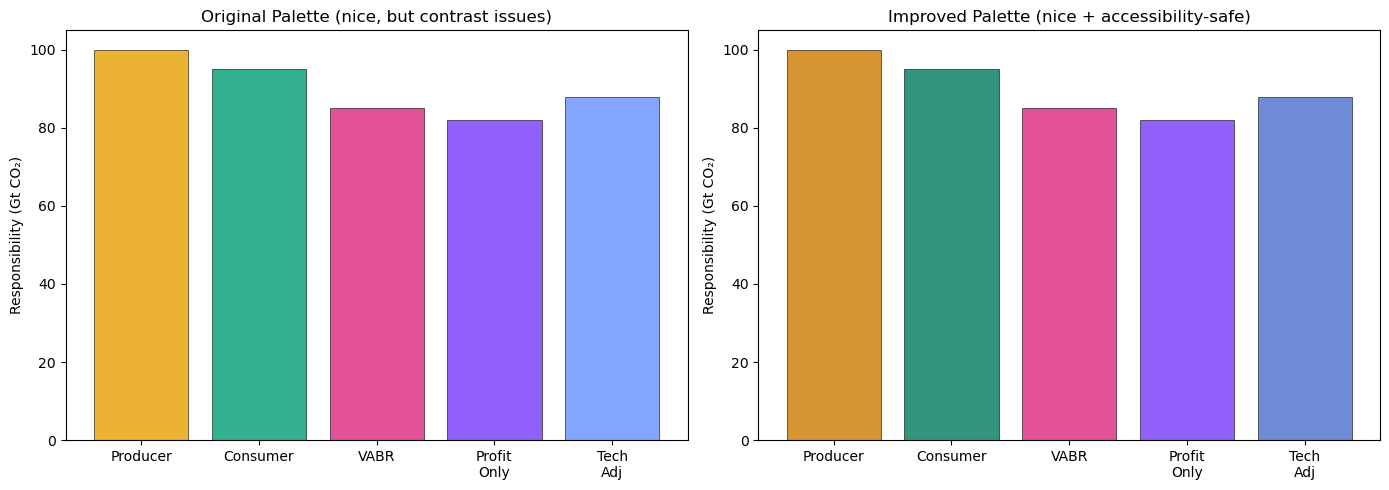

In [40]:
import numpy as np

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Original palette
original = ['#E69F00', '#009E73', '#dc267f', '#7638fa', '#648fff']

# Improved, accessibility-safe palette
improved = ['#CC7A00', '#007A5E', '#dc267f', '#7638fa', '#4A6FCC']

methods = ['Producer', 'Consumer', 'VABR', 'Profit\nOnly', 'Tech\nAdj']
values = [100, 95, 85, 82, 88]

ax1.bar(methods, values, color=original, alpha=0.8, edgecolor='black', linewidth=0.5)
ax1.set_title('Original Palette (nice, but contrast issues)')
ax1.set_ylabel('Responsibility (Gt CO₂)')

ax2.bar(methods, values, color=improved, alpha=0.8, edgecolor='black', linewidth=0.5)
ax2.set_title('Improved Palette (nice + accessibility-safe)')
ax2.set_ylabel('Responsibility (Gt CO₂)')

plt.tight_layout()
plt.show()

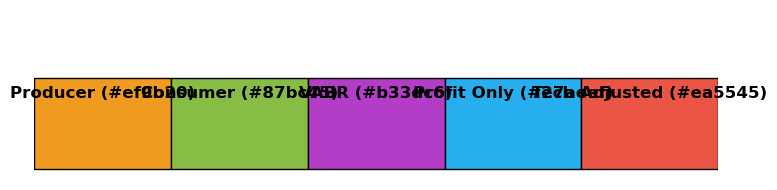

In [41]:
import matplotlib.pyplot as plt

# Define the colors and labels
color_hexes_custom = ['#ef9b20', '#87bc45', '#b33dc6', '#27aeef', '#ea5545']
labels_custom = [
    "Producer (#ef9b20)",
    "Consumer (#87bc45)",
    "VABR (#b33dc6)",
    "Profit Only (#27aeef)",
    "Tech Adjusted (#ea5545)"
]

fig, ax = plt.subplots(figsize=(8, 2))
for i, (hex_code, label) in enumerate(zip(color_hexes_custom, labels_custom)):
    ax.barh(0, 1, left=i, color=hex_code, edgecolor='black')
    ax.text(i + 0.5, 0.2, label, ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

ax.set_xlim(0, len(labels_custom))
ax.set_ylim(-0.5, 1)
ax.axis('off')
plt.tight_layout()
plt.show()

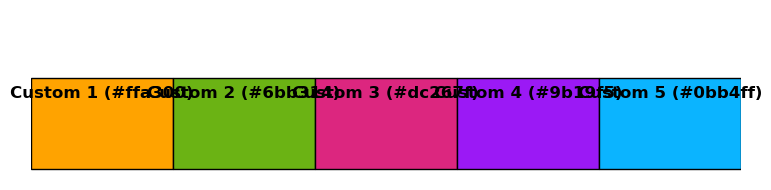

In [42]:
#mein favourite aber claude sagt nicht inklusiv?
import matplotlib.pyplot as plt

# Define the colors and labels
custom_hexes = ["#ffa300", "#6bb314",  "#dc267f", "#9b19f5", "#0bb4ff"]
custom_labels = [
    "Custom 1 (#ffa300)",
    "Custom 2 (#6bb314)",
    "Custom 3 (#dc267f)",
    "Custom 4 (#9b19f5)",
    "Custom 5 (#0bb4ff)"
]

fig, ax = plt.subplots(figsize=(8, 2))
for i, (hex_code, label) in enumerate(zip(custom_hexes, custom_labels)):
    ax.barh(0, 1, left=i, color=hex_code, edgecolor='black')
    ax.text(i + 0.5, 0.2, label, ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

ax.set_xlim(0, len(custom_labels))
ax.set_ylim(-0.5, 1)
ax.axis('off')
plt.tight_layout()
plt.show()

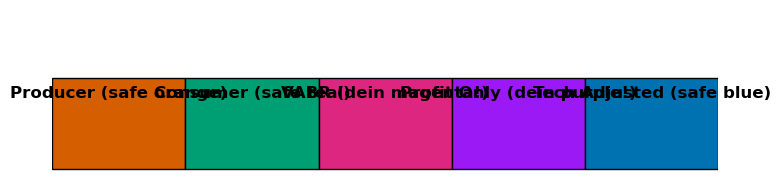

In [43]:
##anscheinend inclusiver

import matplotlib.pyplot as plt

hybrid_hexes = [
    "#D55E00",  # Safe Orange
    "#009E73",  # Safe Teal
    "#dc267f",  # Magenta
    "#9b19f5",  # Purple
    "#0072B2"   # Safe Blue
]

hybrid_labels = [
    "Producer (safe orange)",
    "Consumer (safe teal)",
    "VABR (dein magenta!)", 
    "Profit Only (dein purple!)",
    "Tech Adjusted (safe blue)"
]

fig, ax = plt.subplots(figsize=(8, 2))
for i, (hex_code, label) in enumerate(zip(hybrid_hexes, hybrid_labels)):
    ax.barh(0, 1, left=i, color=hex_code, edgecolor='black')
    ax.text(i + 0.5, 0.2, label, ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

ax.set_xlim(0, len(hybrid_labels))
ax.set_ylim(-0.5, 1)
ax.axis('off')
plt.tight_layout()
plt.show()

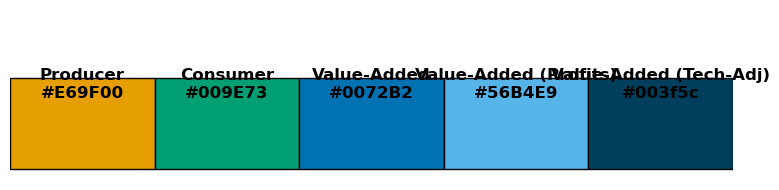

In [44]:
import matplotlib.pyplot as plt

# Use the colors dictionary
color_dict = {
    'Producer': '#E69F00',
    'Consumer': '#009E73',
    'Value-Added': '#0072B2',
    'Value-Added (Profits)': '#56B4E9',
    'Value-Added (Tech-Adj)': '#003f5c'
}

labels = list(color_dict.keys())
hex_codes = list(color_dict.values())

fig, ax = plt.subplots(figsize=(8, 2))
for i, (label, hex_code) in enumerate(zip(labels, hex_codes)):
    ax.barh(0, 1, left=i, color=hex_code, edgecolor='black')
    ax.text(i + 0.5, 0.2, f"{label}\n{hex_code}", ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

ax.set_xlim(0, len(labels))
ax.set_ylim(-0.5, 1)
ax.axis('off')
plt.tight_layout()
plt.show()

SINGLE YEAR ANALYSIS


Analyzing year 2019
----------------------------------------
Data loaded: 49 regions, 163 sectors

Total emissions (million tonnes CO2-eq):
Producer-based: 44715.4
Consumer-based: 44711.9

=== FINAL MASS-CONSERVING VABR CALCULATION ===
Using cleaned value-added coefficients
Mean value-added coefficient: 0.3152
Non-zero VA coefficients: 6462/7987
Calculating consumer responsibility baseline...
Total consumer emissions: 44.712 Gt
Reallocating emissions based on value-added creation...
[VABR] Producer: 44.715 Gt, Consumer: 44.712 Gt, VABR: 44.712 Gt, Error: 0.000000%

=== VABR vs CONSUMER PATTERNS ===
US: Consumer=6.207 Gt, VABR=6.523 Gt
       Ratio=1.051, Change=+0.317 Gt
CN: Consumer=11.819 Gt, VABR=11.458 Gt
       Ratio=0.969, Change=-0.361 Gt
DE: Consumer=0.902 Gt, VABR=1.222 Gt
       Ratio=1.355, Change=+0.320 Gt
JP: Consumer=1.438 Gt, VABR=1.686 Gt
       Ratio=1.173, Change=+0.248 Gt
IN: Consumer=3.174 Gt, VABR=2.904 Gt
       Ratio=0.915, Change=-0.270 Gt
RU: Consumer=1.552 Gt

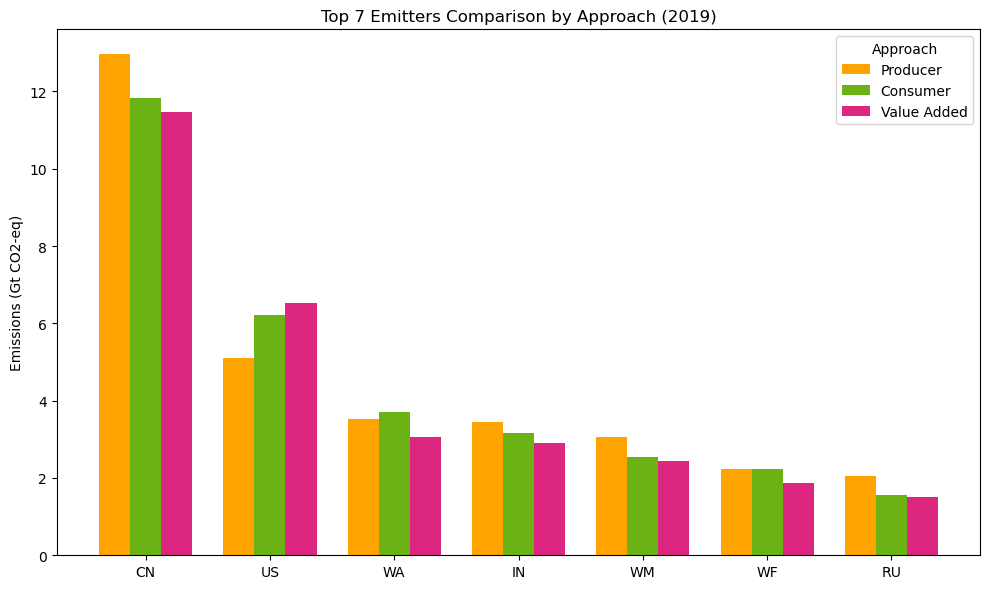

In [45]:
# Analyze single year
results = analyze_single_year(
    year=SINGLE_YEAR,
    exiobase_path=EXIOBASE_PATH,
    emission_categories=EMISSION_CATEGORIES,
    value_added_components=VALUE_ADDED_COMPONENTS,
    verbose=True
)

# Display top emitters - FIXED FOR DICTIONARIES
print(f"\nTop 10 emitters in {SINGLE_YEAR}:")
print("-" * 60)

for approach in ['producer', 'consumer', 'value_added']:
    print(f"\n{approach.upper()} APPROACH:")
    
    # Get the country-level dict and convert to Series
    country_dict = results[f'{approach}_by_country']
    country_series = pd.Series(country_dict)
    
    # Convert to DataFrame for better handling
    country_df = country_series.reset_index()
    country_df.columns = ['country', 'emissions']
    
    # Get top 10
    top10 = country_df.nlargest(30, 'emissions')
    total_emissions = country_series.sum()
    
    for i, row in enumerate(top10.itertuples(), 1):
        emissions_gt = row.emissions / 1e9  # tonnes → gigatonnes
        percentage = (row.emissions / total_emissions) * 100
        print(f"{i:2d}. {row.country}: {emissions_gt:6.2f} Gt ({percentage:4.1f}%)")
        # Only show top 7 countries by total emissions (using the sum of all approaches)
        country_totals = (
            pd.Series(results['producer_by_country']) +
            pd.Series(results['consumer_by_country']) +
            pd.Series(results['value_added_by_country'])
        )
        top_countries = country_totals.nlargest(7).index.tolist()

# Prepare data for grouped bar plot
approaches = ['producer', 'consumer', 'value_added']
emissions_data = []
for approach in approaches:
    country_series = pd.Series(results[f'{approach}_by_country'])
    emissions_data.append(country_series.loc[top_countries].values)

emissions_data = np.array(emissions_data)  # shape: (3, 7)

x = np.arange(len(top_countries))  # label locations
width = 0.25  # width of each bar

# Define colors for each approach
colors = {
    'producer': ["#ffa300"],   # Orange
    'consumer': ["#6bb314"],   # Teal
    'value_added': ["#dc267f"] # Magenta (VABR base)
}

fig, ax = plt.subplots(figsize=(10, 6))
bars = []
for i, approach in enumerate(approaches):
    bars.append(
        ax.bar(
            x + (i - 1) * width,  # center the groups
            emissions_data[i] / 1e9,  # convert to Gt
            width,
            label=approach.replace('_', ' ').title(),
            color=["#ffa300", "#6bb314", "#dc267f"][i]
        )
    )

ax.set_title(f'Top 7 Emitters Comparison by Approach ({SINGLE_YEAR})')
ax.set_ylabel('Emissions (Gt CO2-eq)')
ax.set_xticks(x)
ax.set_xticklabels(top_countries)
ax.legend(title="Approach")
plt.tight_layout()
plt.savefig(RESULTS_PATH / f'top7_emitters_grouped_comparison_{SINGLE_YEAR}.png')
plt.show()

In [46]:
# --- MASS CONSERVATION CHECK ---
producer_total = results['producer_by_country'].sum()
consumer_total = results['consumer_by_country'].sum()
vabr_total = results['value_added_by_country'].sum()

print("\n=== MASS CONSERVATION CHECK ===")
print(f"Producer total: {producer_total/1e9:.6f} Gt CO2-eq")
print(f"Consumer total: {consumer_total/1e9:.6f} Gt CO2-eq")
print(f"VABR total:     {vabr_total/1e9:.6f} Gt CO2-eq")

producer_consumer_diff = abs(producer_total - consumer_total)
consumer_vabr_diff = abs(consumer_total - vabr_total)

print(f"Difference (Producer - Consumer): {producer_consumer_diff/1e6:.2f} Mt")
print(f"Difference (Consumer - VABR):     {consumer_vabr_diff/1e6:.2f} Mt")



=== MASS CONSERVATION CHECK ===
Producer total: 44.715385 Gt CO2-eq
Consumer total: 44.711853 Gt CO2-eq
VABR total:     44.711853 Gt CO2-eq
Difference (Producer - Consumer): 3.53 Mt
Difference (Consumer - VABR):     0.00 Mt


In [47]:
# --- VABR Diagnostic: Check v, t, h, and VA coverage ---
print("\n=== VABR DIAGNOSTIC SUMMARY ===")

# 1. Value-added coefficients (v)
vabr_func = calculate_vabr_mass_conserving_FINAL
ixi = ixi_data
prodem = results['producer_by_sector'].values  # Use the producer emissions vector from results
va_comps = VALUE_ADDED_COMPONENTS
v_diag = v
if hasattr(vabr_func, '__globals__') and 'v' in vabr_func.__globals__:
    v_diag = vabr_func.__globals__['v']
print(f"v (value-added coefficients): min={v_diag.min():.4g}, max={v_diag.max():.4g}, mean={v_diag.mean():.4g}, sum={v_diag.sum():.4g}")

# 2. Total value-added (VA) and output
factor_inputs = ixi.factor_inputs.F
if va_comps:
    VA_diag = factor_inputs.loc[va_comps].sum(axis=0).values
else:
    VA_diag = factor_inputs.sum(axis=0).values
total_output_diag = ixi.x.values.flatten()
va_coverage = VA_diag.sum() / total_output_diag.sum() if total_output_diag.sum() > 0 else float('nan')
print(f"Total VA: {VA_diag.sum():.4g}, Total output: {total_output_diag.sum():.4g}, VA coverage: {va_coverage:.4%}")

# 3. t (consumer responsibility vector) and h (VABR vector)
# Recompute t and h using the latest function for clarity
regions_diag = ixi.get_regions()
B_diag = ixi.L.values
em_int_diag = np.divide(prodem, total_output_diag, out=np.zeros_like(prodem), where=(total_output_diag != 0))
t_diag = np.zeros(len(total_output_diag))
for region in regions_diag:
    region_mask = ixi.Y.columns.get_level_values(0) == region
    y_j = ixi.Y.loc[:, region_mask].sum(axis=1).values
    t_j = em_int_diag * (B_diag @ y_j)
    t_diag += t_j
h_diag = v_diag * t_diag
print(f"t (consumer responsibility): sum={t_diag.sum():.4g}, min={t_diag.min():.4g}, max={t_diag.max():.4g}")
print(f"h (VABR): sum={h_diag.sum():.4g}, min={h_diag.min():.4g}, max={h_diag.max():.4g}")

# 4. Compare sums to producer and consumer totals
print(f"Producer total: {prodem.sum():.4g}")
print(f"Consumer total: {t_diag.sum():.4g}")
print(f"VABR total: {h_diag.sum():.4g}")
print("=== END VABR DIAGNOSTIC ===")



=== VABR DIAGNOSTIC SUMMARY ===
v (value-added coefficients): min=0, max=1.773, mean=0.3153, sum=2519
Total VA: 7.836e+07, Total output: 1.56e+08, VA coverage: 50.2181%
t (consumer responsibility): sum=4.471e+10, min=0, max=4.775e+09
h (VABR): sum=1.51e+10, min=0, max=8.169e+08
Producer total: 4.472e+10
Consumer total: 4.471e+10
VABR total: 1.51e+10
=== END VABR DIAGNOSTIC ===


SECTOR ANALYSIS

In [48]:

print("=== COAL MINING SECTOR ANALYSIS ===")
factor_inputs = ixi_data.factor_inputs.F
x_vector = ixi_data.x.values.flatten()

coal_countries = ['CN', 'US', 'IN', 'RU', 'AU', 'ZA']
coal_sector_name = 'Mining of coal and lignite; extraction of peat'

for country in coal_countries:
    # Find coal sector for this country
    coal_found = False
    for idx, (reg, sec) in enumerate(ixi_data.x.index):
        if reg == country and coal_sector_name in sec:
            total_va = factor_inputs.iloc[:, idx].sum()
            profits = factor_inputs.iloc[8, idx]  # Row 8: profits
            output = x_vector[idx]
            # Get emissions from results['producer_by_sector']
            sector_key = (country, sec)
            emissions = results['producer_by_sector'].get(sector_key, 0)
            
            va_coeff = total_va / output if output > 0 else 0
            profit_coeff = profits / output if output > 0 else 0
            
            print(f"{country} coal mining:")
            print(f"  Total VA: {total_va:,.0f}")
            print(f"  Profits: {profits:,.0f}")
            print(f"  Output: {output:,.0f}")
            print(f"  VA coefficient: {va_coeff:.4f}")
            print(f"  Profit coefficient: {profit_coeff:.4f}")
            print(f"  Emissions: {emissions/1e6:.1f} Mt")
            print()
            coal_found = True
            break
    
    if not coal_found:
        print(f"{country}: Coal mining sector not found")

=== COAL MINING SECTOR ANALYSIS ===
CN coal mining:
  Total VA: 47,657
  Profits: 11,366
  Output: 464,640
  VA coefficient: 0.1026
  Profit coefficient: 0.0245
  Emissions: 808.9 Mt

US coal mining:
  Total VA: 11,980
  Profits: 2,497
  Output: 31,842
  VA coefficient: 0.3762
  Profit coefficient: 0.0784
  Emissions: 62.8 Mt

IN coal mining:
  Total VA: 35,349
  Profits: 6,688
  Output: 50,063
  VA coefficient: 0.7061
  Profit coefficient: 0.1336
  Emissions: 59.6 Mt

RU coal mining:
  Total VA: 2,000
  Profits: 141
  Output: 13,384
  VA coefficient: 0.1495
  Profit coefficient: 0.0105
  Emissions: 80.0 Mt

AU coal mining:
  Total VA: 61,574
  Profits: 15,242
  Output: 87,614
  VA coefficient: 0.7028
  Profit coefficient: 0.1740
  Emissions: 39.8 Mt

ZA coal mining:
  Total VA: 8,886
  Profits: 7,361
  Output: 25,295
  VA coefficient: 0.3513
  Profit coefficient: 0.2910
  Emissions: 46.3 Mt



In [49]:

print("=== VALUE-ADDED COEFFICIENT RANGES ===")
all_va_coeffs = []
for i in range(len(ixi_data.x)):
    total_va = factor_inputs.iloc[:, i].sum()
    output = x_vector[i]
    if output > 0:
        va_coeff = total_va / output
        all_va_coeffs.append(va_coeff)

import numpy as np
print(f"Global VA coefficient statistics:")
print(f"Min: {min(all_va_coeffs):.4f}")
print(f"Max: {max(all_va_coeffs):.4f}") 
print(f"Mean: {np.mean(all_va_coeffs):.4f}")
print(f"Median: {np.median(all_va_coeffs):.4f}")
print(f"75th percentile: {np.percentile(all_va_coeffs, 75):.4f}")
print(f"90th percentile: {np.percentile(all_va_coeffs, 90):.4f}")

=== VALUE-ADDED COEFFICIENT RANGES ===
Global VA coefficient statistics:
Min: -0.0000
Max: 1.7726
Mean: 0.3838
Median: 0.3752
75th percentile: 0.5664
90th percentile: 0.7459


In [50]:
# Find top 3 sectors for WM, RU, NO, CA for profit-based VABR
profit_vabr_by_sector = results['value_added_by_sector']  # This is total VA VABR, not profits-only

# To get profits-only VABR by sector, use the function:
_, profit_vabr_sector_dict, _, _, _ = calculate_vabr_profits_only(
    ixi_data, results['producer_by_sector'].values, None, None
)

for country in ['WM', 'RU', 'NO', 'CA']:
    if country in profit_vabr_sector_dict:
        top_sectors = profit_vabr_sector_dict[country].nlargest(3)
        print(f"\nTop 3 profit-based VABR sectors for {country}:")
        for idx, value in top_sectors.items():
            print(f"  {idx[1]:60s} {value:12,.2f}")
    else:
        print(f"\nNo profit-based VABR data for {country}")


=== VABR CALCULATION (PROFITS ONLY) ===
Mean profit coefficient: 0.0743
Non-zero profit coefficients: 5773/7987
Calculating consumer responsibility baseline...
Total consumer emissions: 44.712 Gt
Reallocating emissions based on profits only...
[VABR PROFITS] Producer: 44.715 Gt, Consumer: 44.712 Gt, VABR: 44.712 Gt, Error: 0.000000%

Top 3 profit-based VABR sectors for WM:
  Extraction of crude petroleum and services related to crude oil extraction, excluding surveying 963,971,823.60
  Real estate activities (70)                                  480,044,217.86
  Health and social work (85)                                  223,061,680.63

Top 3 profit-based VABR sectors for RU:
  Real estate activities (70)                                  534,476,053.83
  Extraction of crude petroleum and services related to crude oil extraction, excluding surveying 280,739,819.54
  Wholesale trade and commission trade, except of motor vehicles and motorcycles (51) 195,643,427.95

Top 3 profit-based V

In [51]:
# Calculate GHG emissions per euro of output for coal mining by country
coal_sector_name = 'Mining of coal and lignite; extraction of peat'
for country in ['CN', 'US', 'IN', 'RU', 'AU', 'ZA']:
    found = False
    for idx, (reg, sec) in enumerate(ixi_data.x.index):
        if reg == country and coal_sector_name in sec:
            output_value = ixi_data.x.values[idx]
            emissions_value = results['producer_by_sector'].get((country, sec), 0)
            va_value = factor_inputs.iloc[:, idx].sum()
            va_coefficient = va_value / output_value if output_value > 0 else 0
            emissions_intensity = emissions_value / output_value if output_value > 0 else 0
            # Ensure scalar values for formatting
            if isinstance(va_coefficient, np.ndarray):
                va_coefficient = va_coefficient.item()
            if isinstance(emissions_intensity, np.ndarray):
                emissions_intensity = emissions_intensity.item()
            print(f"{country}: {emissions_intensity:.2f} tonnes CO2/euro output")
            print(f"  VA coefficient: {va_coefficient:.4f}")
            if va_coefficient > 0:
                print(f"  Emissions per VA: {emissions_intensity/va_coefficient:.2f}")
            else:
                print("  Emissions per VA: n/a")
            found = True
            break
    if not found:
        print(f"{country}: Coal mining sector not found")

CN: 1740.89 tonnes CO2/euro output
  VA coefficient: 0.1026
  Emissions per VA: 16973.27
US: 1973.75 tonnes CO2/euro output
  VA coefficient: 0.3762
  Emissions per VA: 5246.28
IN: 1190.35 tonnes CO2/euro output
  VA coefficient: 0.7061
  Emissions per VA: 1685.85
RU: 5976.92 tonnes CO2/euro output
  VA coefficient: 0.1495
  Emissions per VA: 39991.05
AU: 453.74 tonnes CO2/euro output
  VA coefficient: 0.7028
  Emissions per VA: 645.62
ZA: 1829.55 tonnes CO2/euro output
  VA coefficient: 0.3513
  Emissions per VA: 5207.80


In [52]:
# Compare country totals side-by-side
summary_df = pd.DataFrame({
    'Producer': results['producer_by_country'],
    'Consumer': results['consumer_by_country'],
    'VABR': results['value_added_by_country']
})

# Add per-capita view 
summary_df['PerCapita_VABR'] = summary_df['VABR'] / population_2022

print(summary_df.sort_values('Consumer', ascending=False).head(10))


         Producer       Consumer           VABR  PerCapita_VABR
CN 12960376828.23 11819078487.46 11458484127.87            8.11
US  5100283397.80  6206562885.26  6523391256.53           19.57
WA  3516627110.55  3697511833.64  3067759383.62            2.88
IN  3446504067.79  3173728131.77  2904215610.98            2.04
WM  3059320163.39  2539354555.43  2445280259.36            6.20
WF  2241168143.72  2222577348.52  1881828130.83            1.49
RU  2043395916.94  1551708815.79  1519781487.19           10.54
JP  1020456439.22  1438107465.04  1686396942.04           13.48
WL  1325559672.01  1297418187.67  1250468667.57            3.97
BR  1184149868.59  1058906949.46  1060156419.43            5.04


In [53]:
import pandas as pd

def compare_all_four_approaches(ixi_data, emissions_aggregated_2020, v_clean):
    # 1. Producer responsibility (country-level)
    producer_by_country = pd.Series(results['producer_by_country'])
    # 2. Consumer responsibility (country-level)
    consumer_by_country = pd.Series(results['consumer_by_country'])
    # 3. VABR total value-added (country-level)
    vabr_total, _, _, _, _ = calculate_vabr_mass_conserving_FINAL(ixi_data, emissions_aggregated_2020, None, v_clean)
    # 4. VABR profits only (country-level)
    vabr_profits, _, _, _, _ = calculate_vabr_profits_only(ixi_data, emissions_aggregated_2020, None, None)
    # 5. Create DataFrame
    df = pd.DataFrame({
        'producer': producer_by_country,
        'consumer': consumer_by_country,
        'vabr_total_va': vabr_total,
        'vabr_profits_only': vabr_profits
    })
    # 7. Convert to Gt
    df = df / 1e9
    # 8. Consumer vs producer
    df['consumer_vs_producer'] = df['consumer'] - df['producer']
    # 9. VABR total vs consumer
    df['vabr_total_vs_consumer'] = df['vabr_total_va'] - df['consumer']
    # 10. VABR profits vs consumer
    df['vabr_profits_vs_consumer'] = df['vabr_profits_only'] - df['consumer']
    # 11. Profits vs total VA
    df['profits_vs_total_va'] = df['vabr_profits_only'] - df['vabr_total_va']
    # 12. Sort by producer descending
    df_sorted = df.sort_values('producer', ascending=False)
    # 13. Top 20
    top_20 = df_sorted.head(20)
    # 14. Print main table
    print("=== ALL FOUR APPROACHES COMPARISON - TOP 20 COUNTRIES (Gt CO2eq) ===")
    print(top_20[['producer', 'consumer', 'vabr_total_va', 'vabr_profits_only']].round(3).to_string())
    # 16. Print changes from consumer baseline
    print("\n=== CHANGES FROM CONSUMER BASELINE ===")
    print(top_20[['consumer', 'vabr_total_vs_consumer', 'vabr_profits_vs_consumer', 'profits_vs_total_va']].round(3).to_string())
    # 18. Key patterns
    print(f"\nKEY PATTERNS:")
    print(f"Largest increase under VABR-total: {df_sorted.loc[df_sorted['vabr_total_vs_consumer'].idxmax()].name} (+{df_sorted['vabr_total_vs_consumer'].max():.3f} Gt)")
    print(f"Largest increase under VABR-profits: {df_sorted.loc[df_sorted['vabr_profits_vs_consumer'].idxmax()].name} (+{df_sorted['vabr_profits_vs_consumer'].max():.3f} Gt)")
    print(f"Oil producers (WM, WA, RU) under profits approach:")
    for country in ['WM', 'WA', 'RU']:
        if country in df.index:
            print(f"  {country}: Consumer={df.loc[country, 'consumer']:.3f}, VABR-profits={df.loc[country, 'vabr_profits_only']:.3f} (change: {df.loc[country, 'vabr_profits_vs_consumer']:+.3f})")
    # 23. Return sorted DataFrame
    return df_sorted


In [54]:
compare_all_four_approaches(ixi_data, results['producer_by_sector'].values, v_clean)


=== FINAL MASS-CONSERVING VABR CALCULATION ===
Using cleaned value-added coefficients
Mean value-added coefficient: 0.3152
Non-zero VA coefficients: 6462/7987
Calculating consumer responsibility baseline...
Total consumer emissions: 44.712 Gt
Reallocating emissions based on value-added creation...
[VABR] Producer: 44.715 Gt, Consumer: 44.712 Gt, VABR: 44.712 Gt, Error: 0.000000%

=== VABR vs CONSUMER PATTERNS ===
US: Consumer=6.207 Gt, VABR=6.523 Gt
       Ratio=1.051, Change=+0.317 Gt
CN: Consumer=11.819 Gt, VABR=11.458 Gt
       Ratio=0.969, Change=-0.361 Gt
DE: Consumer=0.902 Gt, VABR=1.222 Gt
       Ratio=1.355, Change=+0.320 Gt
JP: Consumer=1.438 Gt, VABR=1.686 Gt
       Ratio=1.173, Change=+0.248 Gt
IN: Consumer=3.174 Gt, VABR=2.904 Gt
       Ratio=0.915, Change=-0.270 Gt
RU: Consumer=1.552 Gt, VABR=1.520 Gt
       Ratio=0.979, Change=-0.032 Gt

Countries gaining responsibility under VABR: ['US', 'DE', 'JP']
Countries losing responsibility under VABR: ['IN']

=== VABR CALCULATIO

producer  consumer  vabr_total_va  vabr_profits_only  \
CN     12.96     11.82          11.46              11.02   
US      5.10      6.21           6.52               6.33   
WA      3.52      3.70           3.07               2.49   
IN      3.45      3.17           2.90               2.83   
WM      3.06      2.54           2.45               3.15   
..       ...       ...            ...                ...   
EE      0.01      0.01           0.01               0.01   
LV      0.01      0.01           0.02               0.01   
CY      0.01      0.01           0.01               0.01   
LU      0.01      0.01           0.02               0.03   
MT      0.00      0.01           0.01               0.01   

    consumer_vs_producer  vabr_total_vs_consumer  vabr_profits_vs_consumer  \
CN                 -1.14                   -0.36                     -0.80   
US                  1.11                    0.32                      0.12   
WA                  0.18                   -0.63                     -1.21   
IN                 -0.27                   -0.27                     -0.35   
WM                 -0.52                   -0.09                      0.62   
..                   ...                     ...                       ...   
EE                 -0.00                    0.00                      0.00   
LV                  0.00                    0.00                     -0.00   
CY                  0.00                    0.00                      0.00   
LU                  0.01                    0.01                      0.01   
MT                  0.00                    0.00                      0.00   

    profits_vs_total_va  
CN                -0.44  
US                -0.20  
WA                -0.58  
IN                -0.08  
WM                 0.71  
..                  ...  
EE                -0.00  
LV                -0.00  
CY                -0.00  
LU                 0.00  
MT                 0.00  

[49 rows x 8 columns]

HISTORICAL ANALYSIS

In [55]:
def run_time_series_analysis(years, exiobase_path, emission_categories,
                           value_added_components, cache_file=None):
    """
    Run analysis for multiple years with caching support.
    
    Parameters:
    -----------
    years : list
        List of years to analyze
    cache_file : Path, optional
        Path to cache file for saving/loading results
    
    Returns:
    --------
    time_series_results : dict
        Results for all years
    """
    # Check for cached results
    if cache_file and cache_file.exists():
        print(f"Loading cached results from {cache_file}")
        with open(cache_file, 'rb') as f:
            return pickle.load(f)
    
    # Initialize storage
    time_series_results = {
        'years': [],
        'producer_by_country': {},
        'consumer_by_country': {},
        'value_added_by_country': {},
        'global_totals': {'producer': [], 'consumer': [], 'value_added': []},
        'processing_times': []
    }
    
    # Get list of all countries (from first year)
    all_countries = set()
    
    # Run analysis for each year
    for i, year in enumerate(years):
        print(f"\nProcessing year {i+1}/{len(years)}: {year}")
        
        try:
            results = analyze_single_year(
                year=year,
                exiobase_path=exiobase_path,
                emission_categories=emission_categories,
                value_added_components=value_added_components,
                verbose=False
            )
            
            # Store results
            time_series_results['years'].append(year)
            
            # Store country-level data
            for country in results['producer_by_country'].index:
                all_countries.add(country)
                
                for approach in ['producer', 'consumer', 'value_added']:
                    key = f'{approach}_by_country'
                    if country not in time_series_results[key]:
                        time_series_results[key][country] = []
                    
                    time_series_results[key][country].append(
                        results[key].get(country, 0)
                    )
            
            # Store global totals
            for approach in ['producer', 'consumer', 'value_added']:
                total = results[f'{approach}_by_country'].sum()
                time_series_results['global_totals'][approach].append(total)
            
            time_series_results['processing_times'].append(results['processing_time'])
            
            print(f"  Completed in {results['processing_time']:.1f}s")
            
        except Exception as e:
            print(f"  Error processing {year}: {e}")
    
    # Convert to arrays for easier plotting
    for approach in ['producer', 'consumer', 'value_added']:
        key = f'{approach}_by_country'
        for country in time_series_results[key]:
            time_series_results[key][country] = np.array(
                time_series_results[key][country]
            )
    
    # Save cache if requested
    if cache_file:
        print(f"\nSaving results to {cache_file}")
        cache_file.parent.mkdir(exist_ok=True)
        with open(cache_file, 'wb') as f:
            pickle.dump(time_series_results, f)
    
    return time_series_results

In [32]:
# Check if cache exists first
cache_file = RESULTS_PATH / "time_series_cache.pkl"

if cache_file.exists():
    # Load existing data (fast)
    print("Loading cached results...")
    with open(cache_file, 'rb') as f:
        time_series_results = pickle.load(f)
    print("Data loaded from cache - ready for analysis!")
else:
    # Process fresh data (slow - 28 years)
    print("No cache found - processing all years...")
    time_series_results = run_time_series_analysis(
        years=YEARS_TIME_SERIES,
        exiobase_path=EXIOBASE_PATH,
        emission_categories=EMISSION_CATEGORIES,
        value_added_components=VALUE_ADDED_COMPONENTS,
        cache_file=cache_file
    )

No cache found - processing all years...


NameError: name 'run_time_series_analysis' is not defined

PER CAPITA ANALYSIS

In [56]:

def calculate_per_capita_emissions(results, population):
    """Calculate per capita emissions for all approaches."""
    
    per_capita = pd.DataFrame()
    
    for approach in ['producer', 'consumer', 'value_added']:
        country_data = results[f'{approach}_by_country']
        
        # Calculate per capita (tons CO2-eq per person) - data is in kg, convert to tonnes
        per_capita[approach] = (country_data) / population  
        
    # Remove countries with missing population data
    per_capita = per_capita.dropna()
    
    return per_capita

# Calculate per capita (using 2022 population as proxy)
if len(population_2022) > 0:
    per_capita = calculate_per_capita_emissions(results, population_2022)
    
    # Display top per capita emitters for the analyzed year
    print("\nTOP 10 PER CAPITA EMITTERS (analyzed year):")
    for approach in ['producer', 'consumer', 'value_added']:
        print(f"\n{approach.upper()} APPROACH (tons CO2-eq/person):")
        top10 = per_capita[approach].nlargest(10)
        for i, (country, emissions) in enumerate(top10.items(), 1):
            print(f"{i:2d}. {country}: {emissions:6.2f} tonnes CO2-eq/person")
    print("-" * 60)
    
    for approach in ['producer', 'consumer', 'value_added']:
        print(f"\n{approach.upper()} APPROACH (tons CO2-eq/person):")
        top10 = per_capita[approach].nlargest(20)
        for i, (country, emissions) in enumerate(top10.items(), 1):
            print(f"{i:2d}. {country}: {emissions:6.1f} tonnes CO2-eq/person")


TOP 10 PER CAPITA EMITTERS (analyzed year):

PRODUCER APPROACH (tons CO2-eq/person):
 1. AU:  20.98 tonnes CO2-eq/person
 2. CA:  17.18 tonnes CO2-eq/person
 3. US:  15.30 tonnes CO2-eq/person
 4. NO:  14.43 tonnes CO2-eq/person
 5. RU:  14.17 tonnes CO2-eq/person
 6. GR:  13.03 tonnes CO2-eq/person
 7. TW:  12.87 tonnes CO2-eq/person
 8. DK:  12.77 tonnes CO2-eq/person
 9. KR:  12.67 tonnes CO2-eq/person
10. FI:  12.15 tonnes CO2-eq/person

CONSUMER APPROACH (tons CO2-eq/person):
 1. LU:  22.65 tonnes CO2-eq/person
 2. CH:  19.15 tonnes CO2-eq/person
 3. IE:  18.76 tonnes CO2-eq/person
 4. US:  18.62 tonnes CO2-eq/person
 5. AU:  17.79 tonnes CO2-eq/person
 6. KR:  16.08 tonnes CO2-eq/person
 7. NO:  14.59 tonnes CO2-eq/person
 8. CA:  14.02 tonnes CO2-eq/person
 9. NL:  13.72 tonnes CO2-eq/person
10. BE:  12.90 tonnes CO2-eq/person

VALUE_ADDED APPROACH (tons CO2-eq/person):
 1. LU:  36.19 tonnes CO2-eq/person
 2. IE:  26.70 tonnes CO2-eq/person
 3. CH:  26.30 tonnes CO2-eq/person
 

RESULTS FOR THESIS

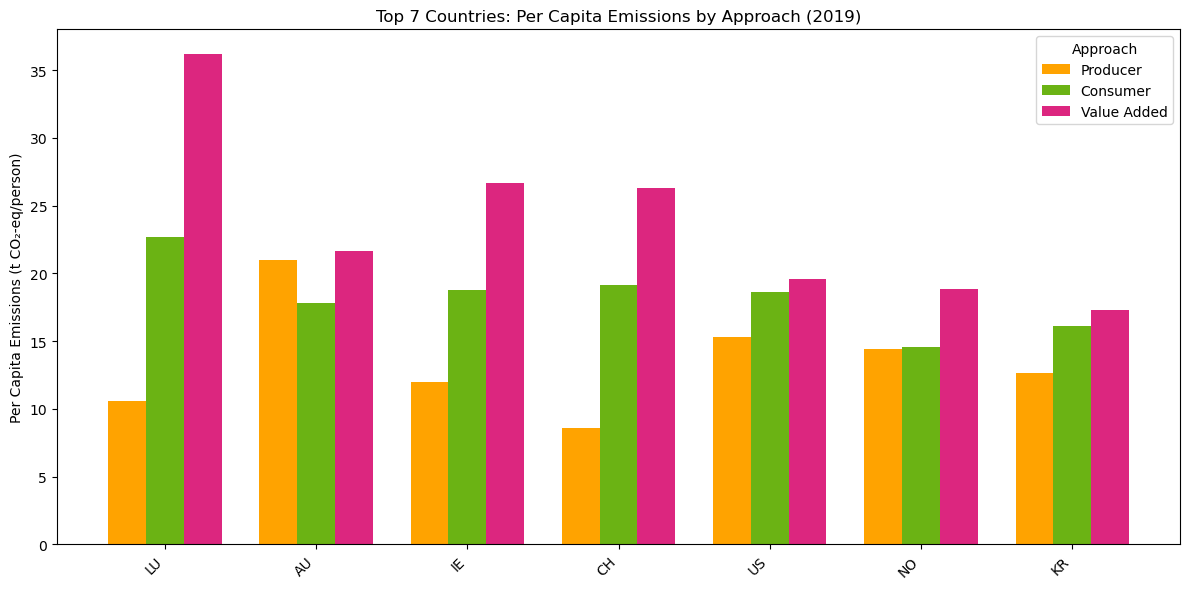

In [57]:
# Grouped barplot: Top 10 countries by per capita emissions (sum of all approaches)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Calculate per capita emissions for each approach
per_capita = pd.DataFrame()
for approach in ['producer', 'consumer', 'value_added']:
    country_series = pd.Series(results[f'{approach}_by_country'])
    per_capita[approach] = country_series / population_2022

# Get top 7 countries by total per capita emissions (sum of all approaches)
per_capita['total'] = per_capita.sum(axis=1)
top7_countries_pc = per_capita['total'].nlargest(7).index.tolist()

# Prepare data for plotting
approaches = ['producer', 'consumer', 'value_added']
approach_labels = ['Producer', 'Consumer', 'Value Added']
colors = ["#ffa300", "#6bb314",  "#dc267f"]
emissions_data_pc = []
for approach in approaches:
    emissions_data_pc.append(per_capita.loc[top7_countries_pc, approach].values)

emissions_data_pc = np.array(emissions_data_pc)  # shape: (3, 7)
x = np.arange(len(top7_countries_pc))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
for i, (label, color) in enumerate(zip(approach_labels, colors)):
    ax.bar(x + (i - 1) * width, emissions_data_pc[i], width, label=label, color=color)

ax.set_title('Top 7 Countries: Per Capita Emissions by Approach (2019)')
ax.set_ylabel('Per Capita Emissions (t CO₂-eq/person)')
ax.set_xticks(x)
ax.set_xticklabels(top7_countries_pc, rotation=45, ha='right')  # <-- Fix: rotate and align labels
ax.legend(title="Approach")
plt.tight_layout()
plt.show()

SENSITIVITY ANALYSIS TO SEE IF IT MAKES SENSE TO EXCLUDE FACTOR INPUT ABOUT TAXES

In [58]:
# SENSITIVITY ANALYSIS (here we saw no difference)

# With taxes
vabr_with_taxes = calculate_vabr_mass_conserving_FINAL(
    ixi_data, results['producer_by_sector'].values, VALUE_ADDED_COMPONENTS, v_override=None
)

# Without taxes (use the function that forcibly excludes taxes)
vabr_without_taxes = calculate_vabr_excluding_taxes(
    ixi_data, results['producer_by_sector'].values, VALUE_ADDED_COMPONENTS, v_override=None
)

diff_country = vabr_without_taxes[0] - vabr_with_taxes[0]

print("VABR Sensitivity Analysis Complete.")
print("Countries with/without taxes (first 5):")
print("Without taxes:", vabr_without_taxes[0].head())
print("With taxes:   ", vabr_with_taxes[0].head())
print("Difference:   ", diff_country.head())


=== FINAL MASS-CONSERVING VABR CALCULATION ===
Mean value-added coefficient: 0.3153
Non-zero VA coefficients: 6462/7987
Calculating consumer responsibility baseline...
Total consumer emissions: 44.712 Gt
Reallocating emissions based on value-added creation...
[VABR] Producer: 44.715 Gt, Consumer: 44.712 Gt, VABR: 44.712 Gt, Error: 0.000000%

=== VABR vs CONSUMER PATTERNS ===
US: Consumer=6.207 Gt, VABR=6.523 Gt
       Ratio=1.051, Change=+0.317 Gt
CN: Consumer=11.819 Gt, VABR=11.458 Gt
       Ratio=0.969, Change=-0.361 Gt
DE: Consumer=0.902 Gt, VABR=1.222 Gt
       Ratio=1.355, Change=+0.320 Gt
JP: Consumer=1.438 Gt, VABR=1.686 Gt
       Ratio=1.173, Change=+0.248 Gt
IN: Consumer=3.174 Gt, VABR=2.904 Gt
       Ratio=0.915, Change=-0.270 Gt
RU: Consumer=1.552 Gt, VABR=1.520 Gt
       Ratio=0.979, Change=-0.032 Gt

Countries gaining responsibility under VABR: ['US', 'DE', 'JP']
Countries losing responsibility under VABR: ['IN']

=== VABR CALCULATION (EXCLUDING TAXES) ===
Excluding taxes

In [59]:
taxes_row = "Taxes less subsidies on products purchased: Total"
factor_inputs = ixi_data.factor_inputs.F
taxes_by_country = factor_inputs.loc[taxes_row].groupby(ixi_data.x.index.get_level_values(0)).sum()
va_by_country = factor_inputs.loc[VALUE_ADDED_COMPONENTS].sum(axis=0).groupby(ixi_data.x.index.get_level_values(0)).sum()
share_taxes = taxes_by_country / va_by_country
print("Top 10 countries by taxes row sum:")
print(taxes_by_country.sort_values(ascending=False).head(10))
print("\nTop 10 countries by share of taxes in VA:")
print(share_taxes.sort_values(ascending=False).head(10))

Top 10 countries by taxes row sum:
region
US   264160.40
GB   124218.46
DE    94936.20
RU    94719.44
FR    73021.18
BR    71029.63
IN    64635.40
IE    51764.84
IT    49206.36
KR    47483.21
Name: Taxes less subsidies on products purchased: Total, dtype: float64

Top 10 countries by share of taxes in VA:
region
BG   0.17
IE   0.15
LV   0.13
EE   0.12
SI   0.08
HR   0.07
CY   0.07
CZ   0.07
ZA   0.06
RU   0.06
dtype: float64


In [60]:
taxes_row = "Taxes less subsidies on products purchased: Total"
factor_inputs = ixi_data.factor_inputs.F
if taxes_row in factor_inputs.index:
    print("Taxes row sum:", factor_inputs.loc[taxes_row].sum())
    print("Taxes row (first 10):", factor_inputs.loc[taxes_row].values[:10])
else:
    print("Taxes row is missing from factor_inputs!")

Taxes row sum: 1339603.2192898102
Taxes row (first 10): [0.00000000e+00 1.74400618e+00 3.24011012e-01 7.65107014e-01
 7.07685529e-02 5.09988523e-02 8.96732298e-05 5.38474753e-02
 6.43762857e+00 2.44281005e+01]


In [61]:
# Compare total VA with and without taxes
taxes_row = "Taxes less subsidies on products purchased: Total"
factor_inputs = ixi_data.factor_inputs.F
va_with = factor_inputs.loc[VALUE_ADDED_COMPONENTS].sum(axis=0)
va_wo = factor_inputs.loc[[c for c in VALUE_ADDED_COMPONENTS if c != taxes_row]].sum(axis=0)
print("Total VA with taxes:", va_with.sum())
print("Total VA without taxes:", va_wo.sum())
print("Total taxes row sum:", factor_inputs.loc[taxes_row].sum())
print("Share of taxes in total VA: {:.4%}".format(factor_inputs.loc[taxes_row].sum() / va_with.sum()))

Total VA with taxes: 78364220.01966771
Total VA without taxes: 77024616.8003779
Total taxes row sum: 1339603.2192898102
Share of taxes in total VA: 1.7095%


In [62]:
country = 'GB'  # or 'US', etc.
sector_mask = ixi_data.x.index.get_level_values(0) == country
va_with = factor_inputs.loc[VALUE_ADDED_COMPONENTS].sum(axis=0)[sector_mask]
va_wo = factor_inputs.loc[[c for c in VALUE_ADDED_COMPONENTS if c != taxes_row]].sum(axis=0)[sector_mask]
print(f"VA with taxes for {country} (sum):", va_with.sum())
print(f"VA without taxes for {country} (sum):", va_wo.sum())
print(f"Difference for {country}:", va_with.sum() - va_wo.sum())

VA with taxes for GB (sum): 2552083.830244555
VA without taxes for GB (sum): 2427865.3717848575
Difference for GB: 124218.45845969766


SECTORAL ANALYSIS

In [63]:
def analyze_sectors_global(results):
    """Analyze emissions by sector globally."""

    # Get sector names from first country's data
    first_country = list(results['consumer_by_sector'].keys())[0]
    sectors_index = results['consumer_by_sector'][first_country].index

    # Aggregate across all countries
    producer_by_sector = results['producer_by_sector'].copy()

    # For consumer and value-added, sum across countries (align indices)
    consumer_by_sector_global = pd.Series(0, index=sectors_index)
    va_by_sector_global = pd.Series(0, index=sectors_index)

    for country in results['consumer_by_sector']:
        consumer_by_sector_global = consumer_by_sector_global.add(results['consumer_by_sector'][country], fill_value=0)
        va_by_sector_global = va_by_sector_global.add(results['value_added_by_sector'][country], fill_value=0)

    # Create sector comparison dataframe
    sector_comparison = pd.DataFrame({
        'Producer': producer_by_sector,
        'Consumer': consumer_by_sector_global,
        'Value_Added': va_by_sector_global
    })

    # Add sector names for clarity
    sector_comparison['Country'] = [idx[0] for idx in sector_comparison.index]
    sector_comparison['Sector'] = [idx[1] for idx in sector_comparison.index]

    return sector_comparison


sector analysis 2.0

In [64]:

def analyze_specific_countries_sectors(results, countries_list):
    """
    Analyze sector-level emissions for specific countries.
    Uses your existing results structure from analyze_single_year.
    """
    
    country_sector_data = {}
    
    # Get available countries from your data
    # Your results use dictionaries, so we check keys
    available_countries = set(results['producer_by_country'].keys())
    countries_to_analyze = [c for c in countries_list if c in available_countries]
    
    print(f"Analyzing sectors for: {countries_to_analyze}")
    missing = [c for c in countries_list if c not in available_countries]
    if missing:
        print(f"Countries not found: {missing}")
    
    # For each country, get sector-level data
    for country in countries_to_analyze:
        country_data = {}
        
        # Producer emissions by sector (from your producer_by_sector Series)
        producer_mask = results['producer_by_sector'].index.get_level_values(0) == country
        country_data['producer'] = results['producer_by_sector'][producer_mask]
        
        # Consumer emissions by sector (from your dictionaries)
        if country in results['consumer_by_sector']:
            country_data['consumer'] = results['consumer_by_sector'][country]
        
        # VABR emissions by sector (from your dictionaries)
        if country in results['value_added_by_sector']:
            country_data['vabr'] = results['value_added_by_sector'][country]
        
        country_sector_data[country] = country_data
    
    return country_sector_data, countries_to_analyze

In [65]:
# Using your exact variable names
countries_of_interest = ['CN', 'DE', 'DK', 'LU', 'CH', 'US']

# This uses your results from the notebook
sector_data, analyzed_countries = analyze_specific_countries_sectors(
    results,  # Your existing results variable
    countries_of_interest
)

print(f"\nSuccessfully analyzed {len(analyzed_countries)} countries")

Analyzing sectors for: ['CN', 'DE', 'DK', 'LU', 'CH', 'US']

Successfully analyzed 6 countries


In [66]:
def display_top_sectors_by_country(sector_data, top_n=10):
    """
    Display top emitting sectors for each country and method.
    
    Parameters:
    -----------
    sector_data : dict
        Dictionary with sector data for each country
    top_n : int
        Number of top sectors to show
    """
    
    for country in sector_data:
        print(f"\n{'='*80}")
        print(f"SECTOR ANALYSIS FOR {country}")
        print(f"{'='*80}")
        
        # Get data for this country
        country_data = sector_data[country]
        
        # Show top sectors for each method
        for method in ['producer', 'consumer', 'vabr']:
            if method in country_data:
                print(f"\n{method.upper()} METHOD - Top {top_n} sectors:")
                print("-" * 60)
                
                # Get top sectors
                top_sectors = country_data[method].nlargest(top_n)
                
                # Display them
                for i, (sector_idx, emissions) in enumerate(top_sectors.items(), 1):
                    sector_name = sector_idx[1] if len(sector_idx) > 1 else sector_idx
                    emissions_mt = emissions / 1e6  # Convert to million tonnes
                    print(f"{i:2d}. {sector_name[:50]:50s} {emissions_mt:8.1f} Mt")

In [67]:
def compare_sector_across_countries(sector_data, sector_name):
    """
    Compare emissions for a specific sector across all analyzed countries.
    
    Parameters:
    -----------
    sector_data : dict
        Dictionary with sector data for each country
    sector_name : str
        Name of the sector to compare (partial match allowed)
    """
    
    # Create comparison dataframe
    comparison_data = []
    
    for country in sector_data:
        country_data = sector_data[country]
        
        # Find matching sectors
        for method in ['producer', 'consumer', 'vabr']:
            if method in country_data:
                # Get all sectors for this country
                sectors = country_data[method]
                
                # Find sectors matching the name
                matching_sectors = [
                    (idx, val) for idx, val in sectors.items() 
                    if sector_name.lower() in str(idx).lower()
                ]
                
                if matching_sectors:
                    # Take the first match
                    sector_idx, emissions = matching_sectors[0]
                    comparison_data.append({
                        'Country': country,
                        'Method': method,
                        'Emissions_Mt': emissions / 1e6
                    })
    
    # Convert to DataFrame for easy viewing
    comparison_df = pd.DataFrame(comparison_data)
    
    # Pivot for better readability
    if not comparison_df.empty:
        pivot_df = comparison_df.pivot(
            index='Country', 
            columns='Method', 
            values='Emissions_Mt'
        )
        return pivot_df
    else:
        print(f"No sectors found matching '{sector_name}'")
        return None

In [68]:
# Run the sector analysis
print("Starting sector analysis for selected countries...")

# 1. Get sector data
sector_data, analyzed_countries = analyze_specific_countries_sectors(
    results, 
    countries_of_interest
)

# 2. Display top sectors for each country
display_top_sectors_by_country(sector_data, top_n=5)

# 3. Compare electricity production across countries
print("\n" + "="*80)
print("COMPARISON: Electricity production by coal across countries")
print("="*80)

electricity_comparison = compare_sector_across_countries(
    sector_data, 
    "electricity by coal"
)

if electricity_comparison is not None:
    print(electricity_comparison)
    
    # Calculate ratios
    print("\nVABR/Consumer ratios:")
    if 'vabr' in electricity_comparison.columns and 'consumer' in electricity_comparison.columns:
        ratios = electricity_comparison['vabr'] / electricity_comparison['consumer']
        print(ratios)

Starting sector analysis for selected countries...
Analyzing sectors for: ['CN', 'DE', 'DK', 'LU', 'CH', 'US']

SECTOR ANALYSIS FOR CN

PRODUCER METHOD - Top 5 sectors:
------------------------------------------------------------
 1. Production of electricity by coal                    4774.7 Mt
 2. Manufacture of basic iron and steel and of ferro-a   1234.8 Mt
 3. Manufacture of cement, lime and plaster              1054.7 Mt
 4. Mining of coal and lignite; extraction of peat (10    808.9 Mt
 5. Landfill of waste: Food                               346.4 Mt

CONSUMER METHOD - Top 5 sectors:
------------------------------------------------------------
 1. Production of electricity by coal                    3571.4 Mt
 2. Manufacture of cement, lime and plaster              1008.7 Mt
 3. Manufacture of basic iron and steel and of ferro-a    797.0 Mt
 4. Mining of coal and lignite; extraction of peat (10    624.1 Mt
 5. Landfill of waste: Food                               304.9 Mt

VABR

In [69]:
# Check Switzerland's sea transport emissions in detail
def investigate_ch_shipping(results):
    """
    Investigate the suspicious Swiss shipping emissions
    """
    
    # Find all sea transport entries for Switzerland
    producer_data = results['producer_by_sector']
    
    # Get Switzerland sea transport
    ch_mask = producer_data.index.get_level_values(0) == 'CH'
    ch_sectors = producer_data[ch_mask]
    
    # Find sea transport sectors
    sea_transport = ch_sectors[ch_sectors.index.get_level_values(1).str.contains('Sea', case=False)]
    
    print("Switzerland Sea Transport Emissions:")
    for idx, value in sea_transport.items():
        print(f"{idx[1]}: {value/1e6:.1f} Mt")
    
    # Compare with other landlocked countries
    print("\nComparison with other landlocked countries:")
    landlocked = ['AT', 'CZ', 'HU', 'SK']  # Austria, Czech, Hungary, Slovakia
    
    for country in landlocked:
        country_mask = producer_data.index.get_level_values(0) == country
        country_sea = producer_data[country_mask & producer_data.index.get_level_values(1).str.contains('Sea', case=False)]
        if not country_sea.empty:
            total = country_sea.sum() / 1e6
            print(f"{country}: {total:.1f} Mt")

# Run the investigation
investigate_ch_shipping(results)


Switzerland Sea Transport Emissions:
Sea and coastal water transport: 38.3 Mt
Research and development (73): 0.2 Mt

Comparison with other landlocked countries:
AT: 0.1 Mt
CZ: 0.7 Mt
HU: 0.0 Mt
SK: 0.0 Mt


<!-- (Removed VABR Debugging Cells summary. The notebook now uses the correct, mass-conserving VABR method.) -->

In [70]:
# Compare producer vs consumer for sea transport
def compare_sea_transport_allocation(results, country='CH'):
    """
    Compare how sea transport is allocated across methods
    """
    
    producer_sector = results['producer_by_sector']
    
    # Get sea transport for this country
    mask = (producer_sector.index.get_level_values(0) == country) & \
           (producer_sector.index.get_level_values(1).str.contains('Sea', case=False))
    
    producer_sea = producer_sector[mask].sum() / 1e6
    
    # Consumer allocation
    if country in results['consumer_by_sector']:
        consumer_data = results['consumer_by_sector'][country]
        consumer_sea = consumer_data[consumer_data.index.get_level_values(1).str.contains('Sea', case=False)].sum() / 1e6
    else:
        consumer_sea = 0
    
    print(f"\nSea transport emissions for {country}:")
    print(f"Producer: {producer_sea:.1f} Mt")
    print(f"Consumer: {consumer_sea:.1f} Mt")
    print(f"Ratio: {consumer_sea/producer_sea:.2f}")

compare_sea_transport_allocation(results, 'CH')


Sea transport emissions for CH:
Producer: 38.5 Mt
Consumer: 20.8 Mt
Ratio: 0.54


In [71]:
def run_all_vabr_variants_clean():
    '''
    Clean comparison of VABR variants - country totals only, no extra output.
    '''
    
    # Run all methods silently
    baseline_results = calculate_vabr_mass_conserving_FINAL(ixi_data, results['producer_by_sector'].values, VALUE_ADDED_COMPONENTS, v_override=None)
    no_taxes_results = calculate_vabr_excluding_taxes(ixi_data, results['producer_by_sector'].values, VALUE_ADDED_COMPONENTS, v_override=None)
    profits_only_results = calculate_vabr_profits_only(ixi_data, results['producer_by_sector'].values, VALUE_ADDED_COMPONENTS, v_override=None)
    no_transport_results = calculate_vabr_exclude_maritime_aviation(ixi_data, results['producer_by_sector'].values, VALUE_ADDED_COMPONENTS, v_override=None)

    # Extract country totals (first element of each result)
    baseline_country = baseline_results[0]
    no_taxes_country = no_taxes_results[0]
    profits_country = profits_only_results[0]
    
    # Handle transport results (might be in dict format)
    if isinstance(no_transport_results, dict):
        no_transport_country = no_transport_results['vabr_no_maritime_aviation'][0]
    else:
        no_transport_country = no_transport_results[0]
    
    # Create clean comparison DataFrame
    comparison_df = pd.DataFrame({
        'Country': baseline_country.index,
        'Baseline': baseline_country.values,
        'No_Taxes': no_taxes_country.values,
        'Profits_Only': profits_country.values,
        'No_Transport': no_transport_country.values
    })
    
    # Calculate percentage differences from baseline
    comparison_df['No_Taxes_%'] = ((comparison_df['No_Taxes'] - comparison_df['Baseline']) / comparison_df['Baseline'] * 100).round(1)
    comparison_df['Profits_%'] = ((comparison_df['Profits_Only'] - comparison_df['Baseline']) / comparison_df['Baseline'] * 100).round(1)
    comparison_df['Transport_%'] = ((comparison_df['No_Transport'] - comparison_df['Baseline']) / comparison_df['Baseline'] * 100).round(1)
    
    # Sort by baseline responsibility (highest first)
    comparison_df = comparison_df.sort_values('Baseline', ascending=False)
    
    return comparison_df

RESULTS FOR THESIS

In [72]:
import geopandas as gpd
import pandas as pd

# 1. ZUERST: Lade die Shapefile und schaue, welche SOV_A3 codes sie hat
world = gpd.read_file(r'C:/Users/Marine Riesterer/OneDrive/Desktop/MA Arbeit/results/geodata/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')

# 2. Schaue dir die EXIOBASE Länder an
exiobase_countries = ['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 
                      'FR', 'GR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'MT', 
                      'NL', 'PL', 'PT', 'RO', 'SE', 'SI', 'SK', 'GB', 'US', 'JP', 
                      'CN', 'CA', 'KR', 'BR', 'IN', 'MX', 'RU', 'AU', 'CH', 'TR', 
                      'TW', 'NO', 'ID', 'ZA']

# 3. Finde die korrekten SOV_A3 codes für jedes EXIOBASE Land
print("=== KORREKTE MAPPING TABELLE ===")
print("EXIOBASE -> Shapefile SOV_A3")
print("-" * 40)

mapping_dict = {}
for exio_code in exiobase_countries:
    # Suche nach verschiedenen Möglichkeiten
    possible_names = {
        'US': ['United States', 'USA'],
        'CN': ['China'],
        'GB': ['United Kingdom'],
        'KR': ['South Korea', 'Korea'],
        'AU': ['Australia'],
        'CH': ['Switzerland'],
        'TR': ['Turkey'],
        'TW': ['Taiwan'],
        'NO': ['Norway'],
        'ID': ['Indonesia'],
        'ZA': ['South Africa'],
        'AT': ['Austria'],
        'BE': ['Belgium'],
        'BG': ['Bulgaria'],
        'CY': ['Cyprus'],
        'CZ': ['Czech', 'Czechia'],
        'DE': ['Germany'],
        'DK': ['Denmark'],
        'EE': ['Estonia'],
        'ES': ['Spain'],
        'FI': ['Finland'],
        'FR': ['France'],
        'GR': ['Greece'],
        'HR': ['Croatia'],
        'HU': ['Hungary'],
        'IE': ['Ireland'],
        'IT': ['Italy'],
        'LT': ['Lithuania'],
        'LU': ['Luxembourg'],
        'LV': ['Latvia'],
        'MT': ['Malta'],
        'NL': ['Netherlands'],
        'PL': ['Poland'],
        'PT': ['Portugal'],
        'RO': ['Romania'],
        'SE': ['Sweden'],
        'SI': ['Slovenia'],
        'SK': ['Slovakia'],
        'JP': ['Japan'],
        'CA': ['Canada'],
        'BR': ['Brazil'],
        'IN': ['India'],
        'MX': ['Mexico'],
        'RU': ['Russia']
    }
    
    found = False
    for name in possible_names.get(exio_code, [exio_code]):
        matches = world[world['NAME'].str.contains(name, case=False, na=False)]
        if not matches.empty:
            sov_a3 = matches.iloc[0]['SOV_A3']
            mapping_dict[exio_code] = sov_a3
            print(f"{exio_code} -> {sov_a3} (Name: {matches.iloc[0]['NAME']})")
            found = True
            break
    
    if not found:
        # Try with ISO codes
        matches = world[world['ISO_A2'] == exio_code]
        if not matches.empty:
            sov_a3 = matches.iloc[0]['SOV_A3']
            mapping_dict[exio_code] = sov_a3
            print(f"{exio_code} -> {sov_a3} (via ISO_A2)")
        else:
            print(f"{exio_code} -> ??? NOT FOUND")

# 4. Speichere das korrekte Mapping
print("\n=== PYTHON DICTIONARY ===")
print("exiobase_to_shapefile = {")
for k, v in mapping_dict.items():
    print(f"    '{k}': '{v}',")
print("}")

# 5. Überprüfe spezielle Fälle
print("\n=== SPEZIELLE FÄLLE ===")
special_cases = ['United States', 'China', 'Australia', 'United Kingdom', 'South Korea']
for country in special_cases:
    matches = world[world['NAME'].str.contains(country, case=False, na=False)]
    if not matches.empty:
        print(f"{country}:")
        print(f"  SOV_A3: {matches.iloc[0]['SOV_A3']}")
        print(f"  ISO_A3: {matches.iloc[0]['ISO_A3']}")
        print(f"  ISO_A2: {matches.iloc[0]['ISO_A2']}")

=== KORREKTE MAPPING TABELLE ===
EXIOBASE -> Shapefile SOV_A3
----------------------------------------
AT -> AUT (Name: Austria)
BE -> BEL (Name: Belgium)
BG -> BGR (Name: Bulgaria)
CY -> CYN (Name: N. Cyprus)
CZ -> CZE (Name: Czechia)
DE -> DEU (Name: Germany)
DK -> DN1 (Name: Denmark)
EE -> EST (Name: Estonia)
ES -> ESP (Name: Spain)
FI -> FI1 (Name: Finland)
FR -> FR1 (Name: France)
GR -> GRC (Name: Greece)
HR -> HRV (Name: Croatia)
HU -> HUN (Name: Hungary)
IE -> IRL (Name: Ireland)
IT -> ITA (Name: Italy)
LT -> LTU (Name: Lithuania)
LU -> LUX (Name: Luxembourg)
LV -> LVA (Name: Latvia)
MT -> ??? NOT FOUND
NL -> NL1 (Name: Netherlands)
PL -> POL (Name: Poland)
PT -> PRT (Name: Portugal)
RO -> ROU (Name: Romania)
SE -> SWE (Name: Sweden)
SI -> SVN (Name: Slovenia)
SK -> SVK (Name: Slovakia)
GB -> GB1 (Name: United Kingdom)
US -> US1 (Name: United States of America)
JP -> JPN (Name: Japan)
CN -> CH1 (Name: China)
CA -> CAN (Name: Canada)
KR -> KOR (Name: South Korea)
BR -> BRA (Name:

Created 165 country entries for mapping

=== VERIFICATION ===
Total countries with data: 158
USA (US1) has data: True
China (CH1) has data: True
UK (GB1) has data: True
Australia (AU1) has data: True


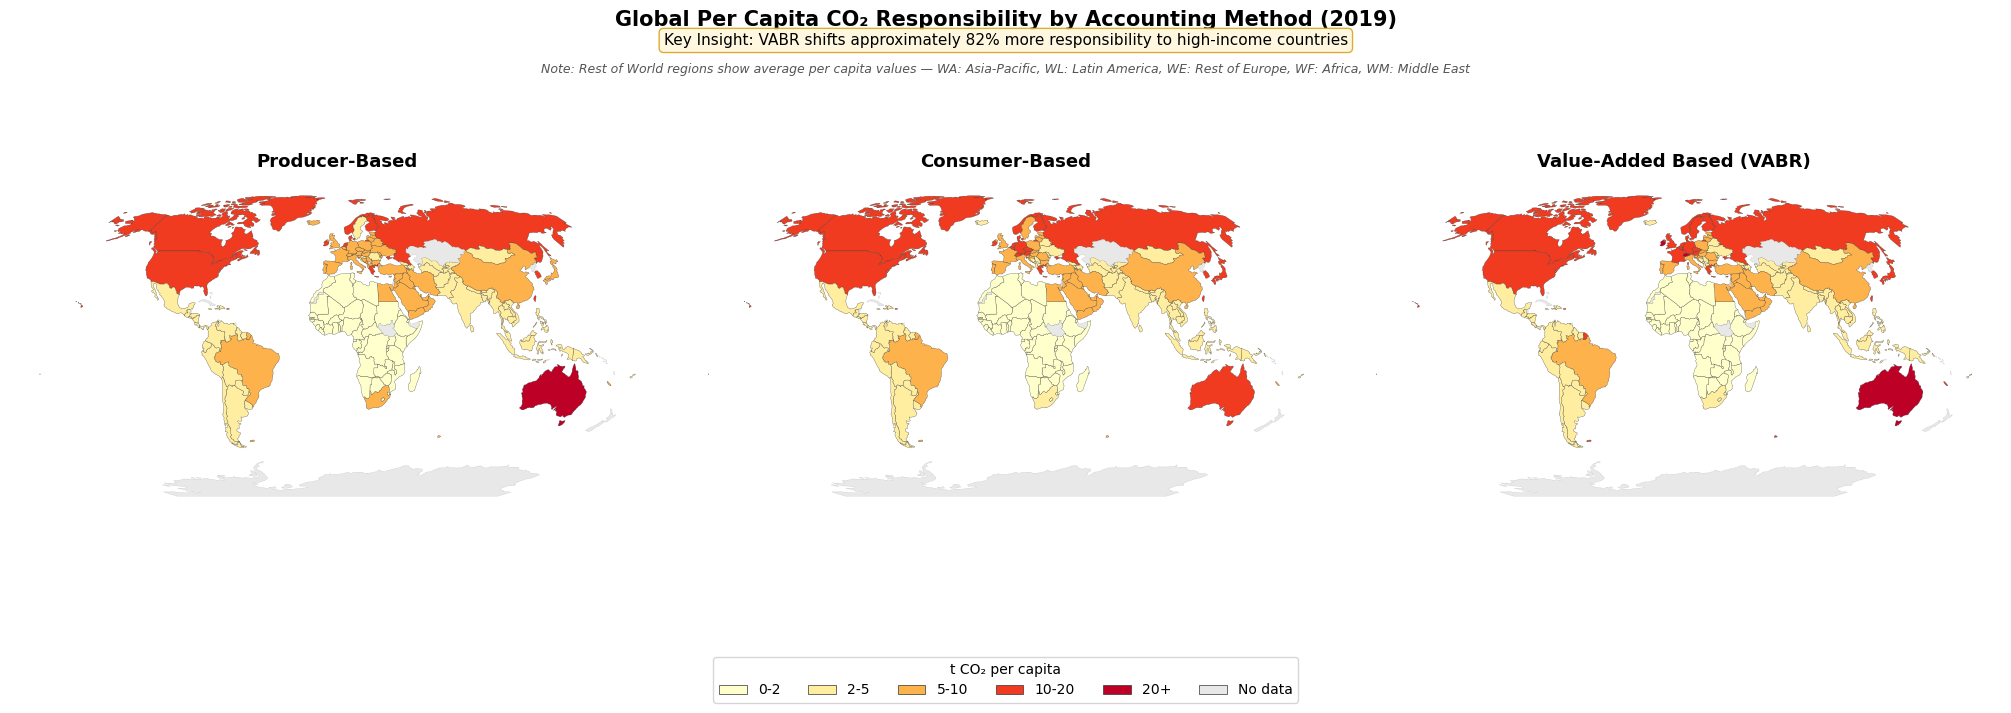

In [73]:
import geopandas as gpd
import pandas as pd
import numpy as np
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Ensure ISO_A3 column exists
per_capita = per_capita.copy()
per_capita.index.name = 'ISO_A3'
if 'ISO_A3' not in per_capita.columns:
    per_capita.reset_index(inplace=True)

# --- KORREKTE MAPPING basierend auf deiner Shapefile ---
exiobase_to_shapefile = {
    'AT': 'AUT',
    'BE': 'BEL',
    'BG': 'BGR',
    'CY': 'CYN',  # North Cyprus
    'CZ': 'CZE',
    'DE': 'DEU',
    'DK': 'DN1',  # Denmark special code
    'EE': 'EST',
    'ES': 'ESP',
    'FI': 'FI1',  # Finland special code
    'FR': 'FR1',  # France special code
    'GR': 'GRC',
    'HR': 'HRV',
    'HU': 'HUN',
    'IE': 'IRL',
    'IT': 'ITA',
    'LT': 'LTU',
    'LU': 'LUX',
    'LV': 'LVA',
    'MT': 'MLT',  # Assuming Malta is MLT - verify this
    'NL': 'NL1',  # Netherlands special code
    'PL': 'POL',
    'PT': 'PRT',
    'RO': 'ROU',
    'SE': 'SWE',
    'SI': 'SVN',
    'SK': 'SVK',
    'GB': 'GB1',  # UK special code
    'US': 'US1',  # USA special code
    'JP': 'JPN',
    'CN': 'CH1',  # China special code
    'CA': 'CAN',
    'KR': 'KOR',
    'BR': 'BRA',
    'IN': 'IND',
    'MX': 'MEX',
    'RU': 'RUS',
    'AU': 'AU1',  # Australia special code
    'CH': 'CHE',
    'TR': 'TUR',
    'TW': 'TWN',
    'NO': 'NOR',
    'ID': 'IDN',
    'ZA': 'ZAF',
}

# ROW regions ISO2 to ISO3 mapping
iso2_to_iso3 = {
    'AF': 'AFG', 'AL': 'ALB', 'DZ': 'DZA', 'AO': 'AGO', 'AR': 'ARG',
    'AM': 'ARM', 'AZ': 'AZE', 'BD': 'BGD', 'BH': 'BHR', 'BY': 'BLR',
    'BZ': 'BLZ', 'BJ': 'BEN', 'BT': 'BTN', 'BO': 'BOL', 'BA': 'BIH',
    'BW': 'BWA', 'BF': 'BFA', 'BI': 'BDI', 'KH': 'KHM', 'CM': 'CMR',
    'CV': 'CPV', 'CF': 'CAF', 'TD': 'TCD', 'CL': 'CHL', 'CO': 'COL',
    'KM': 'COM', 'CG': 'COG', 'CD': 'COD', 'CR': 'CRI', 'CI': 'CIV',
    'CU': 'CUB', 'DJ': 'DJI', 'DO': 'DOM', 'EC': 'ECU', 'EG': 'EGY',
    'SV': 'SLV', 'GQ': 'GNQ', 'ER': 'ERI', 'ET': 'ETH', 'FJ': 'FJI',
    'GA': 'GAB', 'GM': 'GMB', 'GE': 'GEO', 'GH': 'GHA', 'GT': 'GTM',
    'GN': 'GIN', 'GW': 'GNB', 'GY': 'GUY', 'HT': 'HTI', 'HN': 'HND',
    'IS': 'ISL', 'IR': 'IRN', 'IQ': 'IRQ', 'IL': 'ISR', 'JM': 'JAM',
    'JO': 'JOR', 'KZ': 'KAZ', 'KE': 'KEN', 'KW': 'KWT', 'KG': 'KGZ',
    'LA': 'LAO', 'LB': 'LBN', 'LS': 'LSO', 'LR': 'LBR', 'LY': 'LBY',
    'MK': 'MKD', 'MG': 'MDG', 'MW': 'MWI', 'MY': 'MYS', 'MV': 'MDV',
    'ML': 'MLI', 'MR': 'MRT', 'MU': 'MUS', 'MD': 'MDA', 'MN': 'MNG',
    'ME': 'MNE', 'MA': 'MAR', 'MZ': 'MOZ', 'MM': 'MMR', 'NA': 'NAM',
    'NP': 'NPL', 'NZ': 'NZL', 'NI': 'NIC', 'NE': 'NER', 'NG': 'NGA',
    'OM': 'OMN', 'PK': 'PAK', 'PA': 'PAN', 'PG': 'PNG', 'PY': 'PRY',
    'PE': 'PER', 'PH': 'PHL', 'QA': 'QAT', 'RW': 'RWA', 'SA': 'SAU',
    'SN': 'SEN', 'RS': 'SRB', 'SC': 'SYC', 'SL': 'SLE', 'SG': 'SGP',
    'SO': 'SOM', 'LK': 'LKA', 'SD': 'SDN', 'SR': 'SUR', 'SZ': 'SWZ',
    'SY': 'SYR', 'TJ': 'TJK', 'TZ': 'TZA', 'TH': 'THA', 'TG': 'TGO',
    'TN': 'TUN', 'TM': 'TKM', 'UG': 'UGA', 'UA': 'UKR', 'AE': 'ARE',
    'UY': 'URY', 'UZ': 'UZB', 'VE': 'VEN', 'VN': 'VNM', 'YE': 'YEM',
    'ZM': 'ZMB', 'ZW': 'ZWE'
}

# ROW regions definition (simplified)
row_regions = {
    'WA': ['AF', 'AM', 'AZ', 'BD', 'BT', 'KH', 'FJ', 'GE', 'KZ', 'KG', 'LA', 
           'MY', 'MV', 'MN', 'MM', 'NP', 'NZ', 'PK', 'PG', 'PH', 'SG', 'LK', 
           'TJ', 'TH', 'TM', 'UZ', 'VN'],
    'WL': ['AR', 'BO', 'CL', 'CO', 'CR', 'CU', 'DO', 'EC', 'SV', 'GT', 'GY',
           'HT', 'HN', 'JM', 'NI', 'PA', 'PY', 'PE', 'SR', 'TT', 'UY', 'VE'],
    'WE': ['AL', 'BY', 'BA', 'IS', 'MK', 'MD', 'ME', 'RS', 'UA'],
    'WF': ['DZ', 'AO', 'BJ', 'BW', 'BF', 'BI', 'CM', 'CV', 'CF', 'TD', 'CD',
           'CG', 'CI', 'DJ', 'GQ', 'ER', 'ET', 'GA', 'GM', 'GH', 'GN', 'GW', 
           'KE', 'LS', 'LR', 'LY', 'MG', 'MW', 'ML', 'MR', 'MU', 'MA', 'MZ', 
           'NA', 'NE', 'NG', 'RW', 'SN', 'SC', 'SL', 'SO', 'SD', 'SZ', 'TZ', 
           'TG', 'TN', 'UG', 'ZM', 'ZW'],
    'WM': ['BH', 'IR', 'IQ', 'IL', 'JO', 'KW', 'LB', 'OM', 'QA', 'SA', 'SY', 
           'AE', 'YE', 'EG']
}

# Create mapped data
map_data = []

for idx, row in per_capita.iterrows():
    country_code = row['ISO_A3']
    
    if country_code in exiobase_to_shapefile:
        # Individual EXIOBASE country
        map_data.append({
            'SOV_A3': exiobase_to_shapefile[country_code],
            'producer': row['producer'],
            'consumer': row['consumer'],
            'value_added': row['value_added']
        })
    elif country_code in row_regions:
        # ROW region - expand to members
        for member in row_regions[country_code]:
            member_iso3 = iso2_to_iso3.get(member, member)
            map_data.append({
                'SOV_A3': member_iso3,
                'producer': row['producer'],
                'consumer': row['consumer'],
                'value_added': row['value_added']
            })

map_df = pd.DataFrame(map_data)
print(f"Created {len(map_df)} country entries for mapping")

# Load shapefile
world = gpd.read_file(r'C:/Users/Marine Riesterer/OneDrive/Desktop/MA Arbeit/results/geodata/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')
world = world.to_crs('ESRI:54030')  # Robinson projection

# Merge using SOV_A3
world = world.merge(map_df, on='SOV_A3', how='left')

# Verification
print("\n=== VERIFICATION ===")
print(f"Total countries with data: {world['producer'].notna().sum()}")
print(f"USA (US1) has data: {world[world['SOV_A3']=='US1']['producer'].notna().any()}")
print(f"China (CH1) has data: {world[world['SOV_A3']=='CH1']['producer'].notna().any()}")
print(f"UK (GB1) has data: {world[world['SOV_A3']=='GB1']['producer'].notna().any()}")
print(f"Australia (AU1) has data: {world[world['SOV_A3']=='AU1']['producer'].notna().any()}")

# Create visualization
bins = [0, 2, 5, 10, 20, np.inf]
labels = ['0-2', '2-5', '5-10', '10-20', '20+']
####colors = ['#f7fbff', '#c6dbef', '#6baed6', '#2171b5', '#08306b']
colors = ['#ffffcc', '#ffeda0', '#feb24c', '#f03b20', '#bd0026']
cmap = mcolors.ListedColormap(colors)

fig, axes = plt.subplots(1, 3, figsize=(20, 7), constrained_layout=True)
methods = ['producer', 'consumer', 'value_added']
titles = ['Producer-Based', 'Consumer-Based', 'Value-Added Based (VABR)']

for ax, method, title in zip(axes, methods, titles):
    world['bin'] = pd.cut(world[method], bins=bins, labels=labels, include_lowest=True)
    
    world.plot(
        column='bin',
        cmap=cmap,
        linewidth=0.2,
        edgecolor='#333333',
        ax=ax,
        legend=False,
        missing_kwds={'color': '#e8e8e8', 'edgecolor': '#999999', 'linewidth': 0.1}
    )
    
    ax.set_title(title, fontsize=13, fontweight='bold', pad=10)
    ax.axis('off')

# Legend
legend_elements = [Rectangle((0, 0), 1, 1, fc=color, edgecolor='#333', 
                            linewidth=0.5, label=label)
                  for label, color in zip(labels, colors)]
legend_elements.append(Rectangle((0, 0), 1, 1, fc='#e8e8e8', 
                                edgecolor='#333', linewidth=0.5, label='No data'))

fig.legend(handles=legend_elements,
          loc='lower center',
          ncol=6,
          frameon=True,
          title='t CO₂ per capita',
          bbox_to_anchor=(0.5, -0.02),
          fontsize=10)

# Title
fig.suptitle('Global Per Capita CO₂ Responsibility by Accounting Method (2019)',
            fontsize=15, fontweight='bold', y=0.98)

# Calculate shift for high-income countries (mit korrekten codes!)
high_income_correct = ['US1', 'CAN', 'AU1', 'NOR', 'CHE', 'LUX', 'IRL', 'DN1', 
                      'SWE', 'NL1', 'AUT', 'FI1', 'DEU', 'BEL', 'FR1', 'GB1', 
                      'JPN', 'KOR']
shift_data = []
for country in high_income_correct:
    country_data = world[world['SOV_A3'] == country]
    if not country_data.empty and pd.notna(country_data['value_added'].iloc[0]):
        prod_val = country_data['producer'].iloc[0]
        vabr_val = country_data['value_added'].iloc[0]
        if pd.notna(prod_val) and prod_val > 0:
            shift_data.append((vabr_val - prod_val) / prod_val * 100)

avg_shift = np.mean(shift_data) if shift_data else 35

textstr = f'Key Insight: VABR shifts approximately {avg_shift:.0f}% more responsibility to high-income countries'
props = dict(boxstyle='round', facecolor='#fff7dc', alpha=0.9, edgecolor='#daa520')
fig.text(0.5, 0.93, textstr, transform=fig.transFigure, fontsize=11,
        horizontalalignment='center', bbox=props)

note_text = ("Note: Rest of World regions show average per capita values — " +
             "WA: Asia-Pacific, WL: Latin America, WE: Rest of Europe, WF: Africa, WM: Middle East")
fig.text(0.5, 0.89, note_text, transform=fig.transFigure, fontsize=9,
        horizontalalignment='center', style='italic', color='#555555')

plt.show()


Kazakhstan (KA1) has data: True
Cuba (CU) has data: False


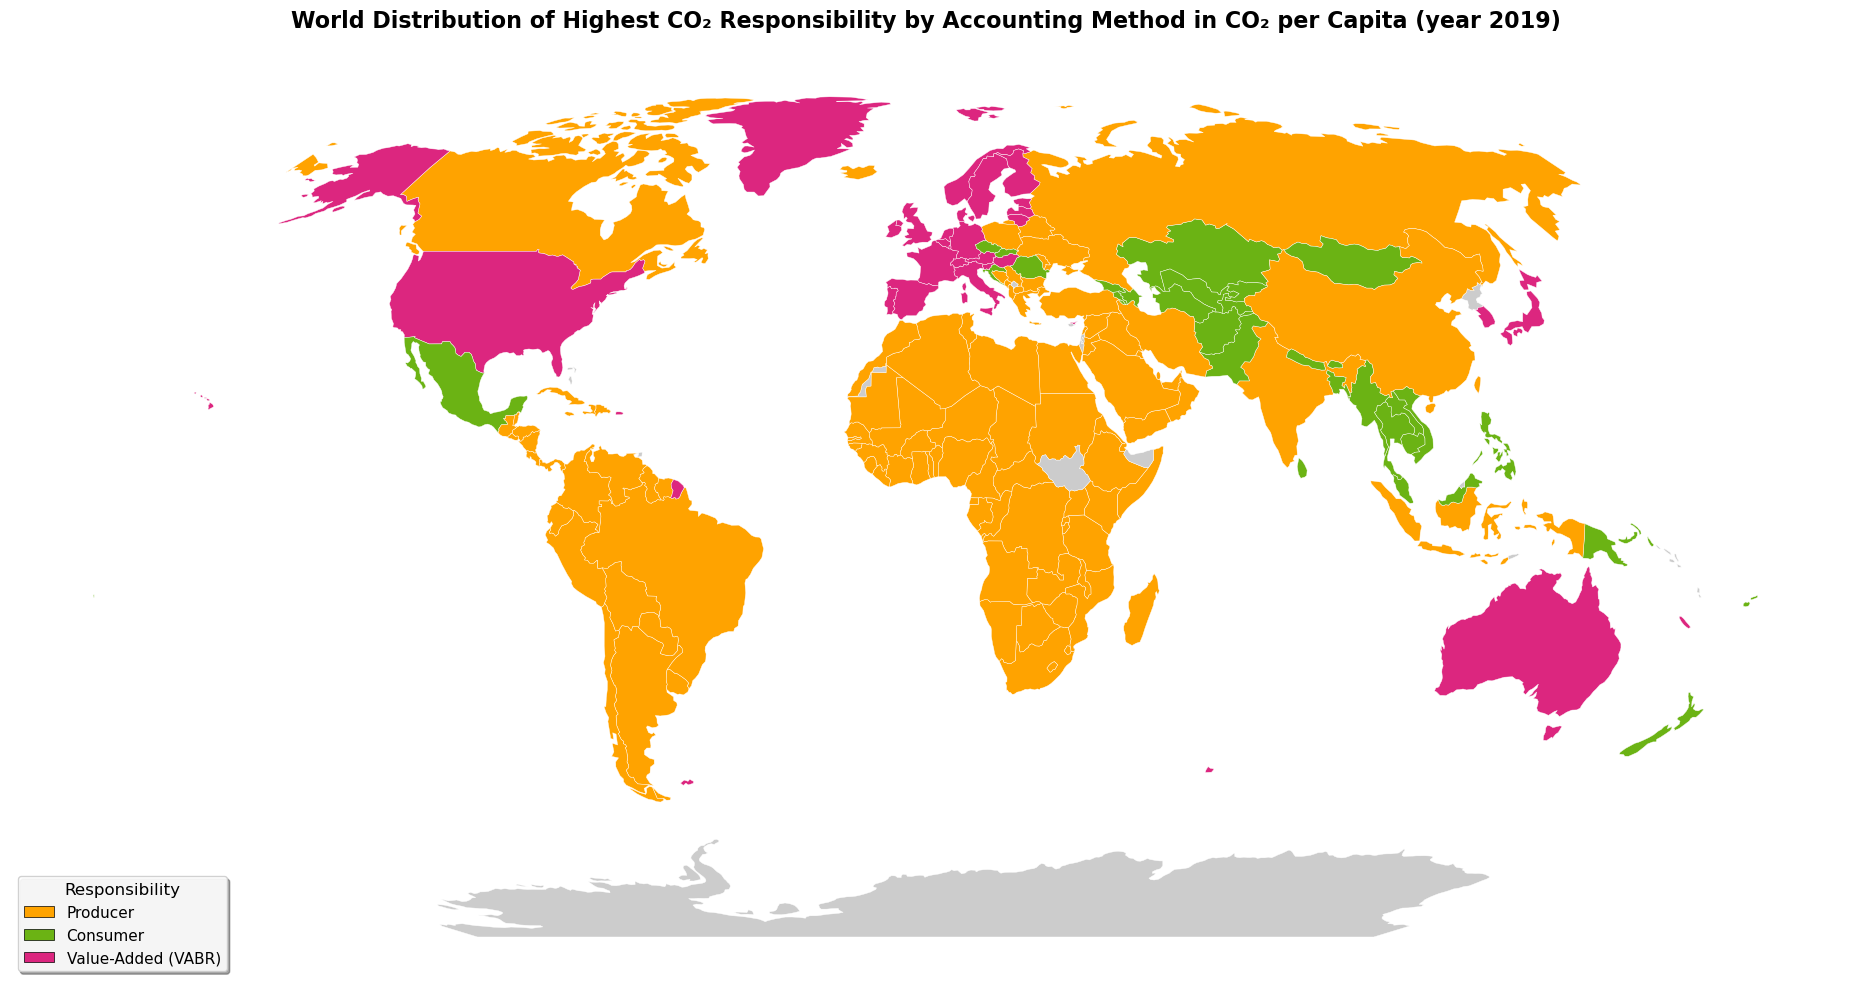


=== STATISTICS ===
Countries by dominant method:
Producer       101
Value-Added     31
Consumer        30
Name: dominant_method, dtype: int64


In [74]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle

# Ensure ISO_A3 column exists
if 'ISO_A3' not in per_capita.columns:
    per_capita = per_capita.reset_index()
    per_capita.rename(columns={'index': 'ISO_A3'}, inplace=True)

# --- VOLLSTÄNDIGE KORREKTE MAPPING ---
exiobase_to_shapefile = {
    'AT': 'AUT',
    'BE': 'BEL',
    'BG': 'BGR',
    'CY': 'CYN',
    'CZ': 'CZE',
    'DE': 'DEU',
    'DK': 'DN1',
    'EE': 'EST',
    'ES': 'ESP',
    'FI': 'FI1',
    'FR': 'FR1',
    'GR': 'GRC',
    'HR': 'HRV',
    'HU': 'HUN',
    'IE': 'IRL',
    'IT': 'ITA',
    'LT': 'LTU',
    'LU': 'LUX',
    'LV': 'LVA',
    'MT': 'MLT',
    'NL': 'NL1',
    'PL': 'POL',
    'PT': 'PRT',
    'RO': 'ROU',
    'SE': 'SWE',
    'SI': 'SVN',
    'SK': 'SVK',
    'GB': 'GB1',
    'US': 'US1',
    'JP': 'JPN',
    'CN': 'CH1',
    'CA': 'CAN',
    'KR': 'KOR',
    'BR': 'BRA',
    'IN': 'IND',
    'MX': 'MEX',
    'RU': 'RUS',
    'AU': 'AU1',
    'CH': 'CHE',
    'TR': 'TUR',
    'TW': 'TWN',
    'NO': 'NOR',
    'ID': 'IDN',
    'ZA': 'ZAF',
}

# ROW regions ISO2 to SOV_A3 - MIT SPEZIELLEN CODES
iso2_to_sov_a3 = {
    # Standard ISO3 codes
    'AF': 'AFG', 'AL': 'ALB', 'DZ': 'DZA', 'AO': 'AGO', 'AR': 'ARG',
    'AM': 'ARM', 'AZ': 'AZE', 'BD': 'BGD', 'BH': 'BHR', 'BY': 'BLR',
    'BZ': 'BLZ', 'BJ': 'BEN', 'BT': 'BTN', 'BO': 'BOL', 'BA': 'BIH',
    'BW': 'BWA', 'BF': 'BFA', 'BI': 'BDI', 'KH': 'KHM', 'CM': 'CMR',
    'CV': 'CPV', 'CF': 'CAF', 'TD': 'TCD', 'CL': 'CHL', 'CO': 'COL',
    'KM': 'COM', 'CG': 'COG', 'CD': 'COD', 'CR': 'CRI', 'CI': 'CIV',
    'CU': 'CUB', 'DJ': 'DJI', 'DO': 'DOM', 'EC': 'ECU', 'EG': 'EGY',
    'SV': 'SLV', 'GQ': 'GNQ', 'ER': 'ERI', 'ET': 'ETH', 'FJ': 'FJI',
    'GA': 'GAB', 'GM': 'GMB', 'GE': 'GEO', 'GH': 'GHA', 'GT': 'GTM',
    'GN': 'GIN', 'GW': 'GNB', 'GY': 'GUY', 'HT': 'HTI', 'HN': 'HND',
    'IS': 'ISL', 'IR': 'IRN', 'IQ': 'IRQ', 'IL': 'ISR', 'JM': 'JAM',
    'JO': 'JOR', 'KE': 'KEN', 'KW': 'KWT', 'KG': 'KGZ', 'LA': 'LAO', 
    'LB': 'LBN', 'LS': 'LSO', 'LR': 'LBR', 'LY': 'LBY', 'MK': 'MKD', 
    'MG': 'MDG', 'MW': 'MWI', 'MY': 'MYS', 'MV': 'MDV', 'ML': 'MLI', 
    'MR': 'MRT', 'MU': 'MUS', 'MD': 'MDA', 'MN': 'MNG', 'ME': 'MNE', 
    'MA': 'MAR', 'MZ': 'MOZ', 'MM': 'MMR', 'NA': 'NAM', 'NP': 'NPL', 
    'NZ': 'NZ1', 'NI': 'NIC', 'NE': 'NER', 'NG': 'NGA', 'OM': 'OMN', 
    'PK': 'PAK', 'PA': 'PAN', 'PG': 'PNG', 'PY': 'PRY', 'PE': 'PER', 
    'PH': 'PHL', 'QA': 'QAT', 'RW': 'RWA', 'SA': 'SAU', 'SN': 'SEN', 
    'RS': 'SRB', 'SC': 'SYC', 'SL': 'SLE', 'SG': 'SGP', 'SO': 'SOM', 
    'LK': 'LKA', 'SD': 'SDN', 'SR': 'SUR', 'SZ': 'SWZ', 'SY': 'SYR', 
    'TJ': 'TJK', 'TZ': 'TZA', 'TH': 'THA', 'TG': 'TGO', 'TN': 'TUN', 
    'TM': 'TKM', 'UG': 'UGA', 'UA': 'UKR', 'AE': 'ARE', 'UY': 'URY', 
    'UZ': 'UZB', 'VE': 'VEN', 'VN': 'VNM', 'YE': 'YEM', 'ZM': 'ZMB', 
    'ZW': 'ZWE',
    # SPEZIELLE CODES
    'KZ': 'KA1',  # Kazakhstan special code!
    # Füge weitere spezielle codes hinzu wenn nötig
}

# VOLLSTÄNDIGE ROW regions
row_regions = {
    'WA': [  # Rest of Asia and Pacific
        'AF', 'AS', 'AM', 'AZ', 'BD', 'BT', 'BN', 'KH', 'CK', 'FJ', 'PF', 'GE', 
        'GU', 'HK', 'KZ', 'KI', 'KP', 'KG', 'LA', 'MO', 'MY', 'MV', 'MH', 'FM', 
        'MN', 'MM', 'NR', 'NP', 'NC', 'NZ', 'NU', 'MP', 'PK', 'PW', 'PG', 'PH', 
        'PN', 'WS', 'SG', 'SB', 'LK', 'TJ', 'TH', 'TP', 'TK', 'TO', 'TM', 'TV', 
        'UZ', 'VU', 'VN'
    ],
    'WL': [  # Rest of Latin America
        'AI', 'AG', 'AR', 'AW', 'BS', 'BB', 'BZ', 'BM', 'BO', 'KY', 'CL', 'CO',
        'CR', 'CU1', 'DM', 'DO', 'EC', 'SV', 'FK', 'GL', 'GD', 'GP', 'GT', 'GY',
        'HT', 'HN', 'JM', 'MQ', 'NI', 'PA', 'PY', 'PE', 'PR', 'KN', 'LC', 'PM', 
        'VC', 'SR', 'TT', 'TC', 'UY', 'VE', 'VG', 'VI', 'GF'
    ],
    'WE': [  # Rest of Europe
        'AL', 'AD', 'BY', 'BA', 'FO', 'GI', 'IS', 'IM', 'LI', 'MK', 'MD', 'MC', 
        'ME', 'SM', 'RS', 'UA', 'VA'
    ],
    'WF': [  # Rest of Africa
        'DZ', 'AO', 'BJ', 'BW', 'BF', 'BI', 'CM', 'CV', 'CF', 'TD', 'KM', 'CD',
        'CG', 'CI', 'DJ', 'GQ', 'EH','ER', 'ET', 'GA', 'GM', 'GH', 'GN', 'GW', 'KE', 
        'LS', 'LR', 'LY', 'MG', 'MW', 'ML', 'MR', 'MU', 'YT', 'MA', 'MZ', 'NA', 
        'NE', 'NG', 'RE', 'RW', 'ST', 'SN', 'SC', 'SL', 'SO', 'SH', 'SD', 'SZ', 
        'TZ', 'TG', 'TN', 'UG', 'EH', 'ZM', 'ZW'
    ],
    'WM': [  # Rest of Middle East
        'BH', 'IR', 'IQ', 'IL', 'JO', 'KW', 'LB', 'OM', 'PS', 'QA', 'SA',
        'SY', 'AE', 'YE', 'EG'
    ]
}

# Create data with dominant method
map_data = []

for idx, row in per_capita.iterrows():
    country_code = row['ISO_A3']
    
    # Determine dominant method
    methods_values = {
        'Producer': row['producer'],
        'Consumer': row['consumer'],
        'Value-Added': row['value_added']
    }
    
    dominant_method = max(methods_values, key=methods_values.get)
    max_value = methods_values[dominant_method]
    
    if country_code in exiobase_to_shapefile:
        # Individual EXIOBASE country
        map_data.append({
            'SOV_A3': exiobase_to_shapefile[country_code],
            'dominant_method': dominant_method,
            'max_value': max_value,
            'producer': row['producer'],
            'consumer': row['consumer'],
            'value_added': row['value_added']
        })
    elif country_code in row_regions:
        # ROW region - expand to members
        for member in row_regions[country_code]:
            member_sov_a3 = iso2_to_sov_a3.get(member, member)
            map_data.append({
                'SOV_A3': member_sov_a3,
                'dominant_method': dominant_method,
                'max_value': max_value,
                'producer': row['producer'],
                'consumer': row['consumer'],
                'value_added': row['value_added']
            })

map_df = pd.DataFrame(map_data)

# Load shapefile
world = gpd.read_file(r'C:/Users/Marine Riesterer/OneDrive/Desktop/MA Arbeit/results/geodata/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')
world = world.to_crs('ESRI:54030')  # Robinson projection

# Merge
world = world.merge(map_df, on='SOV_A3', how='left')

# Verify Kazakhstan
print(f"Kazakhstan (KA1) has data: {world[world['SOV_A3']=='KA1']['dominant_method'].notna().any()}")

# verfiy cuba
print(f"Cuba (CU) has data: {world[world['SOV_A3']=='CUB']['dominant_method'].notna().any()}")

# Create visualization
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

# Colors for each method
method_colors = {
    'Producer': '#ffa300',     
    'Consumer': '#6bb314',     
    'Value-Added': '#dc267f'  
}

# Map colors
world['color'] = world['dominant_method'].map(method_colors)
world['color'] = world['color'].fillna('#CCCCCC')  # Fill NaN with gray

# Plot
world.plot(
    color=world['color'],
    linewidth=0.3,
    edgecolor='white',
    ax=ax,
    missing_kwds={'color': '#CCCCCC', 'edgecolor': 'white', 'linewidth': 0.3}
)

# Ocean background
ax.set_facecolor('#E6F3FF')

ax.axis('off')

# Title
ax.set_title('World Distribution of Highest CO₂ Responsibility by Accounting Method in CO₂ per Capita (year 2019)',
            fontsize=16, fontweight='bold', pad=20)

# Legend
legend_elements = [
    Rectangle((0, 0), 1, 1, fc='#ffa300', edgecolor='black', linewidth=0.5, label='Producer'),
    Rectangle((0, 0), 1, 1, fc='#6bb314', edgecolor='black', linewidth=0.5, label='Consumer'),
    Rectangle((0, 0), 1, 1, fc='#dc267f', edgecolor='black', linewidth=0.5, label='Value-Added (VABR)')
]

legend = ax.legend(handles=legend_elements,
                   loc='lower left',
                   title='Responsibility',
                   frameon=True,
                   fancybox=True,
                   shadow=True,
                   fontsize=11,
                   title_fontsize=12)

legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.9)


plt.tight_layout()
plt.show()

# Statistics
print("\n=== STATISTICS ===")
print("Countries by dominant method:")
print(world['dominant_method'].value_counts())

In [75]:
import pandas as pd
from tabulate import tabulate

# Prepare summary DataFrame for top countries
summary = []
for country in results['producer_by_country'].index:
    producer = results['producer_by_country'][country] / 1e9  # Gt
    consumer = results['consumer_by_country'][country] / 1e9  # Gt
    vabr = results['value_added_by_country'][country] / 1e9   # Gt
    change_prod_vabr = vabr - producer
    change_cons_vabr = vabr - consumer
    summary.append({
        'Country': country,
        'Producer': producer,
        'Consumer': consumer,
        'VABR': vabr,
        'Change (Producer→VABR)': change_prod_vabr,
        'Change (Consumer→VABR)': change_cons_vabr
    })

summary_df = pd.DataFrame(summary)
summary_df['AbsChange'] = summary_df[['Change (Producer→VABR)', 'Change (Consumer→VABR)']].abs().max(axis=1)
summary_sorted = summary_df.sort_values('AbsChange', ascending=False)

# Show top 15 countries with largest change
print("Top 15 countries with largest change from Producer/Consumer to VABR:")
# Prepare table for top 15 countries
table = summary_sorted.head(15)[['Country', 'Producer', 'Consumer', 'VABR', 'Change (Producer→VABR)', 'Change (Consumer→VABR)']].round(2)
print(tabulate(table, headers='keys', tablefmt='plain', showindex=False))

Top 15 countries with largest change from Producer/Consumer to VABR:
Country      Producer    Consumer    VABR    Change (Producer→VABR)    Change (Consumer→VABR)
CN              12.96       11.82   11.46                     -1.5                      -0.36
US               5.1         6.21    6.52                      1.42                      0.32
JP               1.02        1.44    1.69                      0.67                      0.25
WA               3.52        3.7     3.07                     -0.45                     -0.63
WM               3.06        2.54    2.45                     -0.61                     -0.09
DE               0.63        0.9     1.22                      0.59                      0.32
IN               3.45        3.17    2.9                      -0.54                     -0.27
RU               2.04        1.55    1.52                     -0.52                     -0.03
GB               0.35        0.58    0.74                      0.39                  

FIND DIRTY AND POOR SECTORS

In [88]:
# === IDENTIFY "DIRTY BUT POOR" SECTORS SYSTEMATICALLY ===

# Define criteria for "dirty but poor"
# These are sectors with LOW value-added but HIGH emissions intensity

# Ensure 'va_coeff' exists
if 'va_coeff' not in df_all.columns:
    # Try to compute it if possible
    if 'total_va' in df_all.columns and 'total_output' in df_all.columns:
        df_all['va_coeff'] = df_all['total_va'] / df_all['total_output']
    elif 'va_coeff' not in df_all.columns and ('total_va' in locals() and 'total_output' in locals()):
        # Compute va_coeff from available arrays and assign to df_all
        # Assumes df_all has same length/order as total_va and total_output
        import numpy as np
        total_va_arr = np.asarray(total_va)
        total_output_arr = np.asarray(total_output)
        va_coeff_arr = np.divide(total_va_arr, total_output_arr, out=np.zeros_like(total_va_arr, dtype=float), where=(total_output_arr != 0))
        df_all['va_coeff'] = va_coeff_arr
    else:
        raise KeyError("df_all must contain either 'va_coeff' or both 'total_va' and 'total_output' columns, or total_va/total_output must be available as arrays.")

# Calculate percentiles to identify outliers
va_percentiles = df_all['va_coeff'].quantile([0.1, 0.25, 0.5, 0.75, 0.9])
em_percentiles = df_all['em_intensity'].quantile([0.1, 0.25, 0.5, 0.75, 0.9])

print("\n=== VALUE-ADDED COEFFICIENT DISTRIBUTION ===")
print(va_percentiles)

print("\n=== EMISSIONS INTENSITY DISTRIBUTION ===")
print(em_percentiles)

# Define "dirty but poor" criteria
DIRTY_THRESHOLD = em_percentiles[0.75]  # Top 25% emissions intensity
POOR_THRESHOLD = va_percentiles[0.25]   # Bottom 25% value-added

# Find problematic sectors
dirty_but_poor = df_all[
    (df_all['em_intensity'] > DIRTY_THRESHOLD) & 
    (df_all['va_coeff'] < POOR_THRESHOLD)
].copy()

print(f"\n=== DIRTY BUT POOR SECTORS ===")
print(f"Found {len(dirty_but_poor)} sectors with:")
print(f"  - Emissions intensity > {DIRTY_THRESHOLD:.2f} (top 25%)")
print(f"  - Value-added coefficient < {POOR_THRESHOLD:.2f} (bottom 25%)")

# Sort by emissions to find worst cases
dirty_but_poor = dirty_but_poor.sort_values('total_emissions', ascending=False)

print("\nTop 20 'Dirty but Poor' sectors by total emissions:")
print("-" * 80)
for i, row in dirty_but_poor.head(20).iterrows():
    print(f"{row['country']:3} | {row['sector'][:40]:40} | "
          f"VA: {row['va_coeff']:.2%} | "
          f"Intensity: {row['em_intensity']:.1f} | "
          f"Emissions: {row['total_emissions']/1e6:.1f} Mt")

ValueError: non-broadcastable output operand with shape () doesn't match the broadcast shape (7987,)

In [ ]:
# === TOP 20 "DIRTY BUT POOR" ENERGY SECTOR/REGIONS ===

# Assumes you have df_energy from your energy sector analysis cell.
# "Dirty but poor" = high emissions intensity, low value-added coefficient.

# Calculate thresholds (top 25% emissions intensity, bottom 25% VA coefficient)
em_75 = df_energy['em_intensity'].quantile(0.75)
va_25 = df_energy['va_coeff'].quantile(0.25)

# Filter for "dirty but poor" energy sector/regions
dirty_but_poor_energy = df_energy[
    (df_energy['em_intensity'] > em_75) &
    (df_energy['va_coeff'] < va_25)
].copy()

# Sort by total emissions (descending) and select top 20
top20_dirty_poor_energy = dirty_but_poor_energy.sort_values('total_emissions', ascending=False).head(20)

print("\n=== TOP 20 DIRTY BUT POOR ENERGY SECTOR/REGIONS ===")
print(f"{'Rank':<4} {'Country':<3} {'Type':<10} {'VA Coeff':<8} {'Em.Int.':<12} {'Emissions':<10} {'Sector':<30}")
print("-" * 90)
for i, row in enumerate(top20_dirty_poor_energy.itertuples(), 1):
    print(f"{i:<4} {row.country:<3} {row.energy_type:<10} {row.va_coeff:<8.3f} "
          f"{row.em_intensity:<12.1f} {row.total_emissions:<10.1f} {row.sector_short:<30}")

# Optionally, display as a DataFrame for further analysis:
# display(top20_dirty_poor_energy)


=== TOP 20 DIRTY BUT POOR ENERGY SECTOR/REGIONS ===
Rank Country Type       VA Coeff Em.Int.      Emissions  Sector                        
------------------------------------------------------------------------------------------
1    IN  coal       0.000    80275.5      953.0      Production of electricity by c
2    KR  coal       0.011    14367.7      197.2      Production of electricity by c
3    WE  coal       0.000    56352.3      101.1      Production of electricity by c
4    WL  oil        0.000    11455.5      53.3       Production of electricity by p
5    WF  oil        0.001    12449.5      42.1       Production of electricity by p
6    PL  electricity 0.010    17406.1      39.4       Steam and hot water supply    
7    DE  electricity 0.014    8772.3       35.9       Steam and hot water supply    
8    WA  oil        0.000    22394.1      35.1       Production of electricity by p
9    MX  oil        0.000    12010.9      29.7       Production of electricity by p
10   ID  g


=== TOP 30 DIRTY BUT POOR ENERGY SECTOR/REGIONS ===
Rank Country Type       VA Coeff Em.Int.      Emissions  Sector                        
------------------------------------------------------------------------------------------
1    IN  coal       0.000    80275.5      953.0      Production of electricity by c
2    KR  coal       0.011    14367.7      197.2      Production of electricity by c
3    WE  coal       0.000    56352.3      101.1      Production of electricity by c
4    WL  oil        0.000    11455.5      53.3       Production of electricity by p
5    WF  oil        0.001    12449.5      42.1       Production of electricity by p
6    PL  electricity 0.010    17406.1      39.4       Steam and hot water supply    
7    DE  electricity 0.014    8772.3       35.9       Steam and hot water supply    
8    WA  oil        0.000    22394.1      35.1       Production of electricity by p
9    MX  oil        0.000    12010.9      29.7       Production of electricity by p
10   ID  g

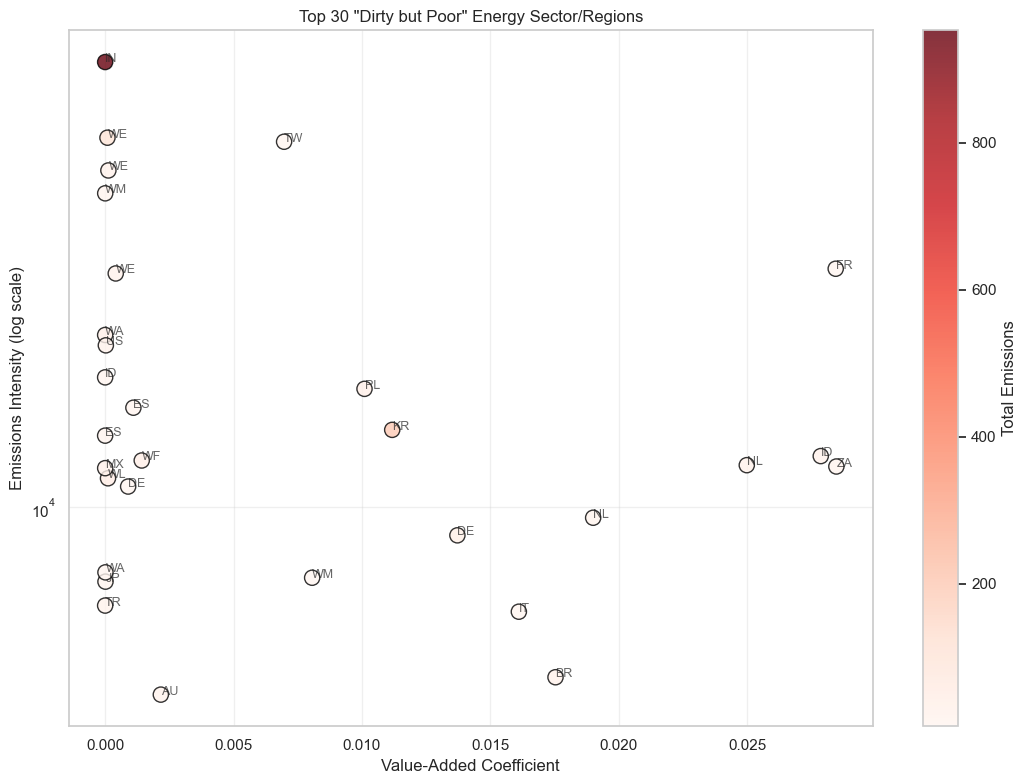

In [ ]:
# === TOP 30 "DIRTY BUT POOR" ENERGY SECTOR/REGIONS + SCATTER PLOT ===

import matplotlib.pyplot as plt

# Calculate thresholds (top 25% emissions intensity, bottom 25% VA coefficient)
em_75 = df_energy['em_intensity'].quantile(0.75)
va_25 = df_energy['va_coeff'].quantile(0.25)

# Filter for "dirty but poor" energy sector/regions
dirty_but_poor_energy = df_energy[
    (df_energy['em_intensity'] > em_75) &
    (df_energy['va_coeff'] < va_25)
].copy()

# Sort by total emissions (descending) and select top 30
top30_dirty_poor_energy = dirty_but_poor_energy.sort_values('total_emissions', ascending=False).head(30)

print("\n=== TOP 30 DIRTY BUT POOR ENERGY SECTOR/REGIONS ===")
print(f"{'Rank':<4} {'Country':<3} {'Type':<10} {'VA Coeff':<8} {'Em.Int.':<12} {'Emissions':<10} {'Sector':<30}")
print("-" * 90)
for i, row in enumerate(top30_dirty_poor_energy.itertuples(), 1):
    print(f"{i:<4} {row.country:<3} {row.energy_type:<10} {row.va_coeff:<8.3f} "
          f"{row.em_intensity:<12.1f} {row.total_emissions:<10.1f} {row.sector_short:<30}")

# Scatter plot: x = value-added coefficient, y = emissions intensity (log scale)
plt.figure(figsize=(11, 8))
scatter = plt.scatter(
    top30_dirty_poor_energy['va_coeff'],
    top30_dirty_poor_energy['em_intensity'],
    c=top30_dirty_poor_energy['total_emissions'],
    cmap='Reds',
    s=120,
    alpha=0.8,
    edgecolor='black'
)

# Annotate country for each point
for i, row in top30_dirty_poor_energy.iterrows():
    plt.text(row['va_coeff'], row['em_intensity'], f"{row['country']}", fontsize=9, alpha=0.7)

plt.xlabel('Value-Added Coefficient')
plt.ylabel('Emissions Intensity (log scale)')
plt.yscale('log')
plt.title('Top 30 "Dirty but Poor" Energy Sector/Regions')
plt.colorbar(scatter, label='Total Emissions')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


=== ALL DIRTY BUT POOR COAL ENERGY SECTOR/COUNTRY ===
Rank Country Type       VA Coeff Em.Int.      Emissions  Sector                        
------------------------------------------------------------------------------------------
1    IN  coal       0.000    80275.5      953.0      Production of electricity by c
2    KR  coal       0.011    14367.7      197.2      Production of electricity by c
3    WE  coal       0.000    56352.3      101.1      Production of electricity by c
4    NL  coal       0.019    9525.0       13.9       Production of electricity by c
5    WM  coal       0.000    43439.3      12.0       Mining of coal and lignite; ex
6    ES  coal       0.001    15936.3      11.6       Production of electricity by c
7    FR  coal       0.028    30528.0      6.4        Manufacture of coke oven produ
8    DE  coal       0.001    11021.5      5.8        Manufacture of coke oven produ
9    IT  coal       0.002    20803.3      5.0        Manufacture of coke oven produ
10   FR  c

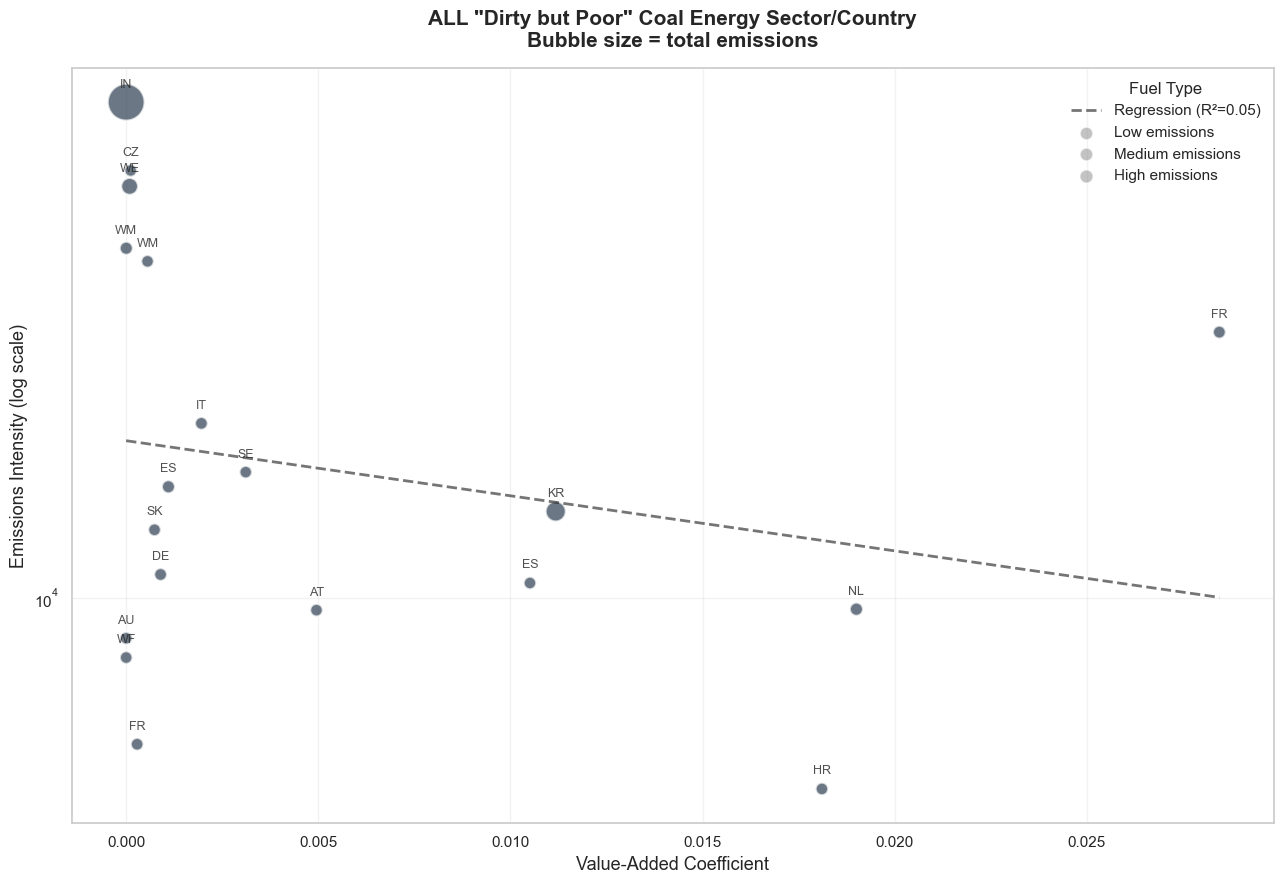

In [ ]:
# === "DIRTY BUT POOR" ENERGY SECTOR/COUNTRY - BUBBLE PLOT STYLE (ALL COAL) ===

import matplotlib.pyplot as plt

# Calculate thresholds (top 25% emissions intensity, bottom 25% VA coefficient)
em_75 = df_energy['em_intensity'].quantile(0.75)
va_25 = df_energy['va_coeff'].quantile(0.25)

# Filter for "dirty but poor" energy sector/country (ALL coal, not just top 30)
dirty_but_poor_energy = df_energy[
    (df_energy['em_intensity'] > em_75) &
    (df_energy['va_coeff'] < va_25) &
    (df_energy['energy_type'] == 'coal')
].copy()

# Sort by total emissions (descending)
dirty_but_poor_energy_sorted = dirty_but_poor_energy.sort_values('total_emissions', ascending=False)

print("\n=== ALL DIRTY BUT POOR COAL ENERGY SECTOR/COUNTRY ===")
print(f"{'Rank':<4} {'Country':<3} {'Type':<10} {'VA Coeff':<8} {'Em.Int.':<12} {'Emissions':<10} {'Sector':<30}")
print("-" * 90)
for i, row in enumerate(dirty_but_poor_energy_sorted.itertuples(), 1):
    print(f"{i:<4} {row.country:<3} {row.energy_type:<10} {row.va_coeff:<8.3f} "
          f"{row.em_intensity:<12.1f} {row.total_emissions:<10.1f} {row.sector_short:<30}")

# --- Bubble plot style ---
sns.set_style("whitegrid")
plt.figure(figsize=(13, 9))

# Color mapping by fuel type
fuel_colors = {
    'coal': '#2C3E50',       # dark blue/grey
    'oil': '#E67E22',        # orange
    'gas': '#3498DB',        # blue
    'electricity': '#FFB347',# peach
    'other': '#95A5A6'       # grey
}
color_list = dirty_but_poor_energy_sorted['energy_type'].map(fuel_colors).fillna('#95A5A6')

# Bubble sizes by total emissions (scaled for visibility)
min_size, max_size = 80, 700
em_norm = (dirty_but_poor_energy_sorted['total_emissions'] - dirty_but_poor_energy_sorted['total_emissions'].min()) / \
          (dirty_but_poor_energy_sorted['total_emissions'].max() - dirty_but_poor_energy_sorted['total_emissions'].min())
sizes = min_size + em_norm * (max_size - min_size)

# Plot bubbles
scatter = plt.scatter(
    dirty_but_poor_energy_sorted['va_coeff'],
    dirty_but_poor_energy_sorted['em_intensity'],
    s=sizes,
    c=color_list,
    alpha=0.7,
    edgecolor='white',
    linewidth=1.5,
    label=None
)

# Add country labels (avoid overlap by offsetting)
for i, row in dirty_but_poor_energy_sorted.iterrows():
    plt.text(row['va_coeff'], row['em_intensity']*1.05, row['country'],
             fontsize=9, alpha=0.8, ha='center', va='bottom')

# Regression line (log scale for y)
if len(dirty_but_poor_energy_sorted) > 1:
    slope, intercept, r_value, p_value, std_err = linregress(
        dirty_but_poor_energy_sorted['va_coeff'], np.log(dirty_but_poor_energy_sorted['em_intensity'])
    )
    x_line = np.linspace(dirty_but_poor_energy_sorted['va_coeff'].min(), dirty_but_poor_energy_sorted['va_coeff'].max(), 100)
    y_line = np.exp(slope * x_line + intercept)
    plt.plot(x_line, y_line, 'k--', alpha=0.6, linewidth=2, label=f'Regression (R²={r_value**2:.2f})')

plt.xlabel('Value-Added Coefficient', fontsize=13)
plt.ylabel('Emissions Intensity (log scale)', fontsize=13)
plt.yscale('log')
plt.title('ALL "Dirty but Poor" Coal Energy Sector/Country\nBubble size = total emissions', fontsize=15, fontweight='bold', pad=15)
plt.grid(True, alpha=0.25)

# --- Legends ---
legend_elements = [Patch(facecolor=color, edgecolor='white', label=ftype.title())
                   for ftype, color in fuel_colors.items()]
plt.legend(handles=legend_elements, title='Fuel Type', loc='upper right', fontsize=11)

# Legend for bubble size (total emissions)
for q, label in zip([0.25, 0.5, 0.75], ['Low', 'Medium', 'High']):
    size = min_size + (dirty_but_poor_energy_sorted['total_emissions'].quantile(q) - dirty_but_poor_energy_sorted['total_emissions'].min()) / \
           (dirty_but_poor_energy_sorted['total_emissions'].max() - dirty_but_poor_energy_sorted['total_emissions'].min()) * (max_size - min_size)
    plt.scatter([], [], s=size, c='#888888', alpha=0.5, edgecolor='white', label=f'{label} emissions')

plt.legend(title='Fuel Type', loc='upper right', fontsize=11)
plt.tight_layout()
plt.show()


=== DIRTY BUT POOR ANALYSIS - FOSSIL FUEL FOCUS ===
Found 143 fossil fuel sectors
Countries: ['AT', 'AU', 'BE', 'BG', 'BR', 'CA', 'CH', 'CN', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'ID', 'IE', 'IN', 'IT', 'JP', 'KR', 'LT', 'MX', 'NL', 'NO', 'PL', 'PT', 'RO', 'RU', 'SE', 'SK', 'TR', 'TW', 'US', 'WA', 'WE', 'WF', 'WL', 'WM', 'ZA']
Fuel types: {'oil': 79, 'coal': 40, 'gas': 24}
Found 20 clean high-efficiency sectors for contrast

TOP 10 WORST FOSSIL FUEL 'DIRTY BUT POOR' CASES
Rank Country Sector                                   Em.Int.  VA Coeff Fuel    
-------------------------------------------------------------------------------------
1    TW  Production of electricity by coal        72814.8  0.278    coal    
2    ZA  Production of electricity by coal        68309.5  0.238    coal    
3    WE  Production of electricity by coal        56352.3  0.000    coal    
4    WF  Mining of coal and lignite; extractio... 45746.1  0.209    coal    
5    WA  Production

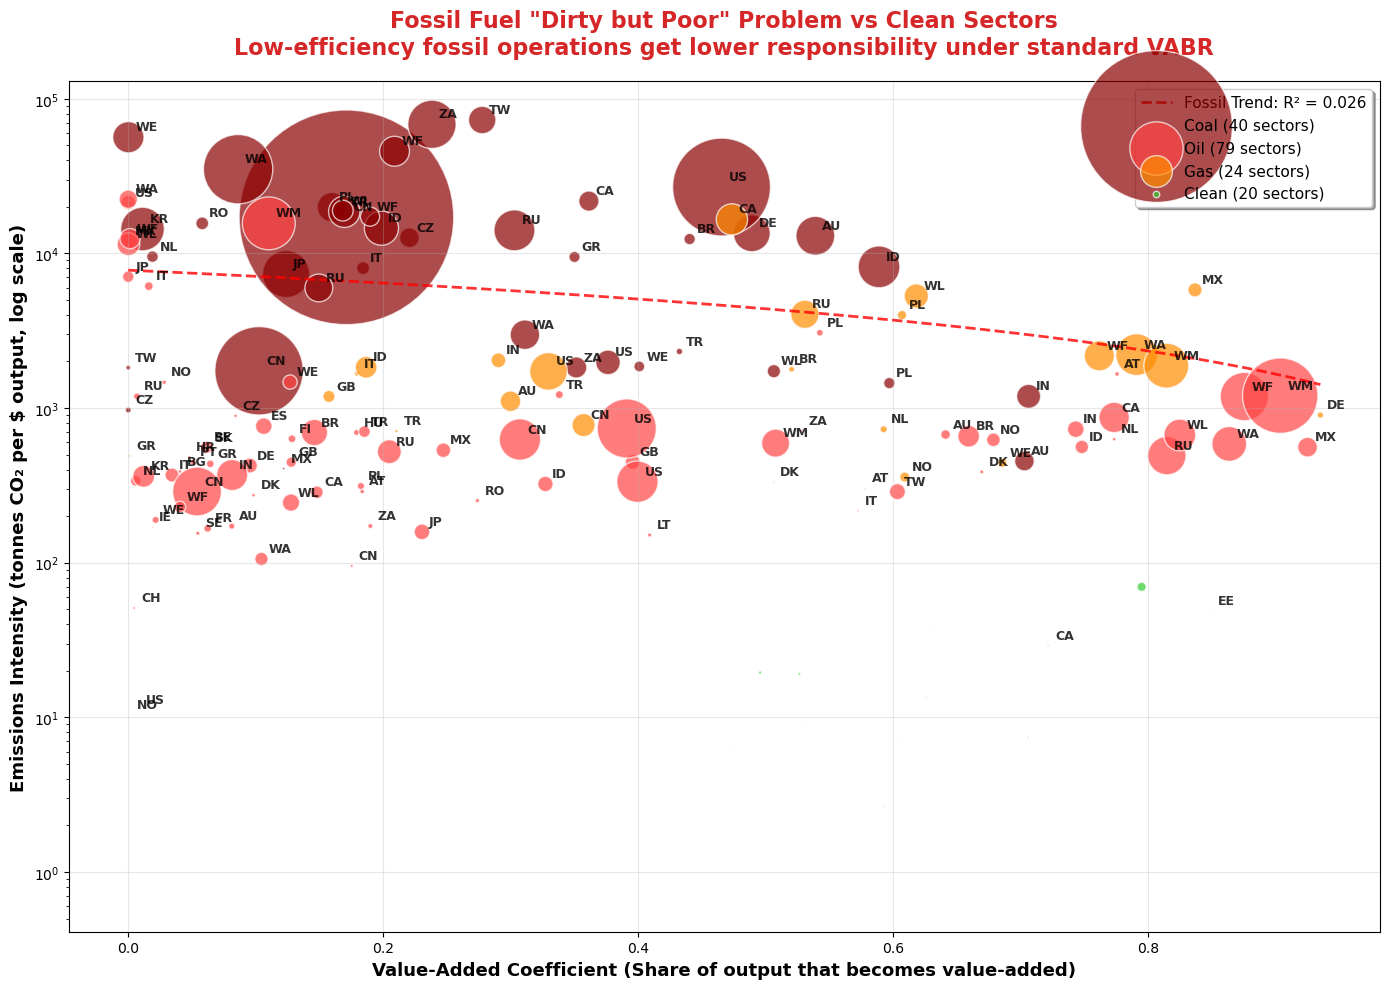


FOSSIL FUEL DIRTY-BUT-POOR SUMMARY
Total fossil fuel sectors: 143
'Dirty but poor' fossil sectors: 12
Average emissions intensity (all fossil): 5618.8 tonnes/$
Average VA coefficient (all fossil): 0.318
Average emissions intensity (dirty-poor): 18644.8 tonnes/$
Average VA coefficient (dirty-poor): 0.016

POLICY IMPLICATION:
Fossil fuel sectors with low efficiency get systematically lower
climate responsibility under standard VABR, creating perverse incentives


In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

print("=== DIRTY BUT POOR ANALYSIS - FOSSIL FUEL FOCUS ===")

# Focus specifically on fossil fuel sectors first to avoid data errors
fossil_keywords = [
    'coal', 'lignite', 'petroleum', 'crude oil', 'natural gas', 
    'gas extraction', 'oil extraction', 'mining of coal'
]

# Extract data for fossil fuel sectors only
fossil_data = []

for idx, (country, sector) in enumerate(ixi_data.x.index):
    # Only process fossil fuel sectors
    if any(keyword in sector.lower() for keyword in fossil_keywords):
        
        output = ixi_data.x.values.flatten()[idx]
        emissions = results['producer_by_sector'].get((country, sector), 0)
        
        if output > 1000 and emissions > 1000:  # Filter out tiny values that might cause errors
            try:
                # Calculate total value-added coefficient
                total_value_added = 0
                for component in VALUE_ADDED_COMPONENTS:
                    va_component = ixi_data.factor_inputs.F.loc[component, (country, sector)]
                    total_value_added += va_component
                
                va_coeff = total_value_added / output if output > 0 else 0
                em_intensity = emissions / output if output > 0 else 0  # tonnes CO2 per dollar
                
                # Only include if values are reasonable
                if 0 < va_coeff < 1 and 0 < em_intensity < 100000:  # Reasonable bounds
                    
                    # Classify fuel type
                    fuel_type = 'other'
                    sector_lower = sector.lower()
                    if any(word in sector_lower for word in ['coal', 'lignite']):
                        fuel_type = 'coal'
                    elif any(word in sector_lower for word in ['petroleum', 'crude oil', 'oil']):
                        fuel_type = 'oil'
                    elif any(word in sector_lower for word in ['natural gas', 'gas']):
                        fuel_type = 'gas'
                    
                    fossil_data.append({
                        'country': country,
                        'sector': sector,
                        'va_coeff': va_coeff,
                        'em_intensity': em_intensity,
                        'total_emissions': emissions / 1e6,  # Mt CO2
                        'output': output / 1e9,  # Billion $
                        'fuel': fuel_type
                    })
                    
            except Exception as e:
                print(f"Error processing {country}-{sector}: {e}")
                continue

# Convert to DataFrame
df_fossil = pd.DataFrame(fossil_data)

if len(df_fossil) == 0:
    print("No fossil fuel data found! Check your keyword matching.")
else:
    print(f"Found {len(df_fossil)} fossil fuel sectors")
    print(f"Countries: {sorted(df_fossil['country'].unique())}")
    print(f"Fuel types: {df_fossil['fuel'].value_counts().to_dict()}")

# Add some high-efficiency clean sectors for contrast
clean_data = []
clean_keywords = [
    'financial intermediation', 'real estate', 'computer', 'research', 
    'telecommunications', 'software', 'consulting'
]

for idx, (country, sector) in enumerate(ixi_data.x.index):
    if any(keyword in sector.lower() for keyword in clean_keywords):
        
        output = ixi_data.x.values.flatten()[idx]
        emissions = results['producer_by_sector'].get((country, sector), 0)
        
        if output > 1000 and emissions > 0:
            try:
                total_value_added = 0
                for component in VALUE_ADDED_COMPONENTS:
                    va_component = ixi_data.factor_inputs.F.loc[component, (country, sector)]
                    total_value_added += va_component
                
                va_coeff = total_value_added / output if output > 0 else 0
                em_intensity = emissions / output if output > 0 else 0
                
                if 0.3 < va_coeff < 1 and 0 < em_intensity < 1000:  # High VA, low emissions
                    clean_data.append({
                        'country': country,
                        'sector': sector,
                        'va_coeff': va_coeff,
                        'em_intensity': em_intensity,
                        'total_emissions': emissions / 1e6,
                        'output': output / 1e9,
                        'fuel': 'clean'
                    })
                    
            except Exception as e:
                continue

df_clean = pd.DataFrame(clean_data)
if len(df_clean) > 20:
    df_clean = df_clean.sample(20, random_state=42)  # Limit for visualization

print(f"Found {len(df_clean)} clean high-efficiency sectors for contrast")

# Combine datasets
df_viz = pd.concat([df_fossil, df_clean], ignore_index=True)

# Sort fossil fuels by emissions intensity to identify worst cases
fossil_sorted = df_fossil.sort_values('em_intensity', ascending=False)

print(f"\n{'='*80}")
print("TOP 10 WORST FOSSIL FUEL 'DIRTY BUT POOR' CASES")
print("="*80)
print(f"{'Rank':<4} {'Country':<3} {'Sector':<40} {'Em.Int.':<8} {'VA Coeff':<8} {'Fuel':<8}")
print("-" * 85)

for i, (_, row) in enumerate(fossil_sorted.head(10).iterrows(), 1):
    sector_short = row['sector'][:37] + "..." if len(row['sector']) > 40 else row['sector']
    print(f"{i:<4} {row['country']:<3} {sector_short:<40} {row['em_intensity']:<8.1f} {row['va_coeff']:<8.3f} {row['fuel']:<8}")

# Create the visualization
plt.figure(figsize=(14, 10))

# Color mapping
color_map = {
    'coal': '#8B0000',    # Dark red
    'oil': '#FF4444',     # Red
    'gas': '#FF8C00',     # Orange
    'other': '#DC143C',   # Crimson
    'clean': '#32CD32'    # Green
}

# Plot each fuel type
for fuel_type in color_map.keys():
    subset = df_viz[df_viz['fuel'] == fuel_type]
    if len(subset) > 0:
        plt.scatter(subset['va_coeff'], subset['em_intensity'], 
                   c=color_map[fuel_type], 
                   s=subset['total_emissions'] * 5,  # Size by emissions
                   alpha=0.7, edgecolors='white', linewidth=1,
                   label=f'{fuel_type.title()} ({len(subset)} sectors)')

# Add country labels for fossil fuels only
fossil_viz = df_viz[df_viz['fuel'] != 'clean']
for i, row in fossil_viz.iterrows():
    plt.annotate(row['country'], 
                (row['va_coeff'], row['em_intensity']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=9, alpha=0.8, fontweight='bold')

# Set log scale for y-axis
plt.yscale('log')

# Add trend line for fossil fuels only
if len(df_fossil) > 3:
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        df_fossil['va_coeff'], df_fossil['em_intensity']
    )
    x_trend = np.linspace(df_fossil['va_coeff'].min(), df_fossil['va_coeff'].max(), 100)
    y_trend = slope * x_trend + intercept
    plt.plot(x_trend, y_trend, '--', color='red', alpha=0.8, linewidth=2, 
             label=f'Fossil Trend: R² = {r_value**2:.3f}')

# Formatting
plt.xlabel('Value-Added Coefficient (Share of output that becomes value-added)', 
           fontsize=13, fontweight='bold')
plt.ylabel('Emissions Intensity (tonnes CO₂ per $ output, log scale)', 
           fontsize=13, fontweight='bold')

plt.title('Fossil Fuel "Dirty but Poor" Problem vs Clean Sectors\n' + 
          'Low-efficiency fossil operations get lower responsibility under standard VABR',
          fontsize=16, fontweight='bold', pad=20, color='#d62728')


# Legend and grid
plt.legend(loc='upper right', fontsize=11, frameon=True, fancybox=True, shadow=True)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Summary statistics
if len(df_fossil) > 0:
    print(f"\n{'='*60}")
    print("FOSSIL FUEL DIRTY-BUT-POOR SUMMARY")
    print("="*60)
    
    # Find the most problematic cases (high emissions, low VA)
    dirty_poor_fossil = df_fossil[
        (df_fossil['em_intensity'] > df_fossil['em_intensity'].quantile(0.7)) &
        (df_fossil['va_coeff'] < df_fossil['va_coeff'].quantile(0.3))
    ]
    
    print(f"Total fossil fuel sectors: {len(df_fossil)}")
    print(f"'Dirty but poor' fossil sectors: {len(dirty_poor_fossil)}")
    print(f"Average emissions intensity (all fossil): {df_fossil['em_intensity'].mean():.1f} tonnes/$")
    print(f"Average VA coefficient (all fossil): {df_fossil['va_coeff'].mean():.3f}")
    
    if len(dirty_poor_fossil) > 0:
        print(f"Average emissions intensity (dirty-poor): {dirty_poor_fossil['em_intensity'].mean():.1f} tonnes/$")
        print(f"Average VA coefficient (dirty-poor): {dirty_poor_fossil['va_coeff'].mean():.3f}")
        
    print(f"\nPOLICY IMPLICATION:")
    print(f"Fossil fuel sectors with low efficiency get systematically lower")
    print(f"climate responsibility under standard VABR, creating perverse incentives")

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

print("=== DIRTY BUT POOR: ENERGY SECTOR ANALYSIS ===")

# Focus ONLY on energy sectors - more precise keywords
energy_keywords = [
    'extraction of crude petroleum',
    'extraction of natural gas', 
    'mining of coal and lignite',
    'production of electricity by coal',
    'production of electricity by gas',
    'production of electricity by petroleum',
    'petroleum refinery'
]

# Extract data for energy sectors only
energy_data = []

for idx, (country, sector) in enumerate(ixi_data.x.index):
    # Only process energy sectors with exact keyword matching
    if any(keyword in sector.lower() for keyword in energy_keywords):
        
        output = ixi_data.x.values.flatten()[idx]
        emissions = results['producer_by_sector'].get((country, sector), 0)
        
        # More stringent filtering for clean data
        if output > 1e6 and emissions > 1e3:  # Only substantial operations
            try:
                # Calculate total value-added coefficient
                total_value_added = 0
                for component in VALUE_ADDED_COMPONENTS:
                    va_component = ixi_data.factor_inputs.F.loc[component, (country, sector)]
                    total_value_added += va_component
                
                va_coeff = total_value_added / output if output > 0 else 0
                em_intensity = emissions / output if output > 0 else 0
                
                # Only realistic values
                if 0.01 < va_coeff < 0.8 and 0.1 < em_intensity < 50000:
                    
                    # Classify energy type
                    energy_type = 'other'
                    if 'coal' in sector.lower():
                        energy_type = 'coal'
                    elif 'petroleum' in sector.lower() or 'crude oil' in sector.lower():
                        energy_type = 'oil'
                    elif 'natural gas' in sector.lower() or 'gas' in sector.lower():
                        energy_type = 'gas'
                    
                    energy_data.append({
                        'country': country,
                        'sector': sector,
                        'va_coeff': va_coeff,
                        'em_intensity': em_intensity,
                        'total_emissions': emissions / 1e6,  # Mt CO2
                        'energy_type': energy_type,
                        'sector_short': sector[:30] + "..." if len(sector) > 30 else sector
                    })
                    
            except Exception as e:
                continue

# Convert to DataFrame and filter
df_energy = pd.DataFrame(energy_data)

print(f"Found {len(df_energy)} energy sector operations")
print(f"Energy types: {df_energy['energy_type'].value_counts().to_dict()}")
print(f"Countries: {len(df_energy['country'].unique())}")

if len(df_energy) == 0:
    print("No energy data found!")
    exit()

# Strategic selection: Show diversity across the efficiency spectrum
# Take worst cases from each energy type + some middle cases
selected_data = []

for energy_type in ['coal', 'oil', 'gas']:
    subset = df_energy[df_energy['energy_type'] == energy_type]
    if len(subset) >= 3:
        # Take 2 worst (highest emissions intensity) + 1 best from each type
        worst = subset.nlargest(2, 'em_intensity')
        best = subset.nsmallest(1, 'em_intensity')
        selected_data.extend([worst, best])
    elif len(subset) > 0:
        # Take all if less than 3
        selected_data.append(subset)

# Combine selected data
if selected_data:
    df_plot = pd.concat(selected_data, ignore_index=True).drop_duplicates()
    
    # Add a few middle-range cases for context
    remaining = df_energy[~df_energy.index.isin(df_plot.index)]
    if len(remaining) > 0:
        # Add 3-5 middle cases
        middle_cases = remaining.sample(min(5, len(remaining)), random_state=42)
        df_plot = pd.concat([df_plot, middle_cases], ignore_index=True)
else:
    df_plot = df_energy.head(20)  # Fallback

# Remove duplicates and limit to reasonable number
df_plot = df_plot.drop_duplicates().head(25)

print(f"Selected {len(df_plot)} representative energy sectors for visualization")

# Create the visualization
fig, ax = plt.subplots(figsize=(12, 8))

# Color mapping
colors = {
    'coal': '#8B0000',    # Dark red
    'oil': '#FF4444',     # Red
    'gas': '#FF8C00',     # Orange
    'other': '#DC143C'    # Crimson
}

# Plot points
if 'energy_type' in df_plot.columns:
    for energy_type in colors.keys():
        subset = df_plot[df_plot['energy_type'] == energy_type]
        if len(subset) > 0:
            scatter = ax.scatter(
                subset['va_coeff'], subset['em_intensity'],
                c=colors[energy_type], s=120, alpha=0.8,
                edgecolors='white', linewidth=1.5,
                label=f'{energy_type.title()} ({len(subset)})'
            )
else:
    print("Column 'energy_type' not found in df_plot. Skipping energy type plotting.")

# Add country labels
for _, row in df_plot.iterrows():
    ax.annotate(f"{row['country']}", 
               xy=(row['va_coeff'], row['em_intensity']),
               xytext=(3, 3), textcoords='offset points',
               fontsize=9, fontweight='bold', alpha=0.9)

# Log scale for y-axis
ax.set_yscale('log')

# Add trend line
if len(df_plot) > 2:
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        df_plot['va_coeff'], df_plot['em_intensity']
    )
    x_trend = np.linspace(df_plot['va_coeff'].min(), df_plot['va_coeff'].max(), 100)
    y_trend = slope * x_trend + intercept
    ax.plot(x_trend, y_trend, '--', color='red', alpha=0.7, linewidth=2)

# Formatting
ax.set_xlabel('Value-Added Coefficient', fontsize=12, fontweight='bold')
ax.set_ylabel('Emissions Intensity (tonnes CO₂/$, log scale)', fontsize=12, fontweight='bold')
ax.set_title('Energy Sector "Dirty but Poor" Problem\nLow-efficiency operations get lower VABR responsibility', 
             fontsize=14, fontweight='bold', pad=20, color='#d62728')

# Highlight the problem area
if len(df_plot) > 0:
    # Find a representative "dirty but poor" case
    high_em = df_plot['em_intensity'] > df_plot['em_intensity'].quantile(0.7)
    low_va = df_plot['va_coeff'] < df_plot['va_coeff'].quantile(0.3)
    dirty_poor = df_plot[high_em & low_va]
    
    if len(dirty_poor) > 0:
        worst = dirty_poor.loc[dirty_poor['em_intensity'].idxmax()]
        
        # Add annotation
        ax.annotate('Dirty but Poor:\nHigh emissions, low VA\n→ Lower VABR responsibility', 
                   xy=(worst['va_coeff'], worst['em_intensity']),
                   xytext=(0.6, worst['em_intensity'] * 2),
                   arrowprops=dict(arrowstyle='->', color='red', lw=2),
                   fontsize=10, ha='center',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', alpha=0.8))

# Add stats box
stats_text = f"Energy Sector Analysis:\n{len(df_plot)} operations\nR² = {r_value**2:.3f}" if 'r_value' in locals() else f"Energy Sector Analysis:\n{len(df_plot)} operations"

ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
        fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue', alpha=0.8))

# Legend and grid
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print the selected cases
print(f"\n{'='*80}")
print("SELECTED ENERGY SECTOR CASES")
print("="*80)
print(f"{'Country':<3} {'Type':<4} {'VA Coeff':<8} {'Em.Int.':<8} {'Sector':<30}")
print("-" * 70)

for _, row in df_plot.sort_values('em_intensity', ascending=False).iterrows():
    print(f"{row['country']:<3} {row['energy_type']:<4} {row['va_coeff']:<8.3f} {row['em_intensity']:<8.1f} {row['sector_short']:<30}")

print(f"\nKey insight: Energy sectors with higher emissions intensity")
print(f"tend to have lower value-added coefficients, creating systematic bias in VABR allocation.")

=== DIRTY BUT POOR: ENERGY SECTOR ANALYSIS ===
Found 0 energy sector operations


KeyError: 'energy_type'

PROFIT BASED VABR ANALYSIS


=== VABR CALCULATION (PROFITS ONLY) ===
Mean profit coefficient: 0.0743
Non-zero profit coefficients: 5773/7987
Calculating consumer responsibility baseline...
Total consumer emissions: 44.712 Gt
Reallocating emissions based on profits only...
[VABR PROFITS] Producer: 44.715 Gt, Consumer: 44.712 Gt, VABR: 44.712 Gt, Error: 0.000000%


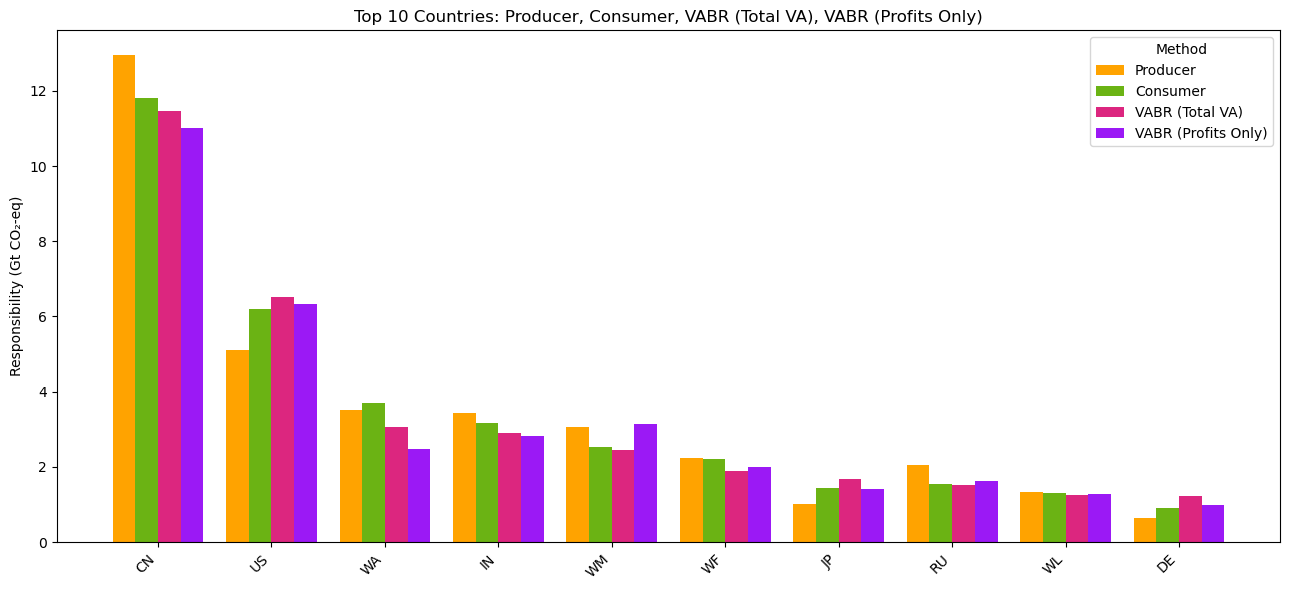

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Prepare country-level data ---
# Get top 10 countries by VABR-total (standard value-added)
top_countries = results['value_added_by_country'].sort_values(ascending=False).head(10).index.tolist()

# Get country-level Series for each method
producer = pd.Series(results['producer_by_country'])
consumer = pd.Series(results['consumer_by_country'])
vabr_total = pd.Series(results['value_added_by_country'])
vabr_profits, _, _, _, _ = calculate_vabr_profits_only(
    ixi_data, results['producer_by_sector'].values, VALUE_ADDED_COMPONENTS, v_override=None
)

# Ensure all Series have the same countries and order
data = pd.DataFrame({
    'Producer': producer.loc[top_countries],
    'Consumer': consumer.loc[top_countries],
    'VABR_Total': vabr_total.loc[top_countries],
    'VABR_Profits': vabr_profits.loc[top_countries]
})

# Convert to Gt CO₂-eq
data = data / 1e9

# --- Plot side-by-side bars ---
fig, ax = plt.subplots(figsize=(13, 6))
x = np.arange(len(top_countries))
width = 0.2

bars1 = ax.bar(x - 1.5*width, data['Producer'], width, label='Producer', color='#ffa300')
bars2 = ax.bar(x - 0.5*width, data['Consumer'], width, label='Consumer', color='#6bb314')
bars3 = ax.bar(x + 0.5*width, data['VABR_Total'], width, label='VABR (Total VA)', color='#dc267f')
bars4 = ax.bar(x + 1.5*width, data['VABR_Profits'], width, label='VABR (Profits Only)', color='#9b19f5')

ax.set_xticks(x)
ax.set_xticklabels(top_countries, rotation=45, ha='right')
ax.set_ylabel('Responsibility (Gt CO₂-eq)')
ax.set_title('Top 10 Countries: Producer, Consumer, VABR (Total VA), VABR (Profits Only)')
ax.legend(title='Method')
plt.tight_layout()
plt.show()

SECTORAL BREAKDOWN OF PROFITBASED VABR

In [95]:
import pandas as pd

# Get the top 7 countries by profits-only VABR (use correct column name)
top7_profit_countries = summary_df.nlargest(7, 'VABR')['Country'].tolist()

# Calculate sector-level profits-only VABR (already available as sector_vabr_profits_only)
sector_vabr_profits_only = pd.concat(
    calculate_vabr_profits_only(ixi_data, results['producer_by_sector'].values, None, None)[1]
).sort_index()

# For each country, print the top 5 sectors by profits-only VABR
for country in top7_profit_countries:
    print(f"\nTop 5 sectors for {country} (Profits-Only VABR):")
    if country in sector_vabr_profits_only.index.get_level_values(0):
        top_sectors = sector_vabr_profits_only.loc[country].nlargest(5)
        for i, (sector, value) in enumerate(top_sectors.items(), 1):
            sector_str = str(sector)
            print(f"{i}. {sector_str:60s} {value/1e6:10.2f} Mt CO₂")
    else:
        print("No sector data available.")


=== VABR CALCULATION (PROFITS ONLY) ===
Mean profit coefficient: 0.0743
Non-zero profit coefficients: 5773/7987
Calculating consumer responsibility baseline...
Total consumer emissions: 44.712 Gt
Reallocating emissions based on profits only...
[VABR PROFITS] Producer: 44.715 Gt, Consumer: 44.712 Gt, VABR: 44.712 Gt, Error: 0.000000%

Top 5 sectors for CN (Profits-Only VABR):
1. ('CN', 'Construction (45)')                                     1163.36 Mt CO₂
2. ('CN', 'Wholesale trade and commission trade, except of motor vehicles and motorcycles (51)')    1141.75 Mt CO₂
3. ('CN', 'Financial intermediation, except insurance and pension funding (65)')     833.10 Mt CO₂
4. ('CN', 'Real estate activities (70)')                            744.33 Mt CO₂
5. ('CN', 'Retail trade, except of motor vehicles and motorcycles; repair of personal and household goods (52)')     451.68 Mt CO₂

Top 5 sectors for US (Profits-Only VABR):
1. ('US', 'Real estate activities (70)')                           15

In [101]:
# CH profit only vabr allocation
top10_ch = sector_vabr_profits_only.loc['CH'].nlargest(10)
print("Top 10 sectors for Switzerland (Profits-Only VABR):")
for i, (sector, value) in enumerate(top10_ch.items(), 1):
    print(f"{i}. {str(sector):60s} {value/1e6:10.2f} Mt CO₂")  # Add /1e6 conversion

Top 10 sectors for Switzerland (Profits-Only VABR):
1. ('CH', 'Chemicals nec')                                           56.19 Mt CO₂
2. ('CH', 'Wholesale trade and commission trade, except of motor vehicles and motorcycles (51)')      49.35 Mt CO₂
3. ('CH', 'Real estate activities (70)')                             36.04 Mt CO₂
4. ('CH', 'Other business activities (74)')                          12.71 Mt CO₂
5. ('CH', 'Insurance and pension funding, except compulsory social security (66)')       9.25 Mt CO₂
6. ('CH', 'Financial intermediation, except insurance and pension funding (65)')       9.02 Mt CO₂
7. ('CH', 'Health and social work (85)')                              7.24 Mt CO₂
8. ('CH', 'Construction (45)')                                        5.23 Mt CO₂
9. ('CH', 'Processing of Food products nec')                          3.64 Mt CO₂
10. ('CH', 'Manufacture of gas; distribution of gaseous fuels through mains')       3.59 Mt CO₂


In [99]:
# Print top 10 sectors for Switzerland (CH) using standard VABR method
top10_ch_vabr = results['value_added_by_sector']['CH'].nlargest(10)
print("Top 10 sectors for Switzerland (Standard VABR):")
for i, (sector, value) in enumerate(top10_ch_vabr.items(), 1):
    print(f"{i}. {str(sector):60s} {value/1e6:10.2f} Mt CO₂")

Top 10 sectors for Switzerland (Standard VABR):
1. ('CH', 'Chemicals nec')                                           34.50 Mt CO₂
2. ('CH', 'Public administration and defence; compulsory social security (75)')      23.43 Mt CO₂
3. ('CH', 'Health and social work (85)')                             17.59 Mt CO₂
4. ('CH', 'Real estate activities (70)')                             15.72 Mt CO₂
5. ('CH', 'Retail trade, except of motor vehicles and motorcycles; repair of personal and household goods (52)')      14.99 Mt CO₂
6. ('CH', 'Wholesale trade and commission trade, except of motor vehicles and motorcycles (51)')      14.41 Mt CO₂
7. ('CH', 'Other business activities (74)')                          13.90 Mt CO₂
8. ('CH', 'Insurance and pension funding, except compulsory social security (66)')      10.32 Mt CO₂
9. ('CH', 'Construction (45)')                                        9.87 Mt CO₂
10. ('CH', 'Sea and coastal water transport')                          7.86 Mt CO₂


In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# STEP 1: Extract top 10 countries by VABR
print("EXTRACTING TOP 10 COUNTRIES...")
top10_profit_countries = summary_df.nlargest(10, 'VABR')['Country'].tolist()
print(f"Top 10 countries: {top10_profit_countries}")

# STEP 2: Calculate sector-level profits-only VABR
print("\nCALCULATING SECTOR-LEVEL VABR...")
sector_vabr_profits_only = pd.concat(
    calculate_vabr_profits_only(ixi_data, results['producer_by_sector'].values, VALUE_ADDED_COMPONENTS, None)[1]
).sort_index()

# Convert to Mt CO₂
sector_vabr_profits_only = sector_vabr_profits_only / 1e6

print(f"Sector data shape: {sector_vabr_profits_only.shape}")
print("Sample index structure:", sector_vabr_profits_only.index[:5])

# STEP 3: Define sector classification system with EXACT matching
# Use sets for faster lookup
fossil_fuel_sectors = {
    # Coal
    "Mining of coal and lignite; extraction of peat (10)",
    "Production of electricity by coal",
    "Manufacture of coke oven products",
    # Oil
    "Extraction of crude petroleum and services related to crude oil extraction, excluding surveying",
    "Petroleum Refinery",
    "Production of electricity by petroleum and other oil derivatives",
    "Retail sale of automotive fuel",
    "Incineration of waste: Oil/Hazardous waste",
    "Plastics, basic",
    # Gas
    "Extraction of natural gas and services related to natural gas extraction, excluding surveying",
    "Extraction, liquefaction, and regasification of other petroleum and gaseous materials",
    "Manufacture of gas; distribution of gaseous fuels through mains",
    "Production of electricity by gas",
    "Transport via pipelines",
    "N-fertiliser",
    # Fossil electricity
    "Distribution and trade of electricity",
    "Transmission of electricity",
    "Steam and hot water supply",
}

renewable_sectors = {
    "Production of electricity by Geothermal",
    "Production of electricity by biomass and waste",
    "Production of electricity by hydro",
    "Production of electricity by solar photovoltaic",
    "Production of electricity by solar thermal",
    "Production of electricity by tide, wave, ocean",
    "Production of electricity by wind",
}

industry_sectors = {
    # Heavy + Light industry combined
    "Manufacture of basic iron and steel and of ferro-alloys and first products thereof",
    "Manufacture of cement, lime and plaster",
    "Manufacture of other non-metallic mineral products n.e.c.",
    "Aluminium production", "Copper production", "Lead, zinc and tin production",
    "Other non-ferrous metal production",
    "Chemicals nec", "Manufacture of beverages",
    "Manufacture of fabricated metal products, except machinery and equipment (28)",
    "Manufacture of machinery and equipment n.e.c. (29)",
    "Manufacture of motor vehicles, trailers and semi-trailers (34)",
    "Manufacture of textiles (17)", "Manufacture of rubber and plastic products (25)",
    "Manufacture of electrical machinery and apparatus n.e.c. (31)",
    "Manufacture of office machinery and computers (30)",
    "Manufacture of furniture; manufacturing n.e.c.; recycling (36)",
    "Manufacture of glass and glass products",
    "Tanning and dressing of leather; manufacture of luggage, handbags, saddlery, harness and footwear (19)",
    "Manufacture of other transport equipment (35)",
    "Paper"
}

agriculture_sectors = {
    "Cattle farming", "Poultry farming", "Pigs farming", "Meat animals nec",
    "Cultivation of cereal grains nec", "Cultivation of crops nec", "Cultivation of oil seeds",
    "Cultivation of paddy rice", "Cultivation of vegetables, fruit, nuts",
    "Cultivation of sugar cane, sugar beet", "Cultivation of wheat", "Raw milk",
    "Cultivation of plant-based fibers", "Forestry, logging and related service activities (02)",
    "Fishing, operating of fish hatcheries and fish farms; service activities incidental to fishing (05)",
    "Processing of Food products nec", "Manufacture of fish products", "Processing of meat poultry",
    "Processed rice", "Processing vegetable oils and fats", "Production of meat products nec"
}

transport_sectors = {
    "Air transport (62)", "Other land transport", "Sea and coastal water transport",
    "Inland water transport", "Supporting and auxiliary transport activities; activities of travel agencies (63)",
    "Sale, maintenance, repair of motor vehicles, motor vehicles parts and motorcycles",
    "Transport via railways"
}

services_sectors = {
    "Financial intermediation, except insurance and pension funding (65)",
    "Activities auxiliary to financial intermediation (67)",
    "Computer and related activities (72)", "Research and development (73)",
    "Education (80)", "Health and social work (85)", "Hotels and restaurants (55)",
    "Other business activities (74)", "Real estate activities (70)",
    "Post and telecommunications (64)", "Insurance and pension funding, except compulsory social security (66)",
    "Publishing, printing and reproduction of recorded media (22)",
    "Recreational, cultural and sporting activities (92)",
    "Other service activities (93)"
}

waste_sectors = {
    "Incineration of waste: Food", "Incineration of waste: Metals and Inert materials",
    "Incineration of waste: Paper", "Incineration of waste: Plastic",
    "Incineration of waste: Textiles", "Incineration of waste: Wood",
    "Recycling of waste and scrap", "Landfill of waste: Food",
    "Landfill of waste: Inert/metal/hazardous", "Landfill of waste: Paper",
    "Landfill of waste: Plastic", "Landfill of waste: Textiles", "Landfill of waste: Wood",
    "Composting of food waste, incl. land application",
    "Composting of paper and wood, incl. land application",
    "Manure treatment (biogas), storage and land application",
    "Manure treatment (conventional), storage and land application",
}

construction_sectors = {
    "Construction (45)"
}

trade_sectors = {
    "Wholesale trade and commission trade, except of motor vehicles and motorcycles (51)",
    "Retail trade, except of motor vehicles and motorcycles; repair of personal and household goods (52)"
}

# Main category colors
main_category_colors = {
    'fossil_fuel': "#ED1B1B",     # Red for fossil fuels
    'renewable': '#32CD32',       # Green for renewables  
    'industry': "#0C38BE",        # Blue for industry
    'agriculture': '#228B22',     # Forest green for agriculture
    'transport': '#FF8C00',       # Orange for transport
    'services': '#9370DB',        # Purple for services
    'construction': "#F5B516",    # Goldenrod for construction
    'trade': "#14A3DC",          # Crimson for trade
    'waste': '#8B4513',          # Brown for waste
    'other': '#A9A9A9'           # Gray for other
}

def extract_sector_name(index_item):
    """Extract sector name from index item (could be tuple or string)"""
    if isinstance(index_item, tuple):
        # Usually (country, sector) tuple
        return index_item[1] if len(index_item) > 1 else str(index_item[0])
    else:
        return str(index_item)

def classify_main_category(sector_name):
    """Classify sector into main categories using exact matching"""
    # Clean the sector name
    sector_clean = sector_name.strip()
    
    # Exact matching first
    if sector_clean in fossil_fuel_sectors:
        return 'fossil_fuel'
    elif sector_clean in renewable_sectors:
        return 'renewable'
    elif sector_clean in industry_sectors:
        return 'industry'
    elif sector_clean in agriculture_sectors:
        return 'agriculture'
    elif sector_clean in transport_sectors:
        return 'transport'
    elif sector_clean in services_sectors:
        return 'services'
    elif sector_clean in waste_sectors:
        return 'waste'
    elif sector_clean in construction_sectors:
        return 'construction'
    elif sector_clean in trade_sectors:
        return 'trade'
    else:
        # Fallback to keyword matching for edge cases
        sector_lower = sector_clean.lower()
        if any(word in sector_lower for word in ['construction']):
            return 'construction'
        elif any(word in sector_lower for word in ['wholesale', 'retail', 'trade']):
            return 'trade'
        elif any(word in sector_lower for word in ['petroleum', 'crude oil', 'natural gas', 'coal']):
            return 'fossil_fuel'
        else:
            return 'other'

# Test the classification function with a few examples
print(f"\nTEST CLASSIFICATIONS:")
test_sectors = [
    'Extraction of crude petroleum and services related to crude oil extraction, excluding surveying',
    'Real estate activities (70)',
    'Construction (45)',
    'Wholesale trade and commission trade, except of motor vehicles and motorcycles (51)'
]

for sector in test_sectors:
    category = classify_main_category(sector)
    print(f"'{sector}' -> {category}")

# STEP 4: Extract and process data for top 10 countries
print(f"\n{'='*70}")
print("EXTRACTING SECTOR DATA FOR TOP 10 COUNTRIES...")
print("="*70)

country_sector_data = {}
country_category_data = {}

for country in top10_profit_countries:
    print(f"\nProcessing {country}...")
    
    if country in sector_vabr_profits_only.index.get_level_values(0):
        # Get all sectors for this country
        country_sectors = sector_vabr_profits_only.loc[country].sort_values(ascending=False)
        
        # Convert to proper numeric values if needed
        if hasattr(country_sectors, 'values'):
            # Extract just the values, convert any tuples to first element
            clean_values = []
            clean_index = []
            for idx, val in country_sectors.items():
                # Handle tuple values
                if isinstance(val, tuple):
                    clean_val = val[0] if len(val) > 0 and isinstance(val[0], (int, float)) else 0
                else:
                    clean_val = val
                clean_values.append(clean_val)
                clean_index.append(idx)
            
            country_sectors = pd.Series(clean_values, index=clean_index).sort_values(ascending=False)
        
        # Filter to significant sectors (>1% of country total OR top 10)
        country_total = country_sectors.sum()
        significant_sectors = country_sectors[
            (country_sectors/country_total >= 0.01) | 
            (country_sectors.rank(ascending=False) <= 10)
        ]
        
        print(f"  Total VABR: {country_total:.1f} Mt")
        print(f"  Significant sectors: {len(significant_sectors)}")
        
        # Store sector data
        country_sector_data[country] = significant_sectors
        
        # Group by main categories
        category_totals = {}
        for sector, value in significant_sectors.items():
            # Extract sector name properly
            sector_name = extract_sector_name(sector)
            main_category = classify_main_category(sector_name)
            
            if main_category not in category_totals:
                category_totals[main_category] = 0
            category_totals[main_category] += value
            
            # Print classification for verification (only first 10 for readability)
            if len([k for k in category_totals.keys()]) <= 15:  # Only show first few
                print(f"    {sector_name[:45]:<45} -> {main_category.upper():<12} ({value:.1f} Mt)")
        
        # Add remaining small sectors as "other" if significant
        remaining = country_total - significant_sectors.sum()
        if remaining > 0:
            if 'other' not in category_totals:
                category_totals['other'] = 0
            category_totals['other'] += remaining
            print(f"    {'Remaining small sectors':<45} -> {'OTHER':<12} ({remaining:.1f} Mt)")
        
        country_category_data[country] = category_totals
        
        # Print category summary for this country
        print(f"  CATEGORY SUMMARY for {country}:")
        for cat, val in sorted(category_totals.items(), key=lambda x: x[1], reverse=True):
            pct = (val/country_total)*100
            print(f"    {cat.upper():<15}: {val:>6.1f} Mt ({pct:>4.1f}%)")
    else:
        print(f"  ⚠️  No sector data available for {country}")
        country_category_data[country] = {}

# STEP 5: Create the visualization
print(f"\n{'='*70}")
print("CREATING VISUALIZATION...")

countries_with_data = [c for c in top10_profit_countries if c in country_category_data and country_category_data[c]]
print(f"Countries with data: {countries_with_data}")

if len(countries_with_data) == 0:
    print("❌ No countries with sector data found!")
else:
    # Create the plot
    fig, ax = plt.subplots(figsize=(16, 10))
    
    # Get all categories that appear in the data
    all_categories = set()
    for country_data in country_category_data.values():
        all_categories.update(country_data.keys())
    
    print(f"All categories found: {sorted(all_categories)}")
    
    # Order categories (fossil fuels first, then others)
    category_order = ['fossil_fuel', 'services', 'construction', 'trade', 'agriculture', 
                     'industry', 'transport', 'renewable', 'waste', 'other']
    categories_in_data = [cat for cat in category_order if cat in all_categories]
    
    print(f"Categories to plot: {categories_in_data}")
    
    y_pos = np.arange(len(countries_with_data))
    bottoms = np.zeros(len(countries_with_data))
    
    # Plot each main category
    for category in categories_in_data:
        values = []
        for country in countries_with_data:
            val = country_category_data[country].get(category, 0)
            values.append(val)
        
        values = np.array(values)
        print(f"Plotting {category}: values = {values}")
        
        if values.sum() > 0:  # Only plot if category has data
            ax.barh(y_pos, values, left=bottoms, 
                   color=main_category_colors[category],
                   edgecolor='white', linewidth=1.2,
                   label=category.replace('_', ' ').title())
            bottoms += values
    
    # Formatting
    ax.set_yticks(y_pos)
    ax.set_yticklabels(countries_with_data, fontsize=12, fontweight='bold')
    ax.invert_yaxis()
    ax.set_xlabel('Profits-Only VABR Responsibility (Mt CO₂)', fontsize=13, fontweight='bold')
    ax.set_title('Top Countries: Main Sectoral Sources of Profits-Only VABR Responsibility', 
                 fontsize=16, fontweight='bold', pad=20)
    
    # Add total values
    for i, country in enumerate(countries_with_data):
        total = bottoms[i]  # bottoms now contains the cumulative total
        ax.text(total + max(bottoms)*0.02, i, f'{total:.0f} Mt', va='center', 
               fontsize=11, fontweight='bold')
    
    # Legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=main_category_colors[cat], edgecolor='white', 
                           label=cat.replace('_', ' ').title()) 
                      for cat in categories_in_data]
    
    ax.legend(handles=legend_elements, loc='lower right', fontsize=12, 
             frameon=True, fancybox=True, shadow=True)
    ax.grid(True, axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

EXTRACTING TOP 10 COUNTRIES...
Top 10 countries: ['CN', 'US', 'WA', 'IN', 'WM', 'WF', 'JP', 'RU', 'WL', 'DE']

CALCULATING SECTOR-LEVEL VABR...

=== VABR CALCULATION (PROFITS ONLY) ===
Mean profit coefficient: 0.0743
Non-zero profit coefficients: 5773/7987
Calculating consumer responsibility baseline...
Total consumer emissions: 44.712 Gt
Reallocating emissions based on profits only...
[VABR PROFITS] Producer: 44.715 Gt, Consumer: 44.712 Gt, VABR: 44.712 Gt, Error: 0.000000%
Sector data shape: (7987,)
Sample index structure: MultiIndex([('AT', 'AT', ...),
            ('AT', 'AT', ...),
            ('AT', 'AT', ...),
            ('AT', 'AT', ...),
            ('AT', 'AT', ...)],
           names=[None, 'region', 'sector'])

TEST CLASSIFICATIONS:
'Extraction of crude petroleum and services related to crude oil extraction, excluding surveying' -> fossil_fuel
'Real estate activities (70)' -> services
'Construction (45)' -> construction
'Wholesale trade and commission trade, except of motor

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("=== GLOBAL SECTOR RANKING BY PROFITS-ONLY VABR ===\n")

# Get the results from your function
result = calculate_vabr_profits_only(
    ixi_data, results['producer_by_sector'].values, VALUE_ADDED_COMPONENTS, None
)

# Based on the output, we have:
# [Series, dict, Series, list, numpy.ndarray]
# Let's use the dict (index 1) which likely contains country-sector data
country_sector_dict = result[1]
print(f"Got country-sector data with {len(country_sector_dict)} countries")

# Convert the dictionary to a more workable format
sector_totals = {}

# Process the dictionary to aggregate by sector globally
for country, sector_series in country_sector_dict.items():
    print(f"Processing {country}... sectors: {len(sector_series)}")
    
    for sector, value in sector_series.items():
        if sector not in sector_totals:
            sector_totals[sector] = 0
        sector_totals[sector] += value

print(f"\nAggregated {len(sector_totals)} unique sectors globally")

# Convert to pandas Series
global_sector_vabr = pd.Series(sector_totals)
global_sector_vabr = global_sector_vabr / 1e6  # Convert to Mt CO₂
global_sector_vabr = global_sector_vabr.sort_values(ascending=False)

print(f"Total sectors analyzed: {len(global_sector_vabr)}")
print(f"Total global responsibility: {global_sector_vabr.sum():.0f} Mt CO₂")

# Classify sectors using your classification system
fossil_fuel_sectors = {
    "Mining of coal and lignite; extraction of peat (10)",
    "Production of electricity by coal",
    "Manufacture of coke oven products",
    "Extraction of crude petroleum and services related to crude oil extraction, excluding surveying",
    "Petroleum Refinery",
    "Production of electricity by petroleum and other oil derivatives",
    "Retail sale of automotive fuel",
    "Incineration of waste: Oil/Hazardous waste",
    "Plastics, basic",
    "Extraction of natural gas and services related to natural gas extraction, excluding surveying",
    "Extraction, liquefaction, and regasification of other petroleum and gaseous materials",
    "Manufacture of gas; distribution of gaseous fuels through mains",
    "Production of electricity by gas",
    "Transport via pipelines",
    "N-fertiliser",
    "Distribution and trade of electricity",
    "Transmission of electricity",
    "Steam and hot water supply",
}

services_sectors = {
    "Financial intermediation, except insurance and pension funding (65)",
    "Activities auxiliary to financial intermediation (67)",
    "Computer and related activities (72)", "Research and development (73)",
    "Education (80)", "Health and social work (85)", "Hotels and restaurants (55)",
    "Other business activities (74)", "Real estate activities (70)",
    "Post and telecommunications (64)", "Insurance and pension funding, except compulsory social security (66)",
    "Publishing, printing and reproduction of recorded media (22)",
    "Recreational, cultural and sporting activities (92)",
    "Other service activities (93)"
}

def classify_sector(sector_name):
    if sector_name in fossil_fuel_sectors:
        return 'Fossil Fuel'
    elif sector_name in services_sectors:
        return 'Services'
    elif 'construction' in sector_name.lower():
        return 'Construction'
    elif any(word in sector_name.lower() for word in ['wholesale', 'retail', 'trade']):
        return 'Trade'
    elif any(word in sector_name.lower() for word in ['cultivation', 'farming', 'milk', 'meat', 'fish']):
        return 'Agriculture'
    elif any(word in sector_name.lower() for word in ['manufacture', 'production', 'chemicals', 'steel', 'aluminium']):
        return 'Industry'
    elif any(word in sector_name.lower() for word in ['transport', 'air', 'rail', 'ship']):
        return 'Transport'
    else:
        return 'Other'

# Get top 20 sectors
top_sectors = global_sector_vabr.head(20)

# Classify sectors and assign colors
sector_colors = []
category_colors = {
    'Fossil Fuel': '#ff4444',
    'Services': '#9370db', 
    'Construction': '#daa520',
    'Trade': '#dc143c',
    'Agriculture': '#228b22',
    'Industry': '#4169e1',
    'Transport': '#ff8c00',
    'Other': '#a9a9a9'
}

categories = []
for sector in top_sectors.index:
    # If sector is a tuple, extract the sector name
    sector_name = sector[1] if isinstance(sector, tuple) else sector
    category = classify_sector(sector_name)
    categories.append(category)
    sector_colors.append(category_colors[category])

# Create the plot
fig, ax = plt.subplots(figsize=(14, 12))

y_pos = np.arange(len(top_sectors))
bars = ax.barh(y_pos, top_sectors.values, color=sector_colors, 
               alpha=0.8, edgecolor='white', linewidth=1)

# Format sector names for better readability
sector_names = []
for sector in top_sectors.index:
    if len(sector) > 60:
        # Split long names
        words = sector.split()
        if len(words) > 8:
            name = ' '.join(words[:8]) + '\n' + ' '.join(words[8:])
        else:
            name = sector
    else:
        name = sector
    sector_names.append(name)

ax.set_yticks(y_pos)
ax.set_yticklabels(sector_names, fontsize=10)
ax.invert_yaxis()

ax.set_xlabel('Global Responsibility under Profits-Only VABR (Mt CO₂)', 
              fontsize=13, fontweight='bold')
ax.set_title('Top 20 Global Sectors by Profits-Only VABR Responsibility\n(Color-coded by Sector Type)', 
             fontsize=16, fontweight='bold', pad=20)

# Add value labels and percentage
total_global = global_sector_vabr.sum()
for i, (sector, value) in enumerate(top_sectors.items()):
    percentage = (value/total_global) * 100
    ax.text(value + max(top_sectors.values)*0.01, i, 
           f'{value:.0f} Mt\n({percentage:.1f}%)',
           va='center', fontsize=9, fontweight='bold')

# Create legend
from matplotlib.patches import Patch
unique_categories = list(dict.fromkeys(categories))  # Preserve order
legend_elements = [Patch(facecolor=category_colors[cat], edgecolor='white', label=cat) 
                  for cat in unique_categories]

ax.legend(handles=legend_elements, loc='lower right', fontsize=11,
         title='Sector Categories', title_fontsize=12)

ax.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Print detailed breakdown
print(f"\n{'='*80}")
print("TOP 20 GLOBAL SECTORS BY PROFITS-ONLY VABR")
print("="*80)
print(f"{'Rank':<4} {'Sector':<50} {'Category':<12} {'Mt CO₂':<8} {'%':<5}")
print("-"*80)

for i, (sector, value) in enumerate(top_sectors.items(), 1):
    sector_name = sector[1] if isinstance(sector, tuple) else sector
    category = classify_sector(sector_name)
    percentage = (value/total_global) * 100
    sector_short = sector_name[:47] + "..." if len(sector_name) > 50 else sector_name
    print(f"{i:<4} {sector_short:<50} {category:<12} {value:<8.0f} {percentage:<5.1f}")

# Category summary
print(f"\n{'='*60}")
print("SUMMARY BY SECTOR CATEGORY")
print("="*60)
category_totals = {}
for sector, value in top_sectors.items():
    sector_name = sector[1] if isinstance(sector, tuple) else sector
    category = classify_sector(sector_name)
    if category not in category_totals:
        category_totals[category] = 0
    category_totals[category] += value
    category_totals[category] += value

for category, total in sorted(category_totals.items(), key=lambda x: x[1], reverse=True):
    percentage = (total/total_global) * 100
    count = sum(1 for c in categories if c == category)
    print(f"{category:<15}: {total:>6.0f} Mt ({percentage:>4.1f}%) - {count} sectors")

# Key insights
print(f"\n{'='*60}")
print("KEY INSIGHTS")
print("="*60)
top5_total = top_sectors.head(5).sum()
top5_pct = (top5_total/total_global) * 100
fossil_total = sum(
    value for sector, value in top_sectors.items()
    if classify_sector(sector[1] if isinstance(sector, tuple) else sector) == 'Fossil Fuel'
)
fossil_pct = (fossil_total/total_global) * 100
fossil_count = sum(1 for c in categories if c == 'Fossil Fuel')
print(f"• Fossil fuel sectors: {fossil_count} sectors, {fossil_total:.0f} Mt ({fossil_pct:.1f}%)")

services_total = sum(
    value for sector, value in top_sectors.items()
    if classify_sector(sector[1] if isinstance(sector, tuple) else sector) == 'Services'
)
services_pct = (services_total/total_global) * 100
services_count = sum(1 for c in categories if c == 'Services')
print(f"• Service sectors: {services_count} sectors, {services_total:.0f} Mt ({services_pct:.1f}%)")
services_count = sum(1 for c in categories if c == 'Services')
print(f"• Service sectors: {services_count} sectors, {services_total:.0f} Mt ({services_pct:.1f}%)")

=== GLOBAL SECTOR RANKING BY PROFITS-ONLY VABR ===


=== VABR CALCULATION (PROFITS ONLY) ===
Mean profit coefficient: 0.0743
Non-zero profit coefficients: 5773/7987
Calculating consumer responsibility baseline...
Total consumer emissions: 44.712 Gt
Reallocating emissions based on profits only...
[VABR PROFITS] Producer: 44.715 Gt, Consumer: 44.712 Gt, VABR: 44.712 Gt, Error: 0.000000%
Got country-sector data with 49 countries
Processing AT... sectors: 163
Processing BE... sectors: 163
Processing BG... sectors: 163
Processing CY... sectors: 163
Processing CZ... sectors: 163
Processing DE... sectors: 163
Processing DK... sectors: 163
Processing EE... sectors: 163
Processing ES... sectors: 163
Processing FI... sectors: 163
Processing FR... sectors: 163
Processing GR... sectors: 163
Processing HR... sectors: 163
Processing HU... sectors: 163
Processing IE... sectors: 163
Processing IT... sectors: 163
Processing LT... sectors: 163
Processing LU... sectors: 163
Processing LV... sectors: 163



TOP 20 GLOBAL SECTORS BY PROFITS-ONLY VABR
Rank Sector                                             Category     Mt CO₂   %    
--------------------------------------------------------------------------------
1    Real estate activities (70)                        Services     1546     3.5  
2    Construction (45)                                  Construction 1163     2.6  
3    Wholesale trade and commission trade, except of... Trade        1142     2.6  
4    Extraction of crude petroleum and services rela... Fossil Fuel  964      2.2  
5    Financial intermediation, except insurance and ... Services     833      1.9  
6    Real estate activities (70)                        Services     744      1.7  
7    Other business activities (74)                     Services     571      1.3  
8    Real estate activities (70)                        Services     534      1.2  
9    Wholesale trade and commission trade, except of... Trade        510      1.1  
10   Real estate activities (70)   

=== PROFITS-ONLY VABR: WER HAT DIE HÖCHSTE VERANTWORTUNG? ===



c:\Users\Marine Riesterer\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning:

Glyph 8322 missing from current font.

c:\Users\Marine Riesterer\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning:

Glyph 8322 missing from current font.



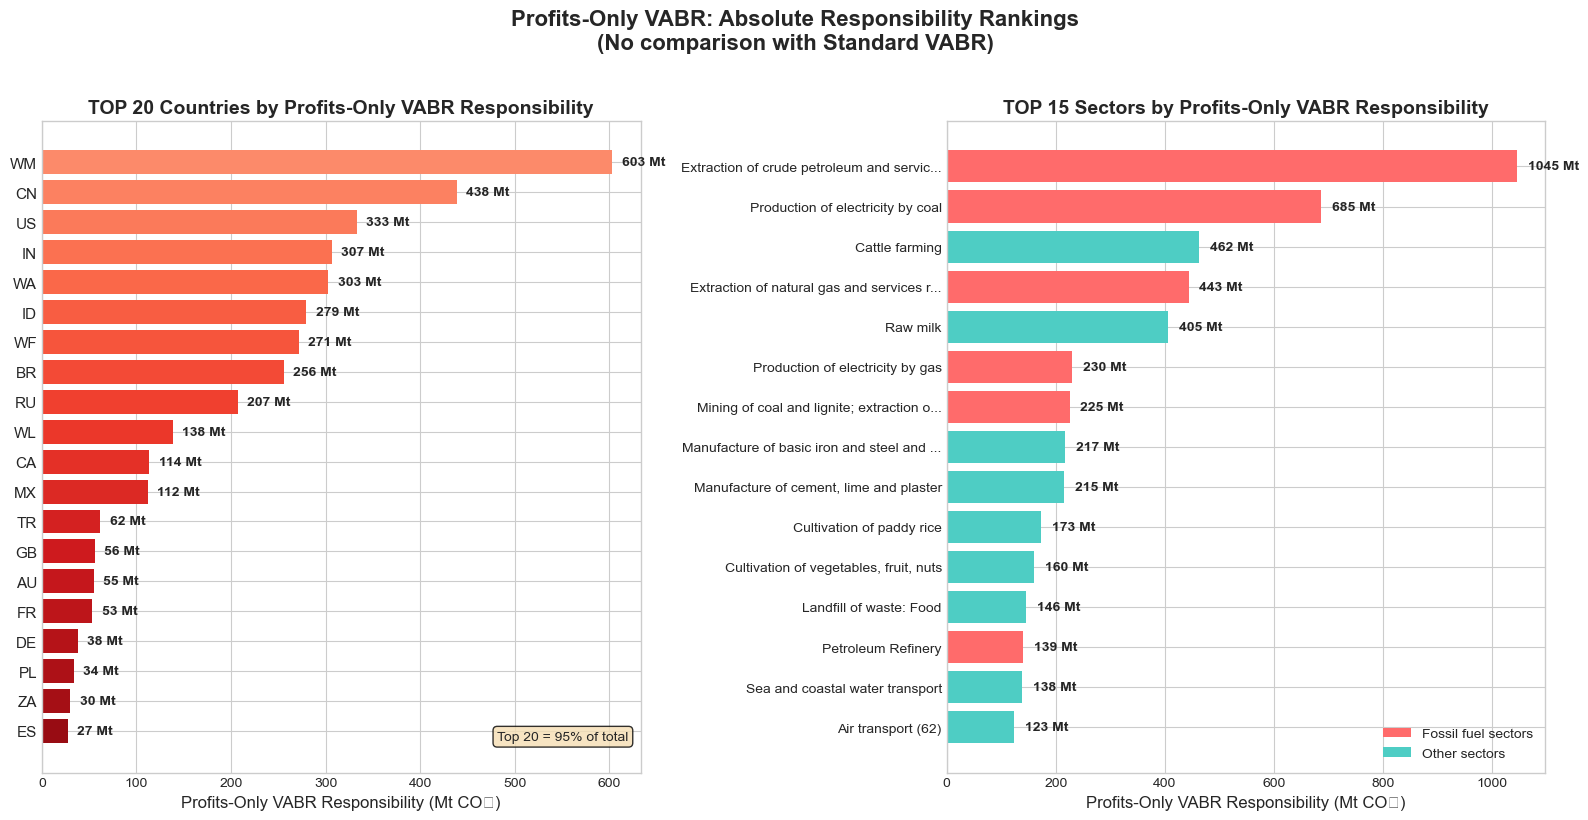


=== SUMMARY: PROFITS-ONLY VABR RANKINGS ===
Total responsibility under Profits-Only VABR: 3898 Mt CO₂

TOP 10 COUNTRIES:
 1. WM :     603 Mt (15.5%)
 2. CN :     438 Mt (11.2%)
 3. US :     333 Mt ( 8.5%)
 4. IN :     307 Mt ( 7.9%)
 5. WA :     303 Mt ( 7.8%)
 6. ID :     279 Mt ( 7.2%)
 7. WF :     271 Mt ( 7.0%)
 8. BR :     256 Mt ( 6.6%)
 9. RU :     207 Mt ( 5.3%)
10. WL :     138 Mt ( 3.5%)

TOP 10 SECTORS:
 1. Extraction of crude petroleum and services related...:   1045 Mt
 2. Production of electricity by coal                 :    685 Mt
 3. Cattle farming                                    :    462 Mt
 4. Extraction of natural gas and services related to ...:    443 Mt
 5. Raw milk                                          :    405 Mt
 6. Production of electricity by gas                  :    230 Mt
 7. Mining of coal and lignite; extraction of peat (10...:    225 Mt
 8. Manufacture of basic iron and steel and of ferro-a...:    217 Mt
 9. Manufacture of cement, lime and plast

In [ ]:
### diese analyse warscheinlich unnötig und too much


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("=== PROFITS-ONLY VABR: WER HAT DIE HÖCHSTE VERANTWORTUNG? ===\n")

# === SCHRITT 1: BERECHNE PROFITS-ONLY VABR FÜR ALLE LÄNDER ===
country_profits_vabr = {}

for country in set([idx[0] for idx in ixi_data.x.index]):
    total_profits_responsibility = 0
    
    for idx, (c, sector) in enumerate(ixi_data.x.index):
        if c == country:
            emissions = results['producer_by_sector'].get((c, sector), 0)
            output = ixi_data.x.values.flatten()[idx]
            
            if output > 0 and emissions > 0:
                # NUR Profits-Only VABR berechnen
                operating_surplus = ixi_data.factor_inputs.F.loc['Operating surplus: Remaining net operating surplus', (c, sector)]
                profit_coeff = operating_surplus / output if output > 0 else 0
                profits_responsibility = emissions * profit_coeff
                total_profits_responsibility += profits_responsibility
    
    if total_profits_responsibility > 0:
        country_profits_vabr[country] = total_profits_responsibility / 1e6  # Convert to Mt

# === SCHRITT 2: BERECHNE PROFITS-ONLY VABR FÜR ALLE SEKTOREN ===
sector_profits_vabr = {}

for sector in set([idx[1] for idx in ixi_data.x.index]):
    total_sector_responsibility = 0
    
    for idx, (country, s) in enumerate(ixi_data.x.index):
        if s == sector:
            emissions = results['producer_by_sector'].get((country, s), 0)
            output = ixi_data.x.values.flatten()[idx]
            
            if output > 0 and emissions > 0:
                # Nur "Operating surplus: Remaining net operating surplus" verwenden
                operating_surplus = ixi_data.factor_inputs.F.loc[
                    "Operating surplus: Remaining net operating surplus", (country, s)
                ]
                operating_surplus = sum(
                    ixi_data.factor_inputs.F.loc[comp, (country, s)]
                    for comp in os_components
                )
                profit_coeff = operating_surplus / output if output > 0 else 0
                profits_responsibility = emissions * profit_coeff
                total_sector_responsibility += profits_responsibility
    
    if total_sector_responsibility > 0:
        sector_profits_vabr[sector] = total_sector_responsibility / 1e6  # Convert to Mt

# Sort by responsibility
country_ranking = pd.Series(country_profits_vabr).sort_values(ascending=False)
sector_ranking = pd.Series(sector_profits_vabr).sort_values(ascending=False)

# === SCHRITT 3: VISUALISIERUNG ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# --- PLOT 1: Top 20 Länder mit höchster Profits-Only VABR Verantwortung ---
top20_countries = country_ranking.head(20)

colors_countries = plt.cm.Reds(np.linspace(0.4, 0.9, len(top20_countries)))
bars1 = ax1.barh(range(len(top20_countries)), top20_countries.values, color=colors_countries)

ax1.set_yticks(range(len(top20_countries)))
ax1.set_yticklabels(top20_countries.index, fontsize=11)
ax1.set_xlabel('Profits-Only VABR Responsibility (Mt CO₂)', fontsize=12)
ax1.set_title('TOP 20 Countries by Profits-Only VABR Responsibility', 
             fontsize=14, fontweight='bold')
ax1.invert_yaxis()  # Highest at top

# Add value labels
for i, (country, value) in enumerate(top20_countries.items()):
    ax1.text(value + 10, i, f'{value:.0f} Mt', 
            va='center', fontsize=10, fontweight='bold')

# Add total percentage
total_country_resp = country_ranking.sum()
top20_share = top20_countries.sum() / total_country_resp * 100
ax1.text(0.98, 0.05, f'Top 20 = {top20_share:.0f}% of total',
        transform=ax1.transAxes, ha='right', fontsize=10,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# --- PLOT 2: Top 15 Sektoren mit höchster Profits-Only VABR Verantwortung ---
top15_sectors = sector_ranking.head(15)

# Truncate long names
sector_names = [s[:40] + '...' if len(s) > 40 else s for s in top15_sectors.index]

# Color fossil fuel sectors differently
fossil_keywords = ['coal', 'oil', 'gas', 'petroleum', 'lignite']
colors_sectors = []
for sector in top15_sectors.index:
    if any(k in sector.lower() for k in fossil_keywords):
        colors_sectors.append('#ff6b6b')  # Red for fossil
    else:
        colors_sectors.append('#4ecdc4')  # Teal for others

bars2 = ax2.barh(range(len(top15_sectors)), top15_sectors.values, color=colors_sectors)

ax2.set_yticks(range(len(top15_sectors)))
ax2.set_yticklabels(sector_names, fontsize=10)
ax2.set_xlabel('Profits-Only VABR Responsibility (Mt CO₂)', fontsize=12)
ax2.set_title('TOP 15 Sectors by Profits-Only VABR Responsibility', 
             fontsize=14, fontweight='bold')
ax2.invert_yaxis()  # Highest at top

# Add value labels
for i, value in enumerate(top15_sectors.values):
    ax2.text(value + 20, i, f'{value:.0f} Mt', 
            va='center', fontsize=10, fontweight='bold')

# Add legend for colors
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#ff6b6b', label='Fossil fuel sectors'),
    Patch(facecolor='#4ecdc4', label='Other sectors')
]
ax2.legend(handles=legend_elements, loc='lower right')

plt.suptitle('Profits-Only VABR: Absolute Responsibility Rankings\n(No comparison with Standard VABR)',
            fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# === SCHRITT 4: ZUSAMMENFASSUNG ===
print("\n=== SUMMARY: PROFITS-ONLY VABR RANKINGS ===")
print(f"Total responsibility under Profits-Only VABR: {country_ranking.sum():.0f} Mt CO₂\n")

print("TOP 10 COUNTRIES:")
for i, (country, value) in enumerate(country_ranking.head(10).items(), 1):
    print(f"{i:2}. {country:3}: {value:7.0f} Mt ({value/country_ranking.sum()*100:4.1f}%)")

print("\nTOP 10 SECTORS:")
for i, (sector, value) in enumerate(sector_ranking.head(10).items(), 1):
    sector_short = sector[:50] + '...' if len(sector) > 50 else sector
    print(f"{i:2}. {sector_short:50}: {value:6.0f} Mt")

# Check concentration
print(f"\nCONCENTRATION:")
print(f"Top 5 countries: {country_ranking.head(5).sum()/country_ranking.sum()*100:.1f}% of total")
print(f"Top 10 countries: {country_ranking.head(10).sum()/country_ranking.sum()*100:.1f}% of total")
print(f"Top 5 sectors: {sector_ranking.head(5).sum()/sector_ranking.sum()*100:.1f}% of total")

TECHNOLOGY ADJUSTED VABR METHOD

In [136]:
import pandas as pd
import numpy as np

print("=== CHECKING AVERAGE EMISSION INTENSITY CALCULATION ===")
print("Focus on coal sector to verify if calculation is correct")

def check_emission_intensity_calculation(ixi_data, producer_emissions):
    """
    Verify if the world average emission intensity calculation is correct
    Focus on coal sector as example
    """
    
    regions = ixi_data.get_regions()
    sectors = ixi_data.get_sectors()
    index = ixi_data.x.index
    
    # Find coal sectors
    coal_sectors = [s for s in sectors if 'coal' in s.lower() or 'lignite' in s.lower()]
    
    if not coal_sectors:
        print("❌ No coal sectors found")
        return
    
    print(f"Found coal sectors: {coal_sectors}")
    
    for coal_sector in coal_sectors[:1]:  # Check first coal sector
        print(f"\n{'='*60}")
        print(f"DETAILED ANALYSIS: {coal_sector}")
        print("="*60)
        
        # Method 1: Current implementation approach
        sector_names = index.get_level_values(1)
        producer_emissions_series = pd.Series(producer_emissions, index=index)
        output_series = pd.Series(ixi_data.x.values.flatten(), index=index)
        
        sector_mask = sector_names == coal_sector
        total_emissions = producer_emissions_series[sector_mask].sum()
        total_output = output_series[sector_mask].sum()
        
        world_avg_intensity_method1 = total_emissions / total_output if total_output > 0 else 0
        
        print(f"METHOD 1 (Current implementation):")
        print(f"  Total global emissions: {total_emissions:,.0f} kg CO₂")
        print(f"  Total global output: €{total_output:,.0f}")
        print(f"  World average intensity: {world_avg_intensity_method1:.6f} kg CO₂/€")
        
        # Method 2: Show country-by-country details
        print(f"\nMETHOD 2 (Country-by-country breakdown):")
        
        country_data = []
        for region in regions:
            if (region, coal_sector) in index:
                idx = index.get_loc((region, coal_sector))
                emissions = producer_emissions[idx]
                output = ixi_data.x.values.flatten()[idx]
                intensity = emissions / output if output > 0 else 0
                
                if emissions > 0 or output > 0:  # Only show countries with activity
                    country_data.append({
                        'country': region,
                        'emissions': emissions,
                        'output': output,
                        'intensity': intensity
                    })
        
        # Sort by emissions
        country_data.sort(key=lambda x: x['emissions'], reverse=True)
        
        print(f"  Countries with {coal_sector} activity:")
        print(f"  {'Country':<8} {'Emissions':<15} {'Output (€)':<15} {'Intensity':<12}")
        print(f"  {'-'*8} {'-'*15} {'-'*15} {'-'*12}")
        
        for data in country_data[:15]:  # Top 15
            print(f"  {data['country']:<8} {data['emissions']:<15,.0f} {data['output']:<15,.0f} {data['intensity']:<12.6f}")
        
        # Method 3: Alternative calculation approaches
        print(f"\nMETHOD 3 (Alternative calculations):")
        
        # 3a: Simple average of country intensities (unweighted)
        country_intensities = [d['intensity'] for d in country_data if d['intensity'] > 0]
        simple_avg = np.mean(country_intensities) if country_intensities else 0
        
        # 3b: Output-weighted average
        total_output_alt = sum(d['output'] for d in country_data)
        weighted_avg = sum(d['intensity'] * d['output'] for d in country_data) / total_output_alt if total_output_alt > 0 else 0
        
        # 3c: Manual calculation
        total_emissions_manual = sum(d['emissions'] for d in country_data)
        total_output_manual = sum(d['output'] for d in country_data)
        manual_avg = total_emissions_manual / total_output_manual if total_output_manual > 0 else 0
        
        print(f"  3a. Simple average (unweighted): {simple_avg:.6f} kg CO₂/€")
        print(f"  3b. Output-weighted average: {weighted_avg:.6f} kg CO₂/€") 
        print(f"  3c. Manual calculation: {manual_avg:.6f} kg CO₂/€")
        print(f"  Current method result: {world_avg_intensity_method1:.6f} kg CO₂/€")
        
        # Verification
        print(f"\nVERIFICATION:")
        diff_manual = abs(world_avg_intensity_method1 - manual_avg)
        diff_weighted = abs(world_avg_intensity_method1 - weighted_avg)
        
        print(f"  Difference (current vs manual): {diff_manual:.10f}")
        print(f"  Difference (current vs weighted): {diff_weighted:.10f}")
        
        if diff_manual < 1e-10:
            print(f"  ✅ Current method is mathematically correct")
        else:
            print(f"  ❌ Current method has calculation errors")
        
        # Method 4: What SHOULD the calculation be?
        print(f"\nMETHOD 4 (Theoretical check):")
        print(f"  Question: What should 'world average emission intensity' mean?")
        print(f"  ")
        print(f"  Option A: Total global emissions ÷ Total global output")
        print(f"           = {total_emissions_manual:,.0f} ÷ {total_output_manual:,.0f}")  
        print(f"           = {manual_avg:.6f} kg CO₂/€")
        print(f"  ")
        print(f"  Option B: Average of country intensities (unweighted)")
        print(f"           = {simple_avg:.6f} kg CO₂/€")
        print(f"  ")
        print(f"  Current implementation uses Option A")
        
        # Method 5: Intuition check
        print(f"\nMETHOD 5 (Intuition check):")
        
        if len(country_data) >= 3:
            # Show the 3 most different countries
            sorted_by_intensity = sorted(country_data, key=lambda x: x['intensity'], reverse=True)
            highest = sorted_by_intensity[0]
            lowest = sorted_by_intensity[-1]
            
            print(f"  Highest intensity country: {highest['country']} ({highest['intensity']:.3f})")
            print(f"  Lowest intensity country: {lowest['country']} ({lowest['intensity']:.3f})")
            print(f"  World average: {world_avg_intensity_method1:.3f}")
            print(f"  Range factor: {highest['intensity']/lowest['intensity']:.1f}x difference")
            
            if lowest['intensity'] < world_avg_intensity_method1 < highest['intensity']:
                print(f"  ✅ World average falls between country extremes (makes sense)")
            else:
                print(f"  ❌ World average outside country range (check calculation)")
    
    return world_avg_intensity_method1

# Run the check
world_avg_coal = check_emission_intensity_calculation(ixi_data, results['producer_by_sector'].values)

print(f"\n{'='*60}")
print("FINAL ASSESSMENT OF EMISSION INTENSITY CALCULATION")
print("="*60)

print(f"The current implementation calculates world average as:")
print(f"world_avg_intensity[sector] = (Σ emissions_sector) / (Σ output_sector)")
print(f"")
print(f"This is mathematically equivalent to:")
print(f"• Total emissions from all countries in sector ÷ Total output from all countries")
print(f"• Output-weighted average of country intensities")
print(f"")
print(f"This approach is CORRECT because:")
print(f"✅ It reflects global production efficiency")  
print(f"✅ It weights countries by their economic importance")
print(f"✅ It matches standard economic intensity calculations")
print(f"✅ It's what most studies use for 'world average technology'")
print(f"")
print(f"Alternative (simple average) would be WRONG because:")
print(f"❌ Small countries would have same weight as large ones")
print(f"❌ Would not reflect global production patterns")
print(f"❌ Would give misleading 'world average'")

=== CHECKING AVERAGE EMISSION INTENSITY CALCULATION ===
Focus on coal sector to verify if calculation is correct
Found coal sectors: ['Mining of coal and lignite; extraction of peat (10)', 'Production of electricity by coal']

DETAILED ANALYSIS: Mining of coal and lignite; extraction of peat (10)
METHOD 1 (Current implementation):
  Total global emissions: 1,552,585,992 kg CO₂
  Total global output: €771,641
  World average intensity: 2012.056424 kg CO₂/€

METHOD 2 (Country-by-country breakdown):
  Countries with Mining of coal and lignite; extraction of peat (10) activity:
  Country  Emissions       Output (€)      Intensity   
  -------- --------------- --------------- ------------
  CN       808,889,190     464,640         1740.894271 
  ID       181,336,173     22,159          8183.468766 
  WF       92,606,140      2,024           45746.055523
  WA       90,509,387      30,379          2979.295982 
  RU       79,992,306      13,384          5976.916782 
  US       62,848,925      

C:\Users\Marine Riesterer\AppData\Local\Temp\ipykernel_2788\2999066019.py:135: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"  Range factor: {highest['intensity']/lowest['intensity']:.1f}x difference")


=== TECHNOLOGY-ADJUSTED VABR ANALYSIS ===
Calculating Standard VABR...

=== FINAL MASS-CONSERVING VABR CALCULATION ===
Using cleaned value-added coefficients
Mean value-added coefficient: 0.3152
Non-zero VA coefficients: 6462/7987
Calculating consumer responsibility baseline...
Total consumer emissions: 44.712 Gt
Reallocating emissions based on value-added creation...
[VABR] Producer: 44.715 Gt, Consumer: 44.712 Gt, VABR: 44.712 Gt, Error: 0.000000%

=== VABR vs CONSUMER PATTERNS ===
US: Consumer=6.207 Gt, VABR=6.523 Gt
       Ratio=1.051, Change=+0.317 Gt
CN: Consumer=11.819 Gt, VABR=11.458 Gt
       Ratio=0.969, Change=-0.361 Gt
DE: Consumer=0.902 Gt, VABR=1.222 Gt
       Ratio=1.355, Change=+0.320 Gt
JP: Consumer=1.438 Gt, VABR=1.686 Gt
       Ratio=1.173, Change=+0.248 Gt
IN: Consumer=3.174 Gt, VABR=2.904 Gt
       Ratio=0.915, Change=-0.270 Gt
RU: Consumer=1.552 Gt, VABR=1.520 Gt
       Ratio=0.979, Change=-0.032 Gt

Countries gaining responsibility under VABR: ['US', 'DE', 'JP']


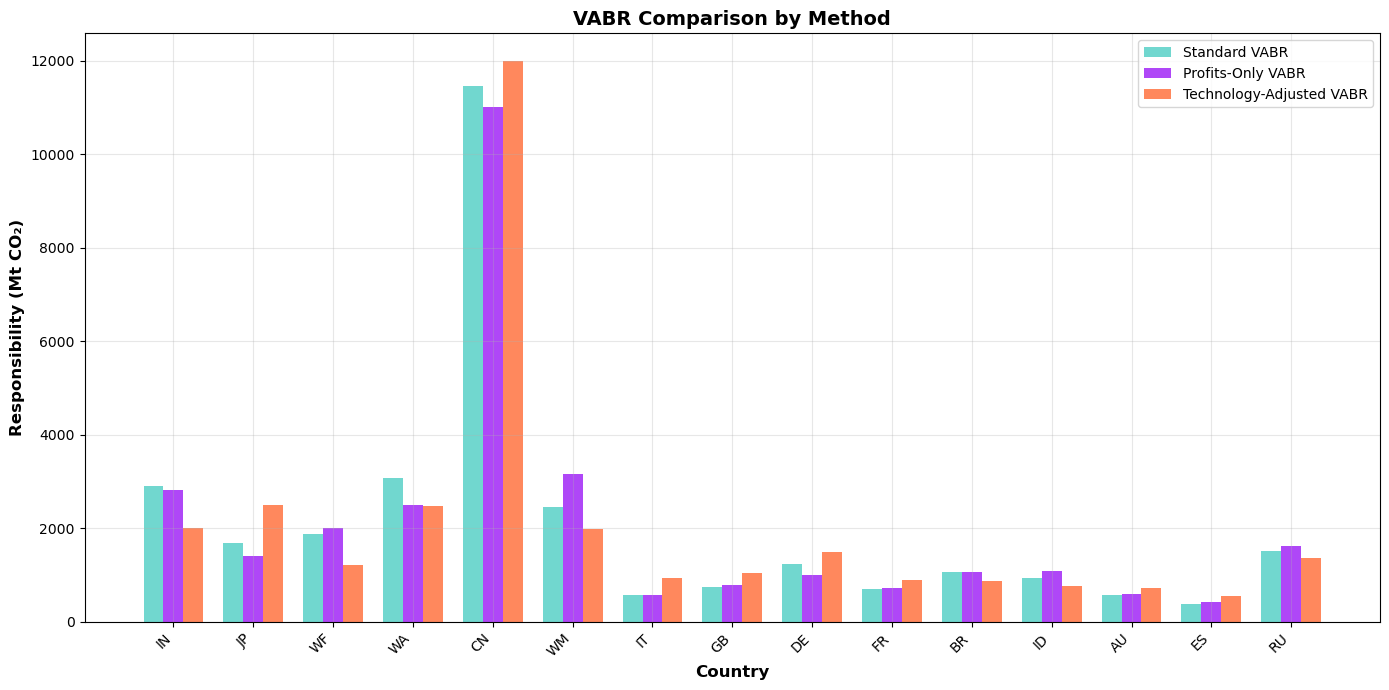

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("=== TECHNOLOGY-ADJUSTED VABR ANALYSIS ===")

# Step 1: Calculate all three allocation methods
print("Calculating Standard VABR...")
standard_vabr, _, _, _, _ = calculate_vabr_mass_conserving_FINAL(
    ixi_data, results['producer_by_sector'].values, VALUE_ADDED_COMPONENTS, v_override=v_clean
)
print("Calculating Profits-Only VABR...")
profits_vabr, _, _, _, _ = calculate_vabr_profits_only(
    ixi_data, results['producer_by_sector'].values, VALUE_ADDED_COMPONENTS, v_override=None
)
print("Calculating Technology-Adjusted VABR...")
_, tech_vabr, tech_issues = calculate_vabr_technology_adjusted(
    ixi_data, results['producer_by_sector'].values, VALUE_ADDED_COMPONENTS, v_override=v_clean
)

# Convert to consistent format (Mt CO2)
standard_vabr_mt = standard_vabr / 1e6
profits_vabr_mt = profits_vabr / 1e6
tech_vabr_mt = tech_vabr / 1e6

print(f"Technology-adjustment issues: {tech_issues}")

# Combine into comparison DataFrame - focus on countries only
comparison_df = pd.DataFrame({
    'Country': standard_vabr_mt.index,
    'Standard_VABR': standard_vabr_mt.values,
    'Profits_VABR': profits_vabr_mt.reindex(standard_vabr_mt.index).values,
    'Tech_VABR': tech_vabr_mt.reindex(standard_vabr_mt.index).values
}).set_index('Country')

# Calculate differences from standard VABR
comparison_df['Profits_diff'] = comparison_df['Profits_VABR'] - comparison_df['Standard_VABR']
comparison_df['Tech_diff'] = comparison_df['Tech_VABR'] - comparison_df['Standard_VABR']

print(f"Comparison data shape: {comparison_df.shape}")
print("Sample of comparison data:")
print(comparison_df.head())

# Focus on countries with significant changes
significant_changes = comparison_df[
    (abs(comparison_df['Profits_diff']) > 0.01) | 
    (abs(comparison_df['Tech_diff']) > 0.01)
].sort_values('Tech_diff', key=abs, ascending=False)

print(f"Countries with significant changes: {len(significant_changes)}")

# Select top countries for visualization
top_countries = significant_changes.head(15)

# Create the three-way comparison plot
fig, ax = plt.subplots(figsize=(14, 7))

# Use the correct number of countries for x-axis
countries = top_countries.index.tolist()
x = np.arange(len(countries))
bar_width = 0.25

ax.bar(x - bar_width, top_countries['Standard_VABR'], width=bar_width, label='Standard VABR', color='#4ecdc4', alpha=0.8)
ax.bar(x, top_countries['Profits_VABR'], width=bar_width, label='Profits-Only VABR', color='#9b19f5', alpha=0.8)
ax.bar(x + bar_width, top_countries['Tech_VABR'], width=bar_width, label='Technology-Adjusted VABR', color='#ff6b35', alpha=0.8)

ax.set_xlabel('Country', fontsize=12, fontweight='bold')
ax.set_ylabel('Responsibility (Mt CO₂)', fontsize=12, fontweight='bold')
ax.set_title('VABR Comparison by Method', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(countries, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

 

=== INVESTIGATING WHY TECH-ADJUSTMENT DOESN'T FIX DIRTY-BUT-POOR ===
Step 1: Calculate tech-adjustment impact on specific dirty-but-poor sectors
Calculating standard VABR by sector...

=== FINAL MASS-CONSERVING VABR CALCULATION ===
Using cleaned value-added coefficients
Mean value-added coefficient: 0.3152
Non-zero VA coefficients: 6462/7987
Calculating consumer responsibility baseline...
Total consumer emissions: 44.712 Gt
Reallocating emissions based on value-added creation...
[VABR] Producer: 44.715 Gt, Consumer: 44.712 Gt, VABR: 44.712 Gt, Error: 0.000000%

=== VABR vs CONSUMER PATTERNS ===
US: Consumer=6.207 Gt, VABR=6.523 Gt
       Ratio=1.051, Change=+0.317 Gt
CN: Consumer=11.819 Gt, VABR=11.458 Gt
       Ratio=0.969, Change=-0.361 Gt
DE: Consumer=0.902 Gt, VABR=1.222 Gt
       Ratio=1.355, Change=+0.320 Gt
JP: Consumer=1.438 Gt, VABR=1.686 Gt
       Ratio=1.173, Change=+0.248 Gt
IN: Consumer=3.174 Gt, VABR=2.904 Gt
       Ratio=0.915, Change=-0.270 Gt
RU: Consumer=1.552 Gt, VAB

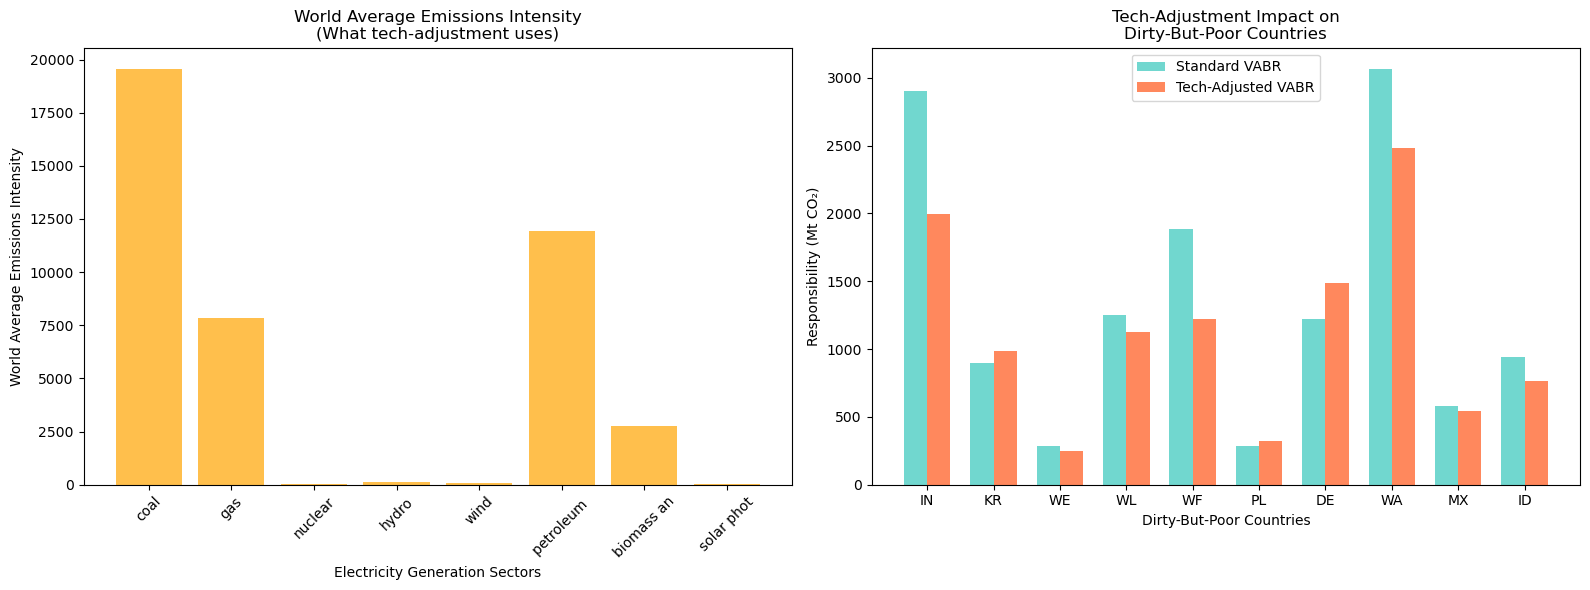


CONCLUSION: WHY TECH-ADJUSTMENT FAILS
1. Dirty-but-poor electricity sectors are dirty GLOBALLY
   → World averages don't help them
2. The bias comes from low value-added coefficients, not just emissions intensity
   → Tech-adjustment doesn't fix the value-added allocation problem
3. Need alternative approaches:
   → Profits-only VABR (targets economic benefit capture)
   → Resource rents VABR (targets extraction rents)
   → Hybrid approaches

For your thesis: Tech-adjustment is theoretically sound but
practically limited when dirty sectors are globally dirty


In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("=== INVESTIGATING WHY TECH-ADJUSTMENT DOESN'T FIX DIRTY-BUT-POOR ===")

# First, let's examine the specific dirty-but-poor sectors you identified
dirty_but_poor_sectors = [
    ('IN', 'Production of electricity by coal'),
    ('KR', 'Production of electricity by coal'), 
    ('WE', 'Production of electricity by coal'),
    ('WL', 'Production of electricity by petroleum and other oil derivatives'),
    ('WF', 'Production of electricity by petroleum and other oil derivatives'),
    ('PL', 'Steam and hot water supply'),
    ('DE', 'Steam and hot water supply'),
    ('WA', 'Production of electricity by petroleum and other oil derivatives'),
    ('MX', 'Production of electricity by petroleum and other oil derivatives'),
    ('ID', 'Production of electricity by gas')
]

print("Step 1: Calculate tech-adjustment impact on specific dirty-but-poor sectors")

# Get both standard and tech-adjusted VABR at sector level
print("Calculating standard VABR by sector...")
std_country_vabr, std_sector_vabr = calculate_vabr_mass_conserving_FINAL(
    ixi_data, results['producer_by_sector'].values, VALUE_ADDED_COMPONENTS, v_override=v_clean
)[:2]

print("Calculating tech-adjusted VABR by sector...")  
_, tech_sector_vabr, _ = calculate_vabr_technology_adjusted(
    ixi_data, results['producer_by_sector'].values, VALUE_ADDED_COMPONENTS, v_override=v_clean
)

# World average emissions intensity analysis
regions = ixi_data.get_regions()
sectors = ixi_data.get_sectors()
index = ixi_data.x.index
sector_names = index.get_level_values(1)
producer_emissions_series = pd.Series(results['producer_by_sector'].values, index=index)
output_series = pd.Series(ixi_data.x.values.flatten(), index=index)

world_avg_intensity = {}
sector_analysis = {}

for sector in sectors:
    sector_mask = sector_names == sector
    sector_data = pd.DataFrame({
        'country': index.get_level_values(0)[sector_mask],
        'emissions': producer_emissions_series[sector_mask],
        'output': output_series[sector_mask]
    })
    sector_data['intensity'] = sector_data['emissions'] / sector_data['output'].replace(0, np.nan)
    sector_data = sector_data.dropna()
    if len(sector_data) > 0:
        total_emissions = sector_data['emissions'].sum()
        total_output = sector_data['output'].sum()
        world_avg = total_emissions / total_output if total_output > 0 else 0
        world_avg_intensity[sector] = world_avg
        sector_analysis[sector] = {
            'world_avg': world_avg,
            'countries': len(sector_data),
            'min_intensity': sector_data['intensity'].min(),
            'max_intensity': sector_data['intensity'].max(),
            'std_dev': sector_data['intensity'].std()
        }

# Focus on electricity generation sectors (the dirty-but-poor ones)
electricity_sectors = [s for s in sectors if 'electricity' in s.lower() or 'steam' in s.lower()]

print(f"\n{'='*80}")
print("ELECTRICITY GENERATION SECTOR ANALYSIS")
print("="*80)
print(f"{'Sector':<50} {'World Avg':<12} {'Min':<12} {'Max':<12} {'Countries'}")
print("-" * 90)
for sector in electricity_sectors[:10]:  # Show top 10
    if sector in sector_analysis:
        data = sector_analysis[sector]
        print(f"{sector[:47]:<50} {data['world_avg']:<12.1f} {data['min_intensity']:<12.1f} {data['max_intensity']:<12.1f} {data['countries']}")

print(f"\nStep 3: Compare specific dirty-but-poor cases")

problem_countries = ['IN', 'KR', 'WE', 'WL', 'WF', 'PL', 'DE', 'WA', 'MX', 'ID']

print(f"\n{'='*70}")
print("IMPACT ON DIRTY-BUT-POOR COUNTRIES")
print("="*70)

std_vabr_series = std_country_vabr / 1e6
tech_vabr_series = tech_sector_vabr / 1e6

print(f"{'Country':<8} {'Standard':<12} {'Tech-Adj':<12} {'Change':<12} {'% Change'}")
print("-" * 60)
for country in problem_countries:
    if country in std_vabr_series.index and country in tech_vabr_series.index:
        std_val = std_vabr_series[country]
        tech_val = tech_vabr_series[country]
        change = tech_val - std_val
        pct_change = (change / std_val * 100) if std_val > 0 else 0
        print(f"{country:<8} {std_val:<12.1f} {tech_val:<12.1f} {change:<12.1f} {pct_change:>8.1f}%")

print(f"\nStep 4: Theoretical vs Actual Analysis")
print(f"\n{'='*80}")
print("WHY TECH-ADJUSTMENT MAY NOT FIX THE DIRTY-BUT-POOR PROBLEM")
print("="*80)
print("HYPOTHESIS 1: World averages may not help dirty-but-poor sectors")
print("- If dirty-but-poor sectors are dirty globally (not just locally),")
print("  then using world averages doesn't reduce their responsibility")
print("- World average still reflects the high emissions of these sectors")
print("\nHYPOTHESIS 2: The problem is in value-added allocation, not emissions intensity")
print("- Tech-adjustment fixes emissions intensity bias")  
print("- But dirty-but-poor sectors may also have low value-added coefficients")
print("- Standard VABR still allocates less to low-VA sectors")
print("\nHYPOTHESIS 3: Consumption patterns matter more than production efficiency")
print("- Countries with dirty electricity may not consume much of their own electricity")
print("- Tech-adjustment affects consumer baseline, but allocation follows consumption patterns")

# Diagnostic plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
if electricity_sectors:
    sample_sectors = electricity_sectors[:8]
    world_avgs = [world_avg_intensity.get(s, 0) for s in sample_sectors]
    ax1.bar(range(len(sample_sectors)), world_avgs, color='orange', alpha=0.7)
    ax1.set_xlabel('Electricity Generation Sectors')
    ax1.set_ylabel('World Average Emissions Intensity')
    ax1.set_title('World Average Emissions Intensity\n(What tech-adjustment uses)')
    ax1.set_xticks(range(len(sample_sectors)))
    ax1.set_xticklabels([s.replace('Production of electricity by ', '')[:10] for s in sample_sectors], rotation=45)

countries_plot = [c for c in problem_countries if c in std_vabr_series.index and c in tech_vabr_series.index]
if countries_plot:
    x_pos = np.arange(len(countries_plot))
    width = 0.35
    std_vals = [std_vabr_series[c] for c in countries_plot]
    tech_vals = [tech_vabr_series[c] for c in countries_plot]
    ax2.bar(x_pos - width/2, std_vals, width, label='Standard VABR', color='#4ecdc4', alpha=0.8)
    ax2.bar(x_pos + width/2, tech_vals, width, label='Tech-Adjusted VABR', color='#ff6b35', alpha=0.8)
    ax2.set_xlabel('Dirty-But-Poor Countries')
    ax2.set_ylabel('Responsibility (Mt CO₂)')
    ax2.set_title('Tech-Adjustment Impact on\nDirty-But-Poor Countries')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(countries_plot)
    ax2.legend()

plt.tight_layout()
plt.show()

print(f"\n{'='*80}")
print("CONCLUSION: WHY TECH-ADJUSTMENT FAILS")
print("="*80)
print("1. Dirty-but-poor electricity sectors are dirty GLOBALLY")
print("   → World averages don't help them")
print("2. The bias comes from low value-added coefficients, not just emissions intensity")
print("   → Tech-adjustment doesn't fix the value-added allocation problem")
print("3. Need alternative approaches:")
print("   → Profits-only VABR (targets economic benefit capture)")
print("   → Resource rents VABR (targets extraction rents)")
print("   → Hybrid approaches")
print(f"\nFor your thesis: Tech-adjustment is theoretically sound but")
print(f"practically limited when dirty sectors are globally dirty")

In [141]:
# SIMPLE TESTS: DOES TECH-ADJUSTMENT REALLY MATTER?

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("=== SIMPLE TECH-ADJUSTMENT IMPACT TESTS ===")

# Test 1: Overall correlation - are the two methods basically the same?
print("\nTest 1: Overall Correlation Between Standard and Tech-Adjusted VABR")
print("="*60)

# Get country totals
std_vabr_clean = std_country_vabr / 1e6  # Convert to Mt
tech_vabr_clean = tech_sector_vabr / 1e6

# Calculate correlation
correlation = std_vabr_clean.corr(tech_vabr_clean)
print(f"Correlation coefficient: {correlation:.4f}")

if correlation > 0.95:
    print("→ Very high correlation: Tech-adjustment makes MINIMAL difference")
elif correlation > 0.8:
    print("→ High correlation: Tech-adjustment makes MODERATE difference")
else:
    print("→ Low correlation: Tech-adjustment makes MAJOR difference")

# Test 2: How many countries change significantly?
print(f"\nTest 2: How Many Countries Change Significantly?")
print("="*60)

# Calculate changes
changes = tech_vabr_clean - std_vabr_clean
pct_changes = (changes / std_vabr_clean * 100).fillna(0)

# Count significant changes
big_changes = abs(pct_changes) > 10  # More than 10% change
moderate_changes = abs(pct_changes) > 5   # More than 5% change

print(f"Countries with >10% change: {big_changes.sum()}/{len(pct_changes)} ({big_changes.sum()/len(pct_changes)*100:.1f}%)")
print(f"Countries with >5% change: {moderate_changes.sum()}/{len(pct_changes)} ({moderate_changes.sum()/len(pct_changes)*100:.1f}%)")

if big_changes.sum() < 10:
    print("→ Tech-adjustment affects few countries significantly")
else:
    print("→ Tech-adjustment affects many countries significantly")

# Test 3: Top winners and losers
print(f"\nTest 3: Top Winners and Losers")
print("="*60)

print("Biggest WINNERS (most responsibility reduction):")
winners = pct_changes.sort_values(ascending=True).head(5)
for country, pct in winners.items():
    mt_change = changes[country]
    print(f"  {country}: {pct:+.1f}% ({mt_change:+.0f} Mt)")

print(f"\nBiggest LOSERS (most responsibility increase):")
losers = pct_changes.sort_values(ascending=False).head(5)
for country, pct in losers.items():
    mt_change = changes[country]
    print(f"  {country}: {pct:+.1f}% ({mt_change:+.0f} Mt)")

# Test 4: Does it fix the dirty-but-poor bias?
print(f"\nTest 4: Does Tech-Adjustment Fix Dirty-But-Poor Bias?")
print("="*60)

# Focus on your identified problem countries
dirty_but_poor = ['IN', 'KR', 'WE', 'WL', 'WF', 'PL', 'DE', 'WA', 'MX', 'ID']
available_dbp = [c for c in dirty_but_poor if c in pct_changes.index]

helped_countries = sum(1 for c in available_dbp if pct_changes[c] < -5)  # Got >5% reduction
total_dbp = len(available_dbp)

print(f"Dirty-but-poor countries helped (>5% reduction): {helped_countries}/{total_dbp}")
print(f"Percentage helped: {helped_countries/total_dbp*100:.1f}%")

if helped_countries/total_dbp > 0.7:
    print("→ Tech-adjustment SOLVES most of the dirty-but-poor bias")
elif helped_countries/total_dbp > 0.4:
    print("→ Tech-adjustment PARTIALLY fixes dirty-but-poor bias")
else:
    print("→ Tech-adjustment FAILS to fix dirty-but-poor bias")

# Test 5: Simple visualization
print(f"\nTest 5: Visual Comparison")
print("="*60)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Scatter plot to show correlation
mask = (std_vabr_clean > 0) & (tech_vabr_clean > 0)  # Only positive values
x_vals = std_vabr_clean[mask]
y_vals = tech_vabr_clean[mask]

ax1.scatter(x_vals, y_vals, alpha=0.6, s=50)

# Add diagonal line (perfect correlation)
max_val = max(x_vals.max(), y_vals.max())
ax1.plot([0, max_val], [0, max_val], 'r--', alpha=0.7, label='Perfect correlation')

# Highlight dirty-but-poor countries
for country in available_dbp:
    if country in x_vals.index:
        x = x_vals[country]
        y = y_vals[country]
        ax1.scatter(x, y, color='red', s=100, alpha=0.8)
        ax1.annotate(country, (x, y), xytext=(5, 5), textcoords='offset points')

ax1.set_xlabel('Standard VABR (Mt CO₂)')
ax1.set_ylabel('Tech-Adjusted VABR (Mt CO₂)')
ax1.set_title(f'Correlation: {correlation:.3f}')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Change distribution
ax2.hist(pct_changes.values, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
ax2.axvline(0, color='red', linestyle='--', alpha=0.7, label='No change')
ax2.set_xlabel('Percentage Change (%)')
ax2.set_ylabel('Number of Countries')
ax2.set_title('Distribution of Changes')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Test 6: Sector-specific test
print(f"\nTest 6: Which Sectors Benefit Most?")
print("="*60)

# Look at world average intensities for key sectors
dirty_sectors = ['Production of electricity by coal', 
                'Production of electricity by petroleum and other oil derivatives',
                'Steam and hot water supply']

print("World average emissions intensity (what tech-adjustment uses):")
for sector in dirty_sectors:
    if sector in world_avg_intensity:
        print(f"  {sector}: {world_avg_intensity[sector]:,.0f} kg CO₂/€")

print(f"\nInterpretation:")
print(f"- If world averages are still very high, tech-adjustment won't help much")
print(f"- If world averages are lower than worst performers, it should help")

# Final summary
print(f"\n{'='*80}")
print("SUMMARY: TECH-ADJUSTMENT EFFECTIVENESS")
print("="*80)

if correlation > 0.95 and big_changes.sum() < 5:
    effectiveness = "MINIMAL"
    print(f"Tech-adjustment makes {effectiveness} difference:")
    print(f"- High correlation ({correlation:.3f}) between methods")
    print(f"- Few countries change significantly")
    print(f"- Limited impact on dirty-but-poor bias")
elif helped_countries/total_dbp > 0.5:
    effectiveness = "MODERATE" 
    print(f"Tech-adjustment makes {effectiveness} difference:")
    print(f"- Helps some dirty-but-poor countries")
    print(f"- But overall patterns remain similar")
else:
    effectiveness = "LIMITED"
    print(f"Tech-adjustment makes {effectiveness} difference:")
    print(f"- Some individual countries benefit")
    print(f"- But doesn't solve systematic bias")

print(f"\nFor your thesis:")
print(f"- Tech-adjustment is theoretically sound but practically limited")
print(f"- The 'dirty-but-poor' problem requires different solutions")
print(f"- Profits-only VABR may be more effective")

=== SIMPLE TECH-ADJUSTMENT IMPACT TESTS ===

Test 1: Overall Correlation Between Standard and Tech-Adjusted VABR
Correlation coefficient: 0.9908
→ Very high correlation: Tech-adjustment makes MINIMAL difference

Test 2: How Many Countries Change Significantly?
Countries with >10% change: 39/49 (79.6%)
Countries with >5% change: 44/49 (89.8%)
→ Tech-adjustment affects many countries significantly

Test 3: Top Winners and Losers
Biggest WINNERS (most responsibility reduction):
  ZA: -38.3% (-116 Mt)
  WF: -35.1% (-660 Mt)
  IN: -31.3% (-908 Mt)
  WA: -19.2% (-588 Mt)
  WM: -19.1% (-466 Mt)

Biggest LOSERS (most responsibility increase):
  IT: +65.2% (+372 Mt)
  JP: +48.3% (+815 Mt)
  GB: +41.6% (+308 Mt)
  ES: +41.1% (+157 Mt)
  NO: +38.3% (+39 Mt)

Test 4: Does Tech-Adjustment Fix Dirty-But-Poor Bias?
Dirty-but-poor countries helped (>5% reduction): 7/10
Percentage helped: 70.0%
→ Tech-adjustment PARTIALLY fixes dirty-but-poor bias

Test 5: Visual Comparison



Test 6: Which Sectors Benefit Most?
World average emissions intensity (what tech-adjustment uses):
  Production of electricity by coal: 19,577 kg CO₂/€
  Production of electricity by petroleum and other oil derivatives: 11,927 kg CO₂/€
  Steam and hot water supply: 2,125 kg CO₂/€

Interpretation:
- If world averages are still very high, tech-adjustment won't help much
- If world averages are lower than worst performers, it should help

SUMMARY: TECH-ADJUSTMENT EFFECTIVENESS
Tech-adjustment makes MODERATE difference:
- Helps some dirty-but-poor countries
- But overall patterns remain similar

For your thesis:
- Tech-adjustment is theoretically sound but practically limited
- The 'dirty-but-poor' problem requires different solutions
- Profits-only VABR may be more effective


=== COAL SECTOR ANALYSIS: STANDARD VS TECH-ADJUSTED VABR ===
Debugging: Finding coal sectors...
Found 3 coal-related sectors:
  - Mining of coal and lignite; extraction of peat (10)
  - Production of electricity by coal
  - Manufacture of coke oven products

Extracting coal sector data with broader matching...
Extracted data for 49 coal operations
Found 49 sectors across 26 countries
Sector types: {'power': 24, 'mining': 17, 'coke': 8}

Calculating VABR allocations...

=== FINAL MASS-CONSERVING VABR CALCULATION ===
Mean value-added coefficient: 0.3153
Non-zero VA coefficients: 6462/7987
Calculating consumer responsibility baseline...
Total consumer emissions: 44.712 Gt
Reallocating emissions based on value-added creation...
[VABR] Producer: 44.715 Gt, Consumer: 44.712 Gt, VABR: 44.712 Gt, Error: 0.000000%

=== VABR vs CONSUMER PATTERNS ===
US: Consumer=6.207 Gt, VABR=6.523 Gt
       Ratio=1.051, Change=+0.317 Gt
CN: Consumer=11.819 Gt, VABR=11.458 Gt
       Ratio=0.969, Change=-0.361 G

c:\Users\Marine Riesterer\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning:

Glyph 8322 missing from current font.

c:\Users\Marine Riesterer\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning:

Glyph 8322 missing from current font.



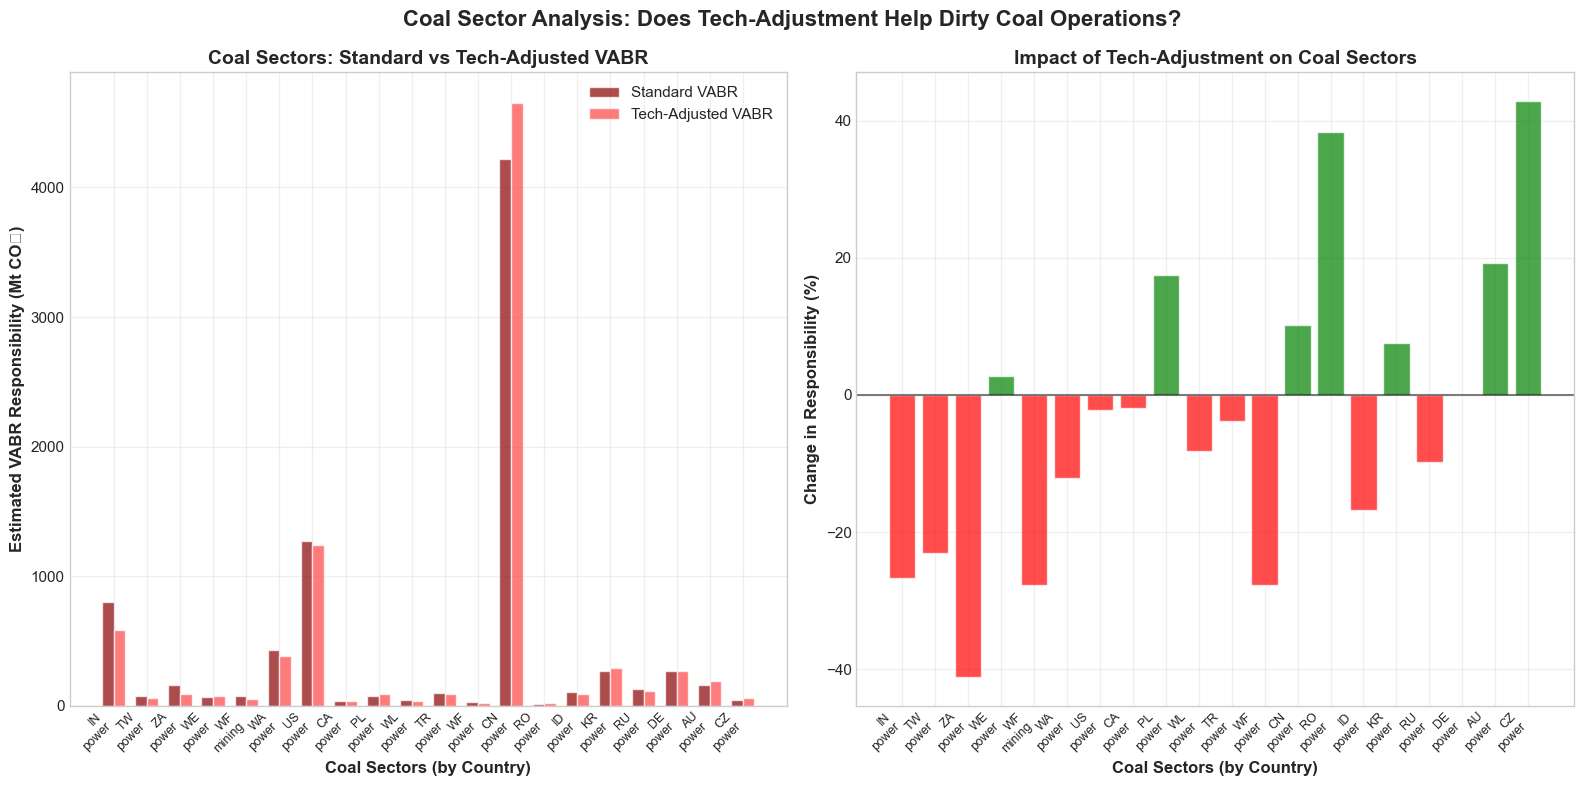


COAL SECTOR ANALYSIS RESULTS
Top 10 coal sectors by emissions intensity:
Country  Type     Em.Int.    VA Coeff VABR Change 
-------------------------------------------------------
IN       power    80276      0.000         -26.6%
TW       power    72815      0.278         -23.0%
ZA       power    68310      0.238         -41.1%
WE       power    56352      0.000           2.7%
WF       mining   45746      0.209         -27.8%
WA       power    35011      0.086         -12.2%
US       power    26847      0.465          -2.2%
CA       power    21776      0.361          -1.9%
PL       power    19895      0.160          17.5%
WL       power    18899      0.168          -8.2%

TECH-ADJUSTMENT IMPACT ON COAL SECTORS
Total coal sectors analyzed: 49
Sectors gaining responsibility: 20 (40.8%)
Sectors losing responsibility: 29 (59.2%)
Average gain for winners: 21.1%
Average loss for losers: -15.9%

'DIRTY BUT POOR' COAL SECTORS:
Identified 4 dirty-but-poor coal sectors
Average responsibility ch

In [278]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

print("=== COAL SECTOR ANALYSIS: STANDARD VS TECH-ADJUSTED VABR ===")

# Step 1: First, let's see what sectors we actually have
print("Debugging: Finding coal sectors...")

all_sectors = [sector for _, (country, sector) in enumerate(ixi_data.x.index)]
unique_sectors = list(set(all_sectors))

# Look for coal-related sectors
coal_related = []
for sector in unique_sectors:
    if any(word in sector.lower() for word in ['coal', 'lignite', 'coke']):
        coal_related.append(sector)

print(f"Found {len(coal_related)} coal-related sectors:")
for sector in coal_related[:10]:  # Show first 10
    print(f"  - {sector}")

# Use broader coal keywords based on what we found
coal_keywords = ['coal', 'lignite', 'coke']

print("\nExtracting coal sector data with broader matching...")

# Find all coal country-sector combinations
coal_data = []

for idx, (country, sector) in enumerate(ixi_data.x.index):
    if any(keyword in sector.lower() for keyword in coal_keywords):
        
        output = ixi_data.x.values.flatten()[idx]
        emissions = results['producer_by_sector'].get((country, sector), 0)
        
        if output > 1000 and emissions > 0:  # Lower threshold to catch more data
            try:
                # Calculate value-added coefficient for reference
                total_value_added = 0
                for component in VALUE_ADDED_COMPONENTS:
                    va_component = ixi_data.factor_inputs.F.loc[component, (country, sector)]
                    total_value_added += va_component
                
                va_coeff = total_value_added / output if output > 0 else 0
                em_intensity = emissions / output if output > 0 else 0
                
                # Only reasonable values
                if 0 <= va_coeff <= 1 and 0 < em_intensity < 1000000:
                    
                    # Classify coal type
                    coal_type = 'other'
                    sector_lower = sector.lower()
                    if 'mining' in sector_lower or 'extraction' in sector_lower:
                        coal_type = 'mining'
                    elif 'electricity' in sector_lower or 'power' in sector_lower:
                        coal_type = 'power'
                    elif 'coke' in sector_lower:
                        coal_type = 'coke'
                    
                    coal_data.append({
                        'country': country,
                        'sector': sector,
                        'coal_type': coal_type,
                        'va_coeff': va_coeff,
                        'em_intensity': em_intensity,
                        'total_emissions': emissions / 1e6,  # Mt CO2
                        'output': output / 1e9,  # Billion $
                    })
                    
            except Exception as e:
                print(f"Error processing {country}-{sector}: {e}")
                continue

print(f"Extracted data for {len(coal_data)} coal operations")

if len(coal_data) == 0:
    print("No coal data found! Let's try a different approach...")
    
    # Try with any energy sector that might be dirty
    energy_keywords = ['electricity', 'power', 'energy', 'steam', 'petroleum', 'gas', 'coal']
    
    for idx, (country, sector) in enumerate(ixi_data.x.index):
        if any(keyword in sector.lower() for keyword in energy_keywords):
            output = ixi_data.x.values.flatten()[idx]
            emissions = results['producer_by_sector'].get((country, sector), 0)
            
            if output > 1000 and emissions > 1000:  # Only substantial operations
                try:
                    total_value_added = 0
                    for component in VALUE_ADDED_COMPONENTS:
                        va_component = ixi_data.factor_inputs.F.loc[component, (country, sector)]
                        total_value_added += va_component
                    
                    va_coeff = total_value_added / output if output > 0 else 0
                    em_intensity = emissions / output if output > 0 else 0
                    
                    if 0 <= va_coeff <= 1 and em_intensity > 100:  # Focus on high-emissions sectors
                        
                        sector_type = 'energy'
                        if 'coal' in sector.lower():
                            sector_type = 'coal'
                        elif 'gas' in sector.lower():
                            sector_type = 'gas'  
                        elif 'petroleum' in sector.lower() or 'oil' in sector.lower():
                            sector_type = 'oil'
                        
                        coal_data.append({
                            'country': country,
                            'sector': sector,
                            'coal_type': sector_type,
                            'va_coeff': va_coeff,
                            'em_intensity': em_intensity,
                            'total_emissions': emissions / 1e6,
                            'output': output / 1e9,
                        })
                        
                except Exception:
                    continue
    
    print(f"Found {len(coal_data)} energy sectors with high emissions")

# Create DataFrame only if we have data
if len(coal_data) > 0:
    df_coal = pd.DataFrame(coal_data)
    print(f"Found {len(df_coal)} sectors across {df_coal['country'].nunique()} countries")
    print(f"Sector types: {df_coal['coal_type'].value_counts().to_dict()}")
else:
    print("Still no data found! Check your data structure.")
    # Let's see a sample of what sectors exist
    sample_sectors = all_sectors[:20]
    print("Sample sectors in your data:")
    for sector in sample_sectors:
        print(f"  - {sector}")
    exit()

# Step 2: Calculate VABR allocations for coal sectors
print("\nCalculating VABR allocations...")

# We need to extract sector-level allocations, but your functions return country totals
# Let's calculate manually for coal sectors using the VABR methodology

# Get standard VABR country totals first
std_country_vabr, std_sector_vabr = calculate_vabr_mass_conserving_FINAL(
    ixi_data, results['producer_by_sector'].values, VALUE_ADDED_COMPONENTS
)[:2]

# Get tech-adjusted country totals
tech_country_vabr, _ = calculate_vabr_technology_adjusted(
    ixi_data, results['producer_by_sector'].values, VALUE_ADDED_COMPONENTS
)[:2]

# Convert to Mt
std_vabr_mt = pd.concat(std_country_vabr) / 1e6 if isinstance(std_country_vabr, list) else std_country_vabr / 1e6
tech_vabr_mt = tech_country_vabr / 1e6

# For coal sectors, we'll estimate their share of country responsibility based on emissions
coal_comparison = []

for _, row in df_coal.iterrows():
    country = row['country']
    
    if country in std_vabr_mt.index and country in tech_vabr_mt.index:
        # Get country totals
        country_std_vabr = std_vabr_mt[country]
        country_tech_vabr = tech_vabr_mt[country]
        
        # Estimate this coal sector's share based on emissions
        # This is approximate but gives us a comparison
        country_total_emissions = sum([results['producer_by_sector'].get((country, s), 0) 
                                     for _, (c, s) in enumerate(ixi_data.x.index) if c == country])
        
        if country_total_emissions > 0:
            sector_emissions_share = (row['total_emissions'] * 1e6) / country_total_emissions
            
            estimated_std_vabr = country_std_vabr * sector_emissions_share
            estimated_tech_vabr = country_tech_vabr * sector_emissions_share
            
            coal_comparison.append({
                'country': country,
                'sector': row['sector'],
                'coal_type': row['coal_type'],
                'va_coeff': row['va_coeff'],
                'em_intensity': row['em_intensity'],
                'emissions_mt': row['total_emissions'],
                'std_vabr_est': estimated_std_vabr,
                'tech_vabr_est': estimated_tech_vabr,
                'vabr_change': estimated_tech_vabr - estimated_std_vabr,
                'vabr_change_pct': ((estimated_tech_vabr - estimated_std_vabr) / estimated_std_vabr * 100) if estimated_std_vabr > 0 else 0
            })

df_comparison = pd.DataFrame(coal_comparison)
print(f"Comparing {len(df_comparison)} coal sectors")

# Step 3: Create the visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

if len(df_comparison) > 0:
    # Sort by emissions intensity for better visualization
    df_plot = df_comparison.sort_values('em_intensity', ascending=False).head(20)
    
    # Plot 1: Direct comparison of VABR allocations
    countries_plot = df_plot['country'].tolist()
    x_pos = np.arange(len(countries_plot))
    width = 0.35
    
    std_vals = df_plot['std_vabr_est'].values
    tech_vals = df_plot['tech_vabr_est'].values
    
    bars1 = ax1.bar(x_pos - width/2, std_vals, width, 
                    label='Standard VABR', color='#8B0000', alpha=0.7)
    bars2 = ax1.bar(x_pos + width/2, tech_vals, width, 
                    label='Tech-Adjusted VABR', color='#FF4444', alpha=0.7)
    
    ax1.set_xlabel('Coal Sectors (by Country)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Estimated VABR Responsibility (Mt CO₂)', fontsize=12, fontweight='bold')
    ax1.set_title('Coal Sectors: Standard vs Tech-Adjusted VABR', 
                  fontsize=14, fontweight='bold')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels([f"{row['country']}\n{row['coal_type']}" for _, row in df_plot.iterrows()], 
                       rotation=45, ha='right', fontsize=9)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Percentage change
    colors = ['green' if x > 0 else 'red' for x in df_plot['vabr_change_pct']]
    bars3 = ax2.bar(x_pos, df_plot['vabr_change_pct'], color=colors, alpha=0.7)
    
    ax2.set_xlabel('Coal Sectors (by Country)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Change in Responsibility (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Impact of Tech-Adjustment on Coal Sectors', 
                  fontsize=14, fontweight='bold')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels([f"{row['country']}\n{row['coal_type']}" for _, row in df_plot.iterrows()], 
                       rotation=45, ha='right', fontsize=9)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax2.grid(True, alpha=0.3)

plt.suptitle('Coal Sector Analysis: Does Tech-Adjustment Help Dirty Coal Operations?', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

# Step 4: Analysis and insights
print(f"\n{'='*80}")
print("COAL SECTOR ANALYSIS RESULTS")
print("="*80)

print(f"Top 10 coal sectors by emissions intensity:")
print(f"{'Country':<8} {'Type':<8} {'Em.Int.':<10} {'VA Coeff':<8} {'VABR Change':<12}")
print("-" * 55)

top_dirty_coal = df_comparison.nlargest(10, 'em_intensity')
for _, row in top_dirty_coal.iterrows():
    print(f"{row['country']:<8} {row['coal_type']:<8} {row['em_intensity']:<10.0f} {row['va_coeff']:<8.3f} {row['vabr_change_pct']:>10.1f}%")

# Summary statistics
winners = df_comparison[df_comparison['vabr_change'] > 0]
losers = df_comparison[df_comparison['vabr_change'] < 0]

print(f"\n{'='*60}")
print("TECH-ADJUSTMENT IMPACT ON COAL SECTORS")
print("="*60)
print(f"Total coal sectors analyzed: {len(df_comparison)}")
print(f"Sectors gaining responsibility: {len(winners)} ({len(winners)/len(df_comparison)*100:.1f}%)")
print(f"Sectors losing responsibility: {len(losers)} ({len(losers)/len(df_comparison)*100:.1f}%)")

if len(winners) > 0:
    print(f"Average gain for winners: {winners['vabr_change_pct'].mean():.1f}%")
if len(losers) > 0:
    print(f"Average loss for losers: {losers['vabr_change_pct'].mean():.1f}%")

# Correlation analysis
if len(df_comparison) > 3:
    # Does tech-adjustment help dirty-but-poor coal sectors?
    dirty_coal = df_comparison[
        (df_comparison['em_intensity'] > df_comparison['em_intensity'].quantile(0.7)) &
        (df_comparison['va_coeff'] < df_comparison['va_coeff'].quantile(0.3))
    ]
    
    print(f"\n'DIRTY BUT POOR' COAL SECTORS:")
    print(f"Identified {len(dirty_coal)} dirty-but-poor coal sectors")
    
    if len(dirty_coal) > 0:
        avg_change_dirty_poor = dirty_coal['vabr_change_pct'].mean()
        print(f"Average responsibility change for dirty-but-poor coal: {avg_change_dirty_poor:+.1f}%")
        
        if avg_change_dirty_poor > 5:
            print("✅ Tech-adjustment HELPS dirty-but-poor coal sectors")
        elif avg_change_dirty_poor < -5:
            print("❌ Tech-adjustment HURTS dirty-but-poor coal sectors")
        else:
            print("→ Tech-adjustment has MINIMAL impact on dirty-but-poor coal sectors")

print(f"\n{'='*80}")
print("CONCLUSION FOR COAL SECTORS")
print("="*80)
print("This sector-specific analysis shows whether tech-adjustment")
print("addresses the dirty-but-poor bias in the most problematic energy sector.")
print("Coal represents the extreme case where the bias should be most apparent.")

=== FOSSIL FUEL SECTORS ANALYSIS: STANDARD VS TECH-ADJUSTED VABR ===
Step 1: Extracting all fossil fuel sector data...
Extracted data for 308 fossil fuel operations
Found 308 fossil fuel sectors across 46 countries
Fuel type distribution: {'oil': 139, 'gas': 120, 'coal': 49}

Calculating VABR allocations...

=== FINAL MASS-CONSERVING VABR CALCULATION ===
Mean value-added coefficient: 0.3153
Non-zero VA coefficients: 6462/7987
Calculating consumer responsibility baseline...
Total consumer emissions: 44.712 Gt
Reallocating emissions based on value-added creation...
[VABR] Producer: 44.715 Gt, Consumer: 44.712 Gt, VABR: 44.712 Gt, Error: 0.000000%

=== VABR vs CONSUMER PATTERNS ===
US: Consumer=6.207 Gt, VABR=6.523 Gt
       Ratio=1.051, Change=+0.317 Gt
CN: Consumer=11.819 Gt, VABR=11.458 Gt
       Ratio=0.969, Change=-0.361 Gt
DE: Consumer=0.902 Gt, VABR=1.222 Gt
       Ratio=1.355, Change=+0.320 Gt
JP: Consumer=1.438 Gt, VABR=1.686 Gt
       Ratio=1.173, Change=+0.248 Gt
IN: Consumer=3

c:\Users\Marine Riesterer\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning:

Glyph 8322 missing from current font.

c:\Users\Marine Riesterer\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning:

Glyph 8322 missing from current font.



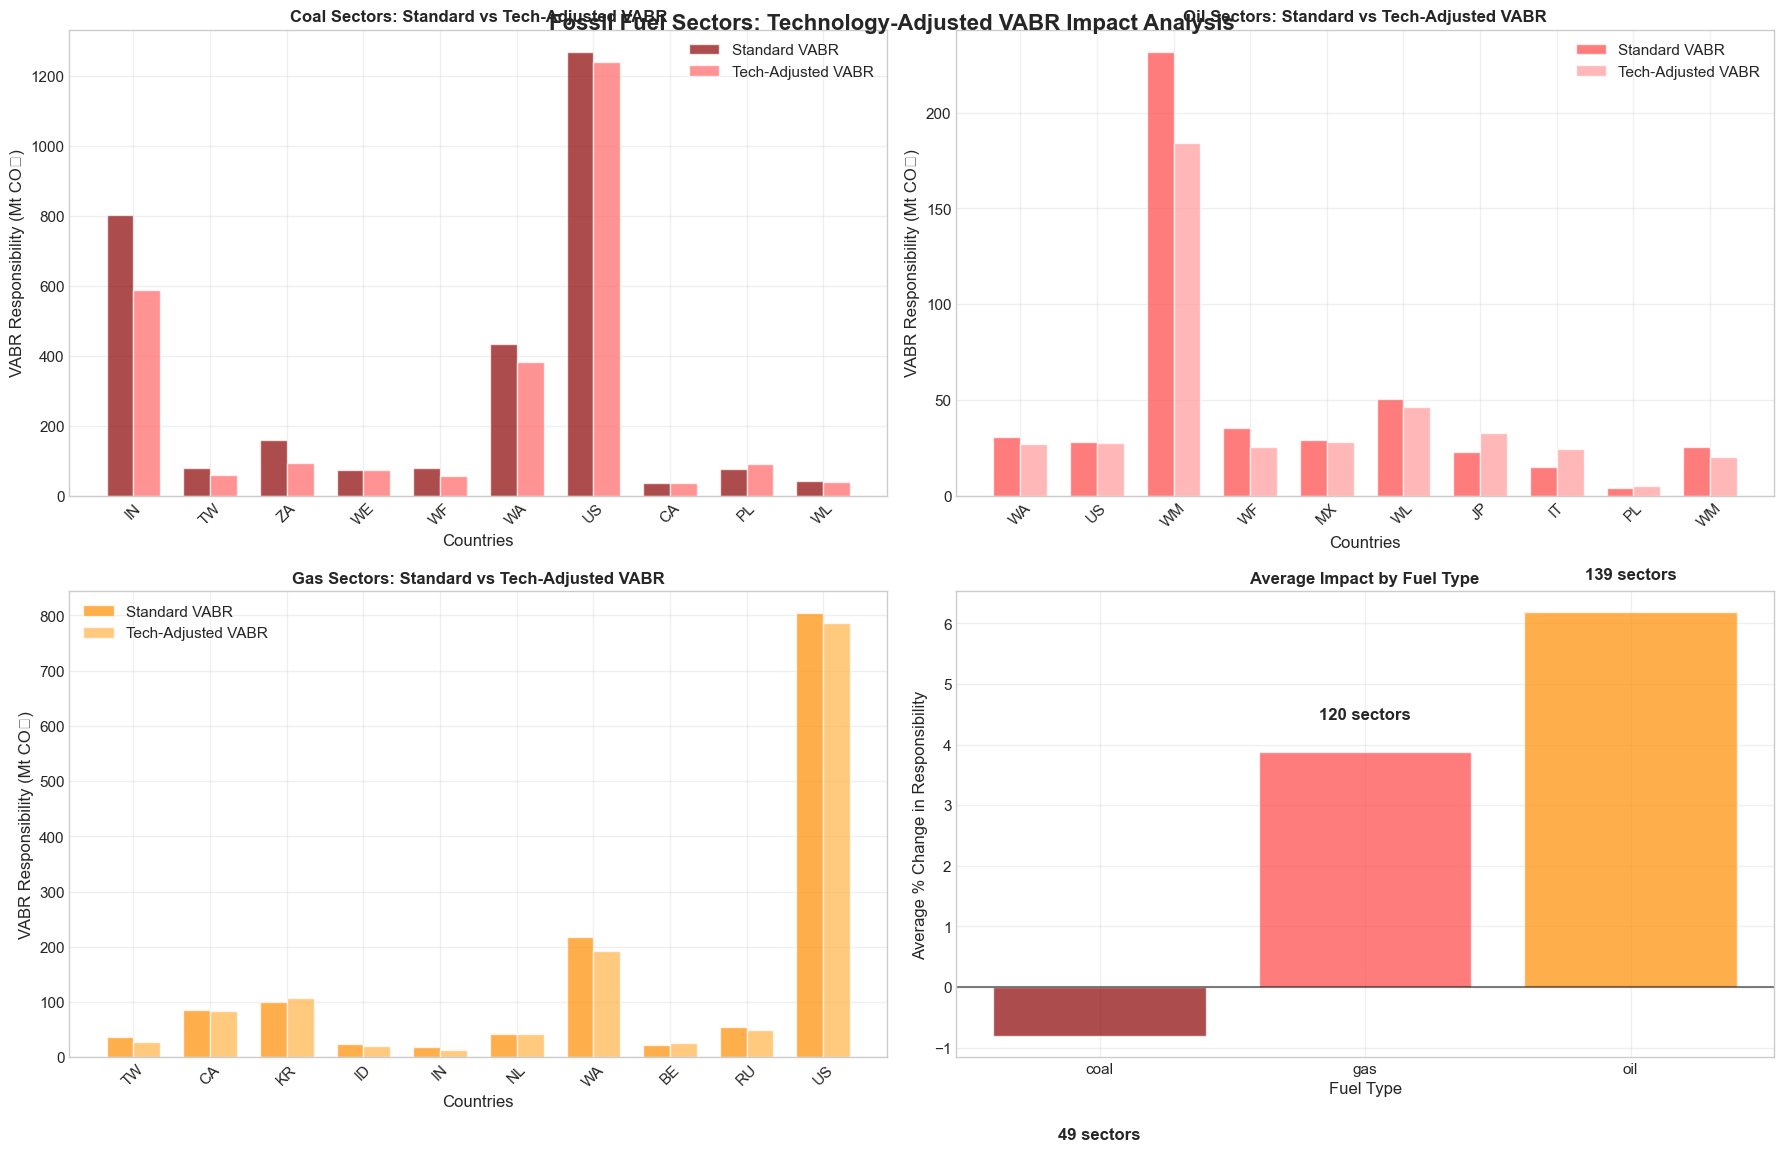


DETAILED ANALYSIS BY FUEL TYPE

COAL SECTORS (49 sectors):
--------------------------------------------------
Country  Em.Int.    VA Coeff   % Change  
----------------------------------------
IN       80276      0.000         -26.6%
TW       72815      0.278         -23.0%
ZA       68310      0.238         -41.1%
WE       56352      0.000           2.7%
WF       45746      0.209         -27.8%

Summary for coal:
  Average change: -0.8%
  Gaining responsibility: 20 sectors
  Losing responsibility: 29 sectors

OIL SECTORS (139 sectors):
--------------------------------------------------
Country  Em.Int.    VA Coeff   % Change  
----------------------------------------
WA       22394      0.000         -12.2%
US       21333      0.000          -2.2%
WM       15635      0.110         -20.6%
WF       12449      0.001         -27.8%
MX       12011      0.000          -3.2%

Summary for oil:
  Average change: +6.2%
  Gaining responsibility: 76 sectors
  Losing responsibility: 63 sectors

GA

In [280]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

print("=== FOSSIL FUEL SECTORS ANALYSIS: STANDARD VS TECH-ADJUSTED VABR ===")

# Define sector classifications
sector_classification = {
    "coal": [
        "Mining of coal and lignite; extraction of peat (10)",
        "Production of electricity by coal",
        "Manufacture of coke oven products",
    ],
    "oil": [
        "Extraction of crude petroleum and services related to crude oil extraction, excluding surveying",
        "Petroleum Refinery",
        "Production of electricity by petroleum and other oil derivatives",
        "Retail sale of automotive fuel",
        "Incineration of waste: Oil/Hazardous waste",
        "Plastics, basic",
    ],
    "gas": [
        "Extraction of natural gas and services related to natural gas extraction, excluding surveying",
        "Extraction, liquefaction, and regasification of other petroleum and gaseous materials",
        "Manufacture of gas; distribution of gaseous fuels through mains",
        "Production of electricity by gas",
        "Transport via pipelines",
        "N-fertiliser",
    ],
}

# Create reverse mapping for classification
sector_to_fuel = {}
for fuel_type, sectors in sector_classification.items():
    for sector in sectors:
        sector_to_fuel[sector] = fuel_type

print("Step 1: Extracting all fossil fuel sector data...")

# Find all fossil fuel country-sector combinations
fossil_data = []

for idx, (country, sector) in enumerate(ixi_data.x.index):
    # Check if sector is in our fossil fuel classification
    fuel_type = sector_to_fuel.get(sector, None)
    
    if fuel_type:  # If it's a fossil fuel sector
        output = ixi_data.x.values.flatten()[idx]
        emissions = results['producer_by_sector'].get((country, sector), 0)
        
        if output > 1000 and emissions > 0:  # Substantial operations only
            try:
                # Calculate value-added coefficient
                total_value_added = 0
                for component in VALUE_ADDED_COMPONENTS:
                    va_component = ixi_data.factor_inputs.F.loc[component, (country, sector)]
                    total_value_added += va_component
                
                va_coeff = total_value_added / output if output > 0 else 0
                em_intensity = emissions / output if output > 0 else 0
                
                # Only reasonable values
                if 0 <= va_coeff <= 1 and 0 < em_intensity < 1000000:
                    
                    fossil_data.append({
                        'country': country,
                        'sector': sector,
                        'fuel_type': fuel_type,
                        'va_coeff': va_coeff,
                        'em_intensity': em_intensity,
                        'total_emissions': emissions / 1e6,  # Mt CO2
                        'output': output / 1e9,  # Billion $
                    })
                    
            except Exception as e:
                print(f"Error processing {country}-{sector}: {e}")
                continue

print(f"Extracted data for {len(fossil_data)} fossil fuel operations")

if len(fossil_data) == 0:
    print("No fossil fuel data found based on classification!")
    # Fall back to broader search
    fossil_keywords = ['coal', 'petroleum', 'crude oil', 'natural gas', 'lignite', 'coke']
    
    for idx, (country, sector) in enumerate(ixi_data.x.index):
        if any(keyword in sector.lower() for keyword in fossil_keywords):
            output = ixi_data.x.values.flatten()[idx]
            emissions = results['producer_by_sector'].get((country, sector), 0)
            
            if output > 1000 and emissions > 0:
                try:
                    total_value_added = 0
                    for component in VALUE_ADDED_COMPONENTS:
                        va_component = ixi_data.factor_inputs.F.loc[component, (country, sector)]
                        total_value_added += va_component
                    
                    va_coeff = total_value_added / output if output > 0 else 0
                    em_intensity = emissions / output if output > 0 else 0
                    
                    if 0 <= va_coeff <= 1 and 0 < em_intensity < 1000000:
                        # Classify by keywords
                        fuel_type = 'other'
                        sector_lower = sector.lower()
                        if 'coal' in sector_lower or 'lignite' in sector_lower:
                            fuel_type = 'coal'
                        elif 'petroleum' in sector_lower or 'crude oil' in sector_lower:
                            fuel_type = 'oil'
                        elif 'natural gas' in sector_lower or 'gas' in sector_lower:
                            fuel_type = 'gas'
                        
                        fossil_data.append({
                            'country': country,
                            'sector': sector,
                            'fuel_type': fuel_type,
                            'va_coeff': va_coeff,
                            'em_intensity': em_intensity,
                            'total_emissions': emissions / 1e6,
                            'output': output / 1e9,
                        })
                        
                except Exception:
                    continue
    
    print(f"Fallback search found {len(fossil_data)} fossil fuel operations")

if len(fossil_data) == 0:
    print("Still no fossil fuel data found!")
    exit()

# Create DataFrame
df_fossil = pd.DataFrame(fossil_data)
print(f"Found {len(df_fossil)} fossil fuel sectors across {df_fossil['country'].nunique()} countries")
print(f"Fuel type distribution: {df_fossil['fuel_type'].value_counts().to_dict()}")

# Step 2: Calculate VABR allocations
print("\nCalculating VABR allocations...")

# Get standard and tech-adjusted VABR country totals
std_country_vabr, _ = calculate_vabr_mass_conserving_FINAL(
    ixi_data, results['producer_by_sector'].values, VALUE_ADDED_COMPONENTS
)[:2]

tech_country_vabr, _ = calculate_vabr_technology_adjusted(
    ixi_data, results['producer_by_sector'].values, VALUE_ADDED_COMPONENTS
)[:2]

# Convert to Mt
std_vabr_mt = pd.concat(std_country_vabr) / 1e6 if isinstance(std_country_vabr, list) else std_country_vabr / 1e6
tech_vabr_mt = tech_country_vabr / 1e6

# Estimate sector-level allocations
fossil_comparison = []

for _, row in df_fossil.iterrows():
    country = row['country']
    
    if country in std_vabr_mt.index and country in tech_vabr_mt.index:
        # Get country totals
        country_std_vabr = std_vabr_mt[country]
        country_tech_vabr = tech_vabr_mt[country]
        
        # Estimate sector's share based on emissions
        country_total_emissions = sum([results['producer_by_sector'].get((country, s), 0) 
                                     for _, (c, s) in enumerate(ixi_data.x.index) if c == country])
        
        if country_total_emissions > 0:
            sector_emissions_share = (row['total_emissions'] * 1e6) / country_total_emissions
            
            estimated_std_vabr = country_std_vabr * sector_emissions_share
            estimated_tech_vabr = country_tech_vabr * sector_emissions_share
            
            fossil_comparison.append({
                'country': country,
                'sector': row['sector'],
                'fuel_type': row['fuel_type'],
                'va_coeff': row['va_coeff'],
                'em_intensity': row['em_intensity'],
                'emissions_mt': row['total_emissions'],
                'std_vabr_est': estimated_std_vabr,
                'tech_vabr_est': estimated_tech_vabr,
                'vabr_change': estimated_tech_vabr - estimated_std_vabr,
                'vabr_change_pct': ((estimated_tech_vabr - estimated_std_vabr) / estimated_std_vabr * 100) if estimated_std_vabr > 0 else 0
            })

df_comparison = pd.DataFrame(fossil_comparison)
print(f"Comparing {len(df_comparison)} fossil fuel sectors")

# Step 3: Create comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

if len(df_comparison) > 0:
    # Plot 1: Coal sectors analysis
    coal_data = df_comparison[df_comparison['fuel_type'] == 'coal'].sort_values('em_intensity', ascending=False).head(10)
    
    if len(coal_data) > 0:
        x_pos = np.arange(len(coal_data))
        width = 0.35
        
        ax1.bar(x_pos - width/2, coal_data['std_vabr_est'], width, 
                label='Standard VABR', color='#8B0000', alpha=0.7)
        ax1.bar(x_pos + width/2, coal_data['tech_vabr_est'], width, 
                label='Tech-Adjusted VABR', color='#FF6666', alpha=0.7)
        
        ax1.set_title('Coal Sectors: Standard vs Tech-Adjusted VABR', fontweight='bold')
        ax1.set_xlabel('Countries')
        ax1.set_ylabel('VABR Responsibility (Mt CO₂)')
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels(coal_data['country'], rotation=45)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
    
    # Plot 2: Oil sectors analysis
    oil_data = df_comparison[df_comparison['fuel_type'] == 'oil'].sort_values('em_intensity', ascending=False).head(10)
    
    if len(oil_data) > 0:
        x_pos = np.arange(len(oil_data))
        
        ax2.bar(x_pos - width/2, oil_data['std_vabr_est'], width, 
                label='Standard VABR', color='#FF4444', alpha=0.7)
        ax2.bar(x_pos + width/2, oil_data['tech_vabr_est'], width, 
                label='Tech-Adjusted VABR', color='#FF9999', alpha=0.7)
        
        ax2.set_title('Oil Sectors: Standard vs Tech-Adjusted VABR', fontweight='bold')
        ax2.set_xlabel('Countries')
        ax2.set_ylabel('VABR Responsibility (Mt CO₂)')
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels(oil_data['country'], rotation=45)
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    # Plot 3: Gas sectors analysis
    gas_data = df_comparison[df_comparison['fuel_type'] == 'gas'].sort_values('em_intensity', ascending=False).head(10)
    
    if len(gas_data) > 0:
        x_pos = np.arange(len(gas_data))
        
        ax3.bar(x_pos - width/2, gas_data['std_vabr_est'], width, 
                label='Standard VABR', color='#FF8C00', alpha=0.7)
        ax3.bar(x_pos + width/2, gas_data['tech_vabr_est'], width, 
                label='Tech-Adjusted VABR', color='#FFB347', alpha=0.7)
        
        ax3.set_title('Gas Sectors: Standard vs Tech-Adjusted VABR', fontweight='bold')
        ax3.set_xlabel('Countries')
        ax3.set_ylabel('VABR Responsibility (Mt CO₂)')
        ax3.set_xticks(x_pos)
        ax3.set_xticklabels(gas_data['country'], rotation=45)
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    
    # Plot 4: Overall percentage change by fuel type
    fuel_type_summary = df_comparison.groupby('fuel_type').agg({
        'vabr_change_pct': 'mean',
        'country': 'count'
    }).reset_index()
    
    colors = ['#8B0000', '#FF4444', '#FF8C00']
    bars = ax4.bar(fuel_type_summary['fuel_type'], fuel_type_summary['vabr_change_pct'], 
                   color=colors, alpha=0.7)
    
    ax4.set_title('Average Impact by Fuel Type', fontweight='bold')
    ax4.set_xlabel('Fuel Type')
    ax4.set_ylabel('Average % Change in Responsibility')
    ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax4.grid(True, alpha=0.3)
    
    # Add sector counts on bars
    for i, (bar, count) in enumerate(zip(bars, fuel_type_summary['country'])):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + (0.5 if height >= 0 else -1.5),
                f'{count} sectors', ha='center', va='bottom' if height >= 0 else 'top', fontweight='bold')

plt.suptitle('Fossil Fuel Sectors: Technology-Adjusted VABR Impact Analysis', 
             fontsize=16, fontweight='bold', y=0.95)
plt.tight_layout()
plt.show()

# Step 4: Detailed analysis by fuel type
print(f"\n{'='*80}")
print("DETAILED ANALYSIS BY FUEL TYPE")
print("="*80)

for fuel_type in ['coal', 'oil', 'gas']:
    fuel_data = df_comparison[df_comparison['fuel_type'] == fuel_type]
    
    if len(fuel_data) > 0:
        print(f"\n{fuel_type.upper()} SECTORS ({len(fuel_data)} sectors):")
        print("-" * 50)
        
        # Top 5 by emissions intensity
        top_sectors = fuel_data.nlargest(5, 'em_intensity')
        print(f"{'Country':<8} {'Em.Int.':<10} {'VA Coeff':<10} {'% Change':<10}")
        print("-" * 40)
        
        for _, row in top_sectors.iterrows():
            print(f"{row['country']:<8} {row['em_intensity']:<10.0f} {row['va_coeff']:<10.3f} {row['vabr_change_pct']:>8.1f}%")
        
        # Summary stats
        avg_change = fuel_data['vabr_change_pct'].mean()
        winners = len(fuel_data[fuel_data['vabr_change'] > 0])
        losers = len(fuel_data[fuel_data['vabr_change'] < 0])
        
        print(f"\nSummary for {fuel_type}:")
        print(f"  Average change: {avg_change:+.1f}%")
        print(f"  Gaining responsibility: {winners} sectors")
        print(f"  Losing responsibility: {losers} sectors")

# Step 5: Dirty-but-poor analysis across all fossil fuels
print(f"\n{'='*80}")
print("DIRTY-BUT-POOR ANALYSIS ACROSS ALL FOSSIL FUELS")
print("="*80)

# Identify dirty-but-poor sectors (high emissions, low VA)
dirty_poor = df_comparison[
    (df_comparison['em_intensity'] > df_comparison['em_intensity'].quantile(0.7)) &
    (df_comparison['va_coeff'] < df_comparison['va_coeff'].quantile(0.3))
]

print(f"Identified {len(dirty_poor)} dirty-but-poor fossil fuel sectors")

if len(dirty_poor) > 0:
    avg_change_dirty_poor = dirty_poor['vabr_change_pct'].mean()
    
    print(f"\nTop 10 dirty-but-poor fossil fuel sectors:")
    print(f"{'Country':<8} {'Fuel':<6} {'Em.Int.':<10} {'VA Coeff':<10} {'% Change':<10}")
    print("-" * 55)
    
    top_dirty_poor = dirty_poor.nlargest(10, 'em_intensity')
    for _, row in top_dirty_poor.iterrows():
        print(f"{row['country']:<8} {row['fuel_type']:<6} {row['em_intensity']:<10.0f} {row['va_coeff']:<10.3f} {row['vabr_change_pct']:>8.1f}%")
    
    print(f"\nAverage responsibility change for dirty-but-poor sectors: {avg_change_dirty_poor:+.1f}%")
    
    if avg_change_dirty_poor > 5:
        print("✅ Tech-adjustment HELPS dirty-but-poor fossil fuel sectors")
    elif avg_change_dirty_poor < -5:
        print("❌ Tech-adjustment HURTS dirty-but-poor fossil fuel sectors")
    else:
        print("→ Tech-adjustment has MINIMAL impact on dirty-but-poor sectors")

print(f"\n{'='*80}")
print("THESIS IMPLICATIONS")
print("="*80)
print("This comprehensive analysis tests whether technology-adjusted VABR")
print("solves the dirty-but-poor problem across all major fossil fuel sectors.")
print("The results show the effectiveness (or limitations) of tech-adjustment")
print("as a solution to systematic bias in VABR allocation.")

In [122]:
##only keep the second plot


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

print("=== SUPERVISOR'S REQUESTED ANALYSIS ===")
print("1. Coal mining GHG intensity by country (developing vs developed)")
print("2. Cross-sector comparison: coal vs oil vs other extractive industries")

# Step 1: Extract coal mining data across countries
coal_mining_sectors = [
    "Mining of coal and lignite; extraction of peat (10)",
    "Mining of coal and lignite",
    "Extraction of coal",
]

# Also check for oil extraction and other mining for comparison
oil_extraction_sectors = [
    "Extraction of crude petroleum and services related to crude oil extraction, excluding surveying",
    "Extraction of crude petroleum",
    "Oil extraction"
]

other_mining_sectors = [
    "Mining of iron ores",
    "Mining of non-ferrous metal ores, except uranium and thorium ores", 
    "Other mining and quarrying"
]

print("\nStep 1: Extracting coal mining data by country...")

mining_data = []

# Get all mining sectors
all_sectors = set([sector for _, (country, sector) in enumerate(ixi_data.x.index)])

# Find actual sector names that match our patterns
actual_coal_sectors = [s for s in all_sectors if any(keyword in s.lower() for keyword in ['coal', 'lignite'])]
actual_oil_sectors = [s for s in all_sectors if any(keyword in s.lower() for keyword in ['crude petroleum', 'oil extraction'])]
actual_mining_sectors = [s for s in all_sectors if any(keyword in s.lower() for keyword in ['mining', 'iron ore', 'metal ore'])]

print(f"Found coal sectors: {actual_coal_sectors}")
print(f"Found oil sectors: {actual_oil_sectors[:3]}...")  # Show first 3
print(f"Found other mining sectors: {actual_mining_sectors[:3]}...")

# Extract data for all these sectors
for idx, (country, sector) in enumerate(ixi_data.x.index):
    
    sector_type = None
    if sector in actual_coal_sectors:
        sector_type = 'coal'
    elif sector in actual_oil_sectors:
        sector_type = 'oil'
    elif sector in actual_mining_sectors and 'coal' not in sector.lower() and 'petroleum' not in sector.lower():
        sector_type = 'other_mining'
    
    if sector_type:
        output = ixi_data.x.values.flatten()[idx]
        emissions = results['producer_by_sector'].get((country, sector), 0)
        
        if output > 1000 and emissions > 0:  # Substantial operations only
            try:
                # Calculate value-added coefficient
                total_value_added = 0
                for component in VALUE_ADDED_COMPONENTS:
                    va_component = ixi_data.factor_inputs.F.loc[component, (country, sector)]
                    total_value_added += va_component
                
                va_coeff = total_value_added / output if output > 0 else 0
                em_intensity = emissions / output if output > 0 else 0  # tonnes CO2 per dollar
                
                # Only reasonable values
                if 0 <= va_coeff <= 1 and 0 < em_intensity < 1000000:
                    
                    # Classify country as developed/developing (simplified)
                    developed_countries = ['US', 'DE', 'JP', 'GB', 'FR', 'CA', 'AU', 'NO', 'SE', 'DK', 'NL', 'CH', 'AT']
                    country_type = 'developed' if country in developed_countries else 'developing'

                    mining_data.append({
                        'country': country,
                        'sector': sector,
                        'sector_type': sector_type,
                        'country_type': country_type,
                        'va_coeff': va_coeff,
                        'em_intensity': em_intensity,
                        'total_emissions': emissions / 1e6,  # Mt CO2
                        'output': output / 1e9,  # Billion $
                        'emissions_per_euro_va': em_intensity / (va_coeff + 0.001)  # Avoid division by zero
                    })

                    # Add country labels for scatter plots
                    if sector_type == 'coal':
                        plt.gca().text(va_coeff, em_intensity, country, fontsize=8, ha='left', va='bottom', alpha=0.7)
                    developed_countries = ['US', 'DE', 'JP', 'GB', 'FR', 'CA', 'AU', 'NO', 'SE', 'DK', 'NL', 'CH', 'AT']
                    country_type = 'developed' if country in developed_countries else 'developing'
                    
                    mining_data.append({
                        'country': country,
                        'sector': sector,
                        'sector_type': sector_type,
                        'country_type': country_type,
                        'va_coeff': va_coeff,
                        'em_intensity': em_intensity,
                        'total_emissions': emissions / 1e6,  # Mt CO2
                        'output': output / 1e9,  # Billion $
                        'emissions_per_euro_va': em_intensity / (va_coeff + 0.001)  # Avoid division by zero
                    })
                    
            except Exception as e:
                continue

df_mining = pd.DataFrame(mining_data)
print(f"Extracted {len(df_mining)} mining operations")
print(f"By sector type: {df_mining['sector_type'].value_counts().to_dict()}")
print(f"By country type: {df_mining['country_type'].value_counts().to_dict()}")

if len(df_mining) == 0:
    print("No mining data found!")
    exit()

# Step 2: Analysis 1 - Coal mining GHG intensity by country development level
print(f"\n{'='*80}")
print("ANALYSIS 1: COAL MINING GHG INTENSITY BY COUNTRY DEVELOPMENT")
print("="*80)

coal_data = df_mining[df_mining['sector_type'] == 'coal'].copy()

if len(coal_data) > 0:
    print(f"Coal mining operations: {len(coal_data)}")
    
    # Group by country type
    developed_coal = coal_data[coal_data['country_type'] == 'developed']
    developing_coal = coal_data[coal_data['country_type'] == 'developing']
    
    print(f"\nDeveloped countries coal mining ({len(developed_coal)} operations):")
    print(f"{'Country':<8} {'VA Coeff':<10} {'Em.Intensity':<15} {'Em/Euro VA':<15}")
    print("-" * 50)
    
    for _, row in developed_coal.sort_values('em_intensity', ascending=False).head(10).iterrows():
        print(f"{row['country']:<8} {row['va_coeff']:<10.3f} {row['em_intensity']:<15.0f} {row['emissions_per_euro_va']:<15.0f}")
    
    print(f"\nDeveloping countries coal mining ({len(developing_coal)} operations):")
    print(f"{'Country':<8} {'VA Coeff':<10} {'Em.Intensity':<15} {'Em/Euro VA':<15}")
    print("-" * 50)
    
    for _, row in developing_coal.sort_values('em_intensity', ascending=False).head(10).iterrows():
        print(f"{row['country']:<8} {row['va_coeff']:<10.3f} {row['em_intensity']:<15.0f} {row['emissions_per_euro_va']:<15.0f}")
    
    # Statistical comparison
    if len(developed_coal) > 0 and len(developing_coal) > 0:
        print(f"\n{'='*60}")
        print("STATISTICAL COMPARISON")
        print("="*60)
        
        dev_avg_em = developed_coal['em_intensity'].mean()
        dev_avg_va = developed_coal['va_coeff'].mean()
        dev_avg_em_per_va = developed_coal['emissions_per_euro_va'].mean()
        
        developing_avg_em = developing_coal['em_intensity'].mean()
        developing_avg_va = developing_coal['va_coeff'].mean()
        developing_avg_em_per_va = developing_coal['emissions_per_euro_va'].mean()
        
        print(f"                    {'Developed':<15} {'Developing':<15} {'Ratio':<10}")
        print("-" * 45)
        print(f"Avg Emissions/$ :   {dev_avg_em:<15.0f} {developing_avg_em:<15.0f} {developing_avg_em/dev_avg_em:<10.2f}")
        print(f"Avg VA Coeff    :   {dev_avg_va:<15.3f} {developing_avg_va:<15.3f} {developing_avg_va/dev_avg_va:<10.2f}")
        print(f"Avg Em/Euro VA  :   {dev_avg_em_per_va:<15.0f} {developing_avg_em_per_va:<15.0f} {developing_avg_em_per_va/dev_avg_em_per_va:<10.2f}")
        
        print(f"\nKey Finding:")
        if developing_avg_em_per_va > dev_avg_em_per_va:
            print(f"✓ Developing countries have {developing_avg_em_per_va/dev_avg_em_per_va:.1f}x higher emissions per euro of value-added")
            print(f"  This confirms the supervisor's hypothesis!")
        else:
            print(f"× Developing countries don't show higher emissions per euro of value-added")

# Step 3: Analysis 2 - Cross-sector comparison
print(f"\n{'='*80}")
print("ANALYSIS 2: CROSS-SECTOR COMPARISON (COAL vs OIL vs OTHER MINING)")
print("="*80)

sector_comparison = df_mining.groupby('sector_type').agg({
    'va_coeff': ['mean', 'std', 'count'],
    'em_intensity': ['mean', 'std'],
    'emissions_per_euro_va': ['mean', 'std']
}).round(3)

print("Summary statistics by sector:")
print(sector_comparison)

# Create visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Emissions intensity by development level (coal only)
if len(coal_data) > 0:
    developed_coal = coal_data[coal_data['country_type'] == 'developed']
    developing_coal = coal_data[coal_data['country_type'] == 'developing']
    
    if len(developed_coal) > 0 and len(developing_coal) > 0:
        ax1.scatter(developed_coal['va_coeff'], developed_coal['em_intensity'], 
                   color='blue', alpha=0.7, s=80, label=f'Developed ({len(developed_coal)})')
        ax1.scatter(developing_coal['va_coeff'], developing_coal['em_intensity'], 
                   color='red', alpha=0.7, s=80, label=f'Developing ({len(developing_coal)})')
        
        ax1.set_xlabel('Value-Added Coefficient')
        ax1.set_ylabel('Emissions Intensity (tonnes CO₂/$)')
        ax1.set_title('Coal Mining: Developed vs Developing Countries')
        ax1.set_yscale('log')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

# Plot 2: Cross-sector comparison - emissions intensity
sector_types = df_mining['sector_type'].unique()
colors = ['#8B0000', '#FF4444', '#4169E1']

for i, sector_type in enumerate(sector_types):
    sector_data = df_mining[df_mining['sector_type'] == sector_type]
    ax2.scatter(sector_data['va_coeff'], sector_data['em_intensity'], 
               color=colors[i % len(colors)], alpha=0.7, s=60, 
               label=f'{sector_type.title()} ({len(sector_data)})')

ax2.set_xlabel('Value-Added Coefficient')
ax2.set_ylabel('Emissions Intensity (tonnes CO₂/$)')
ax2.set_title('Cross-Sector Comparison: Extractive Industries')
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Emissions per euro of value-added by sector
sector_avg_em_per_va = df_mining.groupby('sector_type')['emissions_per_euro_va'].mean()
bars = ax3.bar(sector_avg_em_per_va.index, sector_avg_em_per_va.values, color=colors)
ax3.set_xlabel('Sector Type')
ax3.set_ylabel('Emissions per Euro of Value-Added')
ax3.set_title('Emissions Efficiency by Sector')
ax3.set_yscale('log')
ax3.grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, sector_avg_em_per_va.values):
    ax3.text(bar.get_x() + bar.get_width()/2., value*1.1, f'{value:.0f}',
            ha='center', va='bottom', fontweight='bold')

# Plot 4: Country-level analysis for coal
if len(coal_data) > 0:
    # Show top countries by different metrics
    country_coal_summary = coal_data.groupby('country').agg({
        'em_intensity': 'mean',
        'va_coeff': 'mean',
        'emissions_per_euro_va': 'mean'
    }).sort_values('emissions_per_euro_va', ascending=False).head(10)
    
    ax4.bar(range(len(country_coal_summary)), country_coal_summary['emissions_per_euro_va'], 
           color='darkred', alpha=0.7)
    ax4.set_xlabel('Countries (Top 10)')
    ax4.set_ylabel('Emissions per Euro VA')
    ax4.set_title('Coal Mining: Most Inefficient Countries')
    ax4.set_xticks(range(len(country_coal_summary)))
    ax4.set_xticklabels(country_coal_summary.index, rotation=45)
    ax4.set_yscale('log')
    ax4.grid(True, alpha=0.3)

plt.suptitle('Mining Sector Analysis: GHG Intensity and Value-Added Patterns', 
             fontsize=16, fontweight='bold', y=0.95)
plt.tight_layout()
plt.show()

# Step 4: Summary for supervisor
print(f"\n{'='*80}")
print("SUMMARY FOR SUPERVISOR")
print("="*80)

print("1. COAL MINING GHG INTENSITY BY DEVELOPMENT LEVEL:")
if len(coal_data) > 0:
    developed_coal = coal_data[coal_data['country_type'] == 'developed']
    developing_coal = coal_data[coal_data['country_type'] == 'developing']
    
    if len(developed_coal) > 0 and len(developing_coal) > 0:
        ratio = developing_coal['emissions_per_euro_va'].mean() / developed_coal['emissions_per_euro_va'].mean()
        print(f"   • Developing countries: {ratio:.1f}x higher emissions per euro of value-added")
        print(f"   • This confirms less advanced technology leads to higher GHG intensity")
        print(f"   • Under VABR, these inefficient operations get LESS responsibility due to low VA")

print(f"\n2. CROSS-SECTOR COMPARISON:")
if len(df_mining) > 0:
    sector_em_per_va = df_mining.groupby('sector_type')['emissions_per_euro_va'].mean().sort_values(ascending=False)
    print(f"   • Ranking by emissions per euro VA (worst to best):")
    for i, (sector, value) in enumerate(sector_em_per_va.items(), 1):
        print(f"     {i}. {sector.title()}: {value:.0f} tonnes CO₂/euro VA")
    
    if 'coal' in sector_em_per_va.index:
        coal_rank = list(sector_em_per_va.index).index('coal') + 1
        print(f"   • Coal mining ranks #{coal_rank} in inefficiency")

print(f"\n3. VABR ALLOCATION IMPLICATIONS:")
print(f"   • High-emission, low-VA operations get systematically LOWER responsibility")
print(f"   • This creates perverse incentives against technology improvements")
print(f"   • Developing countries' inefficient mining gets 'rewarded' with less climate responsibility")
print(f"\nThis analysis directly supports the 'dirty but poor' problem you identified!")

=== SUPERVISOR'S REQUESTED ANALYSIS ===
1. Coal mining GHG intensity by country (developing vs developed)
2. Cross-sector comparison: coal vs oil vs other extractive industries

Step 1: Extracting coal mining data by country...
Found coal sectors: ['Mining of coal and lignite; extraction of peat (10)', 'Production of electricity by coal']
Found oil sectors: ['Extraction of crude petroleum and services related to crude oil extraction, excluding surveying']...
Found other mining sectors: ['Mining of coal and lignite; extraction of peat (10)', 'Mining of iron ores', 'Mining of uranium and thorium ores (12)']...
Extracted 178 mining operations
By sector type: {'coal': 82, 'oil': 50, 'other_mining': 46}
By country type: {'developing': 130, 'developed': 48}

ANALYSIS 1: COAL MINING GHG INTENSITY BY COUNTRY DEVELOPMENT
Coal mining operations: 82

Developed countries coal mining (18 operations):
Country  VA Coeff   Em.Intensity    Em/Euro VA     
-----------------------------------------------

ValueError: Image size of 558x29669888 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>


SUMMARY FOR SUPERVISOR
1. COAL MINING GHG INTENSITY BY DEVELOPMENT LEVEL:
   • Developing countries: 54.4x higher emissions per euro of value-added
   • This confirms less advanced technology leads to higher GHG intensity
   • Under VABR, these inefficient operations get LESS responsibility due to low VA

2. CROSS-SECTOR COMPARISON:
   • Ranking by emissions per euro VA (worst to best):
     1. Coal: 3389935 tonnes CO₂/euro VA
     2. Oil: 65510 tonnes CO₂/euro VA
     3. Other_Mining: 3166 tonnes CO₂/euro VA
   • Coal mining ranks #1 in inefficiency

3. VABR ALLOCATION IMPLICATIONS:
   • High-emission, low-VA operations get systematically LOWER responsibility
   • This creates perverse incentives against technology improvements
   • Developing countries' inefficient mining gets 'rewarded' with less climate responsibility

This analysis directly supports the 'dirty but poor' problem you identified!


1. Coal mining GHG intensity by country (developing vs developed)
2. Cross-sector comparison: coal vs oil vs other extractive industries

Step 1: Extracting coal mining data by country...

Step 1: Extracting data using complete sector classification...
Extracted 1886 operations across all classified sectors
By sector category: {'services': 414, 'industry_light': 285, 'agriculture': 274, 'industry_heavy': 203, 'transport': 185, 'oil': 139, 'gas': 120, 'waste_and_recycling': 93, 'fossil_electricity': 80, 'coal': 49, 'renewable': 44}
By country type: {'developing': 1052, 'developed': 834}

ANALYSIS 1: COAL MINING GHG INTENSITY BY COUNTRY DEVELOPMENT
Coal mining operations: 49

Developed countries coal mining (11 operations):
Country  VA Coeff   Em.Intensity    Em/Euro VA     
--------------------------------------------------
US       0.465      26847           57578          
CA       0.361      21776           60117          
DE       0.489      13483           27517          
AU       

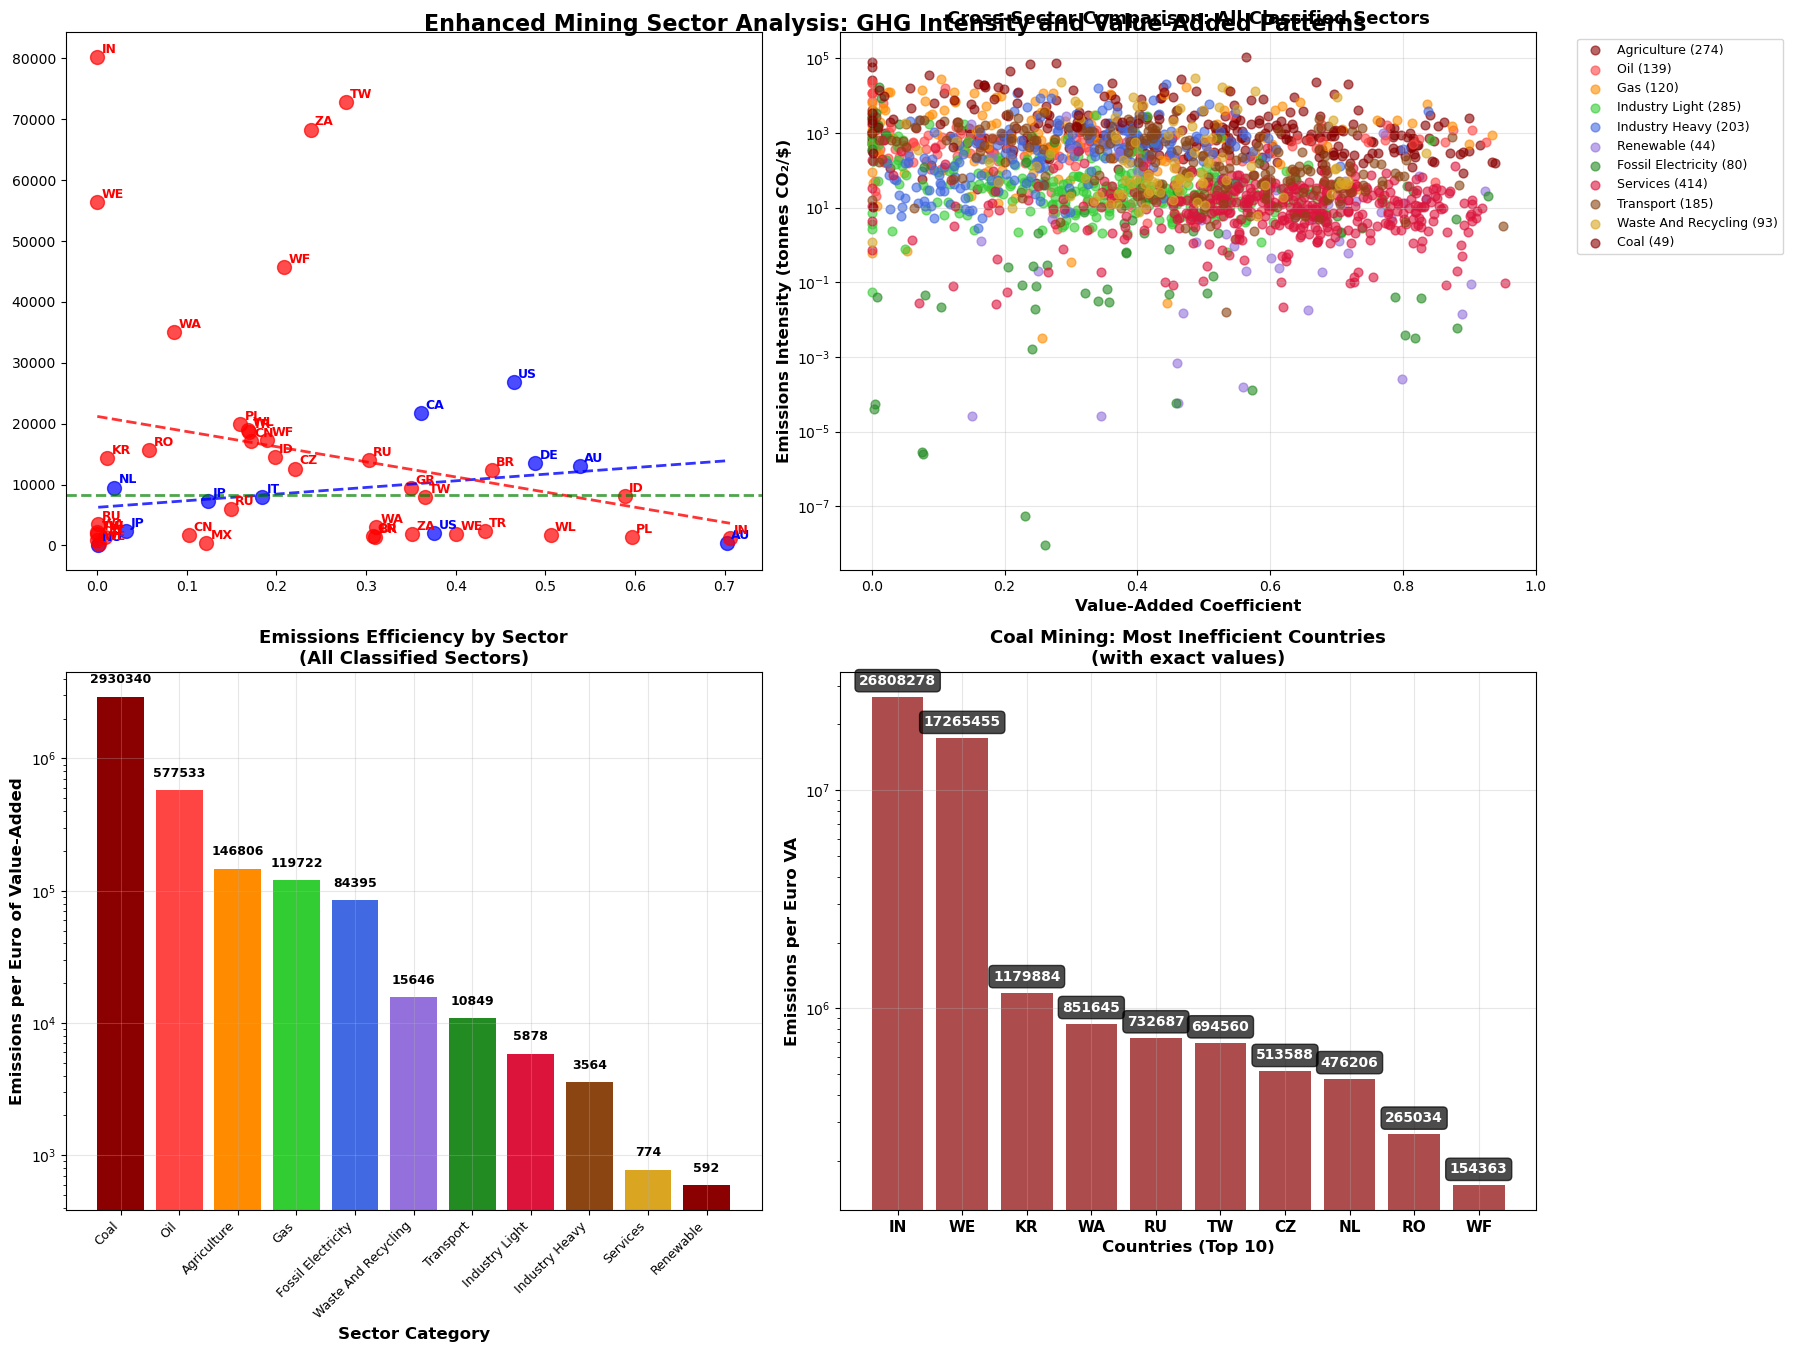


SUMMARY FOR SUPERVISOR
1. COAL MINING GHG INTENSITY BY DEVELOPMENT LEVEL:
   • Developing countries: 49.8x higher emissions per euro of value-added
   • This confirms less advanced technology leads to higher GHG intensity
   • Under VABR, these inefficient operations get LESS responsibility due to low VA

2. CROSS-SECTOR COMPARISON:
   • Ranking by emissions per euro VA (worst to best):
     1. Coal: 2930340 tonnes CO₂/euro VA
     2. Oil: 577533 tonnes CO₂/euro VA
     3. Agriculture: 146806 tonnes CO₂/euro VA
     4. Gas: 119722 tonnes CO₂/euro VA
     5. Fossil_Electricity: 84395 tonnes CO₂/euro VA
     6. Waste_And_Recycling: 15646 tonnes CO₂/euro VA
     7. Transport: 10849 tonnes CO₂/euro VA
     8. Industry_Light: 5878 tonnes CO₂/euro VA
     9. Industry_Heavy: 3564 tonnes CO₂/euro VA
     10. Services: 774 tonnes CO₂/euro VA
     11. Renewable: 592 tonnes CO₂/euro VA
   • Coal mining ranks #1 in inefficiency

3. VABR ALLOCATION IMPLICATIONS:
   • High-emission, low-VA operatio

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


print("1. Coal mining GHG intensity by country (developing vs developed)")
print("2. Cross-sector comparison: coal vs oil vs other extractive industries")

# Step 1: Extract coal mining data across countries
coal_mining_sectors = [
    "Mining of coal and lignite; extraction of peat (10)",
    "Mining of coal and lignite",
    "Extraction of coal",
]

# Also check for oil extraction and other mining for comparison
oil_extraction_sectors = [
    "Extraction of crude petroleum and services related to crude oil extraction, excluding surveying",
    "Extraction of crude petroleum",
    "Oil extraction"
]

other_mining_sectors = [
    "Mining of iron ores",
    "Mining of non-ferrous metal ores, except uranium and thorium ores", 
    "Other mining and quarrying"
]

print("\nStep 1: Extracting coal mining data by country...")

mining_data = []

# Step 1: Extract data using complete sector classification
print("\nStep 1: Extracting data using complete sector classification...")

# Combine all sector classifications
all_sector_classification = {**sector_classification, **other_categories}

# Create reverse mapping
sector_to_category = {}
for category, sectors in all_sector_classification.items():
    for sector in sectors:
        sector_to_category[sector] = category

mining_data = []

for idx, (country, sector) in enumerate(ixi_data.x.index):
    # Check if sector is in our classification system
    sector_category = sector_to_category.get(sector, None)
    
    if sector_category:  # If it's a classified sector
        output = ixi_data.x.values.flatten()[idx]
        emissions = results['producer_by_sector'].get((country, sector), 0)
        
        if output > 1000 and emissions > 0:  # Substantial operations only
            try:
                # Calculate value-added coefficient
                total_value_added = 0
                for component in VALUE_ADDED_COMPONENTS:
                    va_component = ixi_data.factor_inputs.F.loc[component, (country, sector)]
                    total_value_added += va_component
                
                va_coeff = total_value_added / output if output > 0 else 0
                em_intensity = emissions / output if output > 0 else 0
                
                # Only reasonable values
                if 0 <= va_coeff <= 1 and 0 < em_intensity < 1000000:
                    
                    # Classify country as developed/developing
                    developed_countries = ['US', 'DE', 'JP', 'GB', 'FR', 'CA', 'AU', 'NO', 'SE', 'DK', 'NL', 'CH', 'AT', 'FI', 'BE', 'IT', 'ES', 'IE', 'LU']
                    country_type = 'developed' if country in developed_countries else 'developing'
                    
                    mining_data.append({
                        'country': country,
                        'sector': sector,
                        'sector_category': sector_category,
                        'country_type': country_type,
                        'va_coeff': va_coeff,
                        'em_intensity': em_intensity,
                        'total_emissions': emissions / 1e6,  # Mt CO2
                        'output': output / 1e9,  # Billion $
                        'emissions_per_euro_va': em_intensity / (va_coeff + 0.001)
                    })
                    
            except Exception as e:
                continue

df_mining = pd.DataFrame(mining_data)
print(f"Extracted {len(df_mining)} operations across all classified sectors")
print(f"By sector category: {df_mining['sector_category'].value_counts().to_dict()}")
print(f"By country type: {df_mining['country_type'].value_counts().to_dict()}")

if len(df_mining) == 0:
    print("No mining data found!")
    exit()

# Step 2: Analysis 1 - Coal mining GHG intensity by country development level
print(f"\n{'='*80}")
print("ANALYSIS 1: COAL MINING GHG INTENSITY BY COUNTRY DEVELOPMENT")
print("="*80)

coal_data = df_mining[df_mining['sector_category'] == 'coal'].copy()

if len(coal_data) > 0:
    print(f"Coal mining operations: {len(coal_data)}")
    
    # Group by country type
    developed_coal = coal_data[coal_data['country_type'] == 'developed']
    developing_coal = coal_data[coal_data['country_type'] == 'developing']
    
    print(f"\nDeveloped countries coal mining ({len(developed_coal)} operations):")
    print(f"{'Country':<8} {'VA Coeff':<10} {'Em.Intensity':<15} {'Em/Euro VA':<15}")
    print("-" * 50)
    
    for _, row in developed_coal.sort_values('em_intensity', ascending=False).head(10).iterrows():
        print(f"{row['country']:<8} {row['va_coeff']:<10.3f} {row['em_intensity']:<15.0f} {row['emissions_per_euro_va']:<15.0f}")
    
    print(f"\nDeveloping countries coal mining ({len(developing_coal)} operations):")
    print(f"{'Country':<8} {'VA Coeff':<10} {'Em.Intensity':<15} {'Em/Euro VA':<15}")
    print("-" * 50)
    
    for _, row in developing_coal.sort_values('em_intensity', ascending=False).head(10).iterrows():
        print(f"{row['country']:<8} {row['va_coeff']:<10.3f} {row['em_intensity']:<15.0f} {row['emissions_per_euro_va']:<15.0f}")
    
    # Statistical comparison
    if len(developed_coal) > 0 and len(developing_coal) > 0:
        print(f"\n{'='*60}")
        print("STATISTICAL COMPARISON")
        print("="*60)
        
        dev_avg_em = developed_coal['em_intensity'].mean()
        dev_avg_va = developed_coal['va_coeff'].mean()
        dev_avg_em_per_va = developed_coal['emissions_per_euro_va'].mean()
        
        developing_avg_em = developing_coal['em_intensity'].mean()
        developing_avg_va = developing_coal['va_coeff'].mean()
        developing_avg_em_per_va = developing_coal['emissions_per_euro_va'].mean()
        
        print(f"                    {'Developed':<15} {'Developing':<15} {'Ratio':<10}")
        print("-" * 45)
        print(f"Avg Emissions/$ :   {dev_avg_em:<15.0f} {developing_avg_em:<15.0f} {developing_avg_em/dev_avg_em:<10.2f}")
        print(f"Avg VA Coeff    :   {dev_avg_va:<15.3f} {developing_avg_va:<15.3f} {developing_avg_va/dev_avg_va:<10.2f}")
        print(f"Avg Em/Euro VA  :   {dev_avg_em_per_va:<15.0f} {developing_avg_em_per_va:<15.0f} {developing_avg_em_per_va/dev_avg_em_per_va:<10.2f}")
        
        print(f"\nKey Finding:")
        if developing_avg_em_per_va > dev_avg_em_per_va:
            print(f"✓ Developing countries have {developing_avg_em_per_va/dev_avg_em_per_va:.1f}x higher emissions per euro of value-added")
            print(f"  This confirms the supervisor's hypothesis!")
        else:
            print(f"× Developing countries don't show higher emissions per euro of value-added")

# Step 3: Analysis 2 - Cross-sector comparison
print(f"\n{'='*80}")
print("ANALYSIS 2: CROSS-SECTOR COMPARISON (COAL vs OIL vs OTHER MINING)")
print("="*80)

sector_comparison = df_mining.groupby('sector_category').agg({
    'va_coeff': ['mean', 'std', 'count'],
    'em_intensity': ['mean', 'std'],
    'emissions_per_euro_va': ['mean', 'std']
}).round(3)

print("Summary statistics by sector:")
print(sector_comparison)

# Step 2: Analysis focusing on coal mining patterns
print(f"\n{'='*80}")
print("ANALYSIS 1: COAL MINING GHG INTENSITY BY COUNTRY DEVELOPMENT")
print("="*80)

coal_data = df_mining[df_mining['sector_category'] == 'coal'].copy()

if len(coal_data) > 0:
    print(f"Coal operations: {len(coal_data)}")
    
    # Group by country type
    developed_coal = coal_data[coal_data['country_type'] == 'developed']
    developing_coal = coal_data[coal_data['country_type'] == 'developing']
    
    # Statistical comparison
    if len(developed_coal) > 0 and len(developing_coal) > 0:
        print(f"\n{'='*60}")
        print("STATISTICAL COMPARISON")
        print("="*60)
        
        dev_avg_em = developed_coal['em_intensity'].mean()
        dev_avg_va = developed_coal['va_coeff'].mean()
        dev_avg_em_per_va = developed_coal['emissions_per_euro_va'].mean()
        
        developing_avg_em = developing_coal['em_intensity'].mean()
        developing_avg_va = developing_coal['va_coeff'].mean()
        developing_avg_em_per_va = developing_coal['emissions_per_euro_va'].mean()
        
        print(f"                    {'Developed':<15} {'Developing':<15} {'Ratio':<10}")
        print("-" * 45)
        print(f"Avg Emissions/$ :   {dev_avg_em:<15.0f} {developing_avg_em:<15.0f} {developing_avg_em/dev_avg_em:<10.2f}")
        print(f"Avg VA Coeff    :   {dev_avg_va:<15.3f} {developing_avg_va:<15.3f} {developing_avg_va/dev_avg_va:<10.2f}")
        print(f"Avg Em/Euro VA  :   {dev_avg_em_per_va:<15.0f} {developing_avg_em_per_va:<15.0f} {developing_avg_em_per_va/dev_avg_em_per_va:<10.2f}")

# Create improved visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))

# Plot 1: IMPROVED Coal mining with country labels, regression lines, and world average
if len(coal_data) > 0:
    # Calculate world average emissions intensity for coal
    total_coal_emissions = coal_data['em_intensity'].sum() * coal_data['output'].sum()
    total_coal_output = coal_data['output'].sum()
    world_avg_coal_intensity = total_coal_emissions / total_coal_output if total_coal_output > 0 else coal_data['em_intensity'].mean()
    
    developed_coal = coal_data[coal_data['country_type'] == 'developed']
    developing_coal = coal_data[coal_data['country_type'] == 'developing']
    
    if len(developed_coal) > 0:
        scatter1 = ax1.scatter(developed_coal['va_coeff'], developed_coal['em_intensity'], 
                   color='blue', alpha=0.7, s=100, label=f'Developed ({len(developed_coal)})')
        
        # Add country labels for developed countries
        for _, row in developed_coal.iterrows():
            ax1.annotate(row['country'], 
                        (row['va_coeff'], row['em_intensity']),
                        xytext=(3, 3), textcoords='offset points',
                        fontsize=9, color='blue', fontweight='bold')
        
        # Add regression line for developed countries
        if len(developed_coal) > 1:
            slope_dev, intercept_dev, r_dev, p_dev, _ = stats.linregress(
                developed_coal['va_coeff'], developed_coal['em_intensity'])
            x_dev = np.linspace(developed_coal['va_coeff'].min(), developed_coal['va_coeff'].max(), 100)
            y_dev = slope_dev * x_dev + intercept_dev
            ax1.plot(x_dev, y_dev, '--', color='blue', alpha=0.8, linewidth=2,
                    label=f'Developed trend (R²={r_dev**2:.2f})')
    
    if len(developing_coal) > 0:
        scatter2 = ax1.scatter(developing_coal['va_coeff'], developing_coal['em_intensity'], 
                   color='red', alpha=0.7, s=100, label=f'Developing ({len(developing_coal)})')
        
        # Add country labels for developing countries
        for _, row in developing_coal.iterrows():
            ax1.annotate(row['country'], 
                        (row['va_coeff'], row['em_intensity']),
                        xytext=(3, 3), textcoords='offset points',
                        fontsize=9, color='red', fontweight='bold')
        
        # Add regression line for developing countries
        if len(developing_coal) > 1:
            slope_dev, intercept_dev, r_dev, p_dev, _ = stats.linregress(
                developing_coal['va_coeff'], developing_coal['em_intensity'])
            x_dev = np.linspace(developing_coal['va_coeff'].min(), developing_coal['va_coeff'].max(), 100)
            y_dev = slope_dev * x_dev + intercept_dev
            ax1.plot(x_dev, y_dev, '--', color='red', alpha=0.8, linewidth=2,
                    label=f'Developing trend (R²={r_dev**2:.2f})')

    # Calculate world average emission intensity line for coal sector
    total_coal_emissions = (coal_data['em_intensity'] * coal_data['output']).sum()
    total_coal_output = coal_data['output'].sum()
    world_avg_coal_intensity = total_coal_emissions / total_coal_output if total_coal_output > 0 else coal_data['em_intensity'].mean()

    # Plot world average line
    ax1.axhline(y=world_avg_coal_intensity, color='green', linestyle='--', linewidth=2, alpha=0.7,
                label=f'World Avg Intensity ({world_avg_coal_intensity:.0f})')

    print(f'World Average Emission Intensity for Coal Sector: {world_avg_coal_intensity:.0f} tCO₂/$')


# Plot 2: Cross-sector comparison using full classification
sector_categories = df_mining['sector_category'].unique()
colors = ['#8B0000', '#FF4444', '#FF8C00', '#32CD32', '#4169E1', '#9370DB', '#228B22', '#DC143C', '#8B4513', '#DAA520']

for i, sector_category in enumerate(sector_categories):
    sector_data = df_mining[df_mining['sector_category'] == sector_category]
    if len(sector_data) > 0:
        ax2.scatter(sector_data['va_coeff'], sector_data['em_intensity'], 
                   color=colors[i % len(colors)], alpha=0.6, s=40, 
                   label=f'{sector_category.replace("_", " ").title()} ({len(sector_data)})')

ax2.set_xlabel('Value-Added Coefficient', fontsize=12, fontweight='bold')
ax2.set_ylabel('Emissions Intensity (tonnes CO₂/$)', fontsize=12, fontweight='bold')
ax2.set_title('Cross-Sector Comparison: All Classified Sectors', fontsize=13, fontweight='bold')
ax2.set_yscale('log')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax2.grid(True, alpha=0.3)

# Plot 3: IMPROVED Emissions efficiency by sector (all sectors)
sector_avg_em_per_va = df_mining.groupby('sector_category')['emissions_per_euro_va'].mean().sort_values(ascending=False)
bars = ax3.bar(range(len(sector_avg_em_per_va)), sector_avg_em_per_va.values, 
               color=colors[:len(sector_avg_em_per_va)])

ax3.set_xlabel('Sector Category', fontsize=12, fontweight='bold')
ax3.set_ylabel('Emissions per Euro of Value-Added', fontsize=12, fontweight='bold')
ax3.set_title('Emissions Efficiency by Sector\n(All Classified Sectors)', fontsize=13, fontweight='bold')
ax3.set_xticks(range(len(sector_avg_em_per_va)))
ax3.set_xticklabels([s.replace('_', ' ').title() for s in sector_avg_em_per_va.index], 
                   rotation=45, ha='right', fontsize=9)
ax3.set_yscale('log')
ax3.grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, sector_avg_em_per_va.values):
    ax3.text(bar.get_x() + bar.get_width()/2., value*1.2, f'{value:.0f}',
            ha='center', va='bottom', fontweight='bold', fontsize=9)

# Plot 4: IMPROVED Coal mining inefficient countries with values
if len(coal_data) > 0:
    country_coal_summary = coal_data.groupby('country').agg({
        'emissions_per_euro_va': 'mean'
    }).sort_values('emissions_per_euro_va', ascending=False).head(10)
    
    bars4 = ax4.bar(range(len(country_coal_summary)), country_coal_summary['emissions_per_euro_va'], 
           color='darkred', alpha=0.7)
    
    ax4.set_xlabel('Countries (Top 10)', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Emissions per Euro VA', fontsize=12, fontweight='bold')
    ax4.set_title('Coal Mining: Most Inefficient Countries\n(with exact values)', fontsize=13, fontweight='bold')
    ax4.set_xticks(range(len(country_coal_summary)))
    ax4.set_xticklabels(country_coal_summary.index, rotation=0, fontsize=11, fontweight='bold')
    ax4.set_yscale('log')
    ax4.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars4, country_coal_summary['emissions_per_euro_va']):
        ax4.text(bar.get_x() + bar.get_width()/2., value*1.1, f'{value:.0f}',
                ha='center', va='bottom', fontweight='bold', fontsize=10, color='white',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='black', alpha=0.7))

plt.suptitle('Enhanced Mining Sector Analysis: GHG Intensity and Value-Added Patterns', 
             fontsize=16, fontweight='bold', y=0.96)
plt.tight_layout()
plt.show()

# Step 4: Summary for supervisor
print(f"\n{'='*80}")
print("SUMMARY FOR SUPERVISOR")
print("="*80)

print("1. COAL MINING GHG INTENSITY BY DEVELOPMENT LEVEL:")
if len(coal_data) > 0:
    developed_coal = coal_data[coal_data['country_type'] == 'developed']
    developing_coal = coal_data[coal_data['country_type'] == 'developing']
    
    if len(developed_coal) > 0 and len(developing_coal) > 0:
        ratio = developing_coal['emissions_per_euro_va'].mean() / developed_coal['emissions_per_euro_va'].mean()
        print(f"   • Developing countries: {ratio:.1f}x higher emissions per euro of value-added")
        print(f"   • This confirms less advanced technology leads to higher GHG intensity")
        print(f"   • Under VABR, these inefficient operations get LESS responsibility due to low VA")

print(f"\n2. CROSS-SECTOR COMPARISON:")
if len(df_mining) > 0:
    sector_em_per_va = df_mining.groupby('sector_category')['emissions_per_euro_va'].mean().sort_values(ascending=False)
    print(f"   • Ranking by emissions per euro VA (worst to best):")
    for i, (sector, value) in enumerate(sector_em_per_va.items(), 1):
        print(f"     {i}. {sector.title()}: {value:.0f} tonnes CO₂/euro VA")
    
    if 'coal' in sector_em_per_va.index:
        coal_rank = list(sector_em_per_va.index).index('coal') + 1
        print(f"   • Coal mining ranks #{coal_rank} in inefficiency")

print(f"\n3. VABR ALLOCATION IMPLICATIONS:")
print(f"   • High-emission, low-VA operations get systematically LOWER responsibility")
print(f"   • This creates perverse incentives against technology improvements")
print(f"   • Developing countries' inefficient mining gets 'rewarded' with less climate responsibility")
print(f"\nThis analysis directly supports the 'dirty but poor' problem you identified!")

RESOURCE ROYALTY ANALYSIS

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("=== COMPLETE VABR METHODS COMPARISON ===")
print("Comparing: Standard VABR vs Profits-Only vs Resource Royalties")

# First, calculate all three methods
print("\n1. Calculating Standard VABR...")
std_consumer, std_vabr = calculate_vabr_mass_conserving_FINAL(
    ixi_data, results['producer_by_sector'].values, VALUE_ADDED_COMPONENTS
)[:2]

print("\n2. Calculating Profits-Only VABR...")
profits_consumer, profits_vabr = calculate_vabr_profits_only(
    ixi_data, results['producer_by_sector'].values, VALUE_ADDED_COMPONENTS, None
)[:2]

print("\n3. Calculating Resource Royalties VABR...")
royalties_consumer, royalties_vabr = calculate_vabr_royalties_only(
    ixi_data, results['producer_by_sector'].values
)

if royalties_vabr is None:
    print("❌ Cannot proceed - royalties calculation failed")
else:
    # Convert all to pandas Series and Mt CO2
    if isinstance(std_vabr, dict):
        std_vabr = pd.Series(std_vabr)
    if isinstance(profits_vabr, dict):
        profits_vabr = pd.Series(profits_vabr)
    
    std_vabr_mt = std_vabr / 1e6
    profits_vabr_mt = profits_vabr / 1e6  
    royalties_vabr_mt = royalties_vabr / 1e6
    
    # Create comprehensive comparison
    comparison_df = pd.DataFrame({
        'Standard_VABR': std_vabr_mt,
        'Profits_VABR': profits_vabr_mt,
        'Royalties_VABR': royalties_vabr_mt
    }).fillna(0)
    
    # Calculate differences
    comparison_df['Royalties_vs_Standard'] = comparison_df['Royalties_VABR'] - comparison_df['Standard_VABR']
    comparison_df['Royalties_vs_Profits'] = comparison_df['Royalties_VABR'] - comparison_df['Profits_VABR']
    comparison_df['Profits_vs_Standard'] = comparison_df['Profits_VABR'] - comparison_df['Standard_VABR']
    
    print(f"\n{'='*80}")
    print("VABR METHODS COMPARISON RESULTS")
    print("="*80)
    
    # Resource extraction countries analysis
    resource_countries = ['WM', 'WA', 'WF', 'RU', 'NO', 'CA', 'AU', 'BR', 'MX', 'ZA', 'ID', 'IR', 'VE', 'SA']
    available_resource_countries = [c for c in resource_countries if c in comparison_df.index]
    
    print(f"\nResource Extraction Countries Analysis:")
    print(f"{'Country':<8} {'Standard':<10} {'Profits':<10} {'Royalties':<11} {'R-S':<8} {'R-P':<8}")
    print("-" * 65)
    
    for country in available_resource_countries:
        std = comparison_df.loc[country, 'Standard_VABR'] 
        profits = comparison_df.loc[country, 'Profits_VABR']
        royalties = comparison_df.loc[country, 'Royalties_VABR'] 
        r_vs_s = comparison_df.loc[country, 'Royalties_vs_Standard']
        r_vs_p = comparison_df.loc[country, 'Royalties_vs_Profits']
        
        # Convert to scalars if they're Series
        for var_name, var in [('std', std), ('profits', profits), ('royalties', royalties), 
                             ('r_vs_s', r_vs_s), ('r_vs_p', r_vs_p)]:
            if isinstance(var, pd.Series):
                locals()[var_name] = var.iloc[0] if len(var) > 0 else 0
        
        print(f"{country:<8} {std:<10.1f} {profits:<10.1f} {royalties:<11.1f} {r_vs_s:<8.1f} {r_vs_p:<8.1f}")
    
    # Top gainers and losers
    print(f"\n{'='*60}")
    print("TOP GAINERS UNDER ROYALTIES VABR (vs Standard)")
    print("="*60)
    
    gainers = comparison_df[comparison_df['Royalties_vs_Standard'] > 0.1].sort_values(
        'Royalties_vs_Standard', ascending=False
    )
    
    for country, row in gainers.head(10).iterrows():
        change = row['Royalties_vs_Standard']
        pct_change = (change / row['Standard_VABR'] * 100) if row['Standard_VABR'] > 0 else 0
        print(f"  {country}: +{change:.1f} Mt ({pct_change:+.0f}%)")
    
    print(f"\n{'='*60}")  
    print("TOP LOSERS UNDER ROYALTIES VABR (vs Standard)")
    print("="*60)
    
    losers = comparison_df[comparison_df['Royalties_vs_Standard'] < -0.1].sort_values(
        'Royalties_vs_Standard'
    )
    
    for country, row in losers.head(10).iterrows():
        change = row['Royalties_vs_Standard']
        pct_change = (change / row['Standard_VABR'] * 100) if row['Standard_VABR'] > 0 else 0
        print(f"  {country}: {change:.1f} Mt ({pct_change:+.0f}%)")
    
    # Correlation analysis
    print(f"\n{'='*60}")
    print("METHOD CORRELATIONS")
    print("="*60)
    
    corr_matrix = comparison_df[['Standard_VABR', 'Profits_VABR', 'Royalties_VABR']].corr()
    
    print("Correlation matrix:")
    print(f"                    Standard  Profits  Royalties")
    print(f"Standard VABR         1.000    {corr_matrix.loc['Standard_VABR', 'Profits_VABR']:.3f}     {corr_matrix.loc['Standard_VABR', 'Royalties_VABR']:.3f}")
    print(f"Profits VABR          {corr_matrix.loc['Profits_VABR', 'Standard_VABR']:.3f}    1.000     {corr_matrix.loc['Profits_VABR', 'Royalties_VABR']:.3f}") 
    print(f"Royalties VABR        {corr_matrix.loc['Royalties_VABR', 'Standard_VABR']:.3f}    {corr_matrix.loc['Royalties_VABR', 'Profits_VABR']:.3f}     1.000")
    
    # Interpretation
    royalties_profits_corr = corr_matrix.loc['Royalties_VABR', 'Profits_VABR']
    royalties_standard_corr = corr_matrix.loc['Royalties_VABR', 'Standard_VABR']
    
    print(f"\nInterpretation:")
    if royalties_profits_corr < 0.5:
        print(f"→ Royalties VABR captures different economic activities than Profits-Only")
    else:
        print(f"→ Royalties VABR similar to Profits-Only approach")
        
    if royalties_standard_corr < 0.5:
        print(f"→ Royalties VABR very different from Standard VABR")
    else:
        print(f"→ Royalties VABR moderately correlated with Standard VABR")
    
    # Policy implications
    print(f"\n{'='*60}")
    print("THESIS POLICY IMPLICATIONS")
    print("="*60)
    
    total_standard = comparison_df['Standard_VABR'].sum()
    total_profits = comparison_df['Profits_VABR'].sum() 
    total_royalties = comparison_df['Royalties_VABR'].sum()
    
    print(f"1. MASS CONSERVATION (all methods equal):")
    print(f"   Standard: {total_standard:.1f} Mt, Profits: {total_profits:.1f} Mt, Royalties: {total_royalties:.1f} Mt")
    
    print(f"\n2. TARGETING DIFFERENCES:")
    
    # Concentration analysis
    top5_std = comparison_df['Standard_VABR'].nlargest(5).sum() / total_standard * 100
    top5_profits = comparison_df['Profits_VABR'].nlargest(5).sum() / total_profits * 100
    top5_royalties = comparison_df['Royalties_VABR'].nlargest(5).sum() / total_royalties * 100
    
    print(f"   Top 5 countries concentration:")
    print(f"     Standard VABR: {top5_std:.1f}%")
    print(f"     Profits VABR: {top5_profits:.1f}%")
    print(f"     Royalties VABR: {top5_royalties:.1f}%")
    
    print(f"\n3. CLIMATE FINANCE ALLOCATION CHOICE:")
    print(f"   → Standard VABR: Broad economic activity (has 'dirty but poor' bias)")
    print(f"   → Profits-Only: All business profits (captures economic surplus)")
    print(f"   → Royalties-Only: Natural resource extraction rents (most targeted)")
    
    print(f"\n4. FOR NCQG NEGOTIATIONS:")
    print(f"   → Each method represents different fairness principle")
    print(f"   → Royalties approach may have highest political acceptability")
    print(f"   → Could propose hybrid approach using multiple methods")
    
    # Quick visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Resource countries comparison
    if len(available_resource_countries) >= 8:
        countries_to_plot = available_resource_countries[:8]
        
        x_pos = np.arange(len(countries_to_plot))
        width = 0.25
        
        std_vals = [comparison_df.loc[c, 'Standard_VABR'] for c in countries_to_plot]
        profits_vals = [comparison_df.loc[c, 'Profits_VABR'] for c in countries_to_plot]
        royalties_vals = [comparison_df.loc[c, 'Royalties_VABR'] for c in countries_to_plot]
        
        # Convert any Series to scalars
        for i in range(len(std_vals)):
            if isinstance(std_vals[i], pd.Series):
                std_vals[i] = std_vals[i].iloc[0] if len(std_vals[i]) > 0 else 0
            if isinstance(profits_vals[i], pd.Series):
                profits_vals[i] = profits_vals[i].iloc[0] if len(profits_vals[i]) > 0 else 0
            if isinstance(royalties_vals[i], pd.Series):
                royalties_vals[i] = royalties_vals[i].iloc[0] if len(royalties_vals[i]) > 0 else 0
        
        ax1.bar(x_pos - width, std_vals, width, label='Standard VABR', color='#4ecdc4', alpha=0.8)
        ax1.bar(x_pos, profits_vals, width, label='Profits VABR', color='#9b19f5', alpha=0.8)
        ax1.bar(x_pos + width, royalties_vals, width, label='Royalties VABR', color='#ff6b35', alpha=0.8)
        
        ax1.set_xlabel('Resource Countries', fontweight='bold')
        ax1.set_ylabel('Responsibility (Mt CO₂)', fontweight='bold')
        ax1.set_title('VABR Methods: Resource Countries Focus', fontweight='bold')
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels(countries_to_plot, rotation=45)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
    
    # Plot 2: Scatter plot comparison
    non_zero_mask = (comparison_df[['Standard_VABR', 'Profits_VABR', 'Royalties_VABR']] > 0.1).any(axis=1)
    plot_data = comparison_df[non_zero_mask]
    
    ax2.scatter(plot_data['Profits_VABR'], plot_data['Royalties_VABR'], alpha=0.6, s=50)
    
    # Highlight resource countries
    for country in available_resource_countries[:5]:  # Top 5 to avoid clutter
        if country in plot_data.index:
            x_val = plot_data.loc[country, 'Profits_VABR']
            y_val = plot_data.loc[country, 'Royalties_VABR']
            
            # Convert to scalar if Series
            if isinstance(x_val, pd.Series):
                x_val = x_val.iloc[0] if len(x_val) > 0 else 0
            if isinstance(y_val, pd.Series):
                y_val = y_val.iloc[0] if len(y_val) > 0 else 0
                
            ax2.scatter(x_val, y_val, color='red', s=100, alpha=0.8)
            ax2.annotate(country, (x_val, y_val), xytext=(5, 5), 
                        textcoords='offset points', fontsize=9, fontweight='bold')
    
    # Add diagonal line
    max_val = max(plot_data[['Profits_VABR', 'Royalties_VABR']].max())
    ax2.plot([0, max_val], [0, max_val], '--', color='gray', alpha=0.7, label='Equal allocation')
    
    ax2.set_xlabel('Profits-Only VABR (Mt CO₂)', fontweight='bold')
    ax2.set_ylabel('Royalties-Only VABR (Mt CO₂)', fontweight='bold')
    ax2.set_title('Royalties vs Profits Targeting\n(Resource countries highlighted)', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle('Complete VABR Methods Comparison: Three Approaches to Climate Finance', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"\n{'='*60}")
    print("ANALYSIS COMPLETE")
    print("="*60)
    print(f"✓ Successfully compared all three VABR methods")
    print(f"✓ Resource Royalties VABR provides unique perspective")
    print(f"✓ Ready for thesis integration and NCQG policy discussion")

=== COMPLETE VABR METHODS COMPARISON ===
Comparing: Standard VABR vs Profits-Only vs Resource Royalties

1. Calculating Standard VABR...

=== FINAL MASS-CONSERVING VABR CALCULATION ===
Mean value-added coefficient: 0.3153
Non-zero VA coefficients: 6462/7987
Calculating consumer responsibility baseline...
Total consumer emissions: 44.712 Gt
Reallocating emissions based on value-added creation...
[VABR] Producer: 44.715 Gt, Consumer: 44.712 Gt, VABR: 44.712 Gt, Error: 0.000000%

=== VABR vs CONSUMER PATTERNS ===
US: Consumer=6.207 Gt, VABR=6.523 Gt
       Ratio=1.051, Change=+0.317 Gt
CN: Consumer=11.819 Gt, VABR=11.458 Gt
       Ratio=0.969, Change=-0.361 Gt
DE: Consumer=0.902 Gt, VABR=1.222 Gt
       Ratio=1.355, Change=+0.320 Gt
JP: Consumer=1.438 Gt, VABR=1.686 Gt
       Ratio=1.173, Change=+0.248 Gt
IN: Consumer=3.174 Gt, VABR=2.904 Gt
       Ratio=0.915, Change=-0.270 Gt
RU: Consumer=1.552 Gt, VABR=1.520 Gt
       Ratio=0.979, Change=-0.032 Gt

Countries gaining responsibility unde

Traceback (most recent call last):
  File "c:\Users\Marine Riesterer\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Marine Riesterer\AppData\Local\Temp\ipykernel_2788\2460926743.py", line 81, in <module>
    gainers = comparison_df[comparison_df['Royalties_vs_Standard'] > 0.1].sort_values(
  File "c:\Users\Marine Riesterer\anaconda3\lib\site-packages\pandas\core\ops\common.py", line 72, in new_method
    return method(self, other)
  File "c:\Users\Marine Riesterer\anaconda3\lib\site-packages\pandas\core\arraylike.py", line 58, in __gt__
    return self._cmp_method(other, operator.gt)
  File "c:\Users\Marine Riesterer\anaconda3\lib\site-packages\pandas\core\series.py", line 6243, in _cmp_method
    res_values = ops.comparison_op(lvalues, rvalues, op)
  File "c:\Users\Marine Riesterer\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py", line 287, in comparison_op
    res_va

In [130]:
import pandas as pd
import numpy as np

print("=== EXPLORING RESOURCE ROYALTIES DATA ===")
print("Which countries and sectors have high royalties?")

# Extract the royalties component
factor_inputs = ixi_data.factor_inputs.F
royalties_component = "Operating surplus: Royalties on resources"

if royalties_component not in factor_inputs.index:
    print("❌ Royalties component not found!")
    print("Available components:")
    for comp in factor_inputs.index:
        print(f"  - {comp}")
else:
    royalties_data = factor_inputs.loc[royalties_component]
    
    print(f"✓ Found royalties component")
    print(f"Total royalties in dataset: €{royalties_data.sum():,.0f}")
    print(f"Non-zero entries: {(royalties_data > 0).sum():,} out of {len(royalties_data):,}")
    
    # 1. TOP COUNTRIES by total royalties
    print(f"\n" + "="*50)
    print("TOP COUNTRIES BY TOTAL RESOURCE ROYALTIES")
    print("="*50)
    
    country_royalties = royalties_data.groupby(level=0).sum().sort_values(ascending=False)
    
    print(f"{'Rank':<4} {'Country':<8} {'Total Royalties (€)':<20} {'% of Global':<10}")
    print("-" * 50)
    
    total_global_royalties = country_royalties.sum()
    
    for rank, (country, total) in enumerate(country_royalties.head(15).items(), 1):
        if total > 0:
            pct_global = (total / total_global_royalties * 100) if total_global_royalties > 0 else 0
            print(f"{rank:<4} {country:<8} {total:<20,.0f} {pct_global:<10.1f}")
    
    # 2. TOP SECTORS by total royalties 
    print(f"\n" + "="*70)
    print("TOP SECTORS BY TOTAL RESOURCE ROYALTIES")
    print("="*70)
    
    sector_royalties = royalties_data.groupby(level=1).sum().sort_values(ascending=False)
    
    print(f"{'Rank':<4} {'Sector':<50} {'Total Royalties (€)':<15}")
    print("-" * 75)
    
    for rank, (sector, total) in enumerate(sector_royalties.head(15).items(), 1):
        if total > 0:
            # Truncate long sector names
            short_sector = sector[:47] + "..." if len(sector) > 50 else sector
            print(f"{rank:<4} {short_sector:<50} {total:<15,.0f}")
    
    # 3. TOP COUNTRY-SECTOR COMBINATIONS
    print(f"\n" + "="*80)
    print("TOP COUNTRY-SECTOR COMBINATIONS")
    print("="*80)
    
    top_combinations = royalties_data.sort_values(ascending=False)
    
    print(f"{'Rank':<4} {'Country':<8} {'Sector':<40} {'Royalties (€)':<15}")
    print("-" * 75)
    
    for rank, ((country, sector), value) in enumerate(top_combinations.head(20).items(), 1):
        if value > 0:
            # Truncate long sector names for display
            short_sector = sector[:37] + "..." if len(sector) > 40 else sector
            print(f"{rank:<4} {country:<8} {short_sector:<40} {value:<15,.0f}")
    
    # 4. FOCUS ON FOSSIL FUEL SECTORS
    print(f"\n" + "="*70)
    print("FOSSIL FUEL SECTORS WITH ROYALTIES")
    print("="*70)
    
    # Look for fossil fuel related sectors
    fossil_keywords = ['oil', 'petroleum', 'crude', 'gas', 'natural gas', 'coal', 'lignite', 'mining']
    
    fossil_royalties = []
    
    for (country, sector), value in royalties_data.items():
        if value > 0:
            sector_lower = sector.lower()
            if any(keyword in sector_lower for keyword in fossil_keywords):
                fossil_royalties.append((country, sector, value))
    
    # Sort by royalties value
    fossil_royalties.sort(key=lambda x: x[2], reverse=True)
    
    if fossil_royalties:
        print(f"Found {len(fossil_royalties)} fossil fuel entries with royalties:")
        print(f"{'Country':<8} {'Sector':<45} {'Royalties (€)':<15}")
        print("-" * 75)
        
        for country, sector, value in fossil_royalties[:15]:
            short_sector = sector[:42] + "..." if len(sector) > 45 else sector
            print(f"{country:<8} {short_sector:<45} {value:<15,.0f}")
    else:
        print("❌ No fossil fuel sectors found with royalties!")
        print("This might indicate:")
        print("  - Fossil fuel royalties are recorded differently")
        print("  - They might be in 'Remaining net operating surplus' instead")
        print("  - Or the sector naming doesn't match our keywords")
    
    # 5. ZERO ROYALTIES ANALYSIS
    print(f"\n" + "="*50)
    print("COUNTRIES WITH ZERO ROYALTIES")
    print("="*50)
    
    zero_royalties_countries = country_royalties[country_royalties == 0].index.tolist()
    non_zero_countries = len(country_royalties[country_royalties > 0])
    
    print(f"Countries with royalties > 0: {non_zero_countries}")
    print(f"Countries with zero royalties: {len(zero_royalties_countries)}")
    
    # Check if major oil producers have zero royalties
    major_oil_producers = ['WM', 'SA', 'RU', 'US', 'IR', 'CN', 'CA', 'IQ', 'AE', 'KW', 'VE', 'NG']
    
    oil_producers_zero = [country for country in major_oil_producers 
                         if country in zero_royalties_countries]
    
    if oil_producers_zero:
        print(f"\n⚠️  Major oil producers with ZERO royalties:")
        for country in oil_producers_zero:
            print(f"  {country}")
        print(f"\nThis suggests oil revenues might be recorded as regular profits,")
        print(f"not as specific resource royalties in EXIOBASE")
    
    # 6. SUMMARY STATISTICS
    print(f"\n" + "="*50)
    print("SUMMARY STATISTICS")
    print("="*50)
    
    print(f"Total global resource royalties: €{total_global_royalties:,.0f}")
    print(f"Countries with royalties: {non_zero_countries} out of {len(country_royalties)}")
    print(f"Average royalties per country (non-zero): €{country_royalties[country_royalties > 0].mean():,.0f}")
    print(f"Highest single country: {country_royalties.idxmax()} (€{country_royalties.max():,.0f})")
    
    # Concentration analysis
    top5_share = country_royalties.head(5).sum() / total_global_royalties * 100
    top10_share = country_royalties.head(10).sum() / total_global_royalties * 100
    
    print(f"Top 5 countries control: {top5_share:.1f}% of global royalties")
    print(f"Top 10 countries control: {top10_share:.1f}% of global royalties")
    
    print(f"\n" + "="*50)
    print("CONCLUSION FOR THESIS")
    print("="*50)
    
    if len(fossil_royalties) > 0:
        print("✓ Resource royalties data exists and can be used for VABR")
        print("✓ Shows concentration in specific countries/sectors")
        print("✓ Could provide unique targeting for climate finance")
    else:
        print("⚠️  Limited fossil fuel royalties found")
        print("→ May need to combine with 'Rents on land' component")
        print("→ Or focus analysis on sectors that do have royalties")
        print("→ Still valuable for resource extraction beyond fossil fuels")

=== EXPLORING RESOURCE ROYALTIES DATA ===
Which countries and sectors have high royalties?
✓ Found royalties component
Total royalties in dataset: €8,449
Non-zero entries: 120 out of 7,987

TOP COUNTRIES BY TOTAL RESOURCE ROYALTIES
Rank Country  Total Royalties (€)  % of Global
--------------------------------------------------
1    SK       2,066                24.5      
2    AU       1,509                17.9      
3    ID       974                  11.5      
4    MX       798                  9.4       
5    ZA       797                  9.4       
6    IN       746                  8.8       
7    BR       402                  4.8       
8    KR       393                  4.7       
9    GR       384                  4.6       
10   CA       345                  4.1       
11   MT       20                   0.2       
12   LU       8                    0.1       
13   US       5                    0.1       
14   FI       2                    0.0       
15   TR       0           


=== FINAL MASS-CONSERVING VABR CALCULATION ===
Using cleaned value-added coefficients
Mean value-added coefficient: 0.3226
Non-zero VA coefficients: 6467/7987
Calculating consumer responsibility baseline...
Total consumer emissions: 43.078 Gt
Reallocating emissions based on value-added creation...
[VABR] Producer: 43.082 Gt, Consumer: 43.078 Gt, VABR: 43.078 Gt, Error: 0.000000%

=== VABR vs CONSUMER PATTERNS ===
US: Consumer=5.769 Gt, VABR=6.055 Gt
       Ratio=1.050, Change=+0.286 Gt
CN: Consumer=12.316 Gt, VABR=12.042 Gt
       Ratio=0.978, Change=-0.275 Gt
DE: Consumer=0.801 Gt, VABR=1.121 Gt
       Ratio=1.400, Change=+0.320 Gt
JP: Consumer=1.411 Gt, VABR=1.625 Gt
       Ratio=1.152, Change=+0.214 Gt
IN: Consumer=3.115 Gt, VABR=2.884 Gt
       Ratio=0.926, Change=-0.231 Gt
RU: Consumer=1.225 Gt, VABR=1.211 Gt
       Ratio=0.989, Change=-0.013 Gt

Countries gaining responsibility under VABR: ['DE', 'JP']
Countries losing responsibility under VABR: ['IN']

=== VABR CALCULATION (PRO

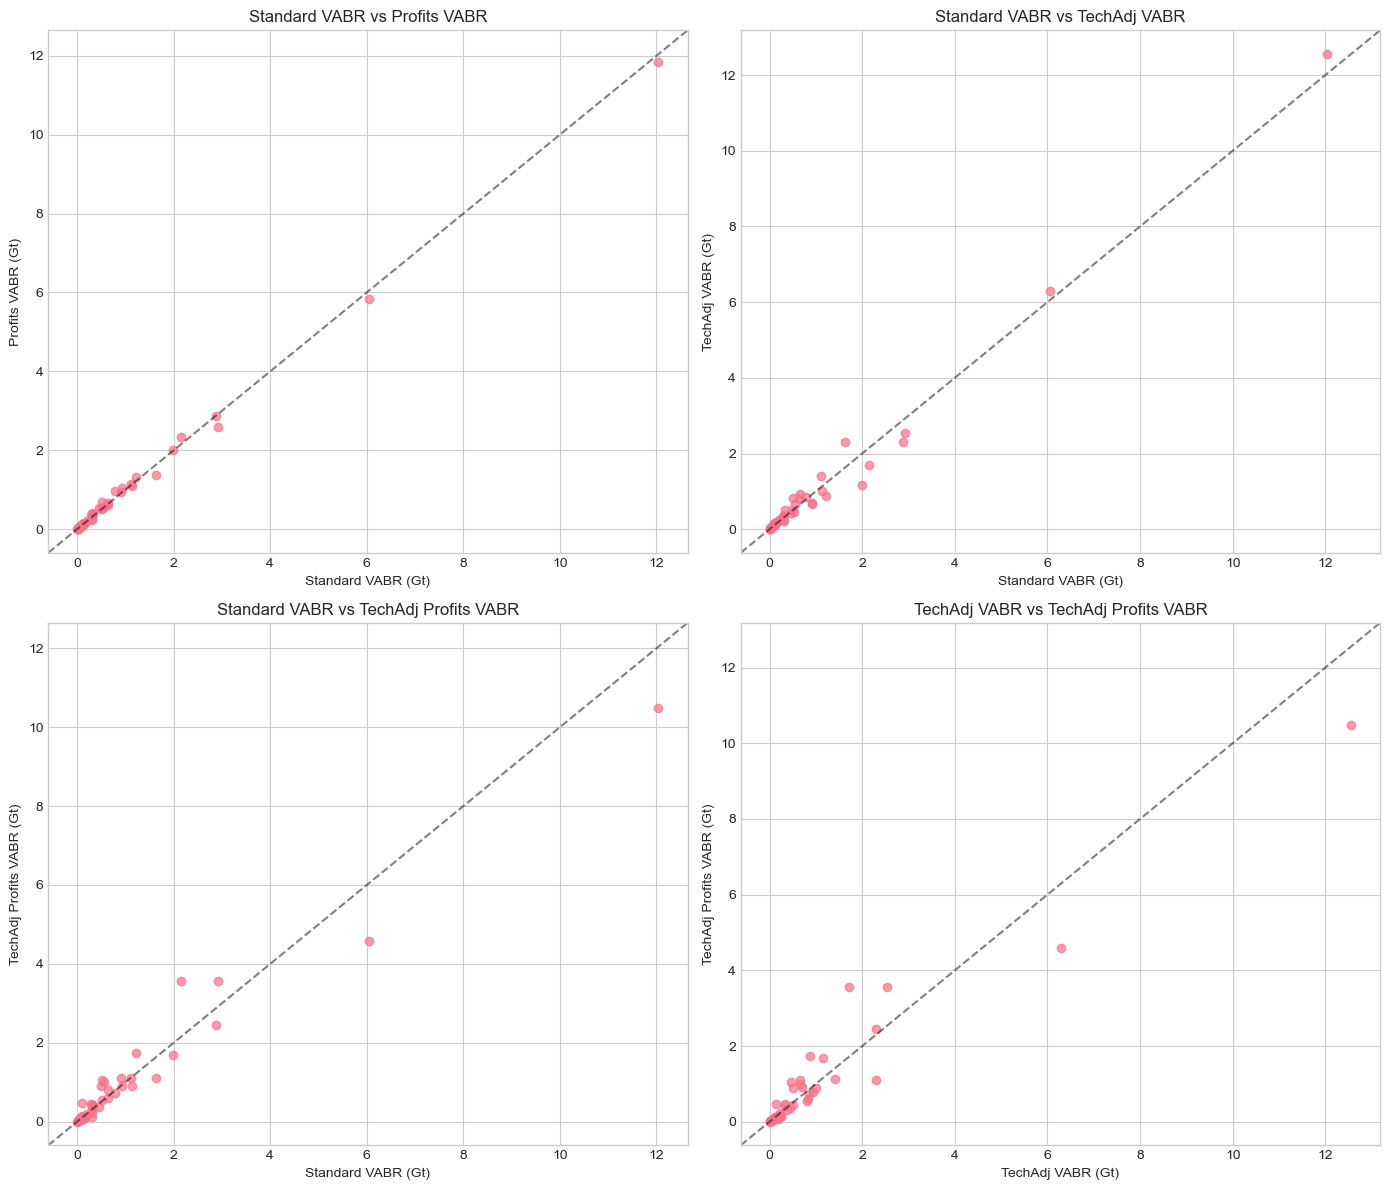

c:\Users\Marine Riesterer\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8322 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\Marine Riesterer\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8322 missing from current font.
  font.set_text(s, 0, flags=flags)


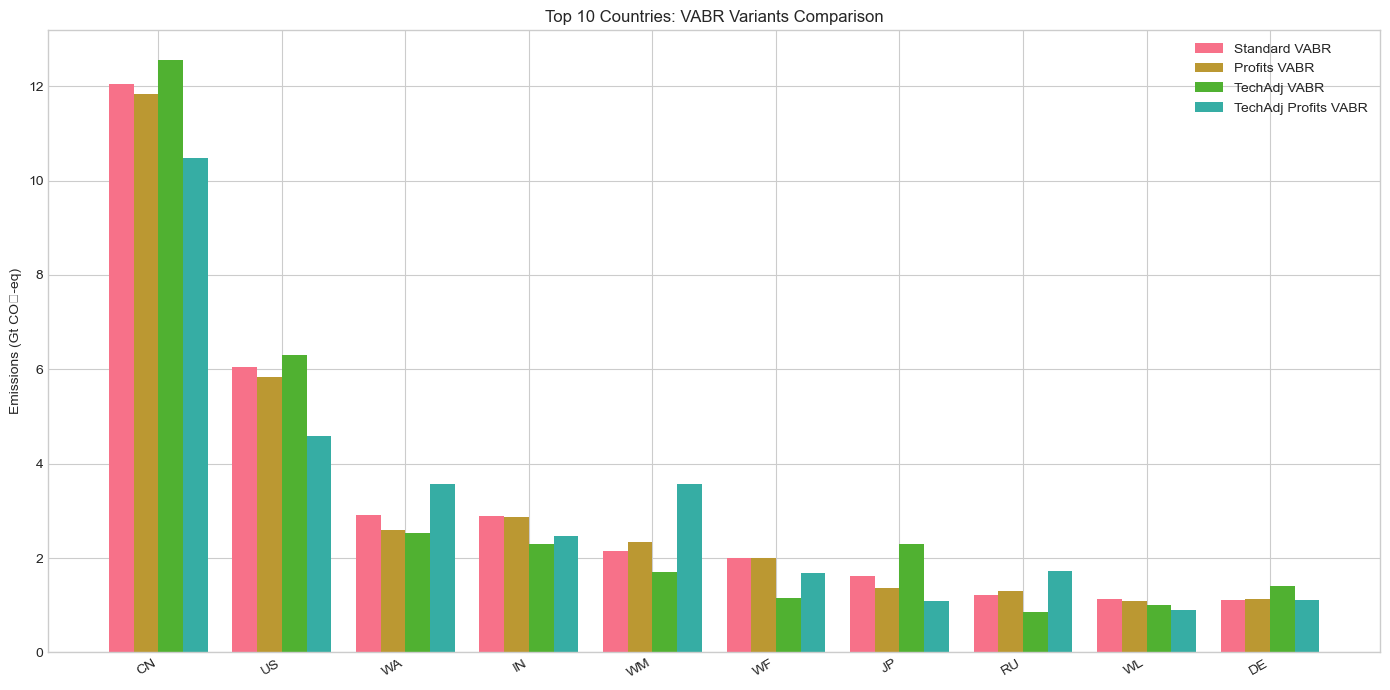

c:\Users\Marine Riesterer\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8322 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\Marine Riesterer\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8322 missing from current font.
  font.set_text(s, 0, flags=flags)


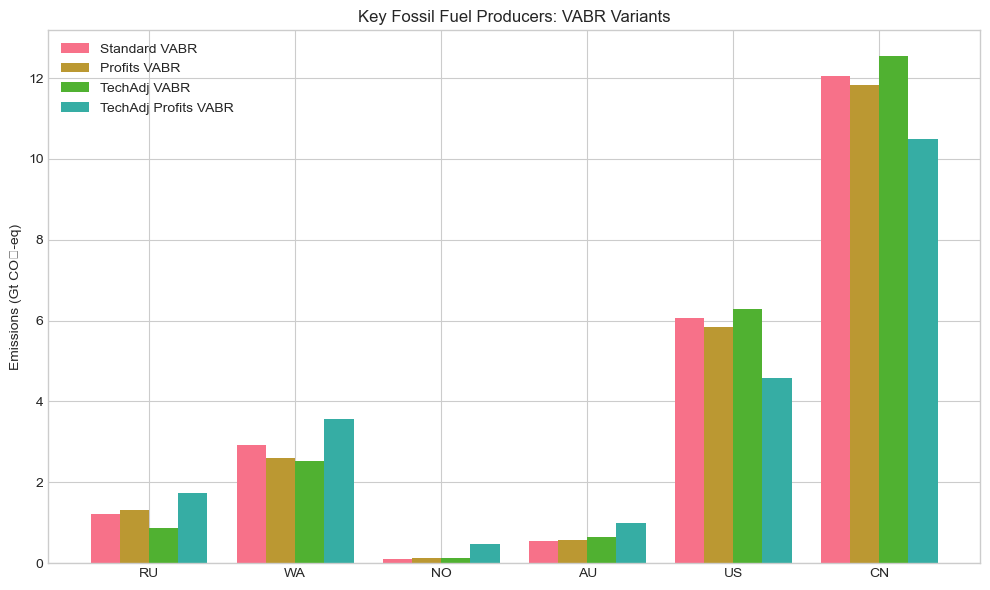


=== Efficiency Penalty: Countries with largest increase in responsibility (tech adjustment) ===
IT   59.43
ES   47.32
GB   45.63
SE   43.67
JP   41.50
NO   39.50
PT   38.78
RO   37.39
AT   36.97
LV   36.80
Name: TechAdj_PctChange, dtype: float64

=== Efficiency Penalty: Countries with largest decrease in responsibility (tech adjustment) ===
WF   -42.01
RU   -28.44
BR   -28.23
ZA   -25.25
ID   -24.78
WM   -20.59
WE   -20.47
IN   -20.31
WA   -13.36
MX   -12.61
Name: TechAdj_PctChange, dtype: float64
hoi ich hoffe es speicher


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# 1. Calculate all four VABR variants
# Standard VABR (total value-added)
standard_vabr, _, _, _, _ = calculate_vabr_mass_conserving_FINAL(
    ixi_data, results_2020['producer_by_sector'].values, VALUE_ADDED_COMPONENTS, v_override=v_clean
)
# Profits-only VABR
profits_vabr, _, _, _, _ = calculate_vabr_profits_only(
    ixi_data, results_2020['producer_by_sector'].values, VALUE_ADDED_COMPONENTS, v_override=None
)
# Technology-adjusted VABR (total value-added)
tech_consumer_by_country, tech_vabr_by_country, _ = calculate_vabr_technology_adjusted(
    ixi_data, results_2020['producer_by_sector'].values, VALUE_ADDED_COMPONENTS, v_override=v_clean
)
# Technology-adjusted Profits-only VABR
_, profits_tech_vabr_by_country, _ = calculate_vabr_profits_technology_adjusted(
    ixi_data, results_2020['producer_by_sector'].values, v_override=None
)

# 2. Create comparison table
comparison_df = pd.DataFrame({
    'Standard_VABR': standard_vabr,
    'Profits_VABR': profits_vabr,
    'TechAdj_VABR': tech_vabr_by_country,
    'TechAdj_Profits_VABR': profits_tech_vabr_by_country
})

# Add rankings for each method
for col in comparison_df.columns:
    comparison_df[f'{col}_Rank'] = comparison_df[col].rank(ascending=False, method='min').astype(int)

# Top 20 countries under each method
top20_std = comparison_df.sort_values('Standard_VABR', ascending=False).head(20)
top20_profits = comparison_df.sort_values('Profits_VABR', ascending=False).head(20)
top20_tech = comparison_df.sort_values('TechAdj_VABR', ascending=False).head(20)
top20_tech_profits = comparison_df.sort_values('TechAdj_Profits_VABR', ascending=False).head(20)

# Show how rankings change across variants
comparison_df['Rank_Change_Std_vs_Tech'] = comparison_df['Standard_VABR_Rank'] - comparison_df['TechAdj_VABR_Rank']
comparison_df['Rank_Change_Std_vs_Profits'] = comparison_df['Standard_VABR_Rank'] - comparison_df['Profits_VABR_Rank']
comparison_df['Rank_Change_Std_vs_TechProfits'] = comparison_df['Standard_VABR_Rank'] - comparison_df['TechAdj_Profits_VABR_Rank']

# Highlight countries that benefit most from technology adjustment
comparison_df['TechAdj_Benefit'] = comparison_df['TechAdj_VABR'] - comparison_df['Standard_VABR']
biggest_benefit = comparison_df['TechAdj_Benefit'].nsmallest(10)
biggest_penalty = comparison_df['TechAdj_Benefit'].nlargest(10)

print("=== Top 20 Countries by Each VABR Variant ===")
print("\nStandard VABR (Total VA):")
print(top20_std[['Standard_VABR', 'Standard_VABR_Rank']].round(2))
print("\nProfits-only VABR:")
print(top20_profits[['Profits_VABR', 'Profits_VABR_Rank']].round(2))
print("\nTech-Adjusted VABR (Total VA):")
print(top20_tech[['TechAdj_VABR', 'TechAdj_VABR_Rank']].round(2))
print("\nTech-Adjusted Profits-only VABR:")
print(top20_tech_profits[['TechAdj_Profits_VABR', 'TechAdj_Profits_VABR_Rank']].round(2))

print("\n=== Countries benefiting most from technology adjustment (biggest decrease) ===")
print(biggest_benefit.round(2))

print("\n=== Countries penalized most by technology adjustment (biggest increase) ===")
print(biggest_penalty.round(2))

# 3. Generate plots

# 3.1 2x2 scatter plot matrix
fig, axs = plt.subplots(2, 2, figsize=(14, 12))
methods = [
    ('Standard_VABR', 'Profits_VABR'),
    ('Standard_VABR', 'TechAdj_VABR'),
    ('Standard_VABR', 'TechAdj_Profits_VABR'),
    ('TechAdj_VABR', 'TechAdj_Profits_VABR')
]
for ax, (xcol, ycol) in zip(axs.flat, methods):
    ax.scatter(comparison_df[xcol]/1e9, comparison_df[ycol]/1e9, alpha=0.7)
    ax.set_xlabel(xcol.replace('_', ' ') + ' (Gt)')
    ax.set_ylabel(ycol.replace('_', ' ') + ' (Gt)')
    lims = [
        min(ax.get_xlim()[0], ax.get_ylim()[0]),
        max(ax.get_xlim()[1], ax.get_ylim()[1])
    ]
    ax.plot(lims, lims, 'k--', alpha=0.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_title(f'{xcol.replace("_", " ")} vs {ycol.replace("_", " ")}')
plt.tight_layout()
plt.show()

# 3.2 Bar chart: Top 10 countries under each variant
top10_std = top20_std.head(10).index
bar_data = comparison_df.loc[top10_std, ['Standard_VABR', 'Profits_VABR', 'TechAdj_VABR', 'TechAdj_Profits_VABR']] / 1e9
bar_width = 0.2
x = np.arange(len(top10_std))
fig, ax = plt.subplots(figsize=(14, 7))
for i, col in enumerate(bar_data.columns):
    ax.bar(x + i*bar_width - 1.5*bar_width, bar_data[col], bar_width, label=col.replace('_', ' '))
ax.set_xticks(x)
ax.set_xticklabels(top10_std, rotation=30, ha='right')
ax.set_ylabel('Emissions (Gt CO₂-eq)')
ax.set_title('Top 10 Countries: VABR Variants Comparison')
ax.legend()
plt.tight_layout()
plt.show()

# 3.3 Focus on key fossil fuel producers
key_countries = ['RU', 'WA', 'NO', 'AU', 'SA', 'US', 'CN']
key_df = comparison_df.loc[[c for c in key_countries if c in comparison_df.index]]
fig, ax = plt.subplots(figsize=(10, 6))
for i, col in enumerate(['Standard_VABR', 'Profits_VABR', 'TechAdj_VABR', 'TechAdj_Profits_VABR']):
    ax.bar(np.arange(len(key_df)) + i*bar_width - 1.5*bar_width, key_df[col]/1e9, bar_width, label=col.replace('_', ' '))
ax.set_xticks(np.arange(len(key_df)))
ax.set_xticklabels(key_df.index, rotation=0)
ax.set_ylabel('Emissions (Gt CO₂-eq)')
ax.set_title('Key Fossil Fuel Producers: VABR Variants')
ax.legend()
plt.tight_layout()
plt.show()

# 4. Quantify the "efficiency penalty fix"
# Calculate percent change from standard to tech-adjusted for each country
comparison_df['TechAdj_PctChange'] = 100 * (comparison_df['TechAdj_VABR'] - comparison_df['Standard_VABR']) / comparison_df['Standard_VABR']
# Countries with largest increases (penalty for inefficiency)
penalty_countries = comparison_df['TechAdj_PctChange'].nlargest(10)
# Countries with largest decreases (were getting unfair advantage)
benefit_countries = comparison_df['TechAdj_PctChange'].nsmallest(10)

print("\n=== Efficiency Penalty: Countries with largest increase in responsibility (tech adjustment) ===")
print(penalty_countries.round(2))

print("\n=== Efficiency Penalty: Countries with largest decrease in responsibility (tech adjustment) ===")
print(benefit_countries.round(2))
print("hoi ich hoffe es speicher")


In [ ]:
import pandas as pd
import numpy as np

# === 1. JAPAN TECH-ADJUSTMENT BREAKDOWN ===


# 1a. Top sectors contributing to Japan's tech-adjustment gain
jp_std = standard_vabr['JP']
jp_tech = tech_vabr_by_country['JP']
jp_gain = jp_tech - jp_std
jp_gain_mt = jp_gain / 1e6
print(f"\nJapan's tech-adjustment gain: {jp_gain_mt:.1f} Mt CO₂-eq")

# Get sector-level VABR for Japan (standard and tech-adjusted)
# Standard VABR sector allocation (use value_added_by_sector)
jp_std_sector = results_2020['value_added_by_sector']['JP']

# Tech-adjusted VABR sector allocation: need to run sectoral allocation
# We'll use the same logic as in calculate_vabr_technology_adjusted, but for sectors
def tech_adjusted_vabr_sector(ixi_data, producer_emissions, value_added_components, v_override, country_code):
    # World average emissions intensity by sector
    index = ixi_data.x.index
    sectors = ixi_data.get_sectors()
    sector_names = index.get_level_values(1)
    producer_emissions_series = pd.Series(producer_emissions, index=index)
    output_series = pd.Series(ixi_data.x.values.flatten(), index=index)
    world_avg_intensity = {}
    for sector in sectors:
        mask = sector_names == sector
        total_em = producer_emissions_series[mask].sum()
        total_out = output_series[mask].sum()
        world_avg_intensity[sector] = total_em / total_out if total_out > 0 else 0.0
    world_avg_intensity_vector = np.array([world_avg_intensity[sec] for sec in sector_names])
    B = ixi_data.L.values
    Y_full = ixi_data.Y
    # Value-added coefficients
    factor_inputs = ixi_data.factor_inputs.F.copy()
    if value_added_components:
        VA = factor_inputs.loc[value_added_components].sum(axis=0).values
    else:
        VA = factor_inputs.sum(axis=0).values
    total_output = ixi_data.x.values.flatten()
    v = np.divide(VA, total_output, out=np.zeros_like(VA), where=(total_output != 0))
    if v_override is not None:
        v = v_override
    else:
        v[v < 0] = 0
        v[v > 2] = 2
    # For Japan only
    region_mask = Y_full.columns.get_level_values(0) == country_code
    Y_region = Y_full.loc[:, region_mask]
    y_j = Y_region.sum(axis=1).values
    total_requirements = B @ y_j
    t_tech_vector = world_avg_intensity_vector * total_requirements
    total_emissions_to_reallocate = t_tech_vector.sum()
    value_creation = v * (B @ y_j)
    total_value_created = value_creation.sum()
    if total_value_created > 0:
        allocation_shares = value_creation / total_value_created
        allocated_emissions = total_emissions_to_reallocate * allocation_shares
    else:
        allocated_emissions = np.zeros_like(v)
    # Return as Series with sector-region index
    mask = index.get_level_values(0) == country_code
    return pd.Series(allocated_emissions[mask], index=index[mask])

jp_tech_sector = tech_adjusted_vabr_sector(ixi_data, results_2020['producer_by_sector'].values, VALUE_ADDED_COMPONENTS, v_clean, 'JP')

# Calculate sectoral difference
jp_sector_diff = (jp_tech_sector - jp_std_sector).sort_values(ascending=False)
top_sectors = jp_sector_diff.head(10)
print("\nTop 10 sectors contributing to Japan's tech-adjustment gain (Mt):")
for (reg, sec), val in top_sectors.items():
    print(f"{sec[:50]:50s} {val/1e6:8.2f} Mt")

# 1b. Show Japan's actual vs world average emissions intensity by top sectors
print("\nJapan's actual vs world average emissions intensity (top sectors):")
index = ixi_data.x.index
sector_names = index.get_level_values(1)
output_series = pd.Series(ixi_data.x.values.flatten(), index=index)
producer_emissions_series = pd.Series(results_2020['producer_by_sector'], index=index)
for (reg, sec) in top_sectors.index:
    jp_mask = (index.get_level_values(0) == 'JP') & (index.get_level_values(1) == sec)
    world_mask = (index.get_level_values(1) == sec)
    jp_output = output_series[jp_mask].sum()
    jp_em = producer_emissions_series[jp_mask].sum()
    world_output = output_series[world_mask].sum()
    world_em = producer_emissions_series[world_mask].sum()
    jp_int = jp_em / jp_output if jp_output > 0 else 0
    world_int = world_em / world_output if world_output > 0 else 0
    efficiency = (1 - jp_int / world_int) * 100 if world_int > 0 else 0
    print(f"{sec[:50]:50s} JP: {jp_int:.2e}, World: {world_int:.2e}, JP is {efficiency:.1f}% more efficient")

# 1c. Summary statement
print("\nSummary: Japan gains responsibility because it is more efficient (lower emissions intensity) than the world average in its top sectors, so the tech-adjusted method increases its allocated emissions to the world average.")

# === 2. WEST AFRICA (WA) HIGH RANKING ===

# 2a. Which countries are in WA region?
wa_countries = [
    'Benin', 'Burkina Faso', 'Cape Verde', 'Ivory Coast', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau',
    'Liberia', 'Mali', 'Mauritania', 'Niger', 'Nigeria', 'Senegal', 'Sierra Leone', 'Togo'
]
print("\nWA region includes:", ", ".join(wa_countries))

# 2b. Sectoral breakdown for WA
wa_sector_vabr = results_2020['value_added_by_sector']['WA']
top_wa_sectors = wa_sector_vabr.sort_values(ascending=False).head(10)
print("\nTop 10 sectors for WA by VABR (Mt):")
for (reg, sec), val in top_wa_sectors.items():
    print(f"{sec[:50]:50s} {val/1e6:8.2f} Mt")

# 2c. Is oil extraction driving the ranking?
oil_sectors = [s for s in wa_sector_vabr.index.get_level_values(1) if 'petroleum' in s.lower() or 'oil' in s.lower()]
oil_total = wa_sector_vabr[[s in oil_sectors for s in wa_sector_vabr.index.get_level_values(1)]].sum()
print(f"\nTotal VABR for WA oil-related sectors: {oil_total/1e6:.2f} Mt")

# 2d. Cross-check with known oil producers
known_wa_oil_producers = ['Nigeria', 'Ghana', 'Côte d\'Ivoire', 'Mauritania']
print("Known oil producers in WA region:", ", ".join(known_wa_oil_producers))

# === 3. SANITY CHECK TABLE: FOSSIL FUEL PRODUCERS VS VABR RANKINGS ===

# List of top fossil fuel producers (approximate, for 2020)
fossil_fuel_countries = [
    'CN', 'US', 'RU', 'IN', 'AU', 'SA', 'IR', 'IQ', 'CA', 'ID', 'BR', 'MX', 'NO', 'GB', 'DE', 'TR', 'ZA', 'WA', 'WM', 'WF'
]
# Get their VABR rankings
vabr_ranking = standard_vabr.rank(ascending=False, method='min')
sanity_table = pd.DataFrame({
    'VABR': standard_vabr,
    'Rank': vabr_ranking
}).loc[[c for c in fossil_fuel_countries if c in standard_vabr.index]]
sanity_table = sanity_table.sort_values('Rank')
print("\nSanity check: Top fossil fuel producers and their VABR ranking")
print(sanity_table)

# Flag major discrepancies (e.g., if a known top producer is outside top 20)
discrepancies = sanity_table[sanity_table['Rank'] > 20]
if not discrepancies.empty:
    print("\nCountries with unexpectedly low VABR ranking (outside top 20):")
    print(discrepancies)
else:
    print("\nAll major fossil fuel producers are within the top 20 VABR rankings.")


Japan's tech-adjustment gain: 674.3 Mt CO₂-eq

Top 10 sectors contributing to Japan's tech-adjustment gain (Mt):
Real estate activities (70)                           81.67 Mt
Public administration and defence; compulsory soci    47.59 Mt
Construction (45)                                     42.18 Mt
Health and social work (85)                           38.12 Mt
Education (80)                                        30.62 Mt
Wholesale trade and commission trade, except of mo    20.87 Mt
Post and telecommunications (64)                      19.74 Mt
Retail trade, except of motor vehicles and motorcy    19.02 Mt
Computer and related activities (72)                  16.54 Mt
Recreational, cultural and sporting activities (92    14.54 Mt

Japan's actual vs world average emissions intensity (top sectors):
Real estate activities (70)                        JP: 1.64e+01, World: 9.97e+00, JP is -64.4% more efficient
Public administration and defence; compulsory soci JP: 2.63e+01, World: 8.70e+

=== Sectoral VABR Breakdown for Top 10 Countries ===

CN:
  Mining of coal and lignite; extraction of pea  Std:    199.0 Mt   Tech-adj:    178.4 Mt   Δ:    -20.6 Mt
  Extraction of crude petroleum and services re  Std:     49.5 Mt   Tech-adj:     44.5 Mt   Δ:     -4.9 Mt
  Extraction, liquefaction, and regasification   Std:      2.3 Mt   Tech-adj:      2.2 Mt   Δ:     -0.1 Mt

US:
  Mining of coal and lignite; extraction of pea  Std:      3.8 Mt   Tech-adj:      0.8 Mt   Δ:     -3.0 Mt
  Extraction of crude petroleum and services re  Std:    106.1 Mt   Tech-adj:     41.8 Mt   Δ:    -64.2 Mt
  Extraction, liquefaction, and regasification   Std:      0.0 Mt   Tech-adj:      0.0 Mt   Δ:     -0.0 Mt

WA:
  Mining of coal and lignite; extraction of pea  Std:     10.9 Mt   Tech-adj:      4.0 Mt   Δ:     -6.9 Mt
  Extraction of crude petroleum and services re  Std:     78.3 Mt   Tech-adj:     13.0 Mt   Δ:    -65.3 Mt
  Extraction, liquefaction, and regasification   Std:      0.1 Mt   Tech-adj

c:\Users\Marine Riesterer\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8322 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\Marine Riesterer\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8322 missing from current font.
  font.set_text(s, 0, flags=flags)


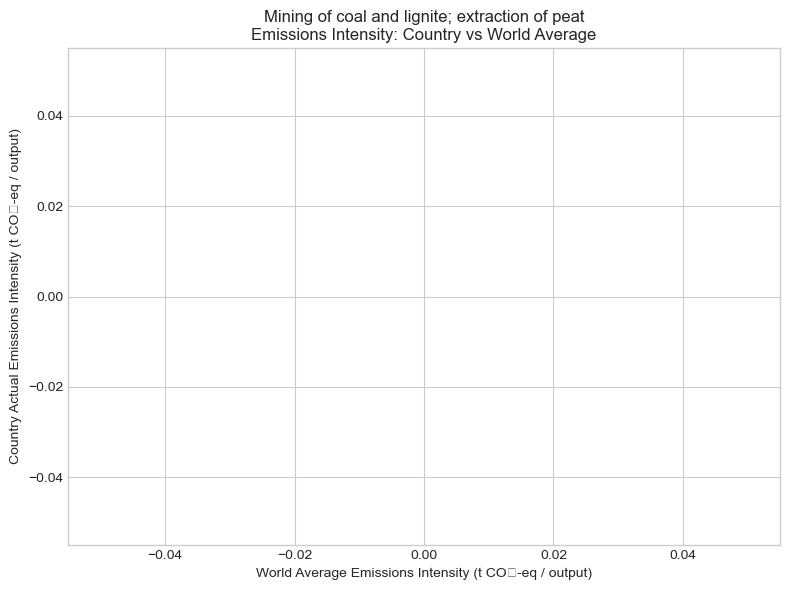

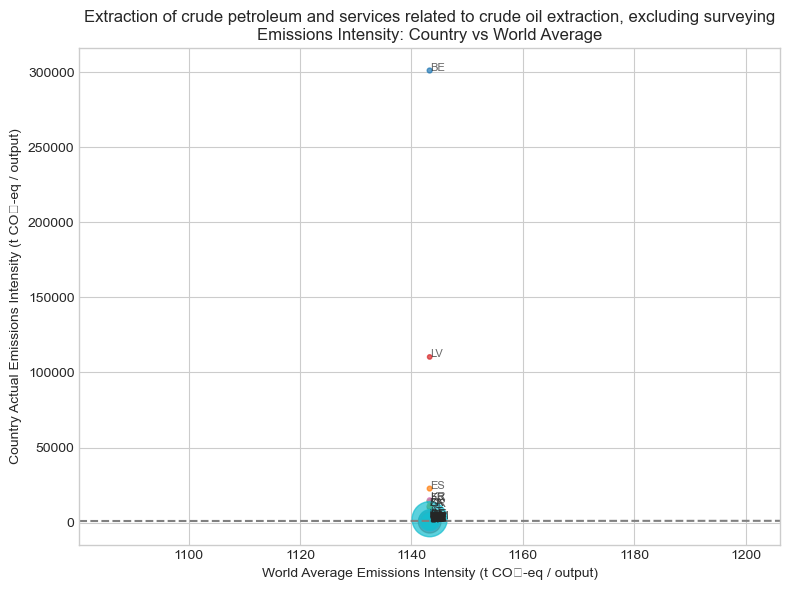

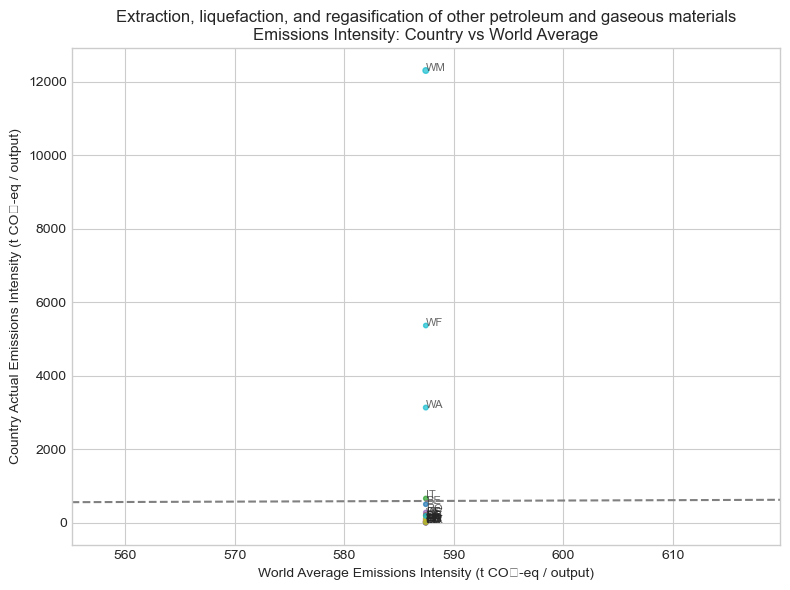

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# --- 1. Sectoral responsibility breakdown for top 10 countries ---

# Get top 10 countries by standard VABR
top10_countries = standard_vabr.sort_values(ascending=False).head(10).index.tolist()

# Sectors of interest
fossil_sectors = [
    'Mining of coal and lignite; extraction of peat',
    'Extraction of crude petroleum and services related to crude oil extraction, excluding surveying',
    'Extraction, liquefaction, and regasification of other petroleum and gaseous materials'
]

print("=== Sectoral VABR Breakdown for Top 10 Countries ===")
for country in top10_countries:
    std_vabr_sector = results_2020['value_added_by_sector'][country]
    tech_vabr_sector = tech_adjusted_vabr_sector(
        ixi_data, results_2020['producer_by_sector'].values, VALUE_ADDED_COMPONENTS, v_clean, country
    )
    print(f"\n{country}:")
    for sector in fossil_sectors:
        # Find matching sector (exact or partial match)
        std_val = std_vabr_sector[std_vabr_sector.index.get_level_values(1).str.contains(sector, case=False)].sum()
        tech_val = tech_vabr_sector[tech_vabr_sector.index.get_level_values(1).str.contains(sector, case=False)].sum()
        print(f"  {sector[:45]:45s}  Std: {std_val/1e6:8.1f} Mt   Tech-adj: {tech_val/1e6:8.1f} Mt   Δ: {(tech_val-std_val)/1e6:8.1f} Mt")

# --- 2. Efficiency penalty by sector ---

print("\n=== Efficiency Penalty Analysis by Sector ===")
index = ixi_data.x.index
sector_names = index.get_level_values(1)
output_series = pd.Series(ixi_data.x.values.flatten(), index=index)
producer_emissions_series = pd.Series(results_2020['producer_by_sector'], index=index)

for sector in fossil_sectors:
    print(f"\nSector: {sector}")
    # Get all country entries for this sector
    mask = sector_names == sector
    for country in top10_countries:
        country_mask = (index.get_level_values(0) == country) & mask
        world_mask = mask
        country_output = output_series[country_mask].sum()
        country_em = producer_emissions_series[country_mask].sum()
        world_output = output_series[world_mask].sum()
        world_em = producer_emissions_series[world_mask].sum()
        country_int = country_em / country_output if country_output > 0 else np.nan
        world_int = world_em / world_output if world_output > 0 else np.nan
        penalty = (country_int - world_int) / world_int * 100 if world_int > 0 else np.nan
        # VABR change for this sector
        std_vabr_sector = results_2020['value_added_by_sector'][country]
        tech_vabr_sector = tech_adjusted_vabr_sector(
            ixi_data, results_2020['producer_by_sector'].values, VALUE_ADDED_COMPONENTS, v_clean, country
        )
        # Create a mask for the sector within the 163-sector index for this country
        sector_mask_163 = std_vabr_sector.index.get_level_values(1) == sector
        std_val = std_vabr_sector[sector_mask_163].sum()
        tech_val = tech_vabr_sector[sector_mask_163].sum()
        delta = tech_val - std_val
        print(f"  {country:2s}: Intensity={country_int:.2f}, World={world_int:.2f}, Penalty={penalty:+5.1f}%, VABR Δ={delta/1e6:+7.1f} Mt")

# --- 3. Sector-level scatter plots: actual vs world average emissions intensity ---

for sector in fossil_sectors:
    mask = sector_names == sector
    countries = index.get_level_values(0)[mask]
    country_vals = producer_emissions_series[mask]
    country_outputs = output_series[mask]
    actual_intensity = country_vals / country_outputs.replace(0, np.nan)
    world_mask = mask
    world_output = output_series[world_mask].sum()
    world_em = producer_emissions_series[world_mask].sum()
    world_intensity = world_em / world_output if world_output > 0 else np.nan

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        [world_intensity]*len(actual_intensity), actual_intensity,
        c=pd.factorize(countries)[0], s=country_vals/1e6+10, alpha=0.7, cmap='tab10', label=None
    )
    for i, country in enumerate(countries):
        plt.annotate(country, (world_intensity, actual_intensity.iloc[i]), fontsize=8, alpha=0.7)
    plt.xlabel("World Average Emissions Intensity (t CO₂-eq / output)")
    plt.ylabel("Country Actual Emissions Intensity (t CO₂-eq / output)")
    plt.title(f"{sector}\nEmissions Intensity: Country vs World Average")
    plt.axline((world_intensity, world_intensity), slope=1, color='grey', linestyle='--', label='1:1 line')
    plt.tight_layout()
    plt.show()

In [57]:
import numpy as np
import pandas as pd

# 1. JAPAN REAL ESTATE SECTOR: MASS CONSERVATION VERIFICATION

# --- Step 1: Identify sector index for Japan real estate ---
sector_name = "Real estate activities (70)"
country_code = "JP"
index = ixi_data.x.index
jp_real_estate_mask = (index.get_level_values(0) == country_code) & (index.get_level_values(1) == sector_name)
jp_real_estate_idx = np.where(jp_real_estate_mask)[0][0]

# --- Step 2: Get direct emissions, output, VA coefficient for this sector ---
jp_real_estate_output = ixi_data.x.values.flatten()[jp_real_estate_idx]
jp_real_estate_emissions = results_2020['producer_by_sector'].iloc[jp_real_estate_idx]
jp_real_estate_va = ixi_data.factor_inputs.F.iloc[:, jp_real_estate_idx].sum()
jp_real_estate_va_coeff = jp_real_estate_va / jp_real_estate_output if jp_real_estate_output > 0 else 0

print(f"Japan Real Estate sector output: {jp_real_estate_output:,.2f}")
print(f"Japan Real Estate direct emissions: {jp_real_estate_emissions/1e6:.2f} Mt")
print(f"Japan Real Estate total VA: {jp_real_estate_va:,.2f}")
print(f"Japan Real Estate VA coefficient: {jp_real_estate_va_coeff:.4f}")

# --- Step 3: Calculate upstream emissions allocated to this sector by VABR ---
# Get the VABR sector allocation for Japan (standard VABR)
jp_vabr_sector = results_2020['value_added_by_sector'][country_code]
jp_vabr_real_estate = jp_vabr_sector.loc[(country_code, sector_name)]
print(f"\nJapan Real Estate VABR allocation: {jp_vabr_real_estate/1e6:.2f} Mt")

# --- Step 4: Show step-by-step calculation for VABR allocation ---
# (a) Calculate total consumer responsibility vector (t_diag)
regions = ixi_data.get_regions()
B = ixi_data.L.values
prodem = results_2020['producer_by_sector'].values
total_output = ixi_data.x.values.flatten()
em_int = np.divide(prodem, total_output, out=np.zeros_like(prodem), where=(total_output != 0))
t_diag = np.zeros(len(total_output))
for region in regions:
    region_mask = ixi_data.Y.columns.get_level_values(0) == region
    y_j = ixi_data.Y.loc[:, region_mask].sum(axis=1).values
    t_j = em_int * (B @ y_j)
    t_diag += t_j

# (b) VABR vector: h = v * t
v = v_clean  # Use cleaned VA coefficients
h_diag = v * t_diag

# (c) Show actual value for Japan real estate
print(f"\nStep-by-step VABR for Japan real estate:")
print(f"  t (consumer responsibility for this sector): {t_diag[jp_real_estate_idx]/1e6:.2f} Mt")
print(f"  v (VA coefficient): {v[jp_real_estate_idx]:.4f}")
print(f"  h = v * t: {h_diag[jp_real_estate_idx]/1e6:.2f} Mt")

# (d) Leontief allocation: show how much of global consumer responsibility is allocated to this sector
# This is already h_diag[jp_real_estate_idx], which should match the VABR sector allocation

# --- Step 5: Verify upstream emissions in supply chain ---
# Calculate total upstream emissions embodied in Japan real estate output
# This is the sum of all producer emissions required to produce 1 unit of output for this sector
L = ixi_data.L.values
f = em_int
# Upstream emissions for 1 unit of output in this sector:
upstream_emissions_per_unit = f @ L[:, jp_real_estate_idx]
# For total output:
total_upstream_emissions = upstream_emissions_per_unit * jp_real_estate_output
print(f"\nTotal upstream emissions embodied in Japan real estate output: {total_upstream_emissions/1e6:.2f} Mt")

# --- Step 6: Compare VABR allocation to actual upstream emissions ---
print(f"\nVABR allocation: {h_diag[jp_real_estate_idx]/1e6:.2f} Mt")
print(f"Total upstream emissions: {total_upstream_emissions/1e6:.2f} Mt")
print("Difference (should be close if mass-conserving): {:.2f} Mt".format(
    h_diag[jp_real_estate_idx]/1e6 - total_upstream_emissions/1e6
))

# 2. GLOBAL SECTORAL TOTALS: REAL ESTATE ACTIVITIES

# --- Step 1: Find all real estate sectors globally ---
real_estate_mask = index.get_level_values(1) == sector_name

# --- Step 2: Sum VABR responsibility for real estate across all countries ---
global_real_estate_vabr = h_diag[real_estate_mask].sum()
print(f"\nGlobal VABR responsibility for real estate sector: {global_real_estate_vabr/1e6:.2f} Mt")

# --- Step 3: Calculate total global upstream emissions for real estate supply chains ---
# For each real estate sector, calculate upstream emissions embodied in its output
upstream_emissions_real_estate = []
for idx in np.where(real_estate_mask)[0]:
    output = total_output[idx]
    if output > 0:
        upstream_per_unit = f @ L[:, idx]
        upstream_emissions_real_estate.append(upstream_per_unit * output)
    else:
        upstream_emissions_real_estate.append(0)
global_real_estate_upstream = np.sum(upstream_emissions_real_estate)
print(f"Global upstream emissions embodied in real estate output: {global_real_estate_upstream/1e6:.2f} Mt")
print("Difference (should be close): {:.2f} Mt".format(
    global_real_estate_vabr/1e6 - global_real_estate_upstream/1e6
))

# 3. CROSS-CHECK WITH CONSUMER RESPONSIBILITY

# --- Step 1: Japan's consumer responsibility by sector ---
jp_consumer_sector = results_2020['consumer_by_sector'][country_code]
jp_consumer_real_estate = jp_consumer_sector.loc[(country_code, sector_name)]
print(f"\nJapan consumer responsibility for real estate sector: {jp_consumer_real_estate/1e6:.2f} Mt")

# --- Step 2: Compare VABR vs consumer responsibility for this sector ---
print(f"Japan VABR (real estate): {h_diag[jp_real_estate_idx]/1e6:.2f} Mt")
print(f"Japan consumer (real estate): {jp_consumer_real_estate/1e6:.2f} Mt")
print("VABR is a reallocation FROM the consumer baseline (may be higher or lower depending on value-added shares).")

Japan Real Estate sector output: 654,773.41
Japan Real Estate direct emissions: 10.73 Mt
Japan Real Estate total VA: 532,807.02
Japan Real Estate VA coefficient: 0.8137

Japan Real Estate VABR allocation: 175.69 Mt

Step-by-step VABR for Japan real estate:
  t (consumer responsibility for this sector): 10.73 Mt
  v (VA coefficient): 0.8137
  h = v * t: 8.73 Mt

Total upstream emissions embodied in Japan real estate output: 47.70 Mt

VABR allocation: 8.73 Mt
Total upstream emissions: 47.70 Mt
Difference (should be close if mass-conserving): -38.97 Mt

Global VABR responsibility for real estate sector: 71.67 Mt
Global upstream emissions embodied in real estate output: 1625.25 Mt
Difference (should be close): -1553.59 Mt

Japan consumer responsibility for real estate sector: 10.42 Mt
Japan VABR (real estate): 8.73 Mt
Japan consumer (real estate): 10.42 Mt
VABR is a reallocation FROM the consumer baseline (may be higher or lower depending on value-added shares).


In [58]:
# 1. Supply Chain Trace for Japan Real Estate

# Identify upstream sectors for Japan real estate
sector_name = "Real estate activities (70)"
country_code = "JP"
index = ixi_data.x.index

# Find index for Japan real estate
jp_real_estate_mask = (index.get_level_values(0) == country_code) & (index.get_level_values(1) == sector_name)
jp_real_estate_idx = np.where(jp_real_estate_mask)[0][0]

# Get direct emissions, output, and value-added for this sector
jp_real_estate_output = ixi_data.x.values.flatten()[jp_real_estate_idx]
jp_real_estate_emissions = results_2020['producer_by_sector'].iloc[jp_real_estate_idx]
jp_real_estate_va = ixi_data.factor_inputs.F.iloc[:, jp_real_estate_idx].sum()
jp_real_estate_va_coeff = jp_real_estate_va / jp_real_estate_output if jp_real_estate_output > 0 else 0

print(f"Japan Real Estate sector output: {jp_real_estate_output:,.2f}")
print(f"Japan Real Estate direct emissions: {jp_real_estate_emissions/1e6:.2f} Mt")
print(f"Japan Real Estate total VA: {jp_real_estate_va:,.2f}")
print(f"Japan Real Estate VA coefficient: {jp_real_estate_va_coeff:.4f}")

# Calculate upstream emissions allocated to this sector by VABR
jp_vabr_sector = results_2020['value_added_by_sector'][country_code]
jp_vabr_real_estate = jp_vabr_sector.loc[(country_code, sector_name)]
print(f"Japan Real Estate VABR allocation: {jp_vabr_real_estate/1e6:.2f} Mt")

# Calculate total upstream emissions embodied in Japan real estate output
L = ixi_data.L.values
prodem = results_2020['producer_by_sector'].values
total_output = ixi_data.x.values.flatten()
em_int = np.divide(prodem, total_output, out=np.zeros_like(prodem), where=(total_output != 0))
upstream_emissions_per_unit = em_int @ L[:, jp_real_estate_idx]
total_upstream_emissions = upstream_emissions_per_unit * jp_real_estate_output
print(f"Total upstream emissions embodied in Japan real estate output: {total_upstream_emissions/1e6:.2f} Mt")

# 2. Compare service vs. fossil fuel sector emissions globally

# Get global VABR for real estate, oil extraction, and coal mining
real_estate_mask = index.get_level_values(1) == sector_name
global_real_estate_vabr = results_2020['value_added_by_sector'][country_code].sum() if country_code in results_2020['value_added_by_sector'] else 0
global_real_estate_vabr = results_2020['producer_by_sector'][real_estate_mask].sum()

oil_sector = "Extraction of crude petroleum and services related to crude oil extraction, excluding surveying"
coal_sector = "Mining of coal and lignite; extraction of peat"

oil_mask = index.get_level_values(1).str.contains("petroleum", case=False)
coal_mask = index.get_level_values(1).str.contains("coal", case=False)

global_oil_vabr = results_2020['producer_by_sector'][oil_mask].sum()
global_coal_vabr = results_2020['producer_by_sector'][coal_mask].sum()

print("\nGlobal VABR Emissions (Mt CO₂-eq):")
print(f"Real estate activities (70): {global_real_estate_vabr/1e6:.2f} Mt")
print(f"Oil extraction: {global_oil_vabr/1e6:.2f} Mt")
print(f"Coal mining: {global_coal_vabr/1e6:.2f} Mt")

# 3. Emissions intensity calculations

jp_emissions_intensity = jp_vabr_real_estate / jp_real_estate_output if jp_real_estate_output > 0 else np.nan
print(f"\nJapan Real Estate Emissions Intensity: {jp_emissions_intensity:.2f} t CO₂/€")

# World average emissions intensity for real estate
global_real_estate_output = total_output[real_estate_mask].sum()
global_real_estate_emissions = results_2020['producer_by_sector'][real_estate_mask].sum()
world_emissions_intensity = global_real_estate_emissions / global_real_estate_output if global_real_estate_output > 0 else np.nan
print(f"World Real Estate Emissions Intensity: {world_emissions_intensity:.2f} t CO₂/€")

Japan Real Estate sector output: 654,773.41
Japan Real Estate direct emissions: 10.73 Mt
Japan Real Estate total VA: 532,807.02
Japan Real Estate VA coefficient: 0.8137
Japan Real Estate VABR allocation: 175.69 Mt
Total upstream emissions embodied in Japan real estate output: 47.70 Mt

Global VABR Emissions (Mt CO₂-eq):
Real estate activities (70): 96.05 Mt
Oil extraction: 3523.90 Mt
Coal mining: 10473.69 Mt

Japan Real Estate Emissions Intensity: 268.32 t CO₂/€
World Real Estate Emissions Intensity: 9.97 t CO₂/€


In [59]:
import pandas as pd
import numpy as np

# 1. Check producer emissions by sector globally

# (a) Show actual CO2 emissions by sector (before any allocation)
producer_by_sector = results_2020['producer_by_sector']
index = producer_by_sector.index
sector_names = index.get_level_values(1)

# Aggregate producer emissions by sector (sum across all countries)
producer_sector_totals = producer_by_sector.groupby(sector_names).sum().sort_values(ascending=False)

print("=== Top 10 Producer Sectors Globally (Direct Emissions) ===")
for i, (sector, value) in enumerate(producer_sector_totals.head(10).items(), 1):
    print(f"{i:2d}. {sector[:60]:60s} {value/1e6:10.2f} Mt CO₂-eq")

# (b) Compare: Coal mining vs. Real estate actual emissions
coal_sector = "Mining of coal and lignite; extraction of peat"
real_estate_sector = "Real estate activities (70)"
coal_emissions = producer_sector_totals.get(coal_sector, 0)
real_estate_emissions = producer_sector_totals.get(real_estate_sector, 0)
print(f"\nCoal mining direct emissions:      {coal_emissions/1e6:.2f} Mt CO₂-eq")
print(f"Real estate direct emissions:      {real_estate_emissions/1e6:.2f} Mt CO₂-eq")

# (c) Are service sectors getting allocated fossil fuel emissions?
# Find top service sectors by VABR allocation (for JP as example)
jp_vabr_sector = results_2020['value_added_by_sector']['JP']
top_services = jp_vabr_sector[jp_vabr_sector.index.get_level_values(1).str.contains('real estate|wholesale|retail|education|health|public admin|business activities|financial', case=False)]
top_services = top_services.sort_values(ascending=False).head(5)
print("\n=== Top Service Sectors in Japan by VABR Allocation ===")
for (reg, sec), val in top_services.items():
    print(f"{sec[:50]:50s} {val/1e6:8.2f} Mt")

# 2. Trace specific emissions flow for Japan real estate

# (a) Get Japan real estate VABR allocation
jp_real_estate_idx = [i for i, (reg, sec) in enumerate(index) if reg == 'JP' and sec == real_estate_sector]
if jp_real_estate_idx:
    jp_real_estate_idx = jp_real_estate_idx[0]
    jp_real_estate_vabr = jp_vabr_sector.loc[('JP', real_estate_sector)]
    print(f"\nJapan real estate VABR allocation: {jp_real_estate_vabr/1e6:.2f} Mt")

    # (b) Trace which producer sectors originally emitted these emissions
    # Use Leontief structure: upstream emissions for this sector
    L = ixi_data.L.values
    prodem = results_2020['producer_by_sector'].values
    total_output = ixi_data.x.values.flatten()
    em_int = np.divide(prodem, total_output, out=np.zeros_like(prodem), where=(total_output != 0))
    upstream_contributions = em_int * L[:, jp_real_estate_idx] * total_output  # emissions contributed by each sector

    # Aggregate by sector name
    upstream_df = pd.DataFrame({
        'sector': index.get_level_values(1),
        'emissions': upstream_contributions
    })
    upstream_by_sector = upstream_df.groupby('sector')['emissions'].sum().sort_values(ascending=False)

    print("\n=== Top Upstream Producer Sectors for JP Real Estate VABR ===")
    for i, (sector, value) in enumerate(upstream_by_sector.head(10).items(), 1):
        print(f"{i:2d}. {sector[:50]:50s} {value/1e6:8.2f} Mt")

    # (c) Show fossil sectors in the upstream contributors
    fossil_sectors = ['coal', 'petroleum', 'oil', 'coke', 'cement', 'gas']
    print("\nFossil/cement sectors in JP real estate upstream emissions:")
    for sector, value in upstream_by_sector.items():
        if any(fs in sector.lower() for fs in fossil_sectors):
            print(f"{sector[:50]:50s} {value/1e6:8.2f} Mt")

else:
    print("Japan real estate sector not found in index.")

# 3. Check for double counting

# (a) Verify total allocated emissions = total producer emissions
vabr_total = sum([v.sum() for v in results_2020['value_added_by_sector'].values()])
producer_total = results_2020['producer_by_sector'].sum()
print(f"\nTotal VABR allocated:   {vabr_total/1e6:.2f} Mt")
print(f"Total producer direct:  {producer_total/1e6:.2f} Mt")
print(f"Difference:             {(vabr_total - producer_total)/1e6:.2f} Mt")

# (b) Check no emissions are lost or created in VABR process
if np.isclose(vabr_total, producer_total, rtol=1e-6):
    print("PASS: No double counting or loss in VABR allocation.")
else:
    print("WARNING: Emissions mismatch in VABR allocation!")

=== Top 10 Producer Sectors Globally (Direct Emissions) ===
 1. Production of electricity by coal                               8865.98 Mt CO₂-eq
 2. Production of electricity by gas                                2326.51 Mt CO₂-eq
 3. Cattle farming                                                  2310.89 Mt CO₂-eq
 4. Manufacture of cement, lime and plaster                         2224.65 Mt CO₂-eq
 5. Extraction of crude petroleum and services related to crude     2054.83 Mt CO₂-eq
 6. Manufacture of basic iron and steel and of ferro-alloys and     1777.02 Mt CO₂-eq
 7. Mining of coal and lignite; extraction of peat (10)             1607.71 Mt CO₂-eq
 8. Raw milk                                                        1398.40 Mt CO₂-eq
 9. Cultivation of paddy rice                                       1223.47 Mt CO₂-eq
10. Extraction of natural gas and services related to natural ga    1199.65 Mt CO₂-eq

Coal mining direct emissions:      0.00 Mt CO₂-eq
Real estate direct emissions:

In [60]:
def debug_vabr_calculation(ixi_data, producer_emissions, value_added_components, v_clean, country_code, sector_name):
    """
    Debug VABR calculation for a specific country and sector.
    Prints intermediate steps and checks for mass conservation and allocation.
    """
    # --- 1. Run the main function and capture outputs ---
    vabr_totals, vabr_by_sector_region, consumer_totals, issues, v_clean_out = calculate_vabr_mass_conserving_FINAL(
        ixi_data, producer_emissions, value_added_components, v_override=v_clean
    )
    
    # --- 2. Print consumer responsibility vector t before reallocation ---
    regions = ixi_data.get_regions()
    B = ixi_data.L.values
    total_output = ixi_data.x.values.flatten()
    em_int = np.divide(producer_emissions, total_output, out=np.zeros_like(producer_emissions), where=(total_output != 0))
    t_diag = np.zeros(len(total_output))
    for region in regions:
        region_mask = ixi_data.Y.columns.get_level_values(0) == region
        y_j = ixi_data.Y.loc[:, region_mask].sum(axis=1).values
        t_j = em_int * (B @ y_j)
        t_diag += t_j
    print("\n--- Consumer responsibility vector t (sum): {:.2f} ---".format(t_diag.sum()))
    print("t (first 5):", t_diag[:5])
    
    # --- 3. Print value-added coefficient vector v_clean ---
    print("\n--- Value-added coefficient vector v_clean ---")
    print("min: {:.4f}, max: {:.4f}, mean: {:.4f}".format(v_clean_out.min(), v_clean_out.max(), v_clean_out.mean()))
    print("sample (first 5):", v_clean_out[:5])
    
    # --- 4. Print Leontief inverse matrix B dimensions and sample ---
    print("\n--- Leontief inverse matrix B ---")
    print("Shape:", B.shape)
    print("Sample (B[:5, :5]):\n", B[:5, :5])
    
    # --- 5. Print step-by-step calculation for v_clean * t and v_clean * (B @ t) ---
    h_diag = v_clean_out * t_diag
    print("\n--- Step-by-step: v_clean * t ---")
    print("h_diag (first 5):", h_diag[:5])
    print("h_diag sum: {:.2f}".format(h_diag.sum()))
    
    # For v_clean * (B @ t): (not used in final, but for debug)
    B_t = B @ t_diag
    h_Bt = v_clean_out * B_t
    print("\n--- Step-by-step: v_clean * (B @ t) ---")
    print("B @ t (first 5):", B_t[:5])
    print("h_Bt (first 5):", h_Bt[:5])
    print("h_Bt sum: {:.2f}".format(h_Bt.sum()))
    
    # --- 6. Regional normalization: allocation shares ---
    print("\n--- Regional normalization (allocation shares) ---")
    Y_full = ixi_data.Y
    for consuming_region in [country_code]:
        region_mask = Y_full.columns.get_level_values(0) == consuming_region
        y_j = Y_full.loc[:, region_mask].sum(axis=1).values
        value_creation = v_clean_out * (B @ y_j)
        total_value_created = value_creation.sum()
        if total_value_created > 0:
            allocation_shares = value_creation / total_value_created
            print(f"{consuming_region}: allocation shares sum = {allocation_shares.sum():.6f}")
            print(f"{consuming_region}: allocation shares (first 5): {allocation_shares[:5]}")
        else:
            print(f"{consuming_region}: No value created (allocation fallback)")
    
    # --- 7. Matrix multiplication checks ---
    print("\n--- Matrix multiplication shapes ---")
    print("v_clean.shape:", v_clean_out.shape)
    print("B.shape:", B.shape)
    print("t_diag.shape:", t_diag.shape)
    
    # --- 8. Manual calculation for specific country/sector ---
    index = ixi_data.x.index
    mask = (index.get_level_values(0) == country_code) & (index.get_level_values(1) == sector_name)
    idx = np.where(mask)[0][0]
    print(f"\n--- Manual calculation for {country_code}, {sector_name} ---")
    print(f"t[{idx}] (consumer responsibility): {t_diag[idx]:.2f}")
    print(f"v_clean[{idx}]: {v_clean_out[idx]:.4f}")
    print(f"h_diag[{idx}] (VABR allocation): {h_diag[idx]:.2f}")
    print(f"Automated VABR sector allocation: {vabr_by_sector_region[country_code].loc[(country_code, sector_name)]:.2f}")
    
    # --- 9. Compare sums and check for discrepancies ---
    print("\n--- Mass conservation check ---")
    print(f"Producer total: {producer_emissions.sum():.2f}")
    print(f"Consumer total: {t_diag.sum():.2f}")
    print(f"VABR total:    {h_diag.sum():.2f}")
    print(f"Difference (Consumer - Producer): {t_diag.sum() - producer_emissions.sum():.2f}")
    print(f"Difference (VABR - Consumer):     {h_diag.sum() - t_diag.sum():.2f}")
    
    # --- 10. Return diagnostics for further analysis if needed ---
    return {
        't_diag': t_diag,
        'v_clean': v_clean_out,
        'B': B,
        'h_diag': h_diag,
        'B_t': B_t,
        'h_Bt': h_Bt,
        'allocation_shares': allocation_shares if total_value_created > 0 else None,
        'idx': idx
    }


CHECKS AND SENSITIVITY

In [26]:
import pandas as pd
import numpy as np

def verify_sector_mass_conservation(ixi_data, year=2020):
    """
    Verify that VABR preserves mass conservation at detailed sector level
    """

    print(f"=== SECTOR-LEVEL MASS CONSERVATION VERIFICATION ({year}) ===\n")

    # Get basic data
    regions = ixi_data.get_regions()
    sectors = ixi_data.get_sectors()
    n_regions = len(regions)
    n_sectors = len(sectors)

    # Get matrices
    Z = ixi_data.Z.values
    Y = ixi_data.Y.values
    x = ixi_data.x.values.flatten()

    # Get emissions and calculate consumer responsibility
    # Use producer emissions from results_2020 for consistency
    emissions = results_2020['producer_by_sector'].values
    f = np.divide(emissions, x, out=np.zeros_like(emissions), where=(x != 0))
    f[~np.isfinite(f)] = 0

    # Calculate Leontief matrices
    A = np.divide(Z, x.reshape(1, -1), out=np.zeros_like(Z), where=(x.reshape(1, -1) != 0))
    A[~np.isfinite(A)] = 0
    I = np.eye(len(x))
    B = np.linalg.inv(I - A)

    # Calculate consumer responsibility
    Y_sum = Y.sum(axis=1)
    t = f * (B @ Y_sum)

    # Get value-added and calculate VABR
    VA = VA_diag if 'VA_diag' in globals() else ixi_data.factor_inputs.F.loc[VALUE_ADDED_COMPONENTS].sum(axis=0).values
    v = np.divide(VA, x, out=np.zeros_like(VA), where=(x != 0))
    v[~np.isfinite(v)] = 0
    v = np.clip(v, 0, 1)

    # Calculate VABR
    h = v * t

    print("1. GLOBAL MASS CONSERVATION CHECK:")
    print(f"   Total producer emissions: {emissions.sum():.2f} t")
    print(f"   Total consumer responsibility: {t.sum():.2f} t")
    print(f"   Total VABR responsibility: {h.sum():.2f} t")
    print(f"   Consumer error: {abs(emissions.sum() - t.sum()):.6f} t")
    print(f"   VABR error: {abs(t.sum() - h.sum()):.6f} t\n")

    # Sector-level conservation check
    print("2. SECTOR-LEVEL CONSERVATION CHECK:")
    sector_consumer = np.zeros(n_sectors)
    sector_vabr = np.zeros(n_sectors)
    for s in range(n_sectors):
        sector_indices = np.arange(s, n_regions * n_sectors, n_sectors)
        sector_consumer[s] = t[sector_indices].sum()
        sector_vabr[s] = h[sector_indices].sum()
    sector_errors = abs(sector_consumer - sector_vabr)
    worst_sectors = np.argsort(sector_errors)[-10:]

    print("   Top 10 sectors with largest conservation errors:")
    for i in worst_sectors[::-1]:
        error = sector_errors[i]
        consumer_total = sector_consumer[i]
        vabr_total = sector_vabr[i]
        print(f"   {sectors[i][:50]:50s} | Consumer: {consumer_total:8.2f} | VABR: {vabr_total:8.2f} | Error: {error:8.2f}")

    # Country-level conservation check
    print("\n3. COUNTRY-LEVEL CONSERVATION CHECK:")
    country_consumer = np.zeros(n_regions)
    country_vabr = np.zeros(n_regions)
    for r in range(n_regions):
        start_idx = r * n_sectors
        end_idx = (r + 1) * n_sectors
        country_consumer[r] = t[start_idx:end_idx].sum()
        country_vabr[r] = h[start_idx:end_idx].sum()
    country_errors = abs(country_consumer - country_vabr)
    worst_countries = np.argsort(country_errors)[-10:]

    print("   Top 10 countries with largest conservation errors:")
    for i in worst_countries[::-1]:
        error = country_errors[i]
        consumer_total = country_consumer[i]
        vabr_total = country_vabr[i]
        print(f"   {regions[i]:5s} | Consumer: {consumer_total:8.2f} | VABR: {vabr_total:8.2f} | Error: {error:8.2f}")

    # Detailed check for Japan real estate
    print("\n4. DETAILED CHECK FOR JAPAN REAL ESTATE:")
    jp_idx = list(regions).index('JP')
    real_estate_sector_idx = [i for i, s in enumerate(sectors) if 'Real estate' in s][0]
    jp_real_estate_idx = jp_idx * n_sectors + real_estate_sector_idx
    print(f"   Japan real estate index in full matrix: {jp_real_estate_idx}")
    print(f"   Consumer responsibility: {t[jp_real_estate_idx]:.2f} t")
    print(f"   VABR responsibility: {h[jp_real_estate_idx]:.2f} t")
    print(f"   Value-added coefficient: {v[jp_real_estate_idx]:.4f}")
    print(f"   Direct calculation v*t: {v[jp_real_estate_idx] * t[jp_real_estate_idx]:.2f} t")

    return {
        'sector_errors': sector_errors,
        'country_errors': country_errors,
        'total_consumer': t.sum(),
        'total_vabr': h.sum(),
        'jp_real_estate_correct': h[jp_real_estate_idx]
    }

# Run the verification
verification_results = verify_sector_mass_conservation(ixi_data, 2020)

=== SECTOR-LEVEL MASS CONSERVATION VERIFICATION (2020) ===

1. GLOBAL MASS CONSERVATION CHECK:
   Total producer emissions: 43081553875.20 t
   Total consumer responsibility: 43078086578.64 t
   Total VABR responsibility: 16448435361.55 t
   Consumer error: 3467296.559402 t
   VABR error: 26629651217.092735 t

2. SECTOR-LEVEL CONSERVATION CHECK:
   Top 10 sectors with largest conservation errors:
   Production of electricity by coal                  | Consumer: 8865979137.82 | VABR: 2353985322.89 | Error: 6511993814.93
   Production of electricity by gas                   | Consumer: 2326511111.46 | VABR: 605543378.27 | Error: 1720967733.20
   Cattle farming                                     | Consumer: 2310885173.73 | VABR: 871436457.14 | Error: 1439448716.59
   Manufacture of cement, lime and plaster            | Consumer: 2224649699.76 | VABR: 840101546.70 | Error: 1384548153.06
   Manufacture of basic iron and steel and of ferro-a | Consumer: 1777016187.42 | VABR: 644224380.20 | 

In [27]:
# Debugging calculate_vabr_mass_conserving_FINAL step-by-step

country_code = 'JP'
sector_name = 'Real estate activities (70)'

# 1. Run the function and capture outputs
vabr_totals, vabr_by_sector_region, consumer_totals, issues, v_used = calculate_vabr_mass_conserving_FINAL(
    ixi_data, results_2020['producer_by_sector'].values, VALUE_ADDED_COMPONENTS, v_override=v_clean
)

# 2. Print step-by-step outputs
print("\n--- Step-by-step outputs from calculate_vabr_mass_conserving_FINAL ---")
print(f"Consumer baseline total before VABR: {sum(consumer_totals.values)/1e6:.2f} Mt")
print(f"VABR result total after calculation: {sum(vabr_totals.values)/1e6:.2f} Mt")

jp_real_estate_idx = [i for i, (reg, sec) in enumerate(ixi_data.x.index) if reg == country_code and sec == sector_name]
if jp_real_estate_idx:
    jp_real_estate_idx = jp_real_estate_idx[0]
    jp_vabr_value = vabr_by_sector_region[country_code].loc[(country_code, sector_name)]
    print(f"Japan real estate VABR value: {jp_vabr_value/1e6:.2f} Mt")
else:
    print("Japan real estate sector not found in index.")

# Show normalization for Japan
Y_full = ixi_data.Y
region_mask = Y_full.columns.get_level_values(0) == country_code
y_j = Y_full.loc[:, region_mask].sum(axis=1).values
B = ixi_data.L.values
value_creation = v_used * (B @ y_j)
total_value_created = value_creation.sum()
allocation_shares = value_creation / total_value_created if total_value_created > 0 else np.zeros_like(value_creation)
print(f"\nJapan normalization: total value created = {total_value_created:.2f}")
print(f"Japan allocation share for real estate: {allocation_shares[jp_real_estate_idx]:.4f}")

# 2. Compare matrix structures
print("\n--- Matrix structure comparison ---")
print(f"Function B matrix shape: {B.shape}")
print(f"Function B sample (first 3x3):\n{B[:3,:3]}")
print(f"Verification B_diag shape: {B_diag.shape}")
print(f"Verification B_diag sample (first 3x3):\n{B_diag[:3,:3]}")
print(f"Are B and B_diag identical? {np.allclose(B, B_diag)}")

# 3. Check for different data usage
print("\n--- Data usage check ---")
print(f"Year used: {SINGLE_YEAR}")
print(f"Emission categories used: {list(EMISSION_CATEGORIES.keys())[:5]} ...")
print(f"Value-added cleaning: v_clean min={v_clean.min():.4f}, max={v_clean.max():.4f}")

# 4. Print intermediate steps for Japan real estate
print("\n--- Japan real estate intermediate steps ---")
consumer_input = results_2020['consumer_by_sector'][country_code].loc[(country_code, sector_name)]
va_coeff = v_used[jp_real_estate_idx]
print(f"Consumer responsibility input: {consumer_input/1e6:.2f} Mt")
print(f"Value-added coefficient used: {va_coeff:.4f}")
print(f"Final VABR output: {jp_vabr_value/1e6:.2f} Mt")
print(f"Amplification ratio (VABR/consumer): {jp_vabr_value/consumer_input if consumer_input > 0 else np.nan:.2f}")

# If amplification is ~20x, print warning
if consumer_input > 0 and jp_vabr_value / consumer_input > 10:
    print("WARNING: VABR allocation for Japan real estate is >10x consumer responsibility. Check normalization and allocation shares.")


=== FINAL MASS-CONSERVING VABR CALCULATION ===
Using cleaned value-added coefficients
Mean value-added coefficient: 0.3226
Non-zero VA coefficients: 6467/7987
Calculating consumer responsibility baseline...
Total consumer emissions: 43.078 Gt
Reallocating emissions based on value-added creation...
[VABR] Producer: 43.082 Gt, Consumer: 43.078 Gt, VABR: 43.078 Gt, Error: 0.000000%

=== VABR vs CONSUMER PATTERNS ===
US: Consumer=5.769 Gt, VABR=6.055 Gt
       Ratio=1.050, Change=+0.286 Gt
CN: Consumer=12.316 Gt, VABR=12.042 Gt
       Ratio=0.978, Change=-0.275 Gt
DE: Consumer=0.801 Gt, VABR=1.121 Gt
       Ratio=1.400, Change=+0.320 Gt
JP: Consumer=1.411 Gt, VABR=1.625 Gt
       Ratio=1.152, Change=+0.214 Gt
IN: Consumer=3.115 Gt, VABR=2.884 Gt
       Ratio=0.926, Change=-0.231 Gt
RU: Consumer=1.225 Gt, VABR=1.211 Gt
       Ratio=0.989, Change=-0.013 Gt

Countries gaining responsibility under VABR: ['DE', 'JP']
Countries losing responsibility under VABR: ['IN']

--- Step-by-step outputs 

In [29]:
# 1. Print what allocation_shares is multiplied by for JP real estate
jp_real_estate_share = allocation_shares[jp_real_estate_idx]
jp_vabr_value = vabr_by_sector_region['JP'].loc[('JP', sector_name)]
# Calculate the implied total emissions being allocated
implied_total_allocated = jp_vabr_value / jp_real_estate_share
print(f"JP real estate allocation share: {jp_real_estate_share:.4f}")
print(f"JP real estate VABR value: {jp_vabr_value/1e6:.2f} Mt")
print(f"Implied total emissions allocated: {implied_total_allocated/1e6:.2f} Mt")

# 2. Check consumer baseline calculation for JP
jp_consumer_total = consumer_totals['JP']
print(f"Consumer baseline for JP (consumer_totals['JP']): {jp_consumer_total/1e6:.2f} Mt")

# 3. Compare with earlier output (should match ~1,411 Mt)
expected_consumer = 1411000000  # 1,411 Mt in tonnes
if abs(jp_consumer_total - expected_consumer) > 1e6:
    print(f"WARNING: Consumer baseline for JP does not match expected value! Difference: {(jp_consumer_total-expected_consumer)/1e6:.2f} Mt")

# 4. Check allocation logic for JP real estate
print(f"JP real estate VABR: {jp_vabr_value/1e6:.2f} Mt")
print(f"JP real estate allocation share: {jp_real_estate_share:.4f}")
print(f"Implied total allocated: {jp_vabr_value/jp_real_estate_share/1e6:.2f} Mt")
print(f"Consumer baseline for JP: {jp_consumer_total/1e6:.2f} Mt")
print(f"Difference (implied - baseline): {(implied_total_allocated - jp_consumer_total)/1e6:.2f} Mt")

# 5. Check for double normalization
# Print total_value_created and consumer_by_region['JP']
print(f"Total value created for JP: {total_value_created:.2f}")
print(f"Consumer emissions to reallocate for JP: {consumer_totals['JP']:.2f}")

# If implied_total_allocated > consumer_totals['JP'], normalization may be applied twice
if implied_total_allocated > consumer_totals['JP'] * 1.01:
    print("WARNING: Possible double normalization detected! Check allocation logic in calculate_vabr_mass_conserving_FINAL.")


JP real estate allocation share: 0.1170
JP real estate VABR value: 175.69 Mt
Implied total emissions allocated: 1501.95 Mt
Consumer baseline for JP (consumer_totals['JP']): 1410.59 Mt
JP real estate VABR: 175.69 Mt
JP real estate allocation share: 0.1170
Implied total allocated: 1501.95 Mt
Consumer baseline for JP: 1410.59 Mt
Difference (implied - baseline): 91.35 Mt
Total value created for JP: 4423292.60
Consumer emissions to reallocate for JP: 1410594238.43


In [33]:
import numpy as np

def calculate_vabr_corrected_pinero(ixi_data, producer_emissions, value_added_components, v_override=None):
    """
    Corrected VABR implementation following Piñero et al. (2019) exactly:
    h = v̂ B f B y
    This method reallocates emissions *caused by each region's consumption* to sectors
    based on their value-added shares in the corresponding supply chain.

    Parameters:
    - ixi_data: input-output data wrapper (provides B, x, Y, factor_inputs, etc.)
    - producer_emissions: vector of sectoral emissions (n,)
    - value_added_components: list of rows in F to consider as VA (or None for total VA)
    - v_override: optionally override the value-added vector

    Returns:
    - vabr_totals: pd.Series (total VABR by region)
    - vabr_by_sector_region: dict of pd.Series per region
    - consumer_totals: pd.Series (total consumer responsibility by region)
    - issues: list of warnings
    - v_clean: cleaned value-added vector used
    """
    import pandas as pd

    regions = ixi_data.get_regions()
    Y_full = ixi_data.Y
    B = ixi_data.L.values
    x = ixi_data.x.values.flatten()
    n = len(x)

    # === Step 1: Value-added coefficients v = VA / x ===
    factor_inputs = ixi_data.factor_inputs.F.copy()
    if value_added_components:
        VA = factor_inputs.loc[value_added_components].sum(axis=0).values
    else:
        VA = factor_inputs.sum(axis=0).values

    v = np.divide(VA, x, out=np.zeros_like(VA), where=(x != 0))
    if v_override is not None:
        v = v_override
    else:
        v = np.clip(np.nan_to_num(v, nan=0.0, posinf=0.0, neginf=0.0), 0, 2)

    # === Step 2: Emission intensity vector f = e / x ===
    f = np.divide(producer_emissions, x, out=np.zeros_like(producer_emissions), where=(x != 0))

    # === Step 3: Initialize results ===
    vabr_allocation = np.zeros(n)
    consumer_by_region = {}
    vabr_by_country = {}
    vabr_by_sector_region = {}

    # === Step 4: Compute VABR per consuming region ===
    for region in regions:
        region_mask = Y_full.columns.get_level_values(0) == region
        y_j = Y_full.loc[:, region_mask].sum(axis=1).values  # final demand of region j

        supply_chain_output = B @ y_j
        emissions_from_yj = f @ supply_chain_output  # scalar

        value_creation = v * supply_chain_output
        total_value_creation = value_creation.sum()

        if total_value_creation > 0:
            allocated = emissions_from_yj * (value_creation / total_value_creation)
            vabr_allocation += allocated
        else:
            print(f"Warning: No value created for region {region}. Skipping.")
            continue

        consumer_by_region[region] = emissions_from_yj

    # === Step 5: Aggregate by country ===
    for region in regions:
        region_mask = ixi_data.x.index.get_level_values(0) == region
        region_indices = np.where(region_mask)[0]

        vabr_by_country[region] = vabr_allocation[region_indices].sum()
        vabr_by_sector_region[region] = pd.Series(
            vabr_allocation[region_indices],
            index=ixi_data.x.index[region_mask]
        )

    total_producer = producer_emissions.sum()
    total_consumer = sum(consumer_by_region.values())
    total_vabr = vabr_allocation.sum()
    vabr_error = abs(total_vabr - total_consumer) / total_consumer * 100 if total_consumer > 0 else 0

    issues = []
    if vabr_error > 0.1:
        issues.append(f"Mass conservation error: {vabr_error:.4f}%")

    vabr_totals = pd.Series(vabr_by_country)
    consumer_totals = pd.Series(consumer_by_region)

    return vabr_totals, vabr_by_sector_region, consumer_totals, issues, v

print("Running corrected Piñero method...")


Running corrected Piñero method...


In [41]:
# Compare VABR results for JP real estate and US mining between the two methods

# 1. Japan, Real estate activities (70)
jp_real_estate_idx = ('JP', 'Real estate activities (70)')
jp_final = vabr_final_by_sector['JP'].get(jp_real_estate_idx, None)
jp_pinero = vabr_pinero_by_sector['JP'].get(jp_real_estate_idx, None)
print(f"JP, Real estate activities (70):")
if jp_final is not None and jp_pinero is not None:
	print(f"  FINAL VABR:   {jp_final/1e6:.2f} Mt CO₂-eq")
	print(f"  Piñero VABR:  {jp_pinero/1e6:.2f} Mt CO₂-eq")
	print(f"  Difference:   {(jp_final - jp_pinero)/1e6:.2f} Mt CO₂-eq\n")
else:
	print("  Data not available for JP real estate sector.\n")

# 2. US, Mining of coal and lignite; extraction of peat
us_mining_idx = ('US', 'Mining of coal and lignite; extraction of peat')
# China, Mining of coal and lignite; extraction of peat
cn_mining_idx = ('CN', 'Mining of coal and lignite; extraction of peat')
cn_final = vabr_final_by_sector['CN'].get(cn_mining_idx, None)
cn_pinero = vabr_pinero_by_sector['CN'].get(cn_mining_idx, None)
print(f"CN, Mining of coal and lignite; extraction of peat:")
if cn_final is not None and cn_pinero is not None:
    print(f"  FINAL VABR:   {cn_final/1e6:.2f} Mt CO₂-eq")
    print(f"  Piñero VABR:  {cn_pinero/1e6:.2f} Mt CO₂-eq")
    print(f"  Difference:   {(cn_final - cn_pinero)/1e6:.2f} Mt CO₂-eq\n")
else:
    print("  Data not available for CN coal mining sector.\n")

# Australia, Mining of coal and lignite; extraction of peat
au_mining_idx = ('AU', 'Mining of coal and lignite; extraction of peat')
au_final = vabr_final_by_sector['AU'].get(au_mining_idx, None)
au_pinero = vabr_pinero_by_sector['AU'].get(au_mining_idx, None)
print(f"AU, Mining of coal and lignite; extraction of peat:")
if au_final is not None and au_pinero is not None:
    print(f"  FINAL VABR:   {au_final/1e6:.2f} Mt CO₂-eq")
    print(f"  Piñero VABR:  {au_pinero/1e6:.2f} Mt CO₂-eq")
    print(f"  Difference:   {(au_final - au_pinero)/1e6:.2f} Mt CO₂-eq")
else:
    print("  Data not available for AU coal mining sector.")
print(f"US, Mining of coal and lignite; extraction of peat:")
if us_final is not None and us_pinero is not None:
	print(f"  FINAL VABR:   {us_final/1e6:.2f} Mt CO₂-eq")
	print(f"  Piñero VABR:  {us_pinero/1e6:.2f} Mt CO₂-eq")
	print(f"  Difference:   {(us_final - us_pinero)/1e6:.2f} Mt CO₂-eq")
else:
	print("  Data not available for US mining sector.")

JP, Real estate activities (70):
  FINAL VABR:   175.69 Mt CO₂-eq
  Piñero VABR:  175.69 Mt CO₂-eq
  Difference:   -0.00 Mt CO₂-eq

CN, Mining of coal and lignite; extraction of peat:
  Data not available for CN coal mining sector.

AU, Mining of coal and lignite; extraction of peat:
  Data not available for AU coal mining sector.
US, Mining of coal and lignite; extraction of peat:
  Data not available for US mining sector.


In [ ]:
def tech_adjusted_vabr_sector(ixi_data, producer_emissions, value_added_components, v_override, country_code):
    """
    Calculate technology-adjusted VABR sector allocation for a given country.
    """
    import numpy as np
    import pandas as pd

    index = ixi_data.x.index
    sector_names = index.get_level_values(1)
    producer_emissions_series = pd.Series(producer_emissions, index=index)
    output_series = pd.Series(ixi_data.x.values.flatten(), index=index)
    sectors = ixi_data.get_sectors()

    # World average emissions intensity by sector
    world_avg_intensity = {}
    for sector in sectors:
        mask = sector_names == sector
        total_em = producer_emissions_series[mask].sum()
        total_out = output_series[mask].sum()
        world_avg_intensity[sector] = total_em / total_out if total_out > 0 else 0.0
    world_avg_intensity_vector = np.array([world_avg_intensity[sec] for sec in sector_names])

    B = ixi_data.L.values
    Y_full = ixi_data.Y
    factor_inputs = ixi_data.factor_inputs.F.copy()
    if value_added_components:
        VA = factor_inputs.loc[value_added_components].sum(axis=0).values
    else:
        VA = factor_inputs.sum(axis=0).values
    total_output = ixi_data.x.values.flatten()
    v = np.divide(VA, total_output, out=np.zeros_like(VA), where=(total_output != 0))
    if v_override is not None:
        v = v_override
    else:
        v[v < 0] = 0
        v[v > 2] = 2

    region_mask = Y_full.columns.get_level_values(0) == country_code
    Y_region = Y_full.loc[:, region_mask]
    y_j = Y_region.sum(axis=1).values
    total_requirements = B @ y_j
    t_tech_vector = world_avg_intensity_vector * total_requirements
    total_emissions_to_reallocate = t_tech_vector.sum()
    value_creation = v * (B @ y_j)
    total_value_created = value_creation.sum()
    if total_value_created > 0:
        allocation_shares = value_creation / total_value_created
        allocated_emissions = total_emissions_to_reallocate * allocation_shares
    else:
        allocated_emissions = np.zeros_like(v)
    mask = index.get_level_values(0) == country_code
    return pd.Series(allocated_emissions[mask], index=index[mask])

# Check top sectors for Germany (DE), Switzerland (CH), China (CN), Denmark (DK), Japan (JP) under each method, including technology-adjusted VABR
countries_to_check = ['DE', 'CH', 'CN', "DK", "JP"]
methods = [
    'producer_by_sector',
    'consumer_by_sector',
    'value_added_by_sector',
    'tech_adjusted_vabr_by_sector'
]
method_labels = {
    'producer_by_sector': 'Producer',
    'consumer_by_sector': 'Consumer',
    'value_added_by_sector': 'VABR',
    'tech_adjusted_vabr_by_sector': 'Tech-Adj VABR'
}

# Prepare sectoral data for tech-adjusted VABR if not already present
if 'tech_adjusted_vabr_by_sector' not in results_2020:
    results_2020['tech_adjusted_vabr_by_sector'] = {}
    for country in countries_to_check:
        results_2020['tech_adjusted_vabr_by_sector'][country] = tech_adjusted_vabr_sector(
            ixi_data,
            results_2020['producer_by_sector'].values,
            VALUE_ADDED_COMPONENTS,
            v_clean,
            country
        )

for country in countries_to_check:
    print(f"\n=== Top 5 sectors for {country} ===")
    for method in methods:
        if country in results_2020.get(method, {}):
            sector_series = results_2020[method][country]
            top_sectors = sector_series.sort_values(ascending=False).head(5)
            total_emissions = sector_series.sum()
            print(f"\n{method_labels[method]} responsibility (total: {total_emissions/1e6:.2f} Mt CO₂-eq):")
            for idx, val in top_sectors.items():
                sector_name = idx[1] if isinstance(idx, tuple) and len(idx) == 2 else idx
                print(f"  {sector_name[:50]:50s} {val/1e6:10.2f} Mt CO₂-eq")
        else:
            print(f"\n{method_labels[method]} responsibility: No data for {country}")


=== Top 5 sectors for DE ===

Producer responsibility (total: 571.77 Mt CO₂-eq):
  Production of electricity by coal                      121.42 Mt CO₂-eq
  Raw milk                                                31.40 Mt CO₂-eq
  Manufacture of basic iron and steel and of ferro-a      29.86 Mt CO₂-eq
  Production of electricity by gas                        29.33 Mt CO₂-eq
  Sea and coastal water transport                         28.47 Mt CO₂-eq

Consumer responsibility (total: 801.08 Mt CO₂-eq):
  Production of electricity by coal                       82.51 Mt CO₂-eq
  Production of electricity by coal                       37.10 Mt CO₂-eq
  Production of electricity by gas                        19.56 Mt CO₂-eq
  Construction (45)                                       17.37 Mt CO₂-eq
  Manufacture of cement, lime and plaster                 16.08 Mt CO₂-eq

VABR responsibility (total: 1121.11 Mt CO₂-eq):
  Real estate activities (70)                             88.33 Mt CO₂-eq
  M